<h1 align='center'>Домашнее задание</h1>

**Дополнительный материал для выполнения дз**:

- Лекция Coursera: https://ru.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression
- Статья на Хабре: https://habrahabr.ru/company/io/blog/265007/
- Книжка ISLR, 4 глава: http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf
- Логистическая регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/
- Линейная регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LinearRegression/


<h1 align='center'>Overview</h1>

На последней лекции вы узнали про классические модели машинного обучения, которые каждый Data Scientist должен знать и понимать, как они работают.

В этом домашнем задании мы предлагаем вам реализовать две модели: одну линейную -- логистическую регрессию, и модель бустинга над деревьями, а также сравнить их качество на одном датасете.

-----------

<h1 align='center'>Logistic Regression</h1>

In [1]:
import pandas as pd
import numpy as np
import tqdm  # interactive progress bar

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Знакомство с данными
Данные представляют собой выборку отзывов о еде с сайта Амазон. Для них проставлены метки -- положительный или отрицательный отзыв.

In [2]:
train_df = pd.read_csv('./data/train.csv')

In [3]:
print train_df.shape

(110163, 3)


In [4]:
train_df.Prediction.value_counts(normalize=True)

0    0.50074
1    0.49926
Name: Prediction, dtype: float64

Видим, что классы сбалансированы. Можем оценивать качество модели по метрике ```accuracy```.

In [5]:
train_df.head()

ID    Reviews_Summary  Prediction
0  239071  Michigan Cherries           1
1  466160      Great Product           1
2  397133           Ovaltine           1
3  297146                  ~           1
4  292685           Love it!           1

In [6]:
train_df.tail()

ID                                    Reviews_Summary  Prediction
110158  486256                                          Terrible!           0
110159  199050                     Cheap Coffee, No Banana Flavor           0
110160  278179                                   Not as described           0
110161   87500  Tastes like a squirt of toothpaste mixed into ...           0
110162  121963                                       Disappointed           0


----------
## 2. Извлечение признаков
Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координате равно количеству раз, слово используется в документе. 

Для решения данной задачи напишем код, который преобразовывает матрицу документов в численную матрицу.

Дополнительная информация:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Разряженные матрицы: http://www.scipy-lectures.org/advanced/scipy_sparse/
- Трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Помните, что все эти трансформеры возвращают ```sparse```-матрицы. Учитывая это и то, что линейные модели достаточно хорошо масштабируются на большое количество фич, можно смело ставить ```n_features``` 1000+.

In [7]:
review_summaries = list(train_df['Reviews_Summary'].values)
review_summaries = [l.lower() for l in review_summaries]

In [8]:
review_summaries[:5]

['michigan cherries', 'great product', 'ovaltine', '~', 'love it!']

Преобразуем ```review_summaries``` с помощью ```TfidfVectorizer```.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
vectorizer = TfidfVectorizer()

In [11]:
tfidfed = vectorizer.fit_transform(review_summaries)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = tfidfed
y = train_df.Prediction.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

/home/nikolay/miniconda3/envs/otus_python_env/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## 3. Логистическая регрессия

Логистическая регрессия -- линейный классификатор, который очень часто используется на практике, например, в кредитном скоринге. Преимущества этой модели -- скорость обучения и предсказания (даже при сотнях тысяч фичей) а также интепретируемость: важные признаки имеют бОльшие по модулю веса. 

При этом отрицательные веса говорят, что фича важна для определения класса 0, а положительные -- для определения класса 1. Это можно понять, если вспомнить, что разделяющая поверхность линейных моделей, это $w^Tx = 0$, а значение алгоритма есть $a(x) = sign(w^Tx)$.

Будем предсказывать сентимент, подготовим данные и сделаем валидационную выборку. При этом нужно оценивать качество модели не по обучающей выборке, а по валидационной. Иначе вы переобучитесь, когда будете тюнить гиперпараметры модели.

-----
** Реализуйте код в модуле ```dmia.classifiers.logistic_regression```.**

-----

In [14]:
from dmia.gradient_check import *
from dmia.classifiers import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Gradient check

В этой ячейке вы можете проверить, правильно ли у вас все работает, прежде чем обучать модель на всех данных.

In [15]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]
clf = LogisticRegression()
clf.w = np.random.randn(X_train_sample.shape[1]+1) * 2
loss, grad = clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, clf.w, grad, 10)

numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.000004 analytic: -0.000004, relative error: 3.330496e-08
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000058 analytic: 0.000058, relative error: 4.628807e-08
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.000103 analytic: -0.000103, relative error: 4.428083e-08
numerical: 0.000000 analytic: 0.000000, relative error: nan


dmia/gradient_check.py:51: RuntimeWarning: invalid value encountered in double_scalars
  abs(grad_numerical) + abs(grad_analytic))


Обучите свою модель на ```X_train, y_train```.

Для начала можете взять параметры по умолчанию, и найти оптимальные используя валидацию.

In [16]:
clf = LogisticRegression()

In [17]:
clf.train(
    X_train, y_train,
    learning_rate=1, reg=1e-3, num_iters=1000
)

  (0, 16230)	1.0
  (0, 14539)	0.40057582190437596
  (0, 5615)	0.3559672187935118
  (0, 4046)	0.8442904417616284
  (1, 16230)	1.0
  (1, 11585)	0.5808205024328522
  (1, 9626)	0.6468416204610717
  (1, 5486)	0.49420993716531425
  (2, 16230)	1.0
  (2, 14590)	0.6001260841332232
  (2, 1582)	0.7999054213736293
  (3, 16230)	1.0
  (3, 14395)	0.2603494412298522
  (3, 8421)	0.2826585654237005
  (3, 5329)	0.6772355374741154
  (3, 4316)	0.3551093502189036
  (3, 2431)	0.38173681691663275
  (3, 609)	0.3490683065297261
  (4, 16230)	1.0
  (4, 6312)	0.6206721124741924
  (4, 2990)	0.7840702320563022
  (5, 16230)	1.0
  (5, 9830)	0.5260695729221255
  (5, 7235)	0.5841650621957019
  (5, 5156)	0.6180630910800484
  :	:
  (193, 8224)	0.2676582427345125
  (193, 5615)	0.22544508832701846
  (193, 1379)	0.4431432560313541
  (194, 16230)	1.0
  (194, 6312)	0.5828977991587404
  (194, 5486)	0.8125454791800253
  (195, 16230)	1.0
  (195, 10052)	0.4679815177235964
  (195, 9126)	0.6498080883601451
  (195, 6829)	0.5989513731

  (199, 5003)	0.7575642007681574
  (0, 16230)	1.0
  (0, 14152)	0.4092077246992964
  (0, 5189)	0.9124412518329194
  (1, 16230)	1.0
  (1, 15540)	0.6173943188532247
  (1, 15257)	0.4018824867552529
  (1, 14335)	0.20168631427797692
  (1, 11414)	0.32792550681880017
  (1, 11132)	0.29705030495897305
  (1, 5759)	0.33480322907731536
  (1, 1489)	0.3298031664810978
  (2, 16230)	1.0
  (2, 15695)	0.5094036343260322
  (2, 15211)	0.47306168592569486
  (2, 9669)	0.28631191836602315
  (2, 5296)	0.4483449515694558
  (2, 4657)	0.4834592727917412
  (3, 16230)	1.0
  (3, 15877)	0.39087508768380447
  (3, 15816)	0.30491199970703226
  (3, 15355)	0.28119510814024656
  (3, 14539)	0.2602224983341983
  (3, 11440)	0.4479393519835424
  (3, 4575)	0.38618466037335253
  (3, 3892)	0.4516734468868832
  :	:
  (196, 9740)	0.21381292389862122
  (196, 9313)	0.45636566318834115
  (196, 7597)	0.42518983015438366
  (196, 7464)	0.27456545759858847
  (196, 5724)	0.4173581908675703
  (196, 4471)	0.4265371332966648
  (196, 729)	0.24

  (0, 16230)	1.0
  (0, 16067)	0.32132070585900574
  (0, 15650)	0.508843509999415
  (0, 8396)	0.6300671968093754
  (0, 8319)	0.49076125949642907
  (1, 16230)	1.0
  (1, 8421)	0.5229767535319877
  (1, 7484)	0.4771236080651852
  (1, 2431)	0.7062919919495065
  (2, 16230)	1.0
  (2, 14575)	0.4145619397492272
  (2, 10407)	0.4145619397492272
  (2, 10080)	0.29426244184914874
  (2, 9390)	0.5337070411469632
  (2, 6059)	0.5337070411469632
  (3, 16230)	1.0
  (3, 14335)	0.24467729790917409
  (3, 12533)	0.6162218221151746
  (3, 11363)	0.6399220667497552
  (3, 4331)	0.3884629124171847
  (4, 16230)	1.0
  (4, 15069)	1.0
  (5, 16230)	1.0
  (5, 15899)	0.4555925343581604
  (5, 14380)	0.5213977466621234
  :	:
  (195, 3581)	0.5864880206364944
  (195, 2353)	0.8099579011589967
  (196, 16230)	1.0
  (196, 15166)	0.6821473865726183
  (196, 10255)	0.4594559146516646
  (196, 8594)	0.49278954800650915
  (196, 7484)	0.2841367045266939
  (197, 16230)	1.0
  (197, 10170)	1.0
  (198, 16230)	1.0
  (198, 15736)	0.3075298772

  (0, 16230)	1.0
  (0, 14328)	0.42396708495823066
  (0, 14024)	0.36893845907422024
  (0, 13986)	0.4170423692607005
  (0, 13807)	0.32203139259450947
  (0, 9669)	0.2758176894144403
  (0, 3317)	0.3747418806411116
  (0, 932)	0.38381770059730813
  (0, 729)	0.20660316193335576
  (1, 16230)	1.0
  (1, 16142)	0.3958589403856421
  (1, 16067)	0.3632732291663645
  (1, 15771)	0.47341246293585637
  (1, 8421)	0.32029066627260816
  (1, 7484)	0.29220847253632637
  (1, 3539)	0.5470255916330066
  (2, 16230)	1.0
  (2, 15844)	1.0
  (3, 16230)	1.0
  (3, 10949)	0.6251401833810337
  (3, 3875)	0.7805124926113147
  (4, 16230)	1.0
  (4, 15831)	0.4517177087152766
  (4, 12978)	0.47021516143046743
  (4, 7755)	0.39679207005229755
  :	:
  (192, 5490)	0.484207125000947
  (193, 16230)	1.0
  (193, 15915)	1.0
  (194, 16230)	1.0
  (194, 14539)	0.25134068419343203
  (194, 14395)	0.23419806502810245
  (194, 13727)	0.3161796658070256
  (194, 9535)	0.5518232729741145
  (194, 8825)	0.3280847209101581
  (194, 8421)	0.2542662998

  (0, 16230)	1.0
  (0, 15877)	0.39440587977446917
  (0, 15816)	0.307666283392119
  (0, 8304)	0.37994365453832407
  (0, 6873)	0.5013855567882655
  (0, 6312)	0.20921254203010653
  (0, 1449)	0.5570196721306098
  (1, 16230)	1.0
  (1, 10080)	0.5740813803663852
  (1, 3870)	0.4414141173682275
  (1, 3398)	0.6896260912296276
  (2, 16230)	1.0
  (2, 3916)	0.7349152237937817
  (2, 2284)	0.6781589886126523
  (3, 16230)	1.0
  (3, 13356)	0.39468992597882147
  (3, 13196)	0.3802660789392287
  (3, 9445)	0.21926408568245812
  (3, 8200)	0.40479716996609505
  (3, 7404)	0.43514979338686705
  (3, 409)	0.5461911211029157
  (4, 16230)	1.0
  (4, 11350)	0.6723141040652166
  (4, 2651)	0.6935274338219034
  (4, 1481)	0.2588695501819216
  :	:
  (194, 10080)	0.4328202957551383
  (194, 7328)	0.4551368650614007
  (194, 6163)	0.27206475492285925
  (194, 5599)	0.3366868519369369
  (194, 5486)	0.3337292487131035
  (195, 16230)	1.0
  (195, 14935)	0.8229102919197406
  (195, 13790)	0.5681713222722239
  (196, 16230)	1.0
  (19

  (0, 16230)	1.0
  (0, 9740)	0.15847967279664502
  (0, 9294)	0.2808427386947063
  (0, 8224)	0.428829444600655
  (0, 5599)	0.22772678698442905
  (0, 4041)	0.31000901220553023
  (0, 3820)	0.5204057304275147
  (0, 2415)	0.25904324027609404
  (0, 1143)	0.30989834928897814
  (0, 1007)	0.2563664229733437
  (0, 609)	0.2539006211150438
  (1, 16230)	1.0
  (1, 12683)	0.8099545383329264
  (1, 7202)	0.3807415117061195
  (1, 1163)	0.4461048611006552
  (2, 16230)	1.0
  (2, 13705)	0.7418240573169146
  (2, 6163)	0.4484888422973103
  (2, 2990)	0.49855273173525927
  (3, 16230)	1.0
  (3, 15596)	0.4552893314726413
  (3, 15208)	0.3858418926758085
  (3, 14590)	0.18499845416085953
  (3, 14539)	0.16501391596775558
  (3, 14378)	0.31956126373853727
  :	:
  (193, 11440)	0.519885460911161
  (193, 6163)	0.27346645328022334
  (194, 16230)	1.0
  (194, 15251)	0.6592355735954428
  (194, 14140)	0.4325258242708555
  (194, 6312)	0.34272755202941363
  (194, 5003)	0.5107520875385926
  (195, 16230)	1.0
  (195, 14539)	0.2777

  (0, 16230)	1.0
  (0, 11191)	0.5206587492885396
  (0, 11132)	0.593459377076151
  (0, 6312)	0.40546886266744464
  (0, 6163)	0.4607769915662555
  (1, 16230)	1.0
  (1, 3524)	1.0
  (2, 16230)	1.0
  (2, 13498)	1.0
  (3, 16230)	1.0
  (3, 3870)	1.0
  (4, 16230)	1.0
  (4, 12627)	0.7435588483498561
  (4, 10581)	0.6686705010994847
  (5, 16230)	1.0
  (5, 11991)	0.695833043321852
  (5, 9740)	0.22386465530037447
  (5, 3490)	0.6824228835031063
  (6, 16230)	1.0
  (6, 9740)	0.39389452052460644
  (6, 4289)	0.6758685399387315
  (6, 2143)	0.6229356495030426
  (7, 16230)	1.0
  (7, 5003)	0.7628121742604451
  (7, 2990)	0.6466201255761007
  :	:
  (194, 16230)	1.0
  (194, 1632)	1.0
  (195, 16230)	1.0
  (195, 16069)	0.3434947992961657
  (195, 9338)	0.5150056623522904
  (195, 8905)	0.6120036792139137
  (195, 7202)	0.28457060859727246
  (195, 2262)	0.4015613974883248
  (196, 16230)	1.0
  (196, 8886)	1.0
  (197, 16230)	1.0
  (197, 14395)	0.20408769007770403
  (197, 14335)	0.17342579751424672
  (197, 7552)	0.4234

  (0, 16230)	1.0
  (0, 15447)	0.562153033462215
  (0, 14335)	0.34765571120642197
  (0, 11132)	0.25601944138921917
  (0, 6524)	0.4106172445642098
  (0, 4368)	0.5735564466833538
  (1, 16230)	1.0
  (1, 14143)	0.5515688573491472
  (1, 13498)	0.4883801831416746
  (1, 9921)	0.3431580812610993
  (1, 9838)	0.5826655332025923
  (2, 16230)	1.0
  (2, 16069)	0.4659495259174539
  (2, 15572)	0.5515255718755139
  (2, 9255)	0.5156896217912001
  (2, 4331)	0.4612751855904849
  (3, 16230)	1.0
  (3, 13498)	1.0
  (4, 16230)	1.0
  (4, 15174)	0.40874977258884326
  (4, 14539)	0.28255650487279177
  (4, 9740)	0.22033799398350143
  (4, 7484)	0.2607833387326703
  (4, 3396)	0.6176731801037437
  (4, 1322)	0.36110483789409287
  :	:
  (194, 16230)	1.0
  (194, 13498)	0.5069404745394299
  (194, 8795)	0.6306696128497387
  (194, 1616)	0.5875944134364268
  (195, 16230)	1.0
  (195, 2990)	0.5966182878790965
  (195, 1091)	0.8025251513617598
  (196, 16230)	1.0
  (196, 4209)	1.0
  (197, 16230)	1.0
  (197, 14395)	0.195603157645

  (0, 16230)	1.0
  (0, 1091)	1.0
  (1, 16230)	1.0
  (1, 5759)	0.417316732720788
  (1, 5003)	0.376993451970438
  (1, 4744)	0.6489808364310975
  (1, 3756)	0.5123929700023727
  (2, 16230)	1.0
  (2, 15915)	0.41369034020237366
  (2, 14395)	0.24608457473625125
  (2, 8329)	0.6277923427403008
  (2, 7464)	0.26445994896070474
  (2, 2208)	0.5515799074408609
  (3, 16230)	1.0
  (3, 8673)	0.7262434811792935
  (3, 6531)	0.6874375651974376
  (4, 16230)	1.0
  (4, 13603)	1.0
  (5, 16230)	1.0
  (5, 6930)	0.45542880937917085
  (5, 3672)	0.6072015458179337
  (5, 2582)	0.5772602975861854
  (5, 729)	0.301100367277244
  (6, 16230)	1.0
  (6, 12842)	0.6389584185238443
  :	:
  (193, 7464)	0.2528797271087882
  (193, 1295)	0.7005160733647292
  (193, 1099)	0.35369059744621645
  (194, 16230)	1.0
  (194, 15289)	0.5082639031950419
  (194, 9511)	0.42563290900829037
  (194, 7924)	0.5796017891362059
  (194, 2767)	0.47388416043184095
  (195, 16230)	1.0
  (195, 13264)	0.6754922259036845
  (195, 9740)	0.30464032520977546
  

<dmia.classifiers.logistic_regression.LogisticRegression instance at 0x7f17db7370e0>

Посмотрим на качество на валидации.

In [18]:
clf.predict(X_train)

array([1, 0, 0, ..., 0, 1, 1])

In [19]:
print "Train f1-score = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test f1-score = %.3f" % accuracy_score(y_test, clf.predict(X_test))

Train f1-score = 0.830
Test f1-score = 0.825


Нарисуем кривые обучения.

In [20]:
clf = LogisticRegression()
train_scores = []
test_scores = []
num_iters = 1000

for i in tqdm.trange(num_iters):
    # Сделайте один шаг градиентного спуска с помощью num_iters=1
    clf.train(X_train, y_train, learning_rate=1.0, num_iters=1, batch_size=256, reg=1e-3)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

  0%|          | 0/1000 [00:00<?, ?it/s]

  (0, 16230)	1.0
  (0, 14539)	0.21428566469500682
  (0, 14362)	0.24263928134069385
  (0, 14348)	0.2829013906969506
  (0, 12533)	0.4273206853862907
  (0, 10003)	0.26476748674432465
  (0, 8421)	0.21677995842462341
  (0, 6575)	0.31990568465811225
  (0, 2721)	0.2888552970669502
  (0, 715)	0.5741944495619178
  (1, 16230)	1.0
  (1, 12050)	0.9056665777805425
  (1, 6312)	0.42399062476814336
  (2, 16230)	1.0
  (2, 9126)	0.4832498257074529
  (2, 7567)	0.5247020019747308
  (2, 6077)	0.5194197604003828
  (2, 2304)	0.47048966788127766
  (3, 16230)	1.0
  (3, 15355)	0.33023770758854665
  (3, 12273)	0.47064375013929566
  (3, 5486)	0.33943489709645397
  (3, 1197)	0.6421220086835684
  (3, 1163)	0.3766972173228531
  (4, 16230)	1.0
  :	:
  (252, 13872)	0.4041862494812371
  (252, 11565)	0.3548383313424927
  (252, 9472)	0.5601762481450306
  (252, 5706)	0.2749672337201436
  (252, 877)	0.2553436531773688
  (252, 729)	0.18609999656934353
  (253, 16230)	1.0
  (253, 14335)	0.24691144045369684
  (253, 5078)	0.552

  0%|          | 2/1000 [00:00<00:59, 16.74it/s]

  (0, 16230)	1.0
  (0, 15205)	0.38721011190486443
  (0, 14395)	0.23437008475478532
  (0, 14201)	0.26211426358715806
  (0, 8927)	0.6243711535728408
  (0, 5615)	0.22351513724948763
  (0, 3409)	0.5353846761360299
  (1, 16230)	1.0
  (1, 15888)	0.43507459564159806
  (1, 14310)	0.5427133165468072
  (1, 10489)	0.5450724896710404
  (1, 1317)	0.4680473622122858
  (2, 16230)	1.0
  (2, 4974)	1.0
  (3, 16230)	1.0
  (3, 5184)	0.7041017334757596
  (3, 461)	0.7100991120374889
  (4, 16230)	1.0
  (4, 15650)	0.517149819942826
  (4, 11681)	0.7435838031858011
  (4, 9740)	0.22194216087106242
  (4, 6163)	0.25770716300692526
  (4, 5615)	0.25291873543817944
  (5, 16230)	1.0
  (5, 13870)	0.7847598181804007
  :	:
  (250, 16230)	1.0
  (250, 14335)	0.3459138935889878
  (250, 11579)	0.6524053025930197
  (250, 3735)	0.6743225484666939
  (251, 16230)	1.0
  (251, 7096)	1.0
  (252, 16230)	1.0
  (252, 6575)	0.49686393465837214
  (252, 3392)	0.7621244440207575
  (252, 940)	0.4150813923339036
  (253, 16230)	1.0
  (253, 1

  0%|          | 4/1000 [00:00<00:56, 17.55it/s]

  (0, 16230)	1.0
  (0, 16105)	0.626324319737649
  (0, 14383)	0.7795625994781761
  (1, 16230)	1.0
  (1, 15691)	1.0
  (2, 16230)	1.0
  (2, 13498)	1.0
  (3, 16230)	1.0
  (3, 15672)	0.6050400585295944
  (3, 5599)	0.3686569202441171
  (3, 2415)	0.4193537547112164
  (3, 2276)	0.567592310677508
  (4, 16230)	1.0
  (4, 11556)	0.7274902069940642
  (4, 11348)	0.6861180647146187
  (5, 16230)	1.0
  (5, 15675)	0.5478525817811877
  (5, 12318)	0.7283197204994554
  (5, 5003)	0.41159195007590005
  (6, 16230)	1.0
  (6, 15567)	0.7710943167669674
  (6, 8825)	0.5263322634461034
  (6, 5615)	0.35831257737537653
  (7, 16230)	1.0
  (7, 15033)	1.0
  :	:
  (250, 14201)	0.33558467155880384
  (250, 13941)	0.6787350367134259
  (250, 9740)	0.2511176331945615
  (250, 8224)	0.3397490456408063
  (250, 1235)	0.49820899072308705
  (251, 16230)	1.0
  (251, 14335)	0.2001555233529548
  (251, 13936)	0.6365673198729691
  (251, 9921)	0.2510366027607293
  (251, 5441)	0.7012135465144704
  (252, 16230)	1.0
  (252, 15049)	0.7971405

  1%|          | 6/1000 [00:00<00:55, 17.90it/s]

  (0, 16230)	1.0
  (0, 14324)	0.4541309404412823
  (0, 13807)	0.471023518636155
  (0, 13137)	0.40813478166313233
  (0, 9369)	0.4605869762592974
  (0, 1489)	0.4395310809517763
  (1, 16230)	1.0
  (1, 14348)	0.39553747779400783
  (1, 11525)	0.8310856700622337
  (1, 8433)	0.39095615186049054
  (2, 16230)	1.0
  (2, 14395)	0.302980511223373
  (2, 11191)	0.33268048930671773
  (2, 9921)	0.3229096724383508
  (2, 1360)	0.8326198684268971
  (3, 16230)	1.0
  (3, 15730)	0.3694506946801447
  (3, 13298)	0.596668484198896
  (3, 12349)	0.5272560961083597
  (3, 10181)	0.336239252054138
  (3, 7202)	0.22628456190982008
  (3, 5003)	0.255406295341515
  (4, 16230)	1.0
  (4, 6095)	0.3751144705199969
  (4, 5706)	0.3424251491836569
  :	:
  (250, 11132)	0.5962210521507396
  (250, 6312)	0.4073557201252665
  (250, 6163)	0.4629212265075278
  (251, 16230)	1.0
  (251, 14201)	0.3718752522012427
  (251, 8430)	0.6608741885822031
  (251, 7088)	0.6518850386886302
  (252, 16230)	1.0
  (252, 13137)	0.7332612531063339
  (252

  1%|          | 8/1000 [00:00<00:54, 18.12it/s]

  (0, 16230)	1.0
  (0, 6338)	1.0
  (1, 16230)	1.0
  (1, 15842)	0.8117679211577219
  (1, 1171)	0.5839801727621157
  (2, 16230)	1.0
  (2, 15657)	0.8647826733296294
  (2, 14140)	0.5021463212141051
  (3, 16230)	1.0
  (3, 14395)	0.44874410154944516
  (3, 8421)	0.4871966054051575
  (3, 2495)	0.7491783492642271
  (4, 16230)	1.0
  (4, 15355)	0.31806388448649026
  (4, 3180)	0.6784356583523788
  (4, 387)	0.6622389469529399
  (5, 16230)	1.0
  (5, 13451)	0.7094007897909668
  (5, 6394)	0.7048053060554756
  (6, 16230)	1.0
  (6, 14362)	0.30532199641393937
  (6, 13211)	0.6258394130418999
  (6, 9369)	0.3658541237268932
  (6, 9127)	0.6174579076675623
  (7, 16230)	1.0
  :	:
  (251, 11132)	0.3193753619499651
  (251, 6450)	0.46515182665293964
  (251, 6312)	0.4364132399823524
  (251, 2005)	0.609780001561921
  (251, 1007)	0.34546344235535487
  (252, 16230)	1.0
  (252, 14590)	0.42442147148874604
  (252, 9740)	0.5904238535536529
  (252, 6312)	0.3016388686342342
  (252, 2118)	0.40315093439748645
  (252, 1163)	0

  1%|          | 10/1000 [00:00<00:54, 18.10it/s]

  (0, 16230)	1.0
  (0, 15899)	0.39766885748805114
  (0, 11180)	0.7403260180725737
  (0, 10066)	0.4311846072213414
  (0, 4946)	0.32841544002122225
  (1, 16230)	1.0
  (1, 14736)	0.5853081392673736
  (1, 4305)	0.47234166328067634
  (1, 1515)	0.6590202843893418
  (2, 16230)	1.0
  (2, 15657)	0.8090601765084221
  (2, 13727)	0.5877258125930501
  (3, 16230)	1.0
  (3, 1091)	1.0
  (4, 16230)	1.0
  (4, 10245)	0.256420054220463
  (4, 9921)	0.15723656834133637
  (4, 7796)	0.27254678445020486
  (4, 6215)	0.2961432912179347
  (4, 5615)	0.1406993075944238
  (4, 4745)	0.3881104316269194
  (4, 4744)	0.32364087724669055
  (4, 4575)	0.23497240624801988
  (4, 3581)	0.23614721796783847
  (4, 2990)	0.159366452654051
  :	:
  (250, 16230)	1.0
  (250, 15355)	0.5872860366989044
  (250, 14168)	0.6895509370268242
  (250, 9740)	0.42380964635543855
  (251, 16230)	1.0
  (251, 7766)	0.5852596470665106
  (251, 6450)	0.43410583054754315
  (251, 2918)	0.6848527384775585
  (252, 16230)	1.0
  (252, 14168)	1.0
  (253, 16230

  1%|          | 12/1000 [00:00<00:54, 18.13it/s]

  (0, 16230)	1.0
  (0, 15605)	0.4467917642005535
  (0, 15205)	0.433651331795835
  (0, 14335)	0.22304529236141754
  (0, 13807)	0.39086290377523386
  (0, 13764)	0.5000665186564802
  (0, 10013)	0.3996674953018394
  (1, 16230)	1.0
  (1, 15901)	0.35878358554470835
  (1, 14335)	0.19498786606611837
  (1, 9960)	0.3860673703735731
  (1, 9740)	0.19203229315374723
  (1, 7484)	0.2272818302815035
  (1, 3343)	0.4474565149672591
  (1, 2500)	0.5715615373330032
  (1, 2118)	0.26224549686961496
  (2, 16230)	1.0
  (2, 14324)	0.40043874441274946
  (2, 10983)	0.830326535168019
  (2, 1489)	0.38756503579272145
  (3, 16230)	1.0
  (3, 9740)	0.699452043019788
  (3, 6312)	0.7146795362366583
  (4, 16230)	1.0
  (4, 11632)	0.7342804834384092
  :	:
  (251, 726)	0.6420758193461077
  (252, 16230)	1.0
  (252, 6312)	0.4390774099900264
  (252, 6017)	0.8984492350914715
  (253, 16230)	1.0
  (253, 15880)	0.46999552371054515
  (253, 15666)	0.3817026168054715
  (253, 15355)	0.259114880260125
  (253, 11574)	0.40031036560081384


  1%|▏         | 14/1000 [00:00<00:54, 18.19it/s]

  (0, 16230)	1.0
  (0, 9740)	0.2691907182784705
  (0, 6575)	0.5153530360562206
  (0, 2241)	0.8136016257483494
  (1, 16230)	1.0
  (1, 10170)	1.0
  (2, 16230)	1.0
  (2, 14201)	0.29994371710910916
  (2, 10057)	0.5281221267533492
  (2, 8410)	0.7519777221978092
  (2, 729)	0.25622312760265137
  (3, 16230)	1.0
  (3, 11585)	0.6814906896502723
  (3, 8224)	0.5508100196340385
  (3, 7484)	0.48184931481817667
  (4, 16230)	1.0
  (4, 9740)	0.3198845917471514
  (4, 9445)	0.388121690407297
  (4, 5066)	0.7702632780194004
  (4, 1481)	0.39208402662305475
  (5, 16230)	1.0
  (5, 7484)	0.4642048168929705
  (5, 4331)	0.6322784750313698
  (5, 2143)	0.6202723740304491
  (6, 16230)	1.0
  :	:
  (250, 14539)	0.4673486113100654
  (250, 8421)	0.4727885678857648
  (251, 16230)	1.0
  (251, 15691)	0.5331080418058809
  (251, 10068)	0.7704653520751473
  (251, 9740)	0.3495410662763652
  (252, 16230)	1.0
  (252, 10840)	0.9166453149125169
  (252, 9740)	0.3997015970057323
  (253, 16230)	1.0
  (253, 13137)	0.5714671255369328


  2%|▏         | 16/1000 [00:00<00:53, 18.25it/s]

  (0, 16230)	1.0
  (0, 10940)	0.69325618105769
  (0, 10255)	0.7206912427838341
  (1, 16230)	1.0
  (1, 9740)	0.20407825507103203
  (1, 2118)	0.278695851215702
  (1, 1809)	0.5298656244075024
  (1, 128)	0.5533602533235255
  (1, 57)	0.541955291915569
  (2, 16230)	1.0
  (2, 8237)	0.5473436087172228
  (2, 8143)	0.48739241603061983
  (2, 6573)	0.6803408019457916
  (3, 16230)	1.0
  (3, 7484)	0.4491494851139461
  (3, 4331)	0.6117720910561952
  (3, 4289)	0.6511525540352333
  (4, 16230)	1.0
  (4, 14168)	1.0
  (5, 16230)	1.0
  (5, 14485)	0.4350163842537158
  (5, 9967)	0.41314738004481977
  (5, 5262)	0.355218470865027
  (5, 2684)	0.7168610923667408
  (6, 16230)	1.0
  :	:
  (251, 3358)	0.40753131477919696
  (251, 2396)	0.49225237283751905
  (252, 16230)	1.0
  (252, 15844)	0.805790678548418
  (252, 2990)	0.5922004579232272
  (253, 16230)	1.0
  (253, 15699)	0.4079829501694225
  (253, 14365)	0.3028187629933355
  (253, 14362)	0.2555582401893324
  (253, 14332)	0.30616476982448565
  (253, 9740)	0.17599728

  2%|▏         | 18/1000 [00:00<00:53, 18.24it/s]

  (0, 16230)	1.0
  (0, 14736)	0.7782057641730005
  (0, 4305)	0.628009385764191
  (1, 16230)	1.0
  (1, 14335)	0.540180263067589
  (1, 9740)	0.5319923579146668
  (1, 1481)	0.6520654986369264
  (2, 16230)	1.0
  (2, 5232)	0.7595887248080786
  (2, 4576)	0.650403697056249
  (3, 16230)	1.0
  (3, 13498)	0.39106865024596066
  (3, 12051)	0.5474079793845628
  (3, 11441)	0.5474079793845628
  (3, 10181)	0.432531518656719
  (3, 729)	0.24631444207665737
  (4, 16230)	1.0
  (4, 15596)	0.4040906890101361
  (4, 14590)	0.6567793061688639
  (4, 9369)	0.3974292157209838
  (4, 8304)	0.423848744139701
  (4, 5615)	0.26029582906043874
  (5, 16230)	1.0
  (5, 14332)	0.7503806349587822
  (5, 9740)	0.4313525603141148
  :	:
  (249, 15549)	0.534840663070512
  (249, 3880)	0.5095854241488363
  (249, 3496)	0.4778521427825208
  (249, 1490)	0.47531620029144706
  (250, 16230)	1.0
  (250, 14335)	0.6379460316178667
  (250, 1481)	0.770081074136364
  (251, 16230)	1.0
  (251, 9740)	0.371159619053429
  (251, 6095)	0.685799128430

  2%|▏         | 20/1000 [00:01<00:54, 17.94it/s]

  (0, 16230)	1.0
  (0, 14395)	0.4507506015974873
  (0, 13727)	0.6085369431139744
  (0, 7464)	0.48440858684556154
  (0, 6163)	0.4380125626226817
  (1, 16230)	1.0
  (1, 14335)	0.1561465509007578
  (1, 10006)	0.25597842530823955
  (1, 9921)	0.19584020972435914
  (1, 9313)	0.32822985848174113
  (1, 9069)	0.504972329946304
  (1, 7173)	0.446170580753879
  (1, 5615)	0.1752428343993576
  (1, 993)	0.5284219720306044
  (2, 16230)	1.0
  (2, 16105)	1.0
  (3, 16230)	1.0
  (3, 14335)	0.3526371963009079
  (3, 1740)	0.9357601229936201
  (4, 16230)	1.0
  (4, 6289)	0.5880297721813649
  (4, 2909)	0.6737698099014919
  (4, 1582)	0.4474988606618343
  (5, 16230)	1.0
  (5, 15285)	0.40020454263501415
  :	:
  (251, 10986)	0.6745001209440425
  (251, 10203)	0.44847497358262745
  (251, 7235)	0.5864467451666293
  (252, 16230)	1.0
  (252, 8074)	0.56213570330154
  (252, 4898)	0.48807206478261
  (252, 2184)	0.6676744046708117
  (253, 16230)	1.0
  (253, 10003)	0.30316136947844063
  (253, 6224)	0.5655350840577725
  (253

  2%|▏         | 22/1000 [00:01<00:54, 17.96it/s]

  (0, 16230)	1.0
  (0, 14395)	0.2501810330179906
  (0, 14348)	0.35446702124162804
  (0, 11940)	0.41717926125398014
  (0, 9445)	0.2540344090588214
  (0, 8422)	0.4295744484704626
  (0, 7464)	0.2688622937613472
  (0, 5190)	0.48437224498712067
  (0, 2118)	0.28592473321606676
  (1, 16230)	1.0
  (1, 16067)	0.31554966502368204
  (1, 12946)	0.7628738352634662
  (1, 7118)	0.3712063472501829
  (1, 6633)	0.3642010568738632
  (1, 6312)	0.21912407057872363
  (2, 16230)	1.0
  (2, 1091)	1.0
  (3, 16230)	1.0
  (3, 6312)	0.30159852151319344
  (3, 6018)	0.8921287407081668
  (3, 5615)	0.3363697992143709
  (4, 16230)	1.0
  (4, 14335)	0.5119244421765706
  (4, 7484)	0.5967095621441142
  (4, 1481)	0.6179571699948037
  :	:
  (250, 16230)	1.0
  (250, 12791)	0.8470725929457158
  (250, 3581)	0.531477207677076
  (251, 16230)	1.0
  (251, 11191)	0.7889760356650386
  (251, 6312)	0.6144239701918209
  (252, 16230)	1.0
  (252, 16067)	0.3496740263663669
  (252, 15753)	0.48850911396947466
  (252, 9363)	0.5567125042763806

  2%|▏         | 24/1000 [00:01<00:54, 18.04it/s]

  (0, 16230)	1.0
  (0, 16087)	1.0
  (1, 16230)	1.0
  (1, 4156)	1.0
  (2, 16230)	1.0
  (2, 13980)	0.5524211361221462
  (2, 5490)	0.7475118741140874
  (2, 729)	0.3688588977155929
  (3, 16230)	1.0
  (3, 14335)	0.2549364724967945
  (3, 2124)	0.5060369090580153
  (3, 1952)	0.6195185573276396
  (3, 1151)	0.5432594212607649
  (4, 16230)	1.0
  (4, 14736)	0.5068873913379315
  (4, 9921)	0.36419343008302474
  (4, 8404)	0.6656584628298915
  (4, 4305)	0.40905638834998465
  (5, 16230)	1.0
  (5, 3121)	1.0
  (6, 16230)	1.0
  (6, 14140)	0.6321212578133603
  (6, 1163)	0.774869482829499
  (7, 16230)	1.0
  (7, 9838)	0.4797355151695136
  :	:
  (251, 7118)	0.28059997229929456
  (251, 6312)	0.16563889219560812
  (251, 2245)	0.27087943122118996
  (252, 16230)	1.0
  (252, 12629)	0.4164144997669418
  (252, 10006)	0.2539393137061582
  (252, 5615)	0.34769371712251385
  (252, 4022)	0.4098029552397918
  (252, 2441)	0.36498269865018795
  (252, 2337)	0.41365367294679856
  (252, 160)	0.4110506961826055
  (253, 16230)	

  3%|▎         | 26/1000 [00:01<00:53, 18.05it/s]

  (0, 16230)	1.0
  (0, 16069)	0.2201492922700797
  (0, 14539)	0.17336651770406983
  (0, 11664)	0.2892476411745518
  (0, 10080)	0.24973034695872773
  (0, 9044)	0.3600143534836976
  (0, 8827)	0.31183179029349234
  (0, 7464)	0.17360460999373223
  (0, 6312)	0.13813467527613257
  (0, 5506)	0.405372267697855
  (0, 4054)	0.2849432797116276
  (0, 1710)	0.35901784542066645
  (0, 411)	0.3535061312856019
  (1, 16230)	1.0
  (1, 15911)	0.43439379481761065
  (1, 15580)	0.42118240961985043
  (1, 14140)	0.28954449675123733
  (1, 10919)	0.6411468993890144
  (1, 1489)	0.3728297824151095
  (2, 16230)	1.0
  (2, 6384)	1.0
  (3, 16230)	1.0
  (3, 14140)	0.45645877853531364
  (3, 9956)	0.8897445608139729
  (4, 16230)	1.0
  :	:
  (251, 753)	0.9031824596701126
  (252, 16230)	1.0
  (252, 16067)	0.27849661254669633
  (252, 14395)	0.22616495216176277
  (252, 10148)	0.3356983760346388
  (252, 9433)	0.4095410971764637
  (252, 8432)	0.43406454779375025
  (252, 8191)	0.4243118178852805
  (252, 2594)	0.4716133912606632

  3%|▎         | 28/1000 [00:01<00:53, 18.10it/s]

  (0, 16230)	1.0
  (0, 6731)	0.7674042435552652
  (0, 4054)	0.641163572712433
  (1, 16230)	1.0
  (1, 14395)	0.3893264388621978
  (1, 8433)	0.5452250023697257
  (1, 7872)	0.7423978857686839
  (2, 16230)	1.0
  (2, 14148)	0.7048229808823598
  (2, 632)	0.7093832290237094
  (3, 16230)	1.0
  (3, 14201)	0.33849411824858633
  (3, 10052)	0.4601869270913762
  (3, 6953)	0.45188804752909423
  (3, 6312)	0.25880914891397894
  (3, 3014)	0.6344010884165263
  (4, 16230)	1.0
  (4, 4166)	1.0
  (5, 16230)	1.0
  (5, 14201)	0.18859946743918826
  (5, 11273)	0.43021307652275775
  (5, 9599)	0.2762659414868045
  (5, 7484)	0.16703443256945094
  (5, 6505)	0.26744404581542036
  (5, 5489)	0.2888842406289218
  :	:
  (250, 1731)	0.29845712299550564
  (250, 1582)	0.2764851783266498
  (250, 729)	0.16470839512182192
  (250, 361)	0.38422248769409156
  (251, 16230)	1.0
  (251, 15736)	0.4867114992428332
  (251, 8421)	0.2858270359980945
  (251, 6312)	0.22512036322475515
  (251, 5615)	0.2510744780745372
  (251, 5432)	0.50869

  3%|▎         | 30/1000 [00:01<00:53, 18.08it/s]

  (0, 16230)	1.0
  (0, 6163)	0.6687928399846522
  (0, 2990)	0.7434488127539537
  (1, 16230)	1.0
  (1, 15880)	0.4951368929976579
  (1, 12544)	0.6061048214167695
  (1, 8224)	0.2665177374813906
  (1, 7484)	0.23315006011986256
  (1, 5431)	0.4006733875423115
  (1, 1007)	0.31866374791815505
  (2, 16230)	1.0
  (2, 12136)	0.6895229537539687
  (2, 5599)	0.3068168470541809
  (2, 3654)	0.4830938396401384
  (2, 2284)	0.44389397462894437
  (3, 16230)	1.0
  (3, 6312)	0.6206721124741924
  (3, 2990)	0.7840702320563022
  (4, 16230)	1.0
  (4, 15398)	0.28560046132003225
  (4, 14714)	0.6483842416735265
  (4, 14590)	0.17350678905433464
  (4, 14298)	0.3841758904898961
  (4, 9921)	0.15369361072343285
  (4, 9669)	0.18392537165367545
  :	:
  (252, 9313)	0.2518136737077324
  (252, 9031)	0.38740819653860226
  (252, 8237)	0.2920360672577914
  (252, 5496)	0.2509257777801428
  (252, 5486)	0.16803856626262068
  (252, 2849)	0.3464443438889297
  (252, 1731)	0.24404503599143934
  (253, 16230)	1.0
  (253, 11321)	0.53549

  3%|▎         | 32/1000 [00:01<00:53, 18.08it/s]

  (0, 16230)	1.0
  (0, 15596)	0.30922826152811006
  (0, 11133)	0.39479750141547754
  (0, 10181)	0.35039483933964166
  (0, 1007)	0.2827573681258361
  (0, 103)	0.5564208995250289
  (0, 0)	0.48598387324566
  (1, 16230)	1.0
  (1, 14335)	0.15528408898149054
  (1, 10148)	0.27124016739563095
  (1, 9921)	0.19475850332627215
  (1, 7767)	0.47053972799020893
  (1, 7552)	0.37916852095850845
  (1, 6312)	0.15625972081232384
  (1, 5615)	0.1742748958158793
  (1, 5416)	0.466188644706731
  (1, 5190)	0.35379764409750963
  (1, 3289)	0.31924110120267873
  (2, 16230)	1.0
  (2, 11039)	0.5220638040095025
  (2, 8373)	0.5485215225029452
  (2, 5615)	0.27126151577981705
  (2, 1217)	0.5941302163255248
  (3, 16230)	1.0
  (3, 15355)	0.4992780590758867
  :	:
  (250, 3870)	0.39803692101824223
  (251, 16230)	1.0
  (251, 14539)	0.22560744041978137
  (251, 11414)	0.29044880028436143
  (251, 9137)	0.44898479262379254
  (251, 6791)	0.33734543100994363
  (251, 5724)	0.34340964477935004
  (251, 5615)	0.20048352574939868
  (2

  3%|▎         | 34/1000 [00:01<00:53, 18.09it/s]

  (0, 16230)	1.0
  (0, 14201)	0.4419572609291919
  (0, 8143)	0.728971037505854
  (0, 1163)	0.522757119501595
  (1, 16230)	1.0
  (1, 4159)	0.7377615524246394
  (1, 1515)	0.6750613985142284
  (2, 16230)	1.0
  (2, 4250)	1.0
  (3, 16230)	1.0
  (3, 8700)	0.5326489873889813
  (3, 7484)	0.2005520051243176
  (3, 7464)	0.21759479607602186
  (3, 4300)	0.3201538568338203
  (3, 3235)	0.4187728271621603
  (3, 940)	0.2710048771156248
  (3, 58)	0.5266912168997404
  (4, 16230)	1.0
  (4, 5065)	0.9138424089596585
  (4, 1163)	0.4060690231805526
  (5, 16230)	1.0
  (5, 14405)	0.38003425239675787
  (5, 14335)	0.3081401974720421
  (5, 12564)	0.35318901015234755
  (5, 9740)	0.1517347461850263
  :	:
  (249, 16230)	1.0
  (249, 5615)	0.33328290524282744
  (249, 5003)	0.4453345418806918
  (249, 4060)	0.8310232553188959
  (250, 16230)	1.0
  (250, 5640)	0.6963906442169313
  (250, 2545)	0.7176629227200799
  (251, 16230)	1.0
  (251, 7990)	0.734667547434369
  (251, 5486)	0.396154102064215
  (251, 5051)	0.5507499633812

  4%|▎         | 36/1000 [00:01<00:53, 18.06it/s]

  (0, 16230)	1.0
  (0, 9921)	0.4675113933009495
  (0, 6312)	0.3750963297936388
  (0, 3570)	0.6451414855656561
  (0, 2990)	0.47384417703638076
  (1, 16230)	1.0
  (1, 14859)	0.5159112027920828
  (1, 8592)	0.5451999953570689
  (1, 5232)	0.43371481169026127
  (1, 1158)	0.4984817529426323
  (2, 16230)	1.0
  (2, 1099)	0.6622383412268961
  (2, 315)	0.7492932532787474
  (3, 16230)	1.0
  (3, 15355)	0.2638229852359131
  (3, 13980)	0.32549721720721564
  (3, 13815)	0.5293333996641008
  (3, 9921)	0.24245803482658793
  (3, 5818)	0.4212000925822573
  (3, 2231)	0.4395740866616588
  (3, 2118)	0.2599965372614784
  (3, 729)	0.21733879625127045
  (4, 16230)	1.0
  (4, 15899)	0.4781312811579167
  (4, 11191)	0.3398723734448553
  :	:
  (248, 8250)	0.6714353947205418
  (249, 16230)	1.0
  (249, 10777)	1.0
  (250, 16230)	1.0
  (250, 9626)	0.7946148190735552
  (250, 5486)	0.6071139014292962
  (251, 16230)	1.0
  (251, 13727)	0.8116191013979958
  (251, 6163)	0.5841869856868688
  (252, 16230)	1.0
  (252, 6312)	0.293

  4%|▍         | 38/1000 [00:02<00:53, 18.07it/s]

  (0, 16230)	1.0
  (0, 14335)	0.2827401369512446
  (0, 12259)	0.5264216243751231
  (0, 8191)	0.6242382793196225
  (0, 1496)	0.5032542687142604
  (1, 16230)	1.0
  (1, 16141)	0.4460979838091272
  (1, 15744)	0.4335872434991943
  (1, 14730)	0.28017845900304844
  (1, 14332)	0.2743917508775655
  (1, 14152)	0.2516383111651382
  (1, 7328)	0.3063925654631753
  (1, 6610)	0.29990809339011604
  (1, 5003)	0.24017972798166648
  (1, 3268)	0.3492215290165122
  (1, 729)	0.18006333029576438
  (2, 16230)	1.0
  (2, 9921)	0.24042480904551877
  (2, 8825)	0.3160207669415081
  (2, 8594)	0.38752621832595296
  (2, 7839)	0.41643607958174
  (2, 5296)	0.45054478330068365
  (2, 1960)	0.5619080049529848
  (3, 16230)	1.0
  (3, 5599)	0.44953301087343767
  :	:
  (251, 3601)	0.4603511349802082
  (251, 1838)	0.5511327853510286
  (251, 1481)	0.22528763074563188
  (252, 16230)	1.0
  (252, 9740)	0.47798456291734126
  (252, 6163)	0.5550096709299627
  (252, 5486)	0.6808046876945932
  (253, 16230)	1.0
  (253, 14335)	0.21142172

  4%|▍         | 40/1000 [00:02<00:53, 18.09it/s]

  (0, 16230)	1.0
  (0, 14348)	0.6306999278969642
  (0, 8421)	0.48328890788089934
  (0, 4316)	0.607165078434236
  (1, 16230)	1.0
  (1, 14140)	0.6459235865606295
  (1, 9669)	0.7634020698980668
  (2, 16230)	1.0
  (2, 13131)	0.7703081644240162
  (2, 6017)	0.4527456826478039
  (2, 1837)	0.44905086422974066
  (3, 16230)	1.0
  (3, 14362)	0.530966431684486
  (3, 14335)	0.37129275294236963
  (3, 8421)	0.47437859339772626
  (3, 4316)	0.5959708802976159
  (4, 16230)	1.0
  (4, 13498)	0.635674175869985
  (4, 915)	0.7719574743028371
  (5, 16230)	1.0
  (5, 11191)	0.3658186193307218
  (5, 10170)	0.638216479377402
  (5, 6312)	0.2848853682479883
  (5, 3100)	0.6145704110679969
  (6, 16230)	1.0
  :	:
  (251, 7682)	0.4764774068020631
  (251, 2403)	0.4281340257858035
  (251, 1151)	0.33820721984754437
  (251, 16)	0.35778780609053973
  (252, 16230)	1.0
  (252, 13189)	0.8427865629576676
  (252, 10581)	0.5382479069146496
  (253, 16230)	1.0
  (253, 14611)	0.5838015707714436
  (253, 13679)	0.4777817617961892
  (2

  4%|▍         | 42/1000 [00:02<00:52, 18.09it/s]

  (0, 16230)	1.0
  (0, 15844)	1.0
  (1, 16230)	1.0
  (1, 15451)	1.0
  (2, 16230)	1.0
  (2, 15560)	0.37972972835282787
  (2, 13914)	0.4923537273798508
  (2, 12494)	0.5544413606155493
  (2, 9740)	0.21853998479338468
  (2, 1807)	0.5081615818079334
  (3, 16230)	1.0
  (3, 5184)	0.7076868175749121
  (3, 3949)	0.7065262686062656
  (4, 16230)	1.0
  (4, 12627)	0.46747104305223525
  (4, 11191)	0.3118454711578188
  (4, 7304)	0.6533487409990826
  (4, 3605)	0.5073052815227994
  (5, 16230)	1.0
  (5, 9921)	0.25398497460412217
  (5, 9149)	0.3754912889206681
  (5, 8463)	0.6853099337227663
  (5, 8404)	0.4642237717971105
  (5, 7484)	0.23604547903357384
  (5, 6163)	0.23157513011377454
  :	:
  (250, 16230)	1.0
  (250, 8421)	0.7387505455047996
  (250, 7484)	0.6739789548022707
  (251, 16230)	1.0
  (251, 15355)	0.43352826971003333
  (251, 5066)	0.7533286020265031
  (251, 1163)	0.494519217757024
  (252, 16230)	1.0
  (252, 15355)	0.2651224223407785
  (252, 9114)	0.39019760041371326
  (252, 7662)	0.6409995618664

  4%|▍         | 44/1000 [00:02<00:52, 18.10it/s]

  (0, 16230)	1.0
  (0, 14903)	0.684322400844188
  (0, 9172)	0.6266779840077341
  (0, 2757)	0.3727969367669865
  (1, 16230)	1.0
  (1, 15355)	0.3340390521714735
  (1, 14140)	0.31083851991807304
  (1, 13023)	0.4916266057430796
  (1, 6933)	0.7416876746212411
  (2, 16230)	1.0
  (2, 8224)	0.6428556162597971
  (2, 4331)	0.7659873736839508
  (3, 16230)	1.0
  (3, 15657)	0.41293677600870826
  (3, 14657)	0.42330994921268894
  (3, 14590)	0.26733381039623366
  (3, 14539)	0.23845495965985888
  (3, 14143)	0.38062624951483887
  (3, 13498)	0.33702105361781837
  (3, 9956)	0.4673805620258906
  (3, 729)	0.21227258369534213
  (4, 16230)	1.0
  (4, 14613)	0.5768201303453291
  (4, 13083)	0.4210940757886098
  (4, 9743)	0.6999702254840089
  :	:
  (251, 16230)	1.0
  (251, 9740)	0.2416305169487408
  (251, 9276)	0.5803134860984837
  (251, 4654)	0.6095597057603701
  (251, 492)	0.4829988780987388
  (252, 16230)	1.0
  (252, 14335)	0.25596719069914636
  (252, 11132)	0.37699698330485915
  (252, 7484)	0.2983605737517508

  5%|▍         | 46/1000 [00:02<00:52, 18.09it/s]

  (0, 16230)	1.0
  (0, 13039)	0.752738884427684
  (0, 1099)	0.6583192021129005
  (1, 16230)	1.0
  (1, 15200)	0.612798167312255
  (1, 14736)	0.44356995396913307
  (1, 8540)	0.43082167472541444
  (1, 7202)	0.3376119529453383
  (1, 4305)	0.35795943330185687
  (2, 16230)	1.0
  (2, 15355)	0.3081571596245036
  (2, 11579)	0.4258691879271093
  (2, 11414)	0.3671347658505076
  (2, 10940)	0.4093972185761754
  (2, 8843)	0.5010023308008262
  (2, 8304)	0.41264663503364024
  (3, 16230)	1.0
  (3, 14694)	0.7367625775355022
  (3, 6312)	0.3297859688617041
  (3, 5615)	0.36780697588690114
  (3, 4305)	0.4616710382665592
  (4, 16230)	1.0
  (4, 7703)	0.846073732044508
  (4, 6312)	0.5330658870573863
  (5, 16230)	1.0
  :	:
  (249, 16230)	1.0
  (249, 4154)	1.0
  (250, 16230)	1.0
  (250, 2144)	0.7721727311146976
  (250, 1496)	0.6354126795420979
  (251, 16230)	1.0
  (251, 1632)	1.0
  (252, 16230)	1.0
  (252, 16067)	0.2890963095211322
  (252, 11928)	0.4938461958517444
  (252, 7484)	0.23254229664793785
  (252, 6930)

  5%|▍         | 48/1000 [00:02<00:52, 18.07it/s]

  (0, 16230)	1.0
  (0, 16087)	0.3727140882416356
  (0, 14344)	0.4775633133402755
  (0, 11632)	0.46302725408289735
  (0, 9774)	0.41872430936461574
  (0, 7484)	0.24504752800546672
  (0, 2545)	0.42807115520629463
  (1, 16230)	1.0
  (1, 15840)	0.5753533207925502
  (1, 14335)	0.28592989742740116
  (1, 7484)	0.3332857153145416
  (1, 4576)	0.5152625547711375
  (1, 4316)	0.4589529187489014
  (2, 16230)	1.0
  (2, 6095)	0.4391253515989581
  (2, 5706)	0.4008578070132943
  (2, 2679)	0.480848506770573
  (2, 1275)	0.6444118695959086
  (3, 16230)	1.0
  (3, 9445)	0.3048538303395297
  (3, 5262)	0.4020570411802011
  (3, 2901)	0.8633737763939437
  (4, 16230)	1.0
  (4, 11191)	0.504808333102884
  (4, 5080)	0.8632314561170067
  :	:
  (250, 15285)	0.41085758599207944
  (250, 14850)	0.526688651026701
  (250, 14335)	0.2240917172567983
  (250, 4946)	0.3364145964055044
  (250, 4578)	0.5632310881105864
  (250, 1481)	0.2705068795436089
  (251, 16230)	1.0
  (251, 14201)	0.3819783656783763
  (251, 11593)	0.765551363

  5%|▌         | 50/1000 [00:02<00:52, 18.07it/s]

  (0, 16230)	1.0
  (0, 13498)	1.0
  (1, 16230)	1.0
  (1, 11770)	1.0
  (2, 16230)	1.0
  (2, 14672)	0.4457823318028295
  (2, 14395)	0.23335144337839023
  (2, 11118)	0.42200962025761823
  (2, 7464)	0.2507760223163021
  (2, 6930)	0.3371993606269336
  (2, 4305)	0.2793366523211923
  (2, 3558)	0.5604570540457715
  (3, 16230)	1.0
  (3, 15285)	0.6011503268659973
  (3, 14335)	0.3278820050300445
  (3, 6505)	0.6119298536891851
  (3, 1481)	0.3957948072553695
  (4, 16230)	1.0
  (4, 14168)	0.6033262465028713
  (4, 4154)	0.6160846415717826
  (4, 2118)	0.5063962427784441
  (5, 16230)	1.0
  (5, 14348)	0.7937568637700083
  (5, 8421)	0.6082351857776732
  (6, 16230)	1.0
  :	:
  (253, 14395)	0.28108401568101066
  (253, 14335)	0.23885428645611287
  (253, 7464)	0.3020728321567548
  (253, 7365)	0.49181930817868247
  (253, 5212)	0.49418209143175357
  (253, 2153)	0.4510628440874429
  (253, 1481)	0.28832715678115167
  (254, 16230)	1.0
  (254, 12010)	0.45530475244357044
  (254, 10973)	0.3973485255055962
  (254, 90

  5%|▌         | 52/1000 [00:02<00:52, 18.07it/s]

  (0, 16230)	1.0
  (0, 3870)	1.0
  (1, 16230)	1.0
  (1, 14730)	0.7374089470348298
  (1, 14168)	0.6754465521660347
  (2, 16230)	1.0
  (2, 6967)	0.7677506070939588
  (2, 4787)	0.6407487848656896
  (3, 16230)	1.0
  (3, 14590)	0.4768337125051193
  (3, 13980)	0.5670443046954174
  (3, 8825)	0.5551912802784172
  (3, 5615)	0.37795900496467566
  (4, 16230)	1.0
  (4, 14362)	0.6393237587496824
  (4, 6575)	0.4214554700931552
  (4, 4576)	0.40281837179654933
  (4, 2143)	0.34815303338150944
  (4, 1322)	0.36078697720007313
  (5, 16230)	1.0
  (5, 8540)	0.5930766197650725
  (5, 7202)	0.46476249360648586
  (5, 2708)	0.6574617461303103
  (6, 16230)	1.0
  (6, 9740)	0.31864768052673864
  :	:
  (250, 10006)	0.6750088952734068
  (251, 16230)	1.0
  (251, 10052)	0.34968571467459714
  (251, 9511)	0.3796861422788297
  (251, 8825)	0.3221877067918247
  (251, 5615)	0.2193365591221491
  (251, 3381)	0.5310317077906193
  (251, 2757)	0.3196314197051233
  (251, 17)	0.444393936273756
  (252, 16230)	1.0
  (252, 10479)	0.72

  5%|▌         | 54/1000 [00:02<00:52, 18.08it/s]

  (0, 16230)	1.0
  (0, 13083)	0.4420919869982922
  (0, 10052)	0.46758705170921433
  (0, 5232)	0.5499867926945543
  (0, 1895)	0.5323828997698402
  (1, 16230)	1.0
  (1, 13015)	1.0
  (2, 16230)	1.0
  (2, 12798)	0.5076514914643018
  (2, 11945)	0.5500189356592824
  (2, 11574)	0.5195349928346881
  (2, 6633)	0.4121316838712603
  (3, 16230)	1.0
  (3, 15560)	0.7415115054008733
  (3, 14395)	0.509930081273471
  (3, 6312)	0.43604128195683733
  (4, 16230)	1.0
  (4, 16105)	0.6819548311704474
  (4, 14843)	0.6467666156659972
  (4, 9445)	0.22837070746465263
  (4, 7202)	0.253923951362082
  (5, 16230)	1.0
  (5, 5204)	0.6799549583163847
  (5, 1091)	0.6126840635438602
  (5, 729)	0.40283928922133033
  :	:
  (250, 8304)	0.588735316501792
  (250, 5486)	0.45190159279798964
  (250, 2611)	0.6702056979242825
  (251, 16230)	1.0
  (252, 16230)	1.0
  (252, 9921)	0.33387003820035066
  (252, 6088)	0.8148809707969111
  (252, 1496)	0.47381409964793175
  (253, 16230)	1.0
  (253, 14201)	0.44701882521662933
  (253, 6336)	0

  6%|▌         | 56/1000 [00:03<00:52, 18.09it/s]

  (0, 16230)	1.0
  (0, 8225)	0.6385242366800996
  (0, 7484)	0.31897206240955056
  (0, 5431)	0.5481603423618605
  (0, 1007)	0.43596314252012364
  (1, 16230)	1.0
  (1, 14140)	0.2733182486907549
  (1, 10255)	0.4056571727039692
  (1, 9601)	0.805287230708763
  (1, 1163)	0.33504010091905734
  (2, 16230)	1.0
  (2, 10709)	0.7055312490487479
  (2, 7872)	0.7086788106157217
  (3, 16230)	1.0
  (3, 15880)	0.5994380748249496
  (3, 13040)	0.6744854204731068
  (3, 7484)	0.2822634006071383
  (3, 2118)	0.3256851005143907
  (4, 16230)	1.0
  (4, 13083)	0.8594458008839154
  (4, 6312)	0.5112268726729895
  (5, 16230)	1.0
  (5, 14201)	0.7944023295558085
  (5, 6312)	0.6073919153201702
  (6, 16230)	1.0
  :	:
  (249, 16230)	1.0
  (249, 7202)	0.4207239963987149
  (249, 6703)	0.7229286832429541
  (249, 3570)	0.5480560535190744
  (250, 16230)	1.0
  (250, 14332)	0.46555296605562263
  (250, 14201)	0.35763891308725293
  (250, 10839)	0.5672353601931928
  (250, 8117)	0.5775802020404436
  (251, 16230)	1.0
  (251, 14140)	

  6%|▌         | 58/1000 [00:03<00:52, 18.08it/s]

  (0, 16230)	1.0
  (0, 14335)	0.24632127313717966
  (0, 10581)	0.42907158956641295
  (0, 10479)	0.509631054686682
  (0, 3289)	0.5064000761554663
  (0, 2124)	0.48893614347449166
  (1, 16230)	1.0
  (1, 14737)	0.46964036032213324
  (1, 10813)	0.4807575006454698
  (1, 8353)	0.5308289604577532
  (1, 7703)	0.3096277150146669
  (1, 7500)	0.4131119102177461
  (2, 16230)	1.0
  (2, 14335)	0.2649011310811217
  (2, 12818)	0.7527134768186174
  (2, 12342)	0.5108792580156026
  (2, 1481)	0.3197689733182356
  (3, 16230)	1.0
  (3, 14162)	0.6507963733424341
  (3, 2990)	0.4802246259049499
  (3, 1163)	0.5880887595582711
  (4, 16230)	1.0
  (4, 16067)	0.24798025024371909
  (4, 7202)	0.22736515989965703
  (4, 6163)	0.19569184755563396
  :	:
  (252, 16230)	1.0
  (252, 12342)	0.4318221276008526
  (252, 10235)	0.7241117937891641
  (252, 5003)	0.3357775469383139
  (252, 717)	0.4200538051033467
  (253, 16230)	1.0
  (253, 14201)	0.48667203321910196
  (253, 9921)	0.46378240934098286
  (253, 6312)	0.37210447073461816

  6%|▌         | 60/1000 [00:03<00:51, 18.09it/s]

  (0, 16230)	1.0
  (0, 9445)	0.3972148167200976
  (0, 8540)	0.5635966989805897
  (0, 3717)	0.7242783651857907
  (1, 16230)	1.0
  (1, 15580)	0.3698672790153418
  (1, 14344)	0.4548263904697672
  (1, 9740)	0.19718531792957156
  (1, 6163)	0.22896086381609188
  (1, 1837)	0.4089042715616353
  (1, 940)	0.6307323682658768
  (2, 16230)	1.0
  (2, 9973)	0.589274024054279
  (2, 6312)	0.1937096174507076
  (2, 5541)	0.43686219122293807
  (2, 5228)	0.6514477220482628
  (3, 16230)	1.0
  (3, 9967)	0.8217213536271963
  (3, 2990)	0.5698894778753932
  (4, 16230)	1.0
  (4, 14395)	0.20140334362396276
  (4, 14335)	0.17114474408879332
  (4, 9725)	0.4705242161020722
  (4, 9567)	0.4705242161020722
  (4, 9369)	0.29326755622042
  :	:
  (250, 5599)	0.3366868519369369
  (250, 5486)	0.3337292487131035
  (251, 16230)	1.0
  (251, 13358)	0.7172124642094974
  (251, 10199)	0.6968545624321768
  (252, 16230)	1.0
  (252, 13083)	0.5892698469327239
  (252, 6312)	0.35051725274366347
  (252, 5776)	0.7279414145554014
  (253, 162

  6%|▌         | 62/1000 [00:03<00:51, 18.09it/s]

  (0, 16230)	1.0
  (0, 4111)	0.5346882719519916
  (0, 2611)	0.3935548711690333
  (0, 1750)	0.465015072174844
  (0, 1293)	0.5856483568373972
  (1, 16230)	1.0
  (1, 6312)	0.4538237182723123
  (1, 5640)	0.8910914839305183
  (2, 16230)	1.0
  (2, 13137)	0.33068749973870154
  (2, 8421)	0.8347477093402281
  (2, 6682)	0.36591226309767616
  (2, 729)	0.24484741163129622
  (3, 16230)	1.0
  (3, 14414)	0.5676075392768981
  (3, 13137)	0.36246966110668255
  (3, 10148)	0.41697143019501653
  (3, 10006)	0.39133637838444457
  (3, 9921)	0.2993978821586019
  (3, 9740)	0.235096376609768
  (3, 6163)	0.27298112270119107
  (4, 16230)	1.0
  (4, 16087)	0.24845344220930068
  (4, 12798)	0.2887109570827204
  (4, 10452)	0.3251157918684146
  :	:
  (251, 16230)	1.0
  (251, 12627)	0.6311658271551615
  (251, 6312)	0.6557865995178832
  (251, 2990)	0.41421447889265345
  (252, 16230)	1.0
  (252, 13558)	0.6825155724282749
  (252, 12342)	0.5170995134311891
  (252, 4946)	0.402521143152164
  (252, 1481)	0.3236623486252412
  (2

  6%|▋         | 64/1000 [00:03<00:51, 18.09it/s]

  (0, 16230)	1.0
  (0, 11940)	0.8110853023047431
  (0, 5599)	0.5849278864827899
  (1, 16230)	1.0
  (1, 15355)	0.2541602394415935
  (1, 14201)	0.245105851381056
  (1, 6750)	0.46269333217654934
  (1, 6312)	0.18740543297470502
  (1, 4952)	0.47844425628998327
  (1, 836)	0.6302466755007988
  (2, 16230)	1.0
  (2, 8864)	1.0
  (3, 16230)	1.0
  (3, 15560)	0.4686083050818349
  (3, 12023)	0.7123634961499431
  (3, 9922)	0.5224409112630443
  (4, 16230)	1.0
  (4, 14951)	0.4864130461238924
  (4, 8687)	0.5990445275644736
  (4, 890)	0.6360408811983178
  (5, 16230)	1.0
  (5, 16099)	0.7069399615422055
  (5, 14395)	0.3727115091734826
  (5, 7464)	0.4005422395886819
  (5, 5599)	0.4482052387128165
  :	:
  (251, 14539)	0.17573981120460505
  (251, 14395)	0.1637535278643841
  (251, 14335)	0.13915139200624796
  (251, 12973)	0.4874951210767375
  (251, 11632)	0.30647913671150256
  (251, 4730)	0.3095296663549783
  (251, 1437)	0.3810217278485844
  (251, 1184)	0.3457153831128093
  (251, 729)	0.15644356416719551
  (25

  7%|▋         | 66/1000 [00:03<00:51, 17.96it/s]

  (0, 16230)	1.0
  (0, 9740)	0.24999285598924262
  (0, 8871)	0.6140029395398958
  (0, 5615)	0.2848844796194918
  (0, 2658)	0.6923473084100495
  (1, 16230)	1.0
  (1, 14324)	0.28584499264134794
  (1, 12932)	0.3573592625840258
  (1, 12810)	0.467085871966409
  (1, 10713)	0.3741386963128609
  (1, 1519)	0.4734440998395535
  (1, 383)	0.4563865752682436
  (2, 16230)	1.0
  (2, 15355)	0.387636694005544
  (2, 14539)	0.35872526242462877
  (2, 13807)	0.4977494105607087
  (2, 6163)	0.32481249179480826
  (2, 650)	0.6064621579450348
  (3, 16230)	1.0
  (3, 2415)	0.5220421105941586
  (3, 402)	0.8529197117937867
  (4, 16230)	1.0
  (4, 8224)	0.5184669568662281
  (4, 7484)	0.45355556183934537
  (4, 4043)	0.7248995564645275
  :	:
  (253, 16230)	1.0
  (253, 10245)	0.256420054220463
  (253, 9921)	0.15723656834133637
  (253, 7796)	0.27254678445020486
  (253, 6215)	0.2961432912179347
  (253, 5615)	0.1406993075944238
  (253, 4745)	0.3881104316269194
  (253, 4744)	0.32364087724669055
  (253, 4575)	0.2349724062480

  7%|▋         | 68/1000 [00:03<00:52, 17.90it/s]

  (0, 16230)	1.0
  (0, 11191)	0.7488578943089987
  (0, 6163)	0.6627306044925739
  (1, 16230)	1.0
  (1, 14152)	0.6640954986243054
  (1, 1099)	0.7476477571068711
  (2, 16230)	1.0
  (2, 9740)	0.2906126545052844
  (2, 8224)	0.3931837472473043
  (2, 4041)	0.5684801108418082
  (2, 1007)	0.4701128251438765
  (2, 609)	0.46559115235847076
  (3, 16230)	1.0
  (3, 16067)	0.5946803267059193
  (3, 14395)	0.24146765450950392
  (3, 13363)	0.43157917747368296
  (3, 8224)	0.2734031861457868
  (3, 7464)	0.2594982788160811
  (3, 7118)	0.3497850518102791
  (3, 5615)	0.23028398012260243
  (3, 5599)	0.29037758445092887
  (4, 16230)	1.0
  (4, 15176)	0.5667035087121312
  (4, 9740)	0.21032271007445916
  (4, 8367)	0.5084811366232882
  :	:
  (252, 8681)	0.6052607091271767
  (252, 8224)	0.26863059103570697
  (252, 5956)	0.5669347665841965
  (253, 16230)	1.0
  (253, 15844)	0.4456186663216025
  (253, 11440)	0.5600851151842432
  (253, 3601)	0.6354793399129615
  (253, 729)	0.28964577766402205
  (254, 16230)	1.0
  (254

  7%|▋         | 70/1000 [00:03<00:51, 17.90it/s]

  (0, 16230)	1.0
  (0, 14335)	0.20628487177997923
  (0, 8762)	0.5564671658314414
  (0, 4300)	0.3838453119430404
  (0, 3949)	0.45581002125625825
  (0, 986)	0.5410090997829516
  (1, 16230)	1.0
  (1, 9916)	0.6927597699403757
  (1, 5653)	0.7211684277283343
  (2, 16230)	1.0
  (2, 15710)	0.4306681552475801
  (2, 14395)	0.2466490868774355
  (2, 9445)	0.25044806264470704
  (2, 8200)	0.46236786415122205
  (2, 6610)	0.3924727028956356
  (2, 1379)	0.46236786415122205
  (2, 609)	0.33069930419938076
  (3, 16230)	1.0
  (3, 14335)	0.27764661576650007
  (3, 8421)	0.3547325122970947
  (3, 7821)	0.5744422145157865
  (3, 7484)	0.32363055340826985
  (3, 6930)	0.4721410321386648
  (3, 2118)	0.3734159267180412
  (4, 16230)	1.0
  :	:
  (251, 16230)	1.0
  (251, 9750)	0.5751089827543083
  (251, 3525)	0.7152442594432469
  (251, 2118)	0.39708350165775746
  (252, 16230)	1.0
  (252, 15672)	0.3924710561921445
  (252, 15174)	0.3087261914802925
  (252, 8839)	0.5297639771344341
  (252, 4043)	0.31480609310828706
  (252

  7%|▋         | 72/1000 [00:04<00:52, 17.81it/s]

  (0, 16230)	1.0
  (0, 6163)	0.4400768604587695
  (0, 1919)	0.8979601087402228
  (1, 16230)	1.0
  (1, 14810)	0.7864040638365971
  (1, 13727)	0.5218435504969624
  (1, 6312)	0.3305267873955297
  (2, 16230)	1.0
  (2, 14140)	0.6341372256838295
  (2, 9740)	0.49177542334503394
  (2, 9445)	0.596679907484598
  (3, 16230)	1.0
  (3, 5164)	1.0
  (4, 16230)	1.0
  (4, 6312)	0.6206721124741924
  (4, 2990)	0.7840702320563022
  (5, 16230)	1.0
  (5, 14736)	0.45844320940106476
  (5, 10242)	0.7817269796147064
  (5, 2415)	0.4227679660245322
  (6, 16230)	1.0
  (6, 15691)	0.2402152451105688
  (6, 14590)	0.22643678837383538
  (6, 14395)	0.1882001509167686
  (6, 9369)	0.27404211542150464
  :	:
  (250, 15363)	0.7814725260897487
  (250, 2840)	0.6239396533054357
  (251, 16230)	1.0
  (251, 15624)	0.7394570901760613
  (251, 3958)	0.6732036926431347
  (252, 16230)	1.0
  (252, 11244)	0.38658189465721404
  (252, 9150)	0.6559983811517401
  (252, 6312)	0.18842569888555494
  (252, 5759)	0.3108373928833842
  (252, 4442)	

  7%|▋         | 74/1000 [00:04<00:51, 17.82it/s]

  (0, 16230)	1.0
  (0, 15191)	1.0
  (1, 16230)	1.0
  (1, 15911)	0.2566965668777893
  (1, 15348)	0.3136432951814417
  (1, 14406)	0.3028894337971078
  (1, 9921)	0.16898109628563174
  (1, 9740)	0.1326891264756963
  (1, 7500)	0.2871071100815101
  (1, 7484)	0.1570456043021099
  (1, 6953)	0.2367227343646428
  (1, 6677)	0.3445119953013097
  (1, 5469)	0.455949900486858
  (1, 2622)	0.4010394181127642
  (1, 1322)	0.21745993344163275
  (2, 16230)	1.0
  (2, 14162)	0.7116784365124188
  (2, 6930)	0.7025053757824485
  (3, 16230)	1.0
  (3, 14283)	1.0
  (4, 16230)	1.0
  (4, 1481)	0.5255901905372452
  (4, 1235)	0.8507378865496836
  (5, 16230)	1.0
  (5, 15691)	0.34899435133572976
  :	:
  (249, 1837)	1.0
  (250, 16230)	1.0
  (250, 9302)	0.7970172406151078
  (250, 6163)	0.40392181844698316
  (250, 2990)	0.4490107824370832
  (251, 16230)	1.0
  (251, 10050)	0.8145447224299527
  (251, 6682)	0.5801007629382255
  (252, 16230)	1.0
  (252, 3043)	0.7591706135332068
  (252, 1595)	0.5625097965849034
  (252, 1481)	0.

  8%|▊         | 76/1000 [00:04<00:51, 17.84it/s]

  (0, 16230)	1.0
  (0, 14356)	0.4678944697419072
  (0, 13807)	0.42423093742310836
  (0, 11842)	0.5804251146402738
  (0, 10148)	0.4228613472405456
  (0, 1481)	0.29222909544189074
  (1, 16230)	1.0
  (1, 14348)	0.7937568637700083
  (1, 8421)	0.6082351857776732
  (2, 16230)	1.0
  (2, 11450)	0.6865502491517738
  (2, 9740)	0.300209445514497
  (2, 632)	0.6622107249309056
  (3, 16230)	1.0
  (3, 14539)	0.35080465116824405
  (3, 7493)	0.531380770085269
  (3, 6583)	0.5306532744132575
  (3, 5408)	0.5594440778637317
  (4, 16230)	1.0
  (4, 12018)	0.7398971025873907
  (4, 9922)	0.672720058852703
  (5, 16230)	1.0
  (5, 14539)	0.2647960402771507
  (5, 10613)	0.6240901011673894
  (5, 7202)	0.2785694141740938
  :	:
  (250, 10255)	0.7206912427838341
  (251, 16230)	1.0
  (251, 14314)	0.7259241865922034
  (251, 14140)	0.44288583545179167
  (251, 6312)	0.3509366833038878
  (251, 729)	0.392083736449605
  (252, 16230)	1.0
  (252, 14329)	0.324529648889744
  (252, 12488)	0.3587704393480487
  (252, 10447)	0.35877

  8%|▊         | 78/1000 [00:04<00:51, 17.85it/s]

  (0, 16230)	1.0
  (0, 15844)	0.5800747151355494
  (0, 13260)	0.6782871239320493
  (0, 2118)	0.4510431269495193
  (1, 16230)	1.0
  (1, 14335)	0.2729518939491266
  (1, 10105)	0.9237077427458303
  (1, 9740)	0.2688145635582043
  (2, 16230)	1.0
  (2, 15465)	0.5221257539858086
  (2, 11664)	0.40925636862115083
  (2, 4787)	0.40660005562664037
  (2, 4442)	0.37498382572979977
  (2, 2050)	0.5039419083319385
  (3, 16230)	1.0
  (3, 15691)	0.57306342605295
  (3, 4159)	0.8195110186693374
  (4, 16230)	1.0
  (4, 14730)	0.5661365105717211
  (4, 9445)	0.3867077070564943
  (4, 5262)	0.5100101787389402
  (4, 4316)	0.5194576193333375
  (5, 16230)	1.0
  (5, 14283)	1.0
  (6, 16230)	1.0
  :	:
  (252, 5262)	0.5398159277212906
  (252, 3570)	0.5928442946822479
  (252, 2990)	0.43543288287857984
  (253, 16230)	1.0
  (253, 13069)	0.5538254088699067
  (253, 8427)	0.6545733750157603
  (253, 7703)	0.42079889718552355
  (253, 729)	0.2962083748613546
  (254, 16230)	1.0
  (254, 15674)	0.5396932269134501
  (254, 14539)	0.

  8%|▊         | 80/1000 [00:04<00:51, 17.85it/s]

  (0, 16230)	1.0
  (0, 11521)	0.7534663667922799
  (0, 6396)	0.6574864516572502
  (1, 16230)	1.0
  (1, 1091)	1.0
  (2, 16230)	1.0
  (2, 13980)	0.4112746897664378
  (2, 8763)	0.6388298855772913
  (2, 5784)	0.6501919000193908
  (3, 16230)	1.0
  (3, 3870)	1.0
  (4, 16230)	1.0
  (4, 9669)	0.3484716852839245
  (4, 9445)	0.2774300317152635
  (4, 9294)	0.4051991375875607
  (4, 5599)	0.32856358729639507
  (4, 5262)	0.36588911335553165
  (4, 2415)	0.3737468807119958
  (4, 2276)	0.505863732585196
  (5, 16230)	1.0
  (5, 14866)	0.5522284622611382
  (5, 14860)	0.44790091280801375
  (5, 13980)	0.26540936166516615
  (5, 12249)	0.5522284622611382
  (5, 7670)	0.34500738250599006
  :	:
  (251, 16230)	1.0
  (251, 9740)	0.2038646492669227
  (251, 7484)	0.2412861391911093
  (251, 7464)	0.26179049279868777
  (251, 6311)	0.5172096704766763
  (251, 5298)	0.5668099033212536
  (251, 4471)	0.40669123967489024
  (251, 2118)	0.2784041442360429
  (252, 16230)	1.0
  (252, 11046)	0.7962337153709546
  (252, 6740)	0.60

  8%|▊         | 82/1000 [00:04<00:51, 17.86it/s]

  (0, 16230)	1.0
  (0, 5003)	1.0
  (1, 16230)	1.0
  (1, 11132)	0.3464479871442061
  (1, 9445)	0.28107728106568036
  (1, 8433)	0.3876586196601348
  (1, 7703)	0.375691937868802
  (1, 6312)	0.23670343202406172
  (1, 4730)	0.52323789979436
  (1, 4305)	0.3313637617785757
  (1, 729)	0.26445672531211006
  (2, 16230)	1.0
  (2, 11191)	0.5726285632641163
  (2, 4156)	0.8198149355397679
  (3, 16230)	1.0
  (3, 14590)	0.544033206204348
  (3, 13264)	0.8390636868241989
  (4, 16230)	1.0
  (4, 11191)	0.7889760356650386
  (4, 6312)	0.6144239701918209
  (5, 16230)	1.0
  (5, 10751)	0.5768030193868751
  (5, 7368)	0.437743919603394
  (5, 6465)	0.5408839140911984
  (5, 6118)	0.3707890903762491
  :	:
  (249, 2977)	0.6839452367424681
  (250, 16230)	1.0
  (250, 16099)	0.6109617136128559
  (250, 15873)	0.7031863168143784
  (250, 7202)	0.363668514370259
  (251, 16230)	1.0
  (251, 14335)	0.2167912803624946
  (251, 14201)	0.28532077692966434
  (251, 10809)	0.559655908434069
  (251, 10003)	0.33829528520435354
  (251,

  8%|▊         | 84/1000 [00:04<00:51, 17.87it/s]

  (0, 16230)	1.0
  (0, 9921)	0.21459389332630482
  (0, 4532)	0.5092913467945793
  (0, 4160)	0.5790237278484012
  (0, 1285)	0.5994191418496432
  (1, 16230)	1.0
  (1, 9669)	0.28430662906590104
  (1, 7303)	0.6410326634782813
  (1, 5599)	0.2680642642799744
  (1, 4554)	0.5593750562497566
  (1, 4305)	0.2668407974885788
  (1, 1481)	0.22865684000353406
  (2, 16230)	1.0
  (2, 8280)	0.7460273483499231
  (2, 655)	0.6659153065623153
  (3, 16230)	1.0
  (3, 3870)	0.374338977648161
  (3, 3214)	0.7420333379426992
  (3, 1883)	0.5561086721090992
  (4, 16230)	1.0
  (4, 12627)	0.47673439625676844
  (4, 10581)	0.4287195671786068
  (4, 6163)	0.2814484287915184
  (4, 2495)	0.4835429345711524
  (4, 729)	0.27670411224694197
  :	:
  (249, 16230)	1.0
  (249, 11191)	0.3697627727819741
  (249, 6163)	0.3272357917128834
  (249, 5232)	0.6022432758432337
  (249, 3892)	0.6272920095045365
  (250, 16230)	1.0
  (250, 14140)	0.3402674354261286
  (250, 6163)	0.6128026519406776
  (250, 1780)	0.7132257582021264
  (251, 16230)

  9%|▊         | 86/1000 [00:04<00:51, 17.88it/s]

  (0, 16230)	1.0
  (0, 15014)	0.5571218653401202
  (0, 8421)	0.25890497785625716
  (0, 7484)	0.23620491034552007
  (0, 1848)	0.5984160028737354
  (0, 16)	0.4568248761117133
  (1, 16230)	1.0
  (1, 7869)	0.5556760468824241
  (1, 5640)	0.40842281650081075
  (1, 4966)	0.724164990787781
  (2, 16230)	1.0
  (2, 11574)	0.4593340094028561
  (2, 11345)	0.5965416730194303
  (2, 10839)	0.45476676486968765
  (2, 1390)	0.47574939803118416
  (3, 16230)	1.0
  (3, 13883)	0.6411051829638458
  (3, 4442)	0.4664414786894286
  (3, 2990)	0.30711829827257625
  (3, 2276)	0.5263979884090269
  (4, 16230)	1.0
  (4, 15551)	0.5108404742197383
  (4, 8921)	0.6831170222500099
  (4, 3242)	0.5219129657435542
  (5, 16230)	1.0
  :	:
  (249, 1807)	0.6550533539363216
  (250, 16230)	1.0
  (250, 7970)	0.5602201815039033
  (250, 7694)	0.44700917869238593
  (250, 6682)	0.3211108161676504
  (250, 5599)	0.5409293805595276
  (250, 940)	0.3010305489283828
  (251, 16230)	1.0
  (251, 14140)	0.7837712454478493
  (251, 6312)	0.62104962

  9%|▉         | 88/1000 [00:04<00:51, 17.87it/s]

  (0, 16230)	1.0
  (0, 15844)	0.805790678548418
  (0, 2990)	0.5922004579232272
  (1, 16230)	1.0
  (1, 7578)	0.44630502669683353
  (1, 1812)	0.5730205870385271
  (1, 1477)	0.5730205870385271
  (1, 1332)	0.37961379954525126
  (2, 16230)	1.0
  (2, 12746)	0.6679928326973873
  (2, 1088)	0.7441677065453192
  (3, 16230)	1.0
  (3, 14395)	0.38954392698482987
  (3, 10006)	0.5426556081447357
  (3, 1075)	0.7441642425555695
  (4, 16230)	1.0
  (4, 11198)	0.359415151664645
  (4, 9740)	0.16329428397755455
  (4, 9510)	0.502427774818185
  (4, 7173)	0.47377575921831544
  (4, 5615)	0.18608534604598834
  (4, 4316)	0.2661416645416569
  (4, 4289)	0.28019041530524647
  (4, 2431)	0.28609799152964704
  (4, 2143)	0.2582463719328071
  :	:
  (250, 717)	0.5263130555402549
  (251, 16230)	1.0
  (251, 5599)	0.5667009137430061
  (251, 5003)	0.6005205799285536
  (251, 4305)	0.5641144453434214
  (252, 16230)	1.0
  (252, 10837)	0.7316796076604358
  (252, 5066)	0.6816487011165434
  (253, 16230)	1.0
  (253, 14328)	0.8382275

  9%|▉         | 90/1000 [00:05<00:50, 17.88it/s]

  (0, 16230)	1.0
  (0, 12136)	0.6895229537539687
  (0, 5599)	0.3068168470541809
  (0, 3654)	0.4830938396401384
  (0, 2284)	0.44389397462894437
  (1, 16230)	1.0
  (1, 14362)	0.7457273069694826
  (1, 8421)	0.6662512916610691
  (2, 16230)	1.0
  (2, 11585)	0.6940844965145627
  (2, 6163)	0.48145964638728855
  (2, 2990)	0.5352039990496643
  (3, 16230)	1.0
  (3, 15229)	0.4259635321173247
  (3, 14335)	0.12158771621571471
  (3, 14332)	0.20830784227734564
  (3, 14011)	0.4259635321173247
  (3, 13176)	0.3116255007488174
  (3, 7839)	0.2641363916169268
  (3, 7202)	0.16154526978937553
  (3, 6312)	0.12235163766418013
  (3, 4890)	0.4259635321173247
  (3, 3358)	0.2535165211208508
  (3, 1322)	0.1962457673334072
  (3, 384)	0.29455248569366166
  :	:
  (249, 4541)	0.4678459261128739
  (249, 3258)	0.5231643976598697
  (249, 160)	0.42927876894444406
  (250, 16230)	1.0
  (250, 16147)	1.0
  (251, 16230)	1.0
  (251, 16142)	1.0
  (252, 16230)	1.0
  (252, 8421)	0.57582669173757
  (252, 679)	0.8175717834432433
  (2

  9%|▉         | 92/1000 [00:05<00:50, 17.89it/s]

  (0, 16230)	1.0
  (0, 10006)	0.31403504038576247
  (0, 9255)	0.34000971609040054
  (0, 9089)	0.5224806777269446
  (0, 2791)	0.5205044454242675
  (0, 2245)	0.3152397246456063
  (0, 2143)	0.29835757602797697
  (0, 1481)	0.23123823840722865
  (1, 16230)	1.0
  (1, 16142)	1.0
  (2, 16230)	1.0
  (2, 15285)	0.33105866159334474
  (2, 8372)	0.5029381480086157
  (2, 5988)	0.32936479469987273
  (2, 3735)	0.3519971328123548
  (2, 2245)	0.29714829774580526
  (2, 1489)	0.2952689917420643
  (2, 801)	0.47915482260776043
  (3, 16230)	1.0
  (3, 10080)	0.3959334192785661
  (3, 9797)	0.6184140453810946
  (3, 5759)	0.3612822907673462
  (3, 5262)	0.34298154799680713
  (3, 764)	0.4611285721850093
  (4, 16230)	1.0
  :	:
  (251, 16230)	1.0
  (251, 1971)	0.4605533637539468
  (251, 1811)	0.7351363461250778
  (251, 1807)	0.49745869350207816
  (252, 16230)	1.0
  (252, 16069)	0.5051806689052445
  (252, 15901)	0.5796115549561595
  (252, 9740)	0.31022638861155694
  (252, 9255)	0.5591086879442888
  (253, 16230)	1.0
 

  9%|▉         | 94/1000 [00:05<00:50, 17.89it/s]

  (0, 16230)	1.0
  (0, 14859)	0.4850573511080156
  (0, 11977)	0.39356994228504405
  (0, 9610)	0.4708474378388212
  (0, 5640)	0.38283624934853666
  (0, 1982)	0.4405780286767923
  (0, 729)	0.21783517571424624
  (1, 16230)	1.0
  (1, 15596)	0.33436271539871015
  (1, 14539)	0.24237115700950185
  (1, 12222)	0.4833277535320913
  (1, 11741)	0.6494516247124342
  (1, 5406)	0.4172105782756209
  (2, 16230)	1.0
  (2, 12784)	0.45674919687039195
  (2, 9921)	0.2368305526467587
  (2, 5183)	0.5395563319881561
  (2, 5066)	0.4477966211130349
  (2, 3685)	0.3850646695785755
  (2, 2757)	0.3088265070632068
  (3, 16230)	1.0
  (3, 14335)	0.18514916623984345
  (3, 8353)	0.5069719692582192
  (3, 7484)	0.21581364126430683
  (3, 4084)	0.6486411232544249
  :	:
  (252, 2721)	0.4710733521152436
  (252, 729)	0.3110920166106159
  (253, 16230)	1.0
  (253, 14168)	0.4426480353669929
  (253, 10837)	0.7031844159853725
  (253, 9740)	0.2720589549739342
  (253, 6953)	0.4853641096326991
  (254, 16230)	1.0
  (254, 15691)	0.307843

 10%|▉         | 96/1000 [00:05<00:50, 17.90it/s]

  (0, 16230)	1.0
  (0, 5262)	1.0
  (1, 16230)	1.0
  (1, 15368)	0.6041962136904865
  (1, 15266)	0.6041962136904865
  (1, 12157)	0.5195131092899966
  (2, 16230)	1.0
  (2, 15316)	0.8675103569005338
  (2, 5003)	0.4974191197273268
  (3, 16230)	1.0
  (3, 12677)	0.640984277822775
  (3, 10003)	0.36947082241047796
  (3, 7774)	0.6727781707006705
  (4, 16230)	1.0
  (4, 15739)	0.3711616698921183
  (4, 13870)	0.3479819495861281
  (4, 8074)	0.4355639472837536
  (4, 4898)	0.3781766463988681
  (4, 3458)	0.49698807860644933
  (4, 1331)	0.4017672202075505
  (5, 16230)	1.0
  (5, 15887)	0.7015465602250052
  (5, 15666)	0.7126236200382803
  (6, 16230)	1.0
  (6, 14335)	0.3231728979589242
  :	:
  (251, 3100)	0.25644012447990194
  (251, 866)	0.4138539544041796
  (251, 729)	0.13281115004530739
  (252, 16230)	1.0
  (252, 9916)	0.6178042559138073
  (252, 6610)	0.45242672966853165
  (252, 5653)	0.6431391417541187
  (253, 16230)	1.0
  (253, 11191)	0.4600400400492148
  (253, 11132)	0.5243647129156271
  (253, 6312)	0

 10%|▉         | 98/1000 [00:05<00:50, 17.90it/s]

  (0, 16230)	1.0
  (0, 15355)	0.2652400680133168
  (0, 14539)	0.24545744630213628
  (0, 14395)	0.22871609168716456
  (0, 11570)	0.6181165489186794
  (0, 10404)	0.40254867077202816
  (0, 1168)	0.5224689439488328
  (1, 16230)	1.0
  (1, 14362)	0.5159283317672037
  (1, 8421)	0.4609431815516269
  (1, 315)	0.7220452477933597
  (2, 16230)	1.0
  (2, 13595)	0.6901984271304992
  (2, 8237)	0.7236201567028
  (3, 16230)	1.0
  (3, 16087)	1.0
  (4, 16230)	1.0
  (4, 9071)	0.47079048331848417
  (4, 4305)	0.2792931047702505
  (4, 3558)	0.5603696808639533
  (4, 2113)	0.621560538654903
  (5, 16230)	1.0
  (5, 11191)	0.5054193069595921
  (5, 5411)	0.8628738749970853
  (6, 16230)	1.0
  :	:
  (250, 4154)	1.0
  (251, 16230)	1.0
  (251, 14736)	0.29128416269588886
  (251, 11617)	0.3526786406833725
  (251, 11440)	0.3627646805006818
  (251, 10152)	0.46068498310728856
  (251, 9278)	0.3946804212576053
  (251, 2153)	0.3151171467664321
  (251, 2118)	0.2244235738829674
  (251, 16)	0.376171575566599
  (252, 16230)	1.0
 

 10%|█         | 100/1000 [00:05<00:50, 17.89it/s]

  (0, 16230)	1.0
  (0, 15784)	0.4796032913401246
  (0, 14299)	0.5578618761922352
  (0, 14140)	0.2464873871750932
  (0, 8592)	0.5134849322126307
  (0, 2153)	0.36653513116914826
  (1, 16230)	1.0
  (1, 9809)	0.5838400190143656
  (1, 1883)	0.5241426023812826
  (1, 1217)	0.6200043262480367
  (2, 16230)	1.0
  (2, 3398)	0.8753415092744872
  (2, 1481)	0.4835051624761235
  (3, 16230)	1.0
  (3, 15186)	0.5470356882182443
  (3, 10255)	0.33305662015941306
  (3, 7988)	0.4528847736205046
  (3, 7202)	0.23477344685278398
  (3, 5003)	0.2649876588979331
  (3, 3949)	0.39044594883309064
  (3, 2990)	0.22462456559351668
  (3, 2118)	0.23765386650061376
  (4, 16230)	1.0
  (4, 15816)	0.2715614135050768
  (4, 14335)	0.1835083313265975
  :	:
  (251, 1135)	0.6775918988658503
  (252, 16230)	1.0
  (252, 15911)	0.38449535132997076
  (252, 14406)	0.4536857686819011
  (252, 9740)	0.19874964796949973
  (252, 7484)	0.23523222587435383
  (252, 6312)	0.20307654778559656
  (252, 1322)	0.32572439330144853
  (252, 940)	0.6357

 10%|█         | 102/1000 [00:05<00:50, 17.89it/s]

  (0, 16230)	1.0
  (0, 10884)	0.8045812679106962
  (0, 5615)	0.3402838802670945
  (0, 4316)	0.4866783991072401
  (1, 16230)	1.0
  (1, 10039)	0.5922758094235712
  (1, 6272)	0.805735294976988
  (2, 16230)	1.0
  (2, 9740)	0.3343787537377148
  (2, 4289)	0.5737477123932829
  (2, 2143)	0.528812753887012
  (2, 1163)	0.5285465759029394
  (3, 16230)	1.0
  (3, 9445)	0.26130842045143926
  (3, 7796)	0.475410868349039
  (3, 5262)	0.3446270963535754
  (3, 2988)	0.7661165577871882
  (4, 16230)	1.0
  (4, 15844)	0.41922647905403004
  (4, 15205)	0.4712268299503762
  (4, 6953)	0.425847107596626
  (4, 2757)	0.3963954834614505
  (4, 764)	0.5135360704350093
  (5, 16230)	1.0
  (5, 401)	1.0
  :	:
  (251, 717)	0.5159565000613687
  (252, 16230)	1.0
  (252, 14162)	0.4628409991690415
  (252, 12749)	0.5219632182683167
  (252, 11191)	0.34716349656463447
  (252, 6312)	0.2703574813715592
  (252, 5232)	0.5654351838916898
  (253, 16230)	1.0
  (253, 11191)	0.7889760356650386
  (253, 6312)	0.6144239701918209
  (254, 1623

 10%|█         | 104/1000 [00:05<00:50, 17.88it/s]

  (0, 16230)	1.0
  (0, 4156)	1.0
  (1, 16230)	1.0
  (1, 1099)	1.0
  (2, 16230)	1.0
  (2, 15348)	0.6571138224833832
  (2, 689)	0.7537913665605867
  (3, 16230)	1.0
  (3, 13137)	0.37088202745588944
  (3, 11321)	0.5605142136672466
  (3, 7202)	0.3245248257686898
  (3, 4154)	0.3996628134629733
  (3, 2276)	0.5321875712395578
  (4, 16230)	1.0
  (4, 2582)	1.0
  (5, 16230)	1.0
  (5, 15304)	1.0
  (6, 16230)	1.0
  (6, 14335)	0.2999514003140368
  (6, 6937)	0.953954483950701
  (7, 16230)	1.0
  (7, 14801)	0.46204845547961526
  (7, 14590)	0.28568014032083555
  (7, 14539)	0.2548194193426549
  (7, 14335)	0.20176689999098568
  :	:
  (252, 9093)	0.40378870134982997
  (252, 3029)	0.5447469356255151
  (252, 1790)	0.5175851004107623
  (253, 16230)	1.0
  (253, 5003)	1.0
  (254, 16230)	1.0
  (254, 14539)	0.21612340252668327
  (254, 10581)	0.2980897443019773
  (254, 7495)	0.4292504517392042
  (254, 7464)	0.21642021483184268
  (254, 6583)	0.32692437470880586
  (254, 5615)	0.1920556416707028
  (254, 5409)	0.52384

 11%|█         | 106/1000 [00:05<00:49, 17.89it/s]

  (0, 16230)	1.0
  (0, 14730)	0.4189213944599222
  (0, 9863)	0.5221542385220689
  (0, 5615)	0.26875763031653244
  (0, 2475)	0.6925526352587468
  (1, 16230)	1.0
  (1, 14395)	0.24411997370150576
  (1, 9740)	0.20429930359559362
  (1, 9062)	0.6125924126162056
  (1, 7464)	0.26234864925842233
  (1, 6389)	0.5203454598492462
  (1, 1372)	0.4287325012661693
  (2, 16230)	1.0
  (2, 14539)	0.23188907388664082
  (2, 12239)	0.4578859999015832
  (2, 6336)	0.33728672970948953
  (2, 1952)	0.44619020628682665
  (2, 963)	0.5310036936519007
  (2, 660)	0.3765035293456868
  (3, 16230)	1.0
  (3, 11720)	0.5238701269715106
  (3, 9926)	0.5078462046129066
  (3, 8825)	0.26705103225481414
  (3, 8540)	0.27464564910271466
  (3, 3359)	0.3770993664234482
  :	:
  (250, 12371)	0.49950609010709573
  (250, 7484)	0.25398560238110324
  (250, 2891)	0.6602696053112214
  (251, 16230)	1.0
  (251, 14362)	0.5392460499657231
  (251, 8224)	0.5024398732954581
  (251, 3290)	0.6758460411360039
  (252, 16230)	1.0
  (252, 4946)	0.5705519

 11%|█         | 108/1000 [00:06<00:49, 17.89it/s]

  (0, 16230)	1.0
  (0, 15816)	0.31848795204589636
  (0, 13721)	0.582642416923653
  (0, 12214)	0.5598643071491943
  (0, 2990)	0.2735858002034016
  (0, 1163)	0.3350364083707375
  (0, 729)	0.241964069598005
  (1, 16230)	1.0
  (1, 2990)	0.2485254886725205
  (1, 2812)	0.6849215580926347
  (1, 2811)	0.6849215580926347
  (2, 16230)	1.0
  (2, 15901)	0.6309008821992086
  (2, 14335)	0.3428752642975241
  (2, 9740)	0.33767805452275673
  (2, 9255)	0.6085837341458358
  (3, 16230)	1.0
  (3, 12089)	0.6677207345905549
  (3, 6766)	0.7444118622092541
  (4, 16230)	1.0
  (4, 14335)	0.21550713732808668
  (4, 4363)	0.7293065766528256
  (4, 1492)	0.5949735959601433
  (4, 1481)	0.26014421216288036
  (5, 16230)	1.0
  :	:
  (251, 3729)	0.46784218472751743
  (252, 16230)	1.0
  (252, 14936)	0.6584080069645447
  (252, 14140)	0.3435338966825107
  (252, 7484)	0.3153142644938461
  (252, 6163)	0.30934268313821717
  (252, 4300)	0.5033561136915491
  (253, 16230)	1.0
  (253, 14162)	0.47015120235949426
  (253, 9977)	0.6398

 11%|█         | 110/1000 [00:06<00:49, 17.89it/s]

  (0, 16230)	1.0
  (0, 15901)	0.5361654024488481
  (0, 14335)	0.2913894389099774
  (0, 11191)	0.3765213044660904
  (0, 9255)	0.5171993762390941
  (0, 6163)	0.33321701434876094
  (0, 729)	0.3276000457236484
  (1, 16230)	1.0
  (1, 6648)	0.6493385838516305
  (1, 5425)	0.7604994434722218
  (2, 16230)	1.0
  (2, 7328)	0.6539326600339369
  (2, 5184)	0.7565527583327811
  (3, 16230)	1.0
  (3, 16118)	0.6229344215853928
  (3, 13196)	0.47330445941618937
  (3, 8825)	0.37651739956290897
  (3, 6045)	0.49615546245829606
  (4, 16230)	1.0
  (4, 15450)	0.7970056914141371
  (4, 7365)	0.6039717939220947
  (5, 16230)	1.0
  (5, 10541)	0.5642054507186688
  (5, 9740)	0.24555418637154217
  (5, 5599)	0.7056963824593506
  :	:
  (250, 6312)	0.4558717724962366
  (250, 2495)	0.8900454634686588
  (251, 16230)	1.0
  (251, 14148)	1.0
  (252, 16230)	1.0
  (252, 14362)	0.298765644083411
  (252, 8254)	0.7319185949100969
  (252, 636)	0.6124004085075826
  (253, 16230)	1.0
  (253, 14539)	0.21557804171271455
  (253, 14380)	0.

 11%|█         | 112/1000 [00:06<00:49, 17.89it/s]

  (0, 16230)	1.0
  (0, 13137)	0.6344462062933759
  (0, 4156)	0.7729670182614153
  (1, 16230)	1.0
  (1, 5003)	1.0
  (2, 16230)	1.0
  (2, 6312)	0.2760721659368634
  (2, 6140)	0.9611369097037783
  (3, 16230)	1.0
  (3, 7838)	1.0
  (4, 16230)	1.0
  (4, 14912)	0.5028735070207105
  (4, 14335)	0.19479574825259052
  (4, 9692)	0.4325712833991562
  (4, 9149)	0.36119421379205596
  (4, 7464)	0.24635313956388202
  (4, 5770)	0.5752423904129188
  (5, 16230)	1.0
  (5, 14152)	0.40764106880596634
  (5, 9090)	0.6411016049831104
  (5, 6312)	0.26108167303813157
  (5, 5615)	0.29118176540711804
  (5, 309)	0.5194872766572955
  (6, 16230)	1.0
  (6, 10554)	0.6079252685054636
  :	:
  (250, 5988)	0.44655706664296146
  (250, 4043)	0.45608281483475566
  (250, 787)	0.5200224437503215
  (251, 16230)	1.0
  (251, 15606)	1.0
  (252, 16230)	1.0
  (252, 14335)	0.3054505936357804
  (252, 2609)	0.8779222672157948
  (252, 1481)	0.36871727322465886
  (253, 16230)	1.0
  (253, 15207)	0.3861459296947857
  (253, 14539)	0.241575802

 11%|█▏        | 114/1000 [00:06<00:49, 17.89it/s]

  (0, 16230)	1.0
  (0, 14335)	0.25732212236914753
  (0, 8594)	0.5201976731069252
  (0, 5995)	0.5949707117683939
  (0, 3290)	0.46119917231008317
  (0, 1481)	0.3106201568344896
  (1, 16230)	1.0
  (1, 15576)	0.433476926801233
  (1, 10148)	0.31843744421561654
  (1, 9657)	0.6386748324927508
  (1, 9445)	0.21784036640952914
  (1, 7871)	0.4620328458535328
  (1, 5615)	0.20459968354762692
  (2, 16230)	1.0
  (2, 6163)	1.0
  (3, 16230)	1.0
  (3, 14024)	0.4572021794663871
  (3, 11414)	0.3702712128915122
  (3, 10080)	0.4142951743968629
  (3, 8664)	0.5452307634587147
  (3, 6791)	0.4300561812655807
  (4, 16230)	1.0
  (4, 6953)	0.5708659204633606
  (4, 4946)	0.48776634114709566
  (4, 2757)	0.5313847822305431
  :	:
  (249, 9838)	0.9041426408129861
  (249, 6312)	0.42723071643284205
  (250, 16230)	1.0
  (250, 15911)	0.443230845858714
  (250, 14406)	0.522990788604797
  (250, 14395)	0.27376736736284735
  (250, 12369)	0.5039159028139266
  (250, 9599)	0.4484944188865037
  (251, 16230)	1.0
  (251, 5495)	0.7363

 12%|█▏        | 116/1000 [00:06<00:49, 17.89it/s]

  (0, 16230)	1.0
  (0, 11191)	0.7488578943089987
  (0, 6163)	0.6627306044925739
  (1, 16230)	1.0
  (1, 9774)	0.7306274509758446
  (1, 5061)	0.6827763381082709
  (2, 16230)	1.0
  (2, 14335)	0.3402715327016373
  (2, 9130)	0.8101789890578849
  (2, 5486)	0.47731047518572484
  (3, 16230)	1.0
  (3, 15567)	0.5281571357829029
  (3, 15560)	0.37421414624224825
  (3, 11132)	0.32207973648468946
  (3, 6930)	0.3718683270900034
  (3, 2973)	0.4723382343018342
  (3, 1163)	0.34042472845497923
  (4, 16230)	1.0
  (4, 10581)	0.6436468167715284
  (4, 10404)	0.7653226608822442
  (5, 16230)	1.0
  (5, 11191)	0.299947131415176
  (5, 8963)	0.5686755913157494
  (5, 7228)	0.7659241412812955
  (6, 16230)	1.0
  :	:
  (250, 2907)	0.7103498779809726
  (250, 2118)	0.30860398819732265
  (251, 16230)	1.0
  (251, 9445)	0.34385775468925345
  (251, 6262)	0.8222541681478273
  (251, 5262)	0.45349743935725795
  (252, 16230)	1.0
  (252, 14201)	0.7944023295558085
  (252, 6312)	0.6073919153201702
  (253, 16230)	1.0
  (253, 7484)	

 12%|█▏        | 118/1000 [00:06<00:49, 17.89it/s]

  (0, 16230)	1.0
  (0, 6312)	0.6206721124741924
  (0, 2990)	0.7840702320563022
  (1, 16230)	1.0
  (1, 12872)	0.6981031895540891
  (1, 6069)	0.7159971625184053
  (2, 16230)	1.0
  (2, 14590)	0.29138353249738796
  (2, 14539)	0.2599067001073603
  (2, 11554)	0.623597281903718
  (2, 9006)	0.5412561814234935
  (2, 6163)	0.2353359290210993
  (2, 1322)	0.3321585778112249
  (3, 16230)	1.0
  (3, 6808)	0.6782387083146585
  (3, 6158)	0.5424886721625858
  (3, 4379)	0.495679629517835
  (4, 16230)	1.0
  (4, 9384)	0.5154195704007659
  (4, 9149)	0.31833726685169406
  (4, 4946)	0.2577360677709886
  (4, 4569)	0.5314928190291586
  (4, 1866)	0.45153785600635243
  (4, 1481)	0.20724243294881453
  (4, 729)	0.1930173366573902
  :	:
  (250, 940)	0.5752023421765231
  (250, 457)	0.8180111646882591
  (251, 16230)	1.0
  (251, 9740)	0.3271737711863873
  (251, 7821)	0.6873307308420946
  (251, 7703)	0.5305901756337827
  (251, 5615)	0.372837572420835
  (252, 16230)	1.0
  (252, 10581)	1.0
  (253, 16230)	1.0
  (253, 15355

 12%|█▏        | 120/1000 [00:06<00:49, 17.89it/s]

  (0, 16230)	1.0
  (0, 5425)	0.5486087455529712
  (0, 1207)	0.5486087455529712
  (0, 1015)	0.630917497463488
  (1, 16230)	1.0
  (1, 14736)	0.34020261513441913
  (1, 11349)	0.6109878293059757
  (1, 4305)	0.27454234497091445
  (1, 2679)	0.38833939326358813
  (1, 1903)	0.5336432043540085
  (2, 16230)	1.0
  (2, 6163)	0.23975322422062775
  (2, 5232)	0.44124075301425375
  (2, 3290)	0.3757703326162263
  (2, 2735)	0.5867040780202252
  (2, 2712)	0.4547965918009329
  (2, 729)	0.23571175490715707
  (3, 16230)	1.0
  (3, 15691)	0.42375678031840347
  (3, 15560)	0.4827733888807145
  (3, 9740)	0.2778431109997565
  (3, 8373)	0.6402451736511713
  (3, 5615)	0.31662180817051966
  (4, 16230)	1.0
  (4, 15819)	0.3897069199730145
  :	:
  (250, 11981)	0.6499889053620531
  (250, 5486)	0.4218237754084905
  (251, 16230)	1.0
  (251, 15560)	0.40762194167196253
  (251, 14335)	0.23820297522282968
  (251, 13039)	0.4817737554280366
  (251, 11510)	0.5345312751646588
  (251, 10013)	0.4268280467739768
  (251, 7484)	0.2776

 12%|█▏        | 122/1000 [00:06<00:49, 17.90it/s]

  (0, 16230)	1.0
  (0, 15285)	0.29409661168659806
  (0, 15093)	0.4910330395175027
  (0, 14590)	0.2271196157017083
  (0, 14143)	0.3233698251173794
  (0, 13980)	0.27008762424045873
  (0, 7922)	0.5428414319763853
  (0, 787)	0.34072763888963764
  (0, 729)	0.18034107829996368
  (1, 16230)	1.0
  (1, 14168)	0.36872813839232993
  (1, 13216)	0.6002048469907514
  (1, 13137)	0.3494109342265693
  (1, 5724)	0.44237008857739535
  (1, 5003)	0.3450843790780808
  (1, 729)	0.25871060414635955
  (2, 16230)	1.0
  (2, 15666)	0.49881290096998354
  (2, 8827)	0.5636339403956585
  (2, 1198)	0.6584090453965321
  (3, 16230)	1.0
  (3, 16067)	0.41843704711611407
  (3, 9383)	0.8299415309143223
  (3, 8421)	0.36892748998189034
  (4, 16230)	1.0
  :	:
  (250, 7395)	0.5838407672454404
  (250, 3128)	0.5338618372435318
  (250, 2431)	0.37474690537464167
  (251, 16230)	1.0
  (251, 16087)	1.0
  (252, 16230)	1.0
  (252, 15816)	0.22773668225448998
  (252, 14395)	0.18110224120442367
  (252, 13367)	0.49768654635437487
  (252, 13

 12%|█▏        | 124/1000 [00:06<00:48, 17.91it/s]

  (0, 16230)	1.0
  (0, 8864)	0.8860872934652997
  (0, 2990)	0.4635184013168625
  (1, 16230)	1.0
  (1, 6312)	1.0
  (2, 16230)	1.0
  (2, 9445)	0.2900723970564129
  (2, 2431)	0.41886650903742606
  (2, 2153)	0.4584258973883734
  (2, 855)	0.6193140175258355
  (2, 609)	0.38302049079967027
  (3, 16230)	1.0
  (3, 14362)	0.515967849088278
  (3, 9445)	0.43113504136325415
  (3, 8421)	0.46097848730744767
  (3, 4316)	0.5791360712782951
  (4, 16230)	1.0
  (4, 10170)	0.6037459145285751
  (4, 860)	0.7971768126896657
  (5, 16230)	1.0
  (5, 12149)	0.7658375038464207
  (5, 9362)	0.6430341497170143
  (6, 16230)	1.0
  (6, 5251)	0.6650228546722268
  (6, 5116)	0.561169190411876
  :	:
  (250, 16105)	1.0
  (251, 16230)	1.0
  (251, 5204)	1.0
  (252, 16230)	1.0
  (252, 11414)	0.32265987607636215
  (252, 11132)	0.29228044965550365
  (252, 5003)	0.29759622005298425
  (252, 1007)	0.3161552902975029
  (252, 717)	0.37228940933502624
  (252, 487)	0.6952306531242837
  (253, 16230)	1.0
  (253, 15877)	0.3803809846269093


 13%|█▎        | 126/1000 [00:07<00:48, 17.91it/s]

  (0, 16230)	1.0
  (0, 7104)	0.8800100934956538
  (0, 6163)	0.4749549824412528
  (1, 16230)	1.0
  (1, 9601)	0.5753789507202238
  (1, 5640)	0.6076784876067086
  (1, 1496)	0.547417499508481
  (2, 16230)	1.0
  (2, 5818)	0.5408223999741056
  (2, 3756)	0.5059223860616738
  (2, 1716)	0.6719774333769781
  (3, 16230)	1.0
  (3, 11414)	0.5689188912753409
  (3, 11172)	0.8223936375909271
  (4, 16230)	1.0
  (4, 14335)	0.29182561293535847
  (4, 12342)	0.562804892519348
  (4, 2700)	0.6884723414233892
  (4, 1481)	0.35227020834323153
  (5, 16230)	1.0
  (5, 13327)	0.6770406085436066
  (5, 1696)	0.7359456599388999
  (6, 16230)	1.0
  (6, 14613)	0.49316995096807237
  (6, 14335)	0.21281901318832505
  :	:
  (252, 8161)	0.4100360826440767
  (252, 5078)	0.4357685714244441
  (252, 915)	0.42207417411816345
  (253, 16230)	1.0
  (253, 15251)	0.35659369334873114
  (253, 15205)	0.35818680237690187
  (253, 14335)	0.18423068072986068
  (253, 14324)	0.31126611779611085
  (253, 10005)	0.4552317240769028
  (253, 9294)	0.

 13%|█▎        | 128/1000 [00:07<00:48, 17.90it/s]

  (0, 16230)	1.0
  (0, 14335)	0.34762811730737536
  (0, 8433)	0.5729013847948677
  (0, 5486)	0.4876298071205174
  (0, 2415)	0.5596033117888594
  (1, 16230)	1.0
  (1, 15816)	0.38988210966793896
  (1, 15355)	0.3595560099155227
  (1, 14395)	0.3100445794124172
  (1, 12743)	0.6608647658031648
  (1, 4154)	0.4310934195640329
  (2, 16230)	1.0
  (2, 6312)	0.6143848446121988
  (2, 3735)	0.5951001906137495
  (2, 2990)	0.3880638891335656
  (2, 729)	0.34321049487574645
  (3, 16230)	1.0
  (3, 14140)	0.31135486487581815
  (3, 13137)	0.37227592777317237
  (3, 6978)	0.5048299146757106
  (3, 6682)	0.4119306817944597
  (3, 6163)	0.28036636337472093
  (3, 3358)	0.5111979603359985
  (4, 16230)	1.0
  (4, 14485)	0.4983107698893202
  :	:
  (250, 14668)	0.7442632009230703
  (250, 7202)	0.3348572315139794
  (250, 3735)	0.4913091065192889
  (250, 1481)	0.3042339299055197
  (251, 16230)	1.0
  (251, 14325)	0.37732419390718364
  (251, 12951)	0.5412526472632575
  (251, 11492)	0.432985074843306
  (251, 6128)	0.409915

 13%|█▎        | 130/1000 [00:07<00:48, 17.90it/s]

  (0, 16230)	1.0
  (0, 8421)	0.36108972573598686
  (0, 6809)	0.9325310772129312
  (1, 16230)	1.0
  (1, 14539)	0.33582438693898436
  (1, 7484)	0.3099465181069827
  (1, 6633)	0.8894690197249218
  (2, 16230)	1.0
  (2, 16142)	0.4787823348248707
  (2, 10806)	0.7322959892029085
  (2, 7703)	0.48426238761334656
  (3, 16230)	1.0
  (3, 14539)	0.3616073076009221
  (3, 9278)	0.6772237185458148
  (3, 5078)	0.6407871644536829
  (4, 16230)	1.0
  (4, 15907)	0.5760224393826255
  (4, 14652)	0.44856969424927345
  (4, 1540)	0.6833618212402582
  (5, 16230)	1.0
  (5, 15816)	0.2634284778488679
  (5, 13210)	0.5580771113091719
  (5, 4628)	0.6024193593024237
  (5, 4331)	0.2826222399639685
  (5, 1802)	0.41996542703708944
  :	:
  (251, 16230)	1.0
  (251, 15899)	0.5100828197135131
  (251, 15888)	0.6210448106872077
  (251, 14335)	0.2806038692576836
  (251, 14201)	0.36930504701204386
  (251, 7202)	0.3728191397456021
  (252, 16230)	1.0
  (252, 14590)	0.37591117857312845
  (252, 14162)	0.45737100345207715
  (252, 6312

 13%|█▎        | 132/1000 [00:07<00:48, 17.92it/s]

  (0, 16230)	1.0
  (0, 14348)	0.6096207496428071
  (0, 8433)	0.602559797124413
  (0, 4305)	0.5150575040656415
  (1, 16230)	1.0
  (1, 14539)	0.21029326026556822
  (1, 13807)	0.29179251451260435
  (1, 10006)	0.2729692467195952
  (1, 8591)	0.33384381117019524
  (1, 5615)	0.18687475103183876
  (1, 4811)	0.34898582559899816
  (1, 2203)	0.3797577220214821
  (1, 84)	0.41935917755721974
  (1, 0)	0.4559371085701909
  (2, 16230)	1.0
  (2, 14365)	0.6914673464615356
  (2, 8224)	0.5437207517797381
  (2, 7484)	0.47564761416569623
  (3, 16230)	1.0
  (3, 15551)	0.5726617506756566
  (3, 8540)	0.48619932215175304
  (3, 7202)	0.3810084596532253
  (3, 2708)	0.5389817178021389
  (4, 16230)	1.0
  (4, 13137)	0.7988042720484626
  :	:
  (251, 15691)	0.351016401137893
  (251, 10713)	0.5167918220634389
  (251, 9740)	0.23014968357747623
  (251, 7464)	0.2955441235048168
  (251, 5988)	0.42626671996221105
  (251, 1496)	0.41595246641521044
  (252, 16230)	1.0
  (252, 14579)	0.5850836523483518
  (252, 14335)	0.16700721

 13%|█▎        | 134/1000 [00:07<00:48, 17.91it/s]

  (0, 16230)	1.0
  (0, 16105)	1.0
  (1, 16230)	1.0
  (1, 13038)	1.0
  (2, 16230)	1.0
  (2, 16067)	0.42724962713693815
  (2, 12677)	0.3990941293961641
  (2, 12024)	0.5164600026502647
  (2, 10541)	0.3335881318412093
  (2, 10003)	0.23004251634384665
  (2, 9922)	0.28124936041375476
  (2, 6312)	0.14834539191233423
  (2, 2990)	0.1873987948282811
  (2, 2118)	0.19826882269452753
  (2, 877)	0.2274064735967308
  (3, 16230)	1.0
  (3, 15572)	0.6578375434355648
  (3, 9921)	0.4346369835004764
  (3, 9255)	0.6150938619595127
  (4, 16230)	1.0
  (4, 11900)	0.8794281428683122
  (4, 9669)	0.47603166021935095
  (5, 16230)	1.0
  (5, 14590)	0.29191459842855155
  (5, 11244)	0.4256446177872091
  :	:
  (251, 7464)	0.20315492093825369
  (251, 5262)	0.2531547084180109
  (251, 2116)	0.42497641686478266
  (251, 764)	0.34035903656192157
  (252, 16230)	1.0
  (252, 6163)	0.4870574857639708
  (252, 660)	0.8733699133593276
  (253, 16230)	1.0
  (253, 13204)	0.43931979120276715
  (253, 11977)	0.31572565269072655
  (253, 1

 14%|█▎        | 136/1000 [00:07<00:48, 17.85it/s]

  (0, 16230)	1.0
  (0, 15465)	0.4499623744768587
  (0, 14168)	0.2682078764524327
  (0, 13878)	0.4872469815866002
  (0, 13083)	0.28316152041867076
  (0, 6139)	0.46840049204687184
  (0, 1476)	0.43429173133183874
  (1, 16230)	1.0
  (1, 15911)	0.27329150841588823
  (1, 14920)	0.42046528032884906
  (1, 14348)	0.2391659200438523
  (1, 14152)	0.22537013292587596
  (1, 12731)	0.4122776782437649
  (1, 10523)	0.4346543889900725
  (1, 9740)	0.14126722443543227
  (1, 9445)	0.17140204736827636
  (1, 8224)	0.19112717841314517
  (1, 4576)	0.2584899989418376
  (1, 2637)	0.3590954957543326
  (2, 16230)	1.0
  (2, 15510)	0.5139500027977357
  (2, 9921)	0.23142763327951865
  (2, 6996)	0.4436824497776157
  (2, 5759)	0.30630843226777316
  (2, 5220)	0.4812837059459182
  :	:
  (251, 5759)	0.3147755015060661
  (251, 5262)	0.29883055864353425
  (251, 2693)	0.4883172219159647
  (252, 16230)	1.0
  (252, 14283)	0.6216404029400118
  (252, 4159)	0.7833027571971005
  (253, 16230)	1.0
  (253, 14168)	0.4081600279266827


 14%|█▍        | 138/1000 [00:07<00:48, 17.83it/s]

  (0, 16230)	1.0
  (0, 15819)	0.3847241377993433
  (0, 14823)	0.49407106858322347
  (0, 9504)	0.35694246814900743
  (0, 4331)	0.2927806746862011
  (0, 2143)	0.28722117125501784
  (0, 2069)	0.5587993080959093
  (1, 16230)	1.0
  (1, 15771)	0.3817815043584781
  (1, 14395)	0.23791070305275397
  (1, 10148)	0.3531326843203582
  (1, 10013)	0.36225687627740255
  (1, 9921)	0.253559764890964
  (1, 9740)	0.1991028845965991
  (1, 5599)	0.28610016280570555
  (1, 5262)	0.3186017530464228
  (1, 4576)	0.36431737534572195
  (1, 2431)	0.3488360645782058
  (2, 16230)	1.0
  (2, 15160)	0.488838014657088
  (2, 14904)	0.43337328872241665
  (2, 9278)	0.4627550212335802
  (2, 5078)	0.43785749047551903
  (2, 3704)	0.40910096113994054
  (3, 16230)	1.0
  :	:
  (249, 9740)	0.5319923579146668
  (249, 1481)	0.6520654986369264
  (250, 16230)	1.0
  (250, 6312)	0.4500345080209573
  (250, 5599)	0.6328968950984738
  (250, 4305)	0.6300083029334189
  (251, 16230)	1.0
  (251, 11805)	0.7410175921969827
  (251, 9921)	0.274630

 14%|█▍        | 140/1000 [00:07<00:48, 17.82it/s]

  (0, 16230)	1.0
  (0, 14395)	0.20463164410021828
  (0, 13653)	0.4112891432814845
  (0, 12798)	0.35823708870165855
  (0, 12566)	0.4941008065813806
  (0, 7493)	0.3326540191508357
  (0, 567)	0.5530271382207285
  (1, 16230)	1.0
  (1, 8886)	1.0
  (2, 16230)	1.0
  (2, 15207)	0.40879679992425055
  (2, 14539)	0.25574635785294736
  (2, 9740)	0.19943140039644258
  (2, 7703)	0.3234255037606829
  (2, 7484)	0.23603912109416134
  (2, 6163)	0.2315688925842411
  (2, 1322)	0.3268416953843274
  (2, 940)	0.6379168631792151
  (3, 16230)	1.0
  (3, 14801)	0.6411631061637769
  (3, 14590)	0.3964250155263025
  (3, 14539)	0.35360103140479965
  (3, 6163)	0.3201726896386034
  (3, 1322)	0.4518991455606358
  (4, 16230)	1.0
  :	:
  (250, 16230)	1.0
  (250, 14365)	0.39013227240828263
  (250, 12667)	0.6232894229650296
  (250, 7484)	0.2683647832824505
  (250, 3065)	0.565939128658474
  (250, 729)	0.25884426011121126
  (251, 16230)	1.0
  (251, 14539)	0.35211155297530583
  (251, 9863)	0.6079159696133611
  (251, 3870)	0.3

 14%|█▍        | 142/1000 [00:07<00:48, 17.81it/s]

  (0, 16230)	1.0
  (0, 15493)	0.6531854460010456
  (0, 9294)	0.32539441632076144
  (0, 8161)	0.3926260924218674
  (0, 1255)	0.5597427967461673
  (1, 16230)	1.0
  (1, 14395)	0.19738442433793996
  (1, 13727)	0.2664793208910299
  (1, 13199)	0.4671807054833859
  (1, 11810)	0.533441168402558
  (1, 10839)	0.35012239189525457
  (1, 9445)	0.20042460848939925
  (1, 6870)	0.38331372205452224
  (1, 5759)	0.27843445608207446
  (2, 16230)	1.0
  (2, 11363)	0.6211722892322201
  (2, 9437)	0.7836740311443291
  (3, 16230)	1.0
  (3, 15901)	0.46312470578525256
  (3, 14335)	0.25169406221989066
  (3, 9740)	0.24787895224658846
  (3, 9255)	0.446742381845308
  (3, 6930)	0.42800843796206195
  (3, 5496)	0.5272112027111748
  (4, 16230)	1.0
  :	:
  (250, 15093)	0.5288894747284041
  (250, 7202)	0.22955315692522454
  (250, 5984)	0.5235378240059422
  (250, 1883)	0.35903335314101187
  (250, 1816)	0.38053279016331837
  (251, 16230)	1.0
  (251, 10940)	0.69325618105769
  (251, 10255)	0.7206912427838341
  (252, 16230)	1.0

 14%|█▍        | 144/1000 [00:08<00:48, 17.80it/s]

  (0, 16230)	1.0
  (0, 3870)	1.0
  (1, 16230)	1.0
  (1, 3295)	1.0
  (2, 16230)	1.0
  (2, 12842)	0.7194878774773015
  (2, 6202)	0.6945049993795638
  (3, 16230)	1.0
  (3, 7990)	0.8801889371606558
  (3, 5486)	0.4746234664447123
  (4, 16230)	1.0
  (4, 16105)	0.5032410522743506
  (4, 14362)	0.4033668119795647
  (4, 9445)	0.337047293692169
  (4, 8421)	0.36037792499073706
  (4, 7821)	0.5835842109699356
  (5, 16230)	1.0
  (5, 8421)	0.35118342639576183
  (5, 7484)	0.3203926414759689
  (5, 4316)	0.4411984408401392
  (5, 2348)	0.6184993425665158
  (5, 1322)	0.44364541624815823
  (6, 16230)	1.0
  (6, 4680)	1.0
  (7, 16230)	1.0
  :	:
  (251, 14335)	0.19424916630827604
  (251, 11875)	0.6805215491071515
  (251, 7328)	0.3716056041098921
  (251, 5655)	0.4032134001235017
  (251, 492)	0.38240202565283277
  (252, 16230)	1.0
  (252, 9445)	0.6041915320805832
  (252, 5262)	0.7968391258981437
  (253, 16230)	1.0
  (253, 16107)	1.0
  (254, 16230)	1.0
  (254, 11981)	0.4232493971625716
  (254, 10080)	0.3562335391

 15%|█▍        | 146/1000 [00:08<00:47, 17.79it/s]

  (0, 16230)	1.0
  (0, 15436)	0.5161157326567852
  (0, 14168)	0.29409250357152583
  (0, 10255)	0.3459357109060359
  (0, 9669)	0.27547174237672883
  (0, 8540)	0.3111759560709439
  (0, 7202)	0.24385198889007242
  (0, 3774)	0.41986657276683753
  (0, 2708)	0.34495760010437015
  (1, 16230)	1.0
  (1, 15174)	0.3108669785174514
  (1, 14324)	0.2874813461432889
  (1, 13544)	0.5064752011974548
  (1, 13024)	0.44148099002161323
  (1, 9740)	0.16757393162184486
  (1, 6852)	0.48348795236671477
  (1, 4041)	0.3277986892372291
  (2, 16230)	1.0
  (2, 15816)	0.3074950454549195
  (2, 13424)	0.7031926456254182
  (2, 12051)	0.5191791485732765
  (2, 6163)	0.2376179307968871
  (2, 5486)	0.2914749231229599
  (3, 16230)	1.0
  (3, 14201)	0.286084179307878
  :	:
  (251, 6163)	0.7577285882859786
  (252, 16230)	1.0
  (252, 14168)	0.6969883160047278
  (252, 11585)	0.7170824829494119
  (253, 16230)	1.0
  (253, 15560)	0.3526877515869888
  (253, 14335)	0.20610095572401702
  (253, 9921)	0.2584934099443273
  (253, 9740)	0.

 15%|█▍        | 148/1000 [00:08<00:47, 17.78it/s]

  (0, 16230)	1.0
  (0, 15355)	0.2926124470694989
  (0, 14335)	0.2144111058379356
  (0, 10940)	0.38874554171317577
  (0, 10103)	0.4627910540160548
  (0, 9921)	0.2689160643786548
  (0, 3310)	0.6563469569924789
  (1, 16230)	1.0
  (1, 15816)	0.23243668268657622
  (1, 14335)	0.31413938547720827
  (1, 14140)	0.19946904260141662
  (1, 11282)	0.42522007414179025
  (1, 9921)	0.3939960426896577
  (1, 9151)	0.3924495070672782
  (1, 6312)	0.15805654330970967
  (1, 5824)	0.358952507366603
  (1, 2664)	0.40448900348951516
  (2, 16230)	1.0
  (2, 11191)	0.3094228807305149
  (2, 5613)	0.7901207559417036
  (2, 5080)	0.5291187691913227
  (3, 16230)	1.0
  (3, 9740)	0.25239131306670687
  (3, 2124)	0.5086955558245282
  (3, 1007)	0.40828364280814416
  :	:
  (251, 7484)	0.3675033744909911
  (251, 4331)	0.5005645455109989
  (251, 2431)	0.5440198012208725
  (252, 16230)	1.0
  (252, 13083)	0.4818896596613398
  (252, 6677)	0.728380644715522
  (252, 1091)	0.4870769880781464
  (253, 16230)	1.0
  (253, 15844)	1.0
  (

 15%|█▌        | 150/1000 [00:08<00:47, 17.77it/s]

  (0, 16230)	1.0
  (0, 15816)	0.33891122738736496
  (0, 15551)	0.45734273508984613
  (0, 14539)	0.28923862094305
  (0, 14403)	0.5277980198791579
  (0, 618)	0.5601312997663416
  (1, 16230)	1.0
  (1, 11191)	0.6386923971657373
  (1, 1163)	0.7694621639838335
  (2, 16230)	1.0
  (2, 14335)	0.26389437335005395
  (2, 14324)	0.4458615512654674
  (2, 11902)	0.7384789876546942
  (2, 1489)	0.43152754443932234
  (3, 16230)	1.0
  (3, 9740)	0.3657223531263118
  (3, 7484)	0.432854518520259
  (3, 2146)	0.8239442494613018
  (4, 16230)	1.0
  (4, 15251)	0.4231776039493808
  (4, 9921)	0.2742082038118699
  (4, 9362)	0.6212363411290266
  (4, 8404)	0.5011869967098088
  (4, 6312)	0.22000424443758598
  (4, 5615)	0.24536852222116387
  :	:
  (249, 7479)	0.4118465173646941
  (249, 7202)	0.2080520255463352
  (250, 16230)	1.0
  (250, 15398)	0.5566086501642064
  (250, 12242)	0.7000560281745429
  (250, 5615)	0.26803114627210256
  (250, 5003)	0.3581447648743824
  (251, 16230)	1.0
  (251, 16105)	1.0
  (252, 16230)	1.0
 

 15%|█▌        | 152/1000 [00:08<00:47, 17.77it/s]

  (0, 16230)	1.0
  (0, 15899)	0.49233921400178104
  (0, 4946)	0.40659910013435235
  (0, 3318)	0.7695968231002798
  (1, 16230)	1.0
  (1, 14302)	0.46485245338846665
  (1, 13164)	0.32683909273532263
  (1, 11406)	0.38139913099902323
  (1, 9809)	0.3261060110441574
  (1, 5066)	0.3340957017017555
  (1, 1235)	0.2752703070427798
  (1, 1217)	0.34630571916635394
  (1, 1187)	0.34344817004956096
  (2, 16230)	1.0
  (2, 11191)	0.580374697527979
  (2, 675)	0.8143495628225674
  (3, 16230)	1.0
  (3, 15887)	0.4216837943450368
  (3, 15207)	0.43012328315913967
  (3, 14539)	0.2690883664355622
  (3, 14395)	0.2507352717011044
  (3, 9669)	0.31979201869460555
  (3, 8367)	0.5073032921623066
  (3, 8224)	0.28389650076098844
  (3, 7484)	0.248353024626981
  :	:
  (249, 9433)	0.6331742155094309
  (249, 7484)	0.3463419184392981
  (249, 5988)	0.5419829859575344
  (250, 16230)	1.0
  (250, 14140)	0.5736988950563172
  (250, 675)	0.819066284137713
  (251, 16230)	1.0
  (251, 13727)	0.8448001426639639
  (251, 6312)	0.5350819

 15%|█▌        | 154/1000 [00:08<00:47, 17.76it/s]

  (0, 16230)	1.0
  (0, 6953)	1.0
  (1, 16230)	1.0
  (1, 9294)	0.539160687455586
  (1, 6910)	0.7675259228018024
  (1, 5615)	0.3467127210381263
  (2, 16230)	1.0
  (2, 15560)	0.26515885140644546
  (2, 14539)	0.19569438182343502
  (2, 13137)	0.23528170848627
  (2, 12003)	0.3177365116636071
  (2, 9601)	0.2898885447262915
  (2, 9576)	0.5112726371445562
  (2, 8825)	0.2554474491476114
  (2, 8540)	0.2627120737576318
  (2, 3958)	0.40308608356826336
  (2, 1322)	0.2500957748502391
  (2, 729)	0.17420712114178022
  (3, 16230)	1.0
  (3, 13764)	0.7775608766712631
  (3, 10940)	0.6288076677889806
  (4, 16230)	1.0
  (4, 13363)	0.6515388091893578
  (4, 9740)	0.30507199501799004
  (4, 1007)	0.49350313975256727
  :	:
  (249, 1978)	0.5323874303311056
  (250, 16230)	1.0
  (250, 13525)	0.7419928309919206
  (250, 11579)	0.6704078152562031
  (251, 16230)	1.0
  (251, 10483)	0.6714210447388069
  (251, 8421)	0.30654592534104697
  (251, 7675)	0.674702435402934
  (252, 16230)	1.0
  (252, 8433)	0.5460081467105159
  (2

 16%|█▌        | 156/1000 [00:08<00:47, 17.76it/s]

  (0, 16230)	1.0
  (0, 15355)	0.766485630545978
  (0, 6163)	0.6422614562361147
  (1, 16230)	1.0
  (1, 14539)	0.1802484640248756
  (1, 8107)	0.4214638995953241
  (1, 7361)	0.482989227172303
  (1, 2921)	0.4474378662164681
  (1, 2390)	0.4474378662164681
  (1, 2348)	0.3211462190100333
  (1, 1322)	0.23035602175099498
  (2, 16230)	1.0
  (2, 16069)	0.3004109585688557
  (2, 11375)	0.4727383878304396
  (2, 10003)	0.29230432261892764
  (2, 9740)	0.18447936057828962
  (2, 8286)	0.4559211297707876
  (2, 4730)	0.4166734489024618
  (2, 4289)	0.3165410778419053
  (2, 2143)	0.2917501115493784
  (3, 16230)	1.0
  (3, 9740)	0.27062510640230447
  (3, 7455)	0.9626848143524138
  (4, 16230)	1.0
  (4, 16030)	0.33953753307858736
  :	:
  (252, 15348)	0.4035599394423533
  (252, 14362)	0.24790842509680508
  (252, 14335)	0.1733567249059098
  (252, 14168)	0.27778122624255724
  (252, 9921)	0.21742534283885134
  (252, 9692)	0.3849629247615091
  (252, 9114)	0.3481964573366323
  (252, 7464)	0.21923976179246593
  (252, 

 16%|█▌        | 158/1000 [00:08<00:47, 17.75it/s]

  (0, 16230)	1.0
  (0, 4154)	1.0
  (1, 16230)	1.0
  (1, 16142)	1.0
  (2, 16230)	1.0
  (2, 14335)	0.32966922228850565
  (2, 8421)	0.421198692181362
  (2, 6301)	0.8449318703779627
  (3, 16230)	1.0
  (3, 8611)	0.5582244170755549
  (3, 4516)	0.6201606237695372
  (3, 1258)	0.5511681239934286
  (4, 16230)	1.0
  (4, 9740)	0.3024274785990257
  (4, 7187)	0.6642218443245421
  (4, 4316)	0.49290489903825707
  (4, 877)	0.47370003400298094
  (5, 16230)	1.0
  (5, 8983)	0.5355231668035865
  (5, 6143)	0.49655294526892946
  (5, 5505)	0.531540714886653
  (5, 3398)	0.4290857475833889
  (6, 16230)	1.0
  (6, 14283)	0.8019327225786201
  (6, 14140)	0.597414352403457
  :	:
  (250, 5496)	0.2976782618235104
  (250, 5235)	0.3038307108722492
  (250, 4305)	0.40039256042097926
  (250, 1694)	0.3222012277774838
  (250, 1190)	0.42301315101591563
  (250, 985)	0.4038139710006097
  (251, 16230)	1.0
  (251, 14140)	0.3259358768180866
  (251, 9294)	0.4479250734406698
  (251, 8224)	0.3419769037986003
  (251, 2990)	0.326258531

 16%|█▌        | 160/1000 [00:09<00:47, 17.74it/s]

  (0, 16230)	1.0
  (0, 16067)	0.277278852197357
  (0, 14362)	0.27363372237437034
  (0, 7147)	0.5695573146046069
  (0, 6978)	0.39399577135201785
  (0, 6163)	0.21881263052713884
  (0, 4940)	0.36668421808785845
  (0, 2245)	0.3148856162022866
  (0, 877)	0.29516704978160346
  (1, 16230)	1.0
  (1, 14201)	0.7944023295558085
  (1, 6312)	0.6073919153201702
  (2, 16230)	1.0
  (2, 15691)	0.3267664061786996
  (2, 14335)	0.21754729768514877
  (2, 11632)	0.4791451025187803
  (2, 6610)	0.4073678464564771
  (2, 6568)	0.5041269035378984
  (2, 2545)	0.44297219167563623
  (3, 16230)	1.0
  (3, 9750)	1.0
  (4, 16230)	1.0
  (4, 6930)	1.0
  (5, 16230)	1.0
  (5, 11579)	0.6835255230924665
  :	:
  (251, 2118)	0.22211745794876098
  (251, 729)	0.1856745533823245
  (252, 16230)	1.0
  (252, 14335)	0.17799711808974622
  (252, 13176)	0.45620102739781937
  (252, 10148)	0.3109138123762152
  (252, 9774)	0.3545258864453719
  (252, 7794)	0.4097691584546375
  (252, 6930)	0.30268599824489756
  (252, 6610)	0.3333082205260102

 16%|█▌        | 162/1000 [00:09<00:47, 17.72it/s]

  (0, 16230)	1.0
  (0, 10629)	0.5419919023145636
  (0, 10223)	0.522188661174272
  (0, 9610)	0.5690031569962715
  (0, 5599)	0.33135960419872906
  (1, 16230)	1.0
  (1, 12964)	0.9552482099504761
  (1, 9740)	0.2958054383989777
  (2, 16230)	1.0
  (2, 14953)	0.5526349842254451
  (2, 14730)	0.34204482707478134
  (2, 13980)	0.32921800987407696
  (2, 944)	0.6849930017570086
  (3, 16230)	1.0
  (3, 15819)	0.4859116286899172
  (3, 15771)	0.4398437174848952
  (3, 14395)	0.2740927123643792
  (3, 8308)	0.5447628444606121
  (3, 7493)	0.4455715673344749
  (4, 16230)	1.0
  (4, 14335)	0.2718745741332358
  (4, 14140)	0.34526432225391235
  (4, 14068)	0.6374266862501081
  (4, 3359)	0.6329012429871067
  (5, 16230)	1.0
  :	:
  (251, 10452)	0.43132170844061707
  (251, 7328)	0.3556712377592344
  (251, 5988)	0.3391277915171261
  (251, 5615)	0.20865727352344157
  (251, 2582)	0.4007340126607391
  (252, 16230)	1.0
  (252, 15251)	0.5692336601124193
  (252, 10012)	0.7670687433956823
  (252, 6312)	0.2959367890283119
 

 16%|█▋        | 164/1000 [00:09<00:47, 17.71it/s]

  (0, 16230)	1.0
  (0, 14590)	0.3407910375884478
  (0, 8399)	0.7164344218272148
  (0, 5486)	0.3376240568667428
  (0, 5232)	0.506550278003414
  (1, 16230)	1.0
  (1, 14590)	0.5885452066584642
  (1, 12273)	0.8084643094901256
  (2, 16230)	1.0
  (2, 15207)	0.5197644412742206
  (2, 14539)	0.3251685502968355
  (2, 9445)	0.30765728906010575
  (2, 5262)	0.40575438792834684
  (2, 2721)	0.4383245063383402
  (2, 1322)	0.41556267372453154
  (3, 16230)	1.0
  (3, 14335)	0.26874478819741815
  (3, 13260)	0.5435456284308133
  (3, 9149)	0.4983120183804534
  (3, 4471)	0.527994775925241
  (3, 1481)	0.32440875075085474
  (4, 16230)	1.0
  (4, 14485)	0.44383946963578663
  (4, 14348)	0.3834450361765875
  (4, 12929)	0.6272514119967934
  :	:
  (250, 8077)	0.3606409730075642
  (250, 2962)	0.35067156396875376
  (250, 374)	0.4114641506691509
  (250, 79)	0.4220109129501856
  (251, 16230)	1.0
  (251, 13216)	0.9158450752906867
  (251, 6163)	0.4015318145126191
  (252, 16230)	1.0
  (252, 15675)	0.5032079921601201
  (252

 17%|█▋        | 166/1000 [00:09<00:47, 17.71it/s]

  (0, 16230)	1.0
  (0, 15572)	0.41538386136780364
  (0, 14649)	0.533446713585568
  (0, 14201)	0.287991559315803
  (0, 9921)	0.2744464652424725
  (0, 9255)	0.38839386111960844
  (0, 5080)	0.48350911015543135
  (1, 16230)	1.0
  (1, 6673)	0.6418904376545231
  (1, 5615)	0.3445179523309446
  (1, 5599)	0.43442140762279174
  (1, 2431)	0.5296811183801156
  (2, 16230)	1.0
  (2, 14140)	0.28498997805686876
  (2, 13823)	0.6947326470654812
  (2, 9740)	0.2210106289799893
  (2, 9445)	0.2681561448433137
  (2, 7703)	0.3584213612912758
  (2, 4041)	0.43232854768021617
  (3, 16230)	1.0
  (3, 1616)	1.0
  (4, 16230)	1.0
  (4, 14883)	0.4341047722889385
  (4, 12078)	0.4209116578780849
  (4, 6583)	0.3390833823223336
  :	:
  (250, 36)	0.4565222281178355
  (251, 16230)	1.0
  (251, 15877)	0.3898657972460378
  (251, 15816)	0.3041246771700852
  (251, 14335)	0.2055130414236084
  (251, 9740)	0.20239793077275048
  (251, 4299)	0.392348207112057
  (251, 1128)	0.7199827724838866
  (252, 16230)	1.0
  (252, 14590)	0.428634

 17%|█▋        | 168/1000 [00:09<00:47, 17.70it/s]

  (0, 16230)	1.0
  (0, 16125)	1.0
  (1, 16230)	1.0
  (1, 14395)	0.302455999157633
  (1, 13727)	0.4083314553581615
  (1, 9445)	0.3071145325664217
  (1, 8433)	0.42356890361568
  (1, 6042)	0.6841460654823374
  (2, 16230)	1.0
  (2, 9445)	0.44769955935882544
  (2, 5262)	0.590449396594473
  (2, 3290)	0.6715166525196052
  (3, 16230)	1.0
  (3, 14395)	0.18402817595399573
  (3, 14384)	0.43173498886894746
  (3, 14335)	0.15638000100722624
  (3, 10006)	0.25636113110799696
  (3, 7703)	0.24976329642588607
  (3, 6957)	0.5159861024505853
  (3, 5990)	0.38246999587770314
  (3, 4582)	0.3414922547824067
  (3, 309)	0.3131120815245714
  (4, 16230)	1.0
  (4, 6312)	0.19082536859075702
  (4, 5615)	0.21282561531082753
  :	:
  (249, 7640)	0.7026703292311925
  (249, 3125)	0.7115155714516215
  (250, 16230)	1.0
  (250, 13137)	0.7988042720484626
  (250, 6163)	0.6015910030553363
  (251, 16230)	1.0
  (251, 14201)	0.4162450199533517
  (251, 6163)	0.3616686161974905
  (251, 677)	0.8342277239590075
  (252, 16230)	1.0
  (2

 17%|█▋        | 170/1000 [00:09<00:46, 17.68it/s]

  (0, 16230)	1.0
  (0, 1372)	0.7987615906656302
  (0, 1163)	0.6016476720451199
  (1, 16230)	1.0
  (1, 2990)	1.0
  (2, 16230)	1.0
  (2, 3268)	1.0
  (3, 16230)	1.0
  (3, 13401)	0.5187943131461984
  (3, 10906)	0.6194869492950867
  (3, 8433)	0.35071739786919787
  (3, 4730)	0.4733768975479156
  (4, 16230)	1.0
  (4, 5003)	1.0
  (5, 16230)	1.0
  (5, 13963)	0.7057452323188247
  (5, 2679)	0.43484593882854466
  (5, 1978)	0.5593144701718074
  (6, 16230)	1.0
  (6, 6312)	0.34698923181857655
  (6, 4064)	0.732917398739605
  (6, 2990)	0.4383376053879685
  (6, 729)	0.38767344934811626
  (7, 16230)	1.0
  (7, 15816)	0.3008914171414916
  :	:
  (250, 6312)	0.40947955963012456
  (251, 16230)	1.0
  (251, 14283)	1.0
  (252, 16230)	1.0
  (252, 14896)	0.4886634709622985
  (252, 12120)	0.5402218526728477
  (252, 7813)	0.39307166210645395
  (252, 5776)	0.33360364776299706
  (252, 2902)	0.4511891362720149
  (253, 16230)	1.0
  (253, 15606)	0.3681292950495942
  (253, 14152)	0.3178477336216956
  (253, 12547)	0.484347

 17%|█▋        | 172/1000 [00:09<00:46, 17.67it/s]

  (0, 16230)	1.0
  (0, 14140)	0.47952986140145293
  (0, 11191)	0.48791963479069017
  (0, 6163)	0.4318032526144451
  (0, 1163)	0.5878192690288477
  (1, 16230)	1.0
  (1, 6338)	1.0
  (2, 16230)	1.0
  (2, 9740)	0.4541078446921136
  (2, 6163)	0.5272853246787162
  (2, 2143)	0.7181617170021972
  (3, 16230)	1.0
  (3, 16069)	0.3644286036394784
  (3, 16067)	0.3292877016879936
  (3, 8224)	0.3027788300945141
  (3, 7202)	0.3019133615427002
  (3, 7118)	0.3873675002280048
  (3, 6391)	0.5851835564584046
  (3, 2990)	0.2888621289695189
  (4, 16230)	1.0
  (4, 16030)	0.615596264226292
  (4, 14168)	0.43957423985875355
  (4, 13083)	0.46408223256396897
  (4, 6682)	0.46091583672257846
  (5, 16230)	1.0
  :	:
  (251, 16230)	1.0
  (251, 9302)	0.5481213281794955
  (251, 3570)	0.4204217518739891
  (251, 1620)	0.7230550187544178
  (252, 16230)	1.0
  (252, 16006)	0.42359618375336056
  (252, 11585)	0.2783981126336226
  (252, 7703)	0.26971672637755206
  (252, 6163)	0.19311403371860245
  (252, 5514)	0.5916204701313363


 17%|█▋        | 174/1000 [00:09<00:46, 17.67it/s]

  (0, 16230)	1.0
  (0, 16030)	0.5878040092433636
  (0, 13595)	0.6090778228025641
  (0, 2757)	0.4284034068911382
  (0, 1481)	0.3161979972289233
  (1, 16230)	1.0
  (1, 3870)	1.0
  (2, 16230)	1.0
  (2, 6312)	0.4392918543054518
  (2, 2143)	0.6799281039537275
  (2, 2118)	0.5871289808847514
  (3, 16230)	1.0
  (3, 13497)	0.8474314691855934
  (3, 1971)	0.5309047984657389
  (4, 16230)	1.0
  (4, 14380)	0.4689526096406843
  (4, 14335)	0.22541840108299765
  (4, 11579)	0.425146728403249
  (4, 10039)	0.580501959560094
  (4, 9740)	0.2220015704174166
  (4, 9445)	0.2693584717940689
  (4, 7202)	0.2994979883809677
  (5, 16230)	1.0
  (5, 5080)	0.7130872050926381
  (5, 632)	0.7010753439774998
  :	:
  (251, 14140)	0.3751017781645737
  (251, 10593)	0.8392896994917096
  (251, 8224)	0.3935625189787395
  (252, 16230)	1.0
  (252, 16087)	0.465690203973625
  (252, 9740)	0.25869091041143927
  (252, 8436)	0.5067634008466337
  (252, 2326)	0.6100753261734199
  (252, 729)	0.2953144066080311
  (253, 16230)	1.0
  (253, 1

 18%|█▊        | 176/1000 [00:09<00:46, 17.67it/s]

  (0, 16230)	1.0
  (0, 16067)	0.43877518681627303
  (0, 14140)	0.38452753756604524
  (0, 2143)	0.47160050947201065
  (0, 1390)	0.6612169596686692
  (1, 16230)	1.0
  (1, 14975)	0.6732597965895307
  (1, 13039)	0.4448283301357555
  (1, 5486)	0.3085118361307362
  (1, 5127)	0.5036560830289859
  (2, 16230)	1.0
  (2, 15572)	0.6578375434355648
  (2, 9921)	0.4346369835004764
  (2, 9255)	0.6150938619595127
  (3, 16230)	1.0
  (3, 14395)	0.20931660339607847
  (3, 11540)	0.45917670960473134
  (3, 8436)	0.3431557838543717
  (3, 6049)	0.469167288729034
  (3, 5296)	0.4180504781827202
  (3, 3289)	0.365672592330432
  (3, 1099)	0.314621717309503
  (4, 16230)	1.0
  (4, 15730)	0.3765887747067938
  (4, 12494)	0.4337631534289845
  :	:
  (249, 1869)	0.34508669006032344
  (249, 1816)	0.36695835793476295
  (249, 1007)	0.2654346912950646
  (249, 729)	0.18731543697310726
  (249, 679)	0.30223596037785516
  (250, 16230)	1.0
  (250, 15657)	0.6240876997955224
  (250, 5298)	0.7813543005346127
  (251, 16230)	1.0
  (251

 18%|█▊        | 178/1000 [00:10<00:46, 17.68it/s]

  (0, 16230)	1.0
  (0, 15504)	0.6458050838966977
  (0, 15174)	0.4592688818360397
  (0, 2217)	0.6099244935155933
  (1, 16230)	1.0
  (1, 15250)	0.669483829737403
  (1, 11198)	0.5185900263198793
  (1, 10080)	0.43523195563704453
  (1, 8421)	0.30566146488237766
  (2, 16230)	1.0
  (2, 15771)	0.40174453287392126
  (2, 9830)	0.49581369905472494
  (2, 9740)	0.20951380423868007
  (2, 9445)	0.2542068419758582
  (2, 7484)	0.2479722556793236
  (2, 6163)	0.24327603141841075
  (2, 4576)	0.3833672194834545
  (2, 2431)	0.367076404209355
  (2, 2118)	0.28611881257714256
  (3, 16230)	1.0
  (3, 15586)	0.5374019773606243
  (3, 13815)	0.6432383129746677
  (3, 5486)	0.3295224937488732
  (3, 4156)	0.4345785470590078
  (4, 16230)	1.0
  :	:
  (252, 16230)	1.0
  (252, 11414)	0.4277865149104791
  (252, 7481)	0.6697322538174996
  (252, 3260)	0.6070069240604086
  (253, 16230)	1.0
  (253, 16006)	0.3344563316379866
  (253, 14750)	0.43995134523247265
  (253, 9477)	0.2989389973469174
  (253, 9363)	0.3076190175447638
  (

 18%|█▊        | 180/1000 [00:10<00:46, 17.68it/s]

  (0, 16230)	1.0
  (0, 16142)	1.0
  (1, 16230)	1.0
  (1, 9669)	1.0
  (2, 16230)	1.0
  (2, 15355)	0.3813597942416615
  (2, 14590)	0.39565760184922216
  (2, 7703)	0.44631017838493997
  (2, 6163)	0.3195528879322705
  (2, 5061)	0.5201239387562892
  (2, 2990)	0.35522392128300245
  (3, 16230)	1.0
  (3, 1496)	1.0
  (4, 16230)	1.0
  (4, 14590)	0.36552117382390575
  (4, 14335)	0.25815611137928607
  (4, 10880)	0.5708925067868281
  (4, 8037)	0.606003350849712
  (4, 7464)	0.32648335041391013
  (5, 16230)	1.0
  (5, 15560)	0.3526877515869888
  (5, 14335)	0.20610095572401702
  (5, 9921)	0.2584934099443273
  (5, 9740)	0.20297693362848235
  (5, 5486)	0.2891048344003573
  :	:
  (251, 6163)	0.28495174581985183
  (251, 5615)	0.27965708974772174
  (252, 16230)	1.0
  (252, 15160)	0.44969800390546516
  (252, 14365)	0.30498118747823444
  (252, 14362)	0.25738317795223864
  (252, 14348)	0.30009180122178813
  (252, 10250)	0.3921488206218205
  (252, 10066)	0.3547466264345804
  (252, 9740)	0.1772540829674164
  (25

 18%|█▊        | 182/1000 [00:10<00:46, 17.69it/s]

  (0, 16230)	1.0
  (0, 15205)	0.3732207519112569
  (0, 10581)	0.33438439295011263
  (0, 9821)	0.5876305414873466
  (0, 9393)	0.523577833969727
  (0, 4575)	0.3597915321141361
  (1, 16230)	1.0
  (1, 10255)	0.6318116671735781
  (1, 6163)	0.38332519370647433
  (1, 2990)	0.4261149987286012
  (1, 1163)	0.5218254698189445
  (2, 16230)	1.0
  (2, 7670)	0.6575773836008523
  (2, 5759)	0.4987325992133281
  (2, 2708)	0.5646749322031
  (3, 16230)	1.0
  (3, 8798)	0.47755898618912523
  (3, 7484)	0.19694692080027912
  (3, 7471)	0.3966291949303895
  (3, 7118)	0.28802982172469493
  (3, 6622)	0.37747205802683126
  (3, 4495)	0.5919360388018318
  (4, 16230)	1.0
  (4, 15211)	0.7792716536958336
  (4, 8825)	0.5180373162362434
  :	:
  (250, 11191)	0.7889760356650386
  (250, 6312)	0.6144239701918209
  (251, 16230)	1.0
  (251, 1895)	1.0
  (252, 16230)	1.0
  (252, 9251)	0.7807707151126166
  (252, 8626)	0.6248176457355643
  (253, 16230)	1.0
  (253, 15897)	0.4490599093365775
  (253, 15596)	0.331635261240168
  (253, 

 18%|█▊        | 184/1000 [00:10<00:46, 17.70it/s]

  (0, 16230)	1.0
  (0, 14730)	0.5175719009091091
  (0, 3734)	0.8556397182163363
  (1, 16230)	1.0
  (1, 15844)	0.34496162007324493
  (1, 14822)	0.41799346687895456
  (1, 14335)	0.1994364153871549
  (1, 3289)	0.4100117486969272
  (1, 1985)	0.5088036758807839
  (1, 645)	0.48940498963656515
  (2, 16230)	1.0
  (2, 8304)	0.6187988058930718
  (2, 5116)	0.7855495132869146
  (3, 16230)	1.0
  (3, 13498)	1.0
  (4, 16230)	1.0
  (4, 14748)	0.6138457805653712
  (4, 14365)	0.35223406192463647
  (4, 14335)	0.20786810939140682
  (4, 12883)	0.5043496623298016
  (4, 4289)	0.3512665860904193
  (4, 2118)	0.2795685533181451
  (5, 16230)	1.0
  (5, 15258)	0.8214666654546203
  (5, 14140)	0.3082652580750923
  :	:
  (250, 6312)	0.18821139157882344
  (250, 5496)	0.3917756863385244
  (250, 5046)	0.4840506154872648
  (250, 4331)	0.29694889010083503
  (250, 3685)	0.38140926179598034
  (250, 2118)	0.2515511304057524
  (250, 877)	0.2885191666416368
  (251, 16230)	1.0
  (251, 9715)	0.8278270883881779
  (251, 1163)	0.56

 19%|█▊        | 186/1000 [00:10<00:45, 17.70it/s]

  (0, 16230)	1.0
  (0, 11191)	0.7488578943089987
  (0, 6163)	0.6627306044925739
  (1, 16230)	1.0
  (1, 15887)	0.5014088385670049
  (1, 940)	0.3990475290436509
  (1, 456)	0.7676915045583373
  (2, 16230)	1.0
  (2, 6312)	0.5795019727364773
  (2, 5599)	0.8149708360392605
  (3, 16230)	1.0
  (3, 15675)	0.39610074694930436
  (3, 14332)	0.3399722920892854
  (3, 9740)	0.19543137415403397
  (3, 9567)	0.5455643927453185
  (3, 9445)	0.23712037794943297
  (3, 7187)	0.4292261681405636
  (3, 4316)	0.3185196073866692
  (3, 729)	0.22309906520912903
  (4, 16230)	1.0
  (4, 15200)	0.7125174219901198
  (4, 14335)	0.2954549697332655
  (4, 8540)	0.500928307862254
  (4, 7202)	0.39255077964860513
  (5, 16230)	1.0
  :	:
  (250, 13980)	0.4189556196031694
  (250, 8224)	0.3315397217792616
  (250, 4300)	0.462995438481742
  (250, 2519)	0.5255719731158146
  (251, 16230)	1.0
  (251, 8421)	0.502615875518663
  (251, 7484)	0.4585479151390973
  (251, 4043)	0.7328786333344662
  (252, 16230)	1.0
  (252, 5780)	0.846362194681

 19%|█▉        | 188/1000 [00:10<00:45, 17.71it/s]

  (0, 16230)	1.0
  (0, 14335)	0.24283451930007643
  (0, 12932)	0.5129260653992752
  (0, 12003)	0.4979454728728686
  (0, 11132)	0.3576547485182042
  (0, 7703)	0.38784467090251445
  (0, 6163)	0.277692265734403
  (0, 729)	0.2730112660348078
  (1, 16230)	1.0
  (1, 9740)	0.20582870203474474
  (1, 5566)	0.5971834849334693
  (1, 4299)	0.3989987541236584
  (1, 4173)	0.6646852074096259
  (2, 16230)	1.0
  (2, 5003)	1.0
  (3, 16230)	1.0
  (3, 6163)	0.3696817755058776
  (3, 1258)	0.9291584282881052
  (4, 16230)	1.0
  (4, 6163)	0.6477644119435738
  (4, 2118)	0.7618407094789539
  (5, 16230)	1.0
  (5, 14556)	0.6675170030489468
  (5, 8224)	0.32854032735881333
  (5, 5615)	0.27672528356939985
  :	:
  (249, 16230)	1.0
  (249, 12509)	0.9124569994567759
  (249, 6312)	0.40917260922786275
  (250, 16230)	1.0
  (250, 14590)	0.3728758955745582
  (250, 9960)	0.5214224086192323
  (250, 7703)	0.42061192983913465
  (250, 5344)	0.6420029928015822
  (251, 16230)	1.0
  (251, 9445)	0.3041878436366161
  (251, 7703)	0.40

 19%|█▉        | 190/1000 [00:10<00:45, 17.72it/s]

  (0, 16230)	1.0
  (0, 14590)	0.4531012820724639
  (0, 12273)	0.6224096483932122
  (0, 8825)	0.5275589252446213
  (0, 5615)	0.3591476551031167
  (1, 16230)	1.0
  (1, 5009)	1.0
  (2, 16230)	1.0
  (2, 9687)	1.0
  (3, 16230)	1.0
  (3, 14335)	0.24704013762573143
  (3, 9740)	0.24329557057258225
  (3, 7067)	0.6234581225684548
  (3, 4289)	0.4174615626474031
  (3, 1418)	0.562853665580164
  (4, 16230)	1.0
  (4, 8224)	0.45486303577031456
  (4, 7484)	0.3979147697198089
  (4, 4305)	0.4808985530314665
  (4, 4300)	0.6352165271943787
  (5, 16230)	1.0
  (5, 14335)	0.2808582496304089
  (5, 14140)	0.35667304865567034
  (5, 5615)	0.3152064227211587
  (5, 4043)	0.5232288154732222
  :	:
  (251, 9740)	0.34464291122911783
  (251, 5490)	0.7973163072595152
  (252, 16230)	1.0
  (252, 10003)	0.3330485445799558
  (252, 8213)	0.8941184588990069
  (252, 5486)	0.2993841151585003
  (253, 16230)	1.0
  (253, 3881)	1.0
  (254, 16230)	1.0
  (254, 14335)	0.15999838628900154
  (254, 11063)	0.5414571267621787
  (254, 9445)	

 19%|█▉        | 192/1000 [00:10<00:45, 17.73it/s]

  (0, 16230)	1.0
  (0, 15207)	0.3352425580556683
  (0, 15174)	0.30339843070640055
  (0, 14140)	0.21089273768485428
  (0, 12784)	0.4016872523557198
  (0, 12715)	0.4256197808786034
  (0, 10052)	0.297134618663377
  (0, 8200)	0.36634456709075647
  (0, 2097)	0.3888782783086383
  (0, 729)	0.18670186753029422
  (1, 16230)	1.0
  (1, 13872)	1.0
  (2, 16230)	1.0
  (2, 15257)	0.8552963028740554
  (2, 1481)	0.5181392035833343
  (3, 16230)	1.0
  (3, 16021)	0.6696800628686863
  (3, 15355)	0.2952172022195201
  (3, 14168)	0.3466237671189081
  (3, 9740)	0.21304081870218625
  (3, 7484)	0.2521466905596758
  (3, 1007)	0.3446278735574745
  (3, 609)	0.34131314910493443
  (4, 16230)	1.0
  (4, 12749)	0.6402977316530023
  :	:
  (251, 7202)	0.35345922949405206
  (251, 4450)	0.7918687230882823
  (252, 16230)	1.0
  (252, 11585)	1.0
  (253, 16230)	1.0
  (253, 15572)	0.30258470055820424
  (253, 14736)	0.2782494849266175
  (253, 14694)	0.35834470179735756
  (253, 9669)	0.2392438685848644
  (253, 8421)	0.203654555041

 19%|█▉        | 194/1000 [00:10<00:45, 17.73it/s]

  (0, 16230)	1.0
  (0, 14395)	0.44418263782589545
  (0, 8421)	0.48224427369958456
  (0, 1650)	0.7550776415296573
  (1, 16230)	1.0
  (1, 6384)	1.0
  (2, 16230)	1.0
  (2, 8573)	0.6981031895540891
  (2, 4091)	0.7159971625184053
  (3, 16230)	1.0
  (3, 16067)	0.2231138583392971
  (3, 14335)	0.3079348344348569
  (3, 13653)	0.3641718619514461
  (3, 11172)	0.36187366614440336
  (3, 10013)	0.2758891315117818
  (3, 7464)	0.1947186063469493
  (3, 5431)	0.3084188562765519
  (3, 2282)	0.3877682285804484
  (3, 1578)	0.3747463760691171
  (3, 492)	0.30310272804486676
  (4, 16230)	1.0
  (4, 14365)	0.2895225734238136
  (4, 10956)	0.5085777469031739
  (4, 10030)	0.401080511661421
  (4, 4528)	0.4781310606388589
  :	:
  (250, 9813)	0.48041756899439503
  (250, 5116)	0.4187017755344281
  (250, 2977)	0.3485705339644019
  (251, 16230)	1.0
  (251, 15846)	0.6979187169526297
  (251, 907)	0.7161769784956754
  (252, 16230)	1.0
  (252, 16120)	0.5499986955386377
  (252, 15679)	0.6550346172057321
  (252, 6583)	0.36978

 20%|█▉        | 196/1000 [00:11<00:45, 17.74it/s]

  (0, 16230)	1.0
  (0, 16115)	0.4657390612170563
  (0, 14335)	0.31998736649857784
  (0, 9921)	0.20066531281903177
  (0, 5489)	0.3225357155933876
  (0, 4027)	0.40636776739150005
  (0, 1694)	0.3627392629953252
  (0, 631)	0.37034228869393665
  (0, 315)	0.32020526299181007
  (1, 16230)	1.0
  (1, 1099)	1.0
  (2, 16230)	1.0
  (2, 15504)	0.7248032496740486
  (2, 15174)	0.5154489896864537
  (2, 14140)	0.35828942265381064
  (2, 6312)	0.28390364194133205
  (3, 16230)	1.0
  (3, 14140)	0.29001305550928813
  (3, 9750)	0.4448393535720722
  (3, 8224)	0.3042861306108738
  (3, 8074)	0.5826130665076987
  (3, 2097)	0.5347731692971381
  (4, 16230)	1.0
  (4, 15638)	0.39513974594757595
  (4, 15174)	0.27205024211459444
  :	:
  (253, 16230)	1.0
  (253, 15901)	0.39349501428692996
  (253, 14335)	0.2138524621380825
  (253, 9740)	0.21061094482169285
  (253, 7484)	0.24927078789850413
  (253, 2118)	0.287617103164641
  (253, 643)	0.6146520659043592
  (253, 16)	0.48209453661835383
  (254, 16230)	1.0
  (254, 11342)	0.

 20%|█▉        | 198/1000 [00:11<00:45, 17.74it/s]

  (0, 16230)	1.0
  (0, 14822)	0.37813507535206076
  (0, 14577)	0.4613362956818046
  (0, 14335)	0.1804188580349405
  (0, 13613)	0.37925177276495625
  (0, 12522)	0.45166574736947457
  (0, 4047)	0.47186236524978764
  (0, 729)	0.20283928739062865
  (1, 16230)	1.0
  (1, 14283)	0.6457004683392489
  (1, 14143)	0.7635907969498287
  (2, 16230)	1.0
  (2, 16067)	0.3850315112532801
  (2, 14590)	0.3762085669840168
  (2, 13137)	0.4034511518342775
  (2, 6163)	0.6076897473104367
  (2, 5615)	0.2981991665174868
  (2, 729)	0.2987230249838406
  (3, 16230)	1.0
  (3, 14335)	0.19225036109022897
  (3, 12281)	0.38632061270931156
  (3, 10800)	0.5101566806521748
  (3, 10728)	0.6217307536588057
  (3, 9740)	0.18933628253192947
  (3, 3581)	0.36213117252506205
  :	:
  (250, 5431)	0.4483938108857774
  (250, 929)	0.7119086530139855
  (251, 16230)	1.0
  (251, 14140)	0.34812005036758165
  (251, 14027)	0.8159514842655408
  (251, 13980)	0.4615578033756265
  (252, 16230)	1.0
  (252, 15911)	0.5245569324450864
  (252, 10830)

 20%|██        | 200/1000 [00:11<00:45, 17.75it/s]

  (0, 16230)	1.0
  (0, 14395)	0.2753354815382949
  (0, 11928)	0.5791698666967768
  (0, 7493)	0.44759184216732206
  (0, 6978)	0.4817609628890645
  (0, 4289)	0.39537394397959186
  (1, 16230)	1.0
  (1, 12995)	0.5004208776354524
  (1, 9750)	0.3862463731639879
  (1, 7610)	0.5408274734354135
  (1, 1347)	0.5548858697261049
  (2, 16230)	1.0
  (2, 14152)	0.31990211500913507
  (2, 13980)	0.34282749899625725
  (2, 13264)	0.4446262793415924
  (2, 13200)	0.43249224990567436
  (2, 12342)	0.3926720041960289
  (2, 9740)	0.20052206249187618
  (2, 8224)	0.27129588032058793
  (2, 2118)	0.2738393998628137
  (2, 729)	0.22891045457462805
  (3, 16230)	1.0
  (3, 11337)	0.6595826649901451
  (3, 3395)	0.7516320296824092
  (4, 16230)	1.0
  :	:
  (251, 4946)	0.4668674165673551
  (251, 1481)	0.37540240336062614
  (251, 1271)	0.6067035784689568
  (252, 16230)	1.0
  (252, 16069)	0.3798443499150327
  (252, 14140)	0.3007835714090532
  (252, 9740)	0.2332586105561131
  (252, 6673)	0.49525392336609747
  (252, 6163)	0.541

 20%|██        | 202/1000 [00:11<00:44, 17.76it/s]

  (0, 16230)	1.0
  (0, 10581)	0.4115001302652645
  (0, 8432)	0.5335489377802635
  (0, 8191)	0.521560954173746
  (0, 6583)	0.4513051030809026
  (0, 5615)	0.265124591088285
  (1, 16230)	1.0
  (1, 16067)	0.24249772416308676
  (1, 15691)	0.25135854505674193
  (1, 15666)	0.3364249896738578
  (1, 14542)	0.5122667225070003
  (1, 12369)	0.3624844991191409
  (1, 10413)	0.507083271698104
  (1, 7484)	0.1950594865849033
  (1, 2245)	0.2753871948604148
  (2, 16230)	1.0
  (2, 14395)	0.32842318108647595
  (2, 14380)	0.5805909813732144
  (2, 14335)	0.2790812717827431
  (2, 11579)	0.5263567174951473
  (2, 9740)	0.2748510339537314
  (2, 7464)	0.3529468590249145
  (3, 16230)	1.0
  (3, 7202)	0.33607311261745426
  (3, 4340)	0.5816894127619704
  :	:
  (249, 4795)	0.42399296978690737
  (249, 2858)	0.4148288047702804
  (249, 2791)	0.40083059684491035
  (249, 1235)	0.28823359434040413
  (250, 16230)	1.0
  (250, 3222)	1.0
  (251, 16230)	1.0
  (251, 14201)	0.512038710297353
  (251, 13539)	0.8589623735397397
  (25

 20%|██        | 204/1000 [00:11<00:44, 17.77it/s]

  (0, 16230)	1.0
  (0, 15705)	0.6056186413936785
  (0, 15675)	0.3663705015155249
  (0, 14590)	0.2598798280678473
  (0, 14335)	0.18354495072899418
  (0, 13137)	0.27869863999381356
  (0, 9071)	0.43584337164995707
  (0, 1515)	0.360749312259152
  (1, 16230)	1.0
  (1, 15844)	0.8060701561248236
  (1, 14140)	0.5918199924004784
  (2, 16230)	1.0
  (2, 9669)	0.41545930549395
  (2, 9445)	0.3307611297189804
  (2, 3420)	0.8473432837672749
  (3, 16230)	1.0
  (3, 7297)	0.8686752356480705
  (3, 6163)	0.35325267713546216
  (3, 729)	0.347297971586933
  (4, 16230)	1.0
  (4, 2348)	0.8125759786533114
  (4, 1322)	0.5828552812796786
  (5, 16230)	1.0
  (5, 14348)	0.7937568637700083
  (5, 8421)	0.6082351857776732
  :	:
  (248, 14140)	0.6341372256838295
  (248, 9740)	0.49177542334503394
  (248, 9445)	0.596679907484598
  (249, 16230)	1.0
  (249, 15899)	0.6786790670731225
  (249, 4946)	0.5604881555320417
  (249, 2990)	0.47460273010702947
  (250, 16230)	1.0
  (250, 6312)	0.45869472435806274
  (250, 3735)	0.8885939

 21%|██        | 206/1000 [00:11<00:44, 17.77it/s]

  (0, 16230)	1.0
  (0, 12267)	0.5991204600128802
  (0, 11086)	0.44113606085767887
  (0, 10103)	0.4066072046518483
  (0, 9669)	0.28274353909034783
  (0, 8367)	0.4485312948198818
  (1, 16230)	1.0
  (1, 15567)	0.5531662653065431
  (1, 8113)	0.5548496994945656
  (1, 7484)	0.2669681770181061
  (1, 5061)	0.4263044064677192
  (1, 1007)	0.3648855154475664
  (2, 16230)	1.0
  (2, 15257)	0.4676887522261569
  (2, 14539)	0.14821319817220177
  (2, 14140)	0.14903469644478365
  (2, 9740)	0.11557687826668309
  (2, 8224)	0.15636948146459212
  (2, 8063)	0.601558076778606
  (2, 6384)	0.22974699943220567
  (2, 5127)	0.2687459200472978
  (2, 5046)	0.3037170932633339
  (2, 4289)	0.19831394420197276
  (2, 384)	0.2843002680757174
  (3, 16230)	1.0
  :	:
  (250, 16230)	1.0
  (250, 8213)	0.4258737656683726
  (250, 7243)	0.5317440495311935
  (250, 5490)	0.46323056363881243
  (250, 3482)	0.5186985196146356
  (250, 729)	0.22858060321046753
  (251, 16230)	1.0
  (251, 15551)	0.3880789272388324
  (251, 10884)	0.5156895

 21%|██        | 208/1000 [00:11<00:44, 17.78it/s]

  (0, 16230)	1.0
  (0, 15596)	0.3632105416234876
  (0, 13325)	0.5755392834137576
  (0, 9669)	0.31289183883504657
  (0, 9601)	0.3900086448632331
  (0, 7193)	0.5355600711624413
  (1, 16230)	1.0
  (1, 13260)	0.4485166185055263
  (1, 2679)	0.4418809042782555
  (1, 1337)	0.776900321378875
  (2, 16230)	1.0
  (2, 15691)	0.22093684707103134
  (2, 14539)	0.18576634811620696
  (2, 14201)	0.1935869292367156
  (2, 14140)	0.18679599146756354
  (2, 13907)	0.39032004694636374
  (2, 10003)	0.22952953564301357
  (2, 8224)	0.19598920937359776
  (2, 7897)	0.3188427334030464
  (2, 7464)	0.18602146966880517
  (2, 6336)	0.2702004152072285
  (2, 4725)	0.3428127802063296
  (2, 4299)	0.28081268959898675
  (2, 793)	0.3521629112720213
  (2, 679)	0.26682539188504717
  :	:
  (251, 16230)	1.0
  (251, 1351)	0.6256922830997277
  (251, 1216)	0.7800699756236298
  (252, 16230)	1.0
  (252, 10581)	1.0
  (253, 16230)	1.0
  (253, 5599)	0.33782720287583434
  (253, 4305)	0.33628533244018033
  (253, 1437)	0.6536564783827529
  

 21%|██        | 210/1000 [00:11<00:44, 17.78it/s]

  (0, 16230)	1.0
  (0, 13705)	0.714786277372984
  (0, 2990)	0.4803816318387986
  (0, 2118)	0.5082460678364021
  (1, 16230)	1.0
  (1, 10685)	0.7108160333811693
  (1, 7235)	0.7033779685832223
  (2, 16230)	1.0
  (2, 10598)	0.7997428730859215
  (2, 6312)	0.2939058815658608
  (2, 3290)	0.5234793880653468
  (3, 16230)	1.0
  (3, 16069)	0.4937438122736364
  (3, 12351)	0.6764675972134102
  (3, 9255)	0.5464509472604212
  (4, 16230)	1.0
  (4, 14716)	0.6625468971701586
  (4, 12911)	0.5563063685568683
  (4, 10006)	0.3209512859178664
  (4, 492)	0.3854154971208773
  (5, 16230)	1.0
  (5, 11510)	0.4976726678726652
  (5, 10203)	0.4389271449842582
  (5, 6997)	0.7053336618454599
  (5, 729)	0.24933772782342123
  :	:
  (251, 1515)	0.44163120790097193
  (252, 16230)	1.0
  (252, 8191)	0.5388968884914986
  (252, 7202)	0.3243002534249541
  (252, 6583)	0.46630583417794474
  (252, 6312)	0.24561949200484332
  (252, 5486)	0.34238765031377144
  (252, 2262)	0.4576244314655855
  (253, 16230)	1.0
  (253, 15355)	0.29866

 21%|██        | 212/1000 [00:11<00:44, 17.79it/s]

  (0, 16230)	1.0
  (0, 14335)	0.33998111961112676
  (0, 12281)	0.6831805864651955
  (0, 11414)	0.5527815873695888
  (0, 9740)	0.3348277784924567
  (1, 16230)	1.0
  (1, 15840)	0.5668856470137722
  (1, 14657)	0.6316189074798957
  (1, 14335)	0.28172176825265416
  (1, 13727)	0.44758358349729216
  (2, 16230)	1.0
  (2, 14362)	0.2823400584212058
  (2, 12798)	0.4067455129217667
  (2, 9740)	0.19444133271873887
  (2, 5599)	0.27940176286094737
  (2, 4940)	0.3783511866107522
  (2, 3205)	0.6279118329441848
  (2, 1322)	0.3186636342734838
  (3, 16230)	1.0
  (3, 13544)	0.5352304675969763
  (3, 11191)	0.2323475870819686
  (3, 9740)	0.1770879868687922
  (3, 7145)	0.5234343821811491
  (3, 940)	0.28322373724874333
  (3, 347)	0.5234343821811491
  :	:
  (253, 11039)	0.5466332301692824
  (253, 9740)	0.24924097313079352
  (253, 7703)	0.40420358645823184
  (253, 7484)	0.2949917621873922
  (253, 7202)	0.336246135261263
  (253, 6163)	0.28940505868074917
  (253, 3570)	0.4380109798341219
  (254, 16230)	1.0
  (254,

 21%|██▏       | 214/1000 [00:12<00:44, 17.80it/s]

  (0, 16230)	1.0
  (0, 15187)	0.5447917156811647
  (0, 13642)	0.5017029180318723
  (0, 5599)	0.293968325693717
  (0, 4305)	0.29262663068944456
  (0, 1171)	0.41818411666467903
  (0, 1163)	0.323373609982379
  (1, 16230)	1.0
  (1, 6338)	0.5391191876413854
  (1, 3913)	0.6329776216041685
  (1, 2666)	0.5555986249670016
  (2, 16230)	1.0
  (2, 14395)	0.42993813827622746
  (2, 7464)	0.46204203667236976
  (2, 6930)	0.6212726316879668
  (2, 2990)	0.46442509699490614
  (3, 16230)	1.0
  (3, 8421)	0.7387505455047996
  (3, 7484)	0.6739789548022707
  (4, 16230)	1.0
  (4, 14291)	0.6149779392632627
  (4, 9921)	0.22791900219129466
  (4, 6452)	0.5163651744432939
  (4, 5134)	0.5506560353630767
  (5, 16230)	1.0
  :	:
  (250, 14335)	0.30914680710871034
  (250, 9488)	0.8651128792635728
  (250, 8421)	0.394978426989096
  (251, 16230)	1.0
  (251, 9445)	0.4200126406383381
  (251, 8433)	0.5792767024511644
  (251, 7484)	0.40971156048903284
  (251, 2415)	0.5658306468396325
  (252, 16230)	1.0
  (252, 6758)	0.54813970

 22%|██▏       | 216/1000 [00:12<00:44, 17.80it/s]

  (0, 16230)	1.0
  (0, 14140)	0.396287100472763
  (0, 13628)	0.7492460745195073
  (0, 6930)	0.5306475796760023
  (1, 16230)	1.0
  (1, 2144)	0.7721727311146976
  (1, 1496)	0.6354126795420979
  (2, 16230)	1.0
  (2, 12627)	0.6293730923177855
  (2, 11191)	0.4198487829886017
  (2, 6312)	0.6539239329534733
  (3, 16230)	1.0
  (3, 8421)	0.4283633903968318
  (3, 6575)	0.6321427713301158
  (3, 1143)	0.6456781879720055
  (4, 16230)	1.0
  (4, 1883)	0.6619174375938629
  (4, 1193)	0.7495767511130362
  (5, 16230)	1.0
  (5, 4754)	0.8027176001607393
  (5, 2245)	0.5963593332816912
  (6, 16230)	1.0
  (6, 15911)	0.2806793892420038
  (6, 15560)	0.252098050702877
  (6, 14395)	0.1733653200894086
  :	:
  (251, 14335)	0.23849500186999684
  (251, 9128)	0.699092577734196
  (251, 8699)	0.6740843432686946
  (252, 16230)	1.0
  (252, 14152)	0.8420918464634732
  (252, 6312)	0.5393341469995556
  (253, 16230)	1.0
  (253, 9740)	0.19697973652407946
  (253, 8194)	0.5570959474716557
  (253, 7202)	0.26574152034082416
  (253

 22%|██▏       | 218/1000 [00:12<00:43, 17.81it/s]

  (0, 16230)	1.0
  (0, 8540)	0.4440530538968073
  (0, 6312)	0.2635546429852797
  (0, 6017)	0.539290935965731
  (0, 2798)	0.6652226107635146
  (1, 16230)	1.0
  (1, 14590)	0.48831796277604567
  (1, 11132)	0.507956057853503
  (1, 6312)	0.3470504857091007
  (1, 3870)	0.4824296853877446
  (1, 729)	0.3877418852096588
  (2, 16230)	1.0
  (2, 9755)	0.9540335349979975
  (2, 9740)	0.29969987337205334
  (3, 16230)	1.0
  (3, 15551)	0.29951494976095117
  (3, 15165)	0.485048970791234
  (3, 11604)	0.4018401284328635
  (3, 10629)	0.34717694012055356
  (3, 5599)	0.42450971305657925
  (3, 3100)	0.3255906986544521
  (3, 2276)	0.3267922500671879
  (4, 16230)	1.0
  (4, 5144)	1.0
  (5, 16230)	1.0
  :	:
  (250, 7314)	0.5021258765826583
  (250, 5184)	0.42132257438167803
  (251, 16230)	1.0
  (251, 7484)	0.3671504870171199
  (251, 3422)	0.930161555797213
  (252, 16230)	1.0
  (252, 13903)	0.5928850869588765
  (252, 9038)	0.42846935882833603
  (252, 7239)	0.6818366976094791
  (253, 16230)	1.0
  (253, 12185)	0.6245

 22%|██▏       | 220/1000 [00:12<00:43, 17.81it/s]

  (0, 16230)	1.0
  (0, 14590)	0.20196881022971808
  (0, 14539)	0.1801510419669521
  (0, 14140)	0.18114956147536815
  (0, 13870)	0.2907399762256292
  (0, 13363)	0.3000259415315435
  (0, 12586)	0.39216839565208506
  (0, 9740)	0.14048205762916796
  (0, 6953)	0.2506256367377556
  (0, 5615)	0.16008920625029024
  (0, 4811)	0.29896421803514367
  (0, 3422)	0.4212361035879563
  (0, 2695)	0.39216839565208506
  (0, 2118)	0.1918468315885345
  (1, 16230)	1.0
  (1, 14335)	0.19767973982682202
  (1, 10479)	0.4089932347906738
  (1, 9088)	0.6051295486180157
  (1, 6437)	0.5229718018029461
  (1, 2124)	0.39238498730939897
  (2, 16230)	1.0
  (2, 15606)	0.6985176961173453
  (2, 15355)	0.5238657941491649
  (2, 14140)	0.4874809308387161
  (3, 16230)	1.0
  :	:
  (250, 14335)	0.21524535558062066
  (250, 12718)	0.5806386670278051
  (250, 10776)	0.5893807896009305
  (250, 1481)	0.2598282086778102
  (251, 16230)	1.0
  (251, 16030)	0.5912204928725775
  (251, 13708)	0.8065099682009556
  (252, 16230)	1.0
  (252, 16142

 22%|██▏       | 222/1000 [00:12<00:43, 17.82it/s]

  (0, 16230)	1.0
  (0, 16004)	0.37434574691437683
  (0, 14485)	0.30046491126395497
  (0, 11510)	0.34935932209001397
  (0, 10181)	0.30735793333157313
  (0, 9226)	0.35578775276922353
  (0, 4934)	0.5136924587379423
  (0, 1919)	0.3632689419063653
  (0, 729)	0.17503163261146276
  (1, 16230)	1.0
  (1, 14590)	0.29063919243288033
  (1, 13083)	0.34725535696491466
  (1, 11132)	0.3023274786097498
  (1, 8436)	0.39601788813590144
  (1, 6682)	0.3448860615232006
  (1, 6163)	0.23473476271946522
  (1, 3870)	0.2871345820859096
  (1, 2230)	0.48678434496243206
  (1, 729)	0.23077788854845285
  (2, 16230)	1.0
  (2, 16067)	0.23665552913571036
  (2, 15816)	0.24167471108373847
  (2, 15536)	0.3430888705345375
  (2, 14539)	0.20625359829338183
  (2, 13072)	0.44899070167478333
  :	:
  (249, 9445)	0.43461549067593197
  (249, 6575)	0.6857650796532012
  (249, 4316)	0.5838112972465995
  (250, 16230)	1.0
  (250, 14168)	0.72586467408428
  (250, 13137)	0.6878375352628859
  (251, 16230)	1.0
  (251, 14441)	0.79294275775026

 22%|██▏       | 224/1000 [00:12<00:43, 17.83it/s]

  (0, 16230)	1.0
  (0, 14290)	0.861592614024909
  (0, 5486)	0.5076004013569374
  (1, 16230)	1.0
  (1, 14904)	0.31176106145654875
  (1, 12582)	0.3978031956471706
  (1, 11823)	0.46439774522092836
  (1, 8200)	0.31048780653151054
  (1, 5615)	0.15795783872429278
  (1, 2846)	0.4551646184409185
  (1, 519)	0.4476206045597512
  (2, 16230)	1.0
  (2, 11414)	0.5434154073275138
  (2, 11191)	0.43186591252991485
  (2, 11132)	0.4922511640890392
  (2, 6312)	0.3363204413977896
  (2, 1481)	0.4034462551874265
  (3, 16230)	1.0
  (3, 14140)	0.5832081621741736
  (3, 1099)	0.8123227434791067
  (4, 16230)	1.0
  (4, 13980)	0.289484220014876
  (4, 11664)	0.36226962894912323
  (4, 10552)	0.3905552574445789
  (4, 6336)	0.3158248471697663
  :	:
  (251, 4754)	0.3722016392078472
  (251, 2415)	0.2704924198942271
  (251, 660)	0.34455700633905384
  (252, 16230)	1.0
  (252, 15739)	0.2932809098442637
  (252, 14652)	0.31023354472636594
  (252, 14335)	0.13490461887007713
  (252, 14332)	0.23112277247001556
  (252, 10881)	0.3

 23%|██▎       | 226/1000 [00:12<00:43, 17.83it/s]

  (0, 16230)	1.0
  (0, 8588)	0.7671703359677109
  (0, 4159)	0.6414434313415249
  (1, 16230)	1.0
  (1, 10820)	0.47284288941161534
  (1, 7202)	0.2926716676709443
  (1, 2956)	0.6613188012576197
  (1, 2343)	0.5034087206026215
  (2, 16230)	1.0
  (2, 15675)	0.26513957716776393
  (2, 15160)	0.3318852074739556
  (2, 14406)	0.2986152424883253
  (2, 14365)	0.22508159654438947
  (2, 13161)	0.3078099709785978
  (2, 8921)	0.3547108009271512
  (2, 8110)	0.42244800350967954
  (2, 6312)	0.13366465678848852
  (2, 1576)	0.43828165706520805
  (2, 309)	0.26595925992186575
  (3, 16230)	1.0
  (3, 14395)	0.4999148655968443
  (3, 13727)	0.6749112769885938
  (3, 8421)	0.5427521490965417
  (4, 16230)	1.0
  (4, 8107)	1.0
  :	:
  (250, 551)	0.3875145400170954
  (251, 16230)	1.0
  (251, 11709)	1.0
  (252, 16230)	1.0
  (252, 14054)	0.6487013738377699
  (252, 9318)	0.6272317989754148
  (252, 3290)	0.4310067260902718
  (253, 16230)	1.0
  (253, 14592)	0.5240175112964575
  (253, 6051)	0.5091434013821419
  (253, 4041)	0

 23%|██▎       | 228/1000 [00:12<00:43, 17.84it/s]

  (0, 16230)	1.0
  (0, 6312)	0.45869472435806274
  (0, 3735)	0.8885939172907279
  (1, 16230)	1.0
  (1, 11617)	0.5781675738577773
  (1, 11605)	0.7353760189177235
  (1, 11191)	0.35347470537526643
  (2, 16230)	1.0
  (2, 15880)	0.9047169790674845
  (2, 7484)	0.42601313100302995
  (3, 16230)	1.0
  (3, 16004)	0.227414049486715
  (3, 15596)	0.16478219866759558
  (3, 15560)	0.161845696976485
  (3, 14590)	0.13391243729841126
  (3, 14406)	0.21262104850850005
  (3, 14335)	0.09457814363152321
  (3, 11815)	0.305862315088605
  (3, 11244)	0.1952595330883627
  (3, 10003)	0.14758591775658764
  (3, 9967)	0.17335546559702977
  (3, 9278)	0.22370121736577614
  (3, 7202)	0.12565950084979083
  (3, 6810)	0.27531546828611003
  (3, 6791)	0.17860548825772912
  :	:
  (250, 6870)	0.3727530450528689
  (250, 6198)	0.4748062529004537
  (250, 5615)	0.18305621404077416
  (250, 1216)	0.4896788371572104
  (251, 16230)	1.0
  (251, 14335)	0.2167912803624946
  (251, 14201)	0.28532077692966434
  (251, 10809)	0.55965590843406

 23%|██▎       | 230/1000 [00:12<00:43, 17.85it/s]

  (0, 16230)	1.0
  (0, 11132)	0.505985661049529
  (0, 3870)	0.48055830715426695
  (0, 2118)	0.4620458668588444
  (0, 1007)	0.547316947623546
  (1, 16230)	1.0
  (1, 11647)	0.7071067811865476
  (1, 6800)	0.7071067811865476
  (2, 16230)	1.0
  (2, 14395)	0.27678573988384725
  (2, 13727)	0.3736752595548727
  (2, 9838)	0.5008817051619397
  (2, 6133)	0.5655449223836435
  (2, 5615)	0.2639662937510455
  (2, 2415)	0.37862211842024335
  (3, 16230)	1.0
  (3, 14152)	0.8420918464634732
  (3, 6312)	0.5393341469995556
  (4, 16230)	1.0
  (4, 7987)	0.9174158856746621
  (4, 5486)	0.397929758514961
  (5, 16230)	1.0
  (5, 16105)	1.0
  (6, 16230)	1.0
  (6, 14335)	0.15015195351564167
  :	:
  (251, 14152)	0.40233140251733324
  (251, 11191)	0.3308857380944102
  (251, 8374)	0.5914287082721135
  (251, 1099)	0.4529501725713652
  (251, 729)	0.28789388978331854
  (252, 16230)	1.0
  (252, 15840)	0.4728872806677533
  (252, 11828)	0.7953001221494168
  (252, 1322)	0.37930902374156666
  (253, 16230)	1.0
  (253, 14809)	0

 23%|██▎       | 232/1000 [00:12<00:43, 17.85it/s]

  (0, 16230)	1.0
  (0, 4154)	1.0
  (1, 16230)	1.0
  (1, 9314)	0.5986148500065426
  (1, 8618)	0.6845645724443331
  (1, 1099)	0.4159706810650866
  (2, 16230)	1.0
  (2, 5274)	0.36873852409863955
  (2, 2054)	0.4625884876915214
  (2, 68)	0.36873852409863955
  (2, 29)	0.7169907201257106
  (3, 16230)	1.0
  (3, 9960)	0.5497609614866408
  (3, 9740)	0.2734544958268121
  (3, 7493)	0.5311797101522103
  (3, 7464)	0.35115351032138487
  (3, 6312)	0.279407765278064
  (3, 2118)	0.373438284528099
  (4, 16230)	1.0
  (4, 1091)	1.0
  (5, 16230)	1.0
  (5, 10217)	0.5270811709109122
  (5, 9038)	0.3460037905863769
  (5, 8444)	0.541480764028324
  (5, 5496)	0.3566300487942248
  :	:
  (252, 3870)	0.5385158714128621
  (253, 16230)	1.0
  (253, 11414)	0.22653024465105992
  (253, 8995)	0.41471126569712163
  (253, 7901)	0.48810150135893465
  (253, 6791)	0.2631064164967542
  (253, 5715)	0.3207404411068351
  (253, 2759)	0.35792882831836775
  (253, 2734)	0.48810150135893465
  (254, 16230)	1.0
  (254, 14335)	0.21643464424

 23%|██▎       | 234/1000 [00:13<00:42, 17.86it/s]

  (0, 16230)	1.0
  (0, 15915)	0.6813085973888874
  (0, 4064)	0.7319963081354898
  (1, 16230)	1.0
  (1, 14335)	0.18632785395630092
  (1, 14024)	0.37408034859030614
  (1, 13184)	0.5646081211066498
  (1, 7464)	0.23564401288068046
  (1, 7327)	0.4090880930061958
  (1, 5431)	0.373241460097453
  (1, 3317)	0.37996465235252924
  (2, 16230)	1.0
  (2, 14395)	0.25911445194115856
  (2, 9921)	0.27615823361878217
  (2, 9740)	0.2168478936011211
  (2, 9445)	0.26310542363432954
  (2, 7464)	0.27846277975279016
  (2, 7104)	0.46652733292057724
  (2, 6573)	0.6672028071172258
  (3, 16230)	1.0
  (3, 16069)	0.3524917621674248
  (3, 14395)	0.25865293671534373
  (3, 11585)	0.3623432010194602
  (3, 7464)	0.277966802736781
  (3, 5615)	0.24667331886832322
  :	:
  (251, 16230)	1.0
  (251, 13994)	0.828978163079326
  (251, 932)	0.5592809715497449
  (252, 16230)	1.0
  (252, 8275)	0.7622409744151656
  (252, 6673)	0.6472933623347444
  (253, 16230)	1.0
  (253, 15899)	0.47923912072020347
  (253, 14335)	0.2636363084121664
 

 24%|██▎       | 236/1000 [00:13<00:42, 17.86it/s]

  (0, 16230)	1.0
  (0, 15897)	0.5749280808583674
  (0, 14335)	0.24369713857112482
  (0, 11702)	0.7316193146029467
  (0, 5615)	0.2735006124173676
  (1, 16230)	1.0
  (1, 7897)	0.758397470077722
  (1, 4043)	0.6517923575646702
  (2, 16230)	1.0
  (2, 8421)	0.5229767535319877
  (2, 7484)	0.4771236080651852
  (2, 2431)	0.7062919919495065
  (3, 16230)	1.0
  (3, 15901)	0.6597508165208315
  (3, 14822)	0.7514844376965474
  (4, 16230)	1.0
  (4, 15355)	0.24006219330003487
  (4, 10052)	0.31474075943670404
  (4, 6163)	0.20115536118568808
  (4, 3147)	0.4403656926332274
  (4, 3014)	0.4338929869601481
  (4, 2990)	0.4472198430115504
  (4, 1921)	0.46973850491376784
  (5, 16230)	1.0
  (5, 15174)	0.426613791011456
  :	:
  (251, 6045)	0.4969685935781453
  (251, 5432)	0.5201820669995213
  (251, 4331)	0.3632003769888964
  (252, 16230)	1.0
  (252, 2977)	1.0
  (253, 16230)	1.0
  (253, 14335)	0.17482970386258553
  (253, 11574)	0.3686083959263225
  (253, 11436)	0.46115017491846383
  (253, 9612)	0.46686695209544044

 24%|██▍       | 238/1000 [00:13<00:42, 17.87it/s]

  (0, 16230)	1.0
  (0, 13156)	0.5622595759581658
  (0, 5479)	0.6529092715665542
  (0, 4054)	0.5075171448786484
  (1, 16230)	1.0
  (1, 14168)	0.39269660905222875
  (1, 6030)	0.85857388079377
  (1, 2118)	0.3296062263635299
  (2, 16230)	1.0
  (2, 14162)	0.8634808373553347
  (2, 6312)	0.5043816447097674
  (3, 16230)	1.0
  (3, 14201)	0.7944023295558085
  (3, 6312)	0.6073919153201702
  (4, 16230)	1.0
  (4, 15840)	0.35101001382790825
  (4, 14657)	0.39109221165922425
  (4, 14348)	0.5816999288831535
  (4, 9445)	0.20844223697563583
  (4, 6622)	0.38970609330605754
  (4, 4940)	0.33428558064812014
  (4, 4316)	0.2799967681328392
  (5, 16230)	1.0
  (5, 11132)	0.49050961876354743
  (5, 6163)	0.7616883486843165
  :	:
  (251, 9740)	0.4600251598745653
  (251, 6163)	0.5341561891521561
  (252, 16230)	1.0
  (252, 15816)	0.3396901162993288
  (252, 13200)	0.4875885341829164
  (252, 5599)	0.3248462597981304
  (252, 2545)	0.4674050569783837
  (252, 2269)	0.5682213181746201
  (253, 16230)	1.0
  (253, 16004)	0.26

 24%|██▍       | 240/1000 [00:13<00:42, 17.87it/s]

  (0, 16230)	1.0
  (0, 13764)	0.9123192918299599
  (0, 6312)	0.40947955963012456
  (1, 16230)	1.0
  (1, 15355)	0.6483965839137849
  (1, 14168)	0.7613027452787322
  (2, 16230)	1.0
  (2, 13628)	0.7563112810010116
  (2, 1332)	0.6542119276126116
  (3, 16230)	1.0
  (3, 14201)	1.0
  (4, 16230)	1.0
  (4, 14152)	0.35930595684474853
  (4, 6312)	0.23012450786759553
  (4, 6133)	0.5498817337837498
  (4, 4379)	0.4723851587570737
  (4, 1496)	0.40704534318925867
  (4, 1163)	0.356003327905157
  (5, 16230)	1.0
  (5, 9921)	0.2647846171106521
  (5, 9302)	0.47637289797269994
  (5, 8871)	0.5106611450985853
  (5, 6163)	0.24142188826366123
  (5, 3570)	0.36538904438578224
  (5, 2990)	0.26837131839891637
  :	:
  (249, 15695)	0.5094036343260322
  (249, 15211)	0.47306168592569486
  (249, 9669)	0.28631191836602315
  (249, 5296)	0.4483449515694558
  (249, 4657)	0.4834592727917412
  (250, 16230)	1.0
  (250, 15844)	1.0
  (251, 16230)	1.0
  (251, 12509)	0.5326792665285501
  (251, 10949)	0.4564939863033178
  (251, 123

 24%|██▍       | 242/1000 [00:13<00:42, 17.87it/s]

  (0, 16230)	1.0
  (0, 14332)	0.7503806349587822
  (0, 9740)	0.4313525603141148
  (0, 6163)	0.500863126402127
  (1, 16230)	1.0
  (1, 14322)	0.46249275262340783
  (1, 12273)	0.3571681200686319
  (1, 11585)	0.3027382850530764
  (1, 10265)	0.5466129816181496
  (1, 9740)	0.180854040215055
  (1, 5495)	0.43904679054154944
  (1, 729)	0.20645798294122136
  (2, 16230)	1.0
  (2, 15816)	0.4956910386095662
  (2, 15691)	0.5031326508775621
  (2, 14335)	0.33496450830297714
  (2, 12259)	0.6236559211940759
  (3, 16230)	1.0
  (3, 4946)	0.7793123987025191
  (3, 1481)	0.6266356080119656
  (4, 16230)	1.0
  (4, 15840)	0.6168976953515788
  (4, 7484)	0.3573511827270317
  (4, 4576)	0.5524679723781255
  (4, 4305)	0.43187556676652245
  :	:
  (250, 14335)	0.2099832765459239
  (250, 12281)	0.42195430788219757
  (250, 9740)	0.20680040728984606
  (250, 4392)	0.5236539541711029
  (250, 3292)	0.5049067935805944
  (250, 940)	0.3307439722638479
  (251, 16230)	1.0
  (251, 3870)	1.0
  (252, 16230)	1.0
  (252, 13283)	0.461

 24%|██▍       | 244/1000 [00:13<00:42, 17.88it/s]

  (0, 16230)	1.0
  (0, 3870)	1.0
  (1, 16230)	1.0
  (1, 6312)	0.5795019727364773
  (1, 5599)	0.8149708360392605
  (2, 16230)	1.0
  (2, 15792)	0.6251204708544267
  (2, 9863)	0.4977914258112513
  (2, 6163)	0.2610687535140361
  (2, 5776)	0.4770991564645217
  (2, 5615)	0.2562178646133223
  (3, 16230)	1.0
  (3, 15708)	0.3749126827282529
  (3, 15355)	0.24102827080306327
  (3, 15205)	0.3433761198653151
  (3, 14539)	0.22305145780225533
  (3, 11118)	0.37586980223941524
  (3, 4575)	0.33102076887494397
  (3, 841)	0.6187357132246877
  (4, 16230)	1.0
  (4, 15864)	0.611944986403336
  (4, 14314)	0.3860452142940084
  (4, 14259)	0.5020846600510428
  (4, 13196)	0.38434120442668673
  (4, 9740)	0.18265109061638954
  :	:
  (251, 7897)	0.3698020574640545
  (251, 6825)	0.4246361441408654
  (251, 6661)	0.4305434728138919
  (252, 16230)	1.0
  (252, 12078)	0.47433174237693443
  (252, 8464)	0.5653333330456299
  (252, 8191)	0.4416035619116763
  (252, 3369)	0.5102880704348288
  (253, 16230)	1.0
  (253, 13137)	0.70

 25%|██▍       | 246/1000 [00:13<00:42, 17.88it/s]

  (0, 16230)	1.0
  (0, 9740)	0.44277765381856793
  (0, 8825)	0.741181935540191
  (0, 5615)	0.5045763447763087
  (1, 16230)	1.0
  (1, 14539)	0.2653951069470929
  (1, 11579)	0.3963325921418151
  (1, 9921)	0.26356017132672444
  (1, 8871)	0.5082996903700037
  (1, 6163)	0.24030547894782567
  (1, 3570)	0.3636993726828957
  (1, 2990)	0.2671302866013504
  (1, 1731)	0.4281014220400132
  (2, 16230)	1.0
  (2, 3774)	0.7157440428287054
  (2, 461)	0.6983627031530395
  (3, 16230)	1.0
  (3, 16142)	1.0
  (4, 16230)	1.0
  (4, 5541)	0.7623768393172213
  (4, 4946)	0.5043190325452999
  (4, 1481)	0.40551679161935644
  (5, 16230)	1.0
  (5, 9445)	0.28726713195413667
  (5, 9302)	0.5424608855426934
  :	:
  (250, 7484)	0.495137790627258
  (251, 16230)	1.0
  (251, 8287)	0.6069831629465755
  (251, 7328)	0.4551493796763307
  (251, 1437)	0.6514679440153771
  (252, 16230)	1.0
  (252, 14238)	0.6134011911957056
  (252, 7768)	0.6586936389073216
  (252, 6682)	0.43573118858158455
  (253, 16230)	1.0
  (253, 15899)	0.435472

 25%|██▍       | 248/1000 [00:13<00:42, 17.89it/s]

  (0, 16230)	1.0
  (0, 5486)	0.40151242999214576
  (0, 5174)	0.6752844320874221
  (0, 2840)	0.6186911219196296
  (1, 16230)	1.0
  (1, 8918)	1.0
  (2, 16230)	1.0
  (2, 12018)	0.7398971025873907
  (2, 9922)	0.672720058852703
  (3, 16230)	1.0
  (3, 14140)	0.3683232936456061
  (3, 8420)	0.7260746989890399
  (3, 6312)	0.2918543441871326
  (3, 3570)	0.5019706411983936
  (4, 16230)	1.0
  (4, 1091)	1.0
  (5, 16230)	1.0
  (5, 12121)	0.4723616030894439
  (5, 11106)	0.5744046368508317
  (5, 10630)	0.6112088711660681
  (5, 5003)	0.27084598003096827
  (6, 16230)	1.0
  (6, 15174)	0.4231038859227335
  (6, 10706)	0.8113251111231617
  (6, 10581)	0.4034038494834573
  :	:
  (249, 4316)	0.2282199578354054
  (250, 16230)	1.0
  (250, 16142)	1.0
  (251, 16230)	1.0
  (251, 14348)	0.41435697940550675
  (251, 9445)	0.29695549683005174
  (251, 8227)	0.5591958443198722
  (251, 4331)	0.394553572832072
  (251, 2415)	0.4000511046490523
  (251, 2118)	0.33423393910593024
  (252, 16230)	1.0
  (252, 11191)	0.78897603566

 25%|██▌       | 250/1000 [00:13<00:41, 17.89it/s]

  (0, 16230)	1.0
  (0, 16087)	1.0
  (1, 16230)	1.0
  (1, 6791)	0.5786169802602765
  (1, 1203)	0.8155994054402435
  (2, 16230)	1.0
  (2, 16030)	0.47164469722133257
  (2, 15605)	0.42101843703765307
  (2, 15285)	0.3853492538166229
  (2, 5655)	0.43627950341626565
  (2, 2519)	0.4439492879221096
  (2, 1481)	0.25371230260405203
  (3, 16230)	1.0
  (3, 15435)	0.6911185928259995
  (3, 8224)	0.3425574562440024
  (3, 4447)	0.6364035510757687
  (4, 16230)	1.0
  (4, 9740)	0.2499131374122076
  (4, 9623)	0.8372963498856083
  (4, 4940)	0.4862902900706778
  (5, 16230)	1.0
  (5, 16142)	0.47425135185372297
  (5, 15744)	0.813064794853328
  (5, 729)	0.3376555858193848
  (6, 16230)	1.0
  :	:
  (252, 5262)	0.5316736008097053
  (253, 16230)	1.0
  (253, 14362)	0.21846952118668275
  (253, 14348)	0.509442090556043
  (253, 12728)	0.5169978487024327
  (253, 8164)	0.37617360847117065
  (253, 7897)	0.3311557836429899
  (253, 6163)	0.17470028988408068
  (253, 5615)	0.17145420361085456
  (253, 4331)	0.24254713564655284

 25%|██▌       | 252/1000 [00:14<00:41, 17.89it/s]

  (0, 16230)	1.0
  (1, 16230)	1.0
  (1, 14335)	0.2267883887874456
  (1, 8371)	0.5151795057635401
  (1, 8286)	0.5519877410986986
  (1, 7327)	0.4979203458585558
  (1, 1007)	0.361305918037999
  (2, 16230)	1.0
  (2, 7484)	0.3601781858203188
  (2, 5615)	0.3467912633932411
  (2, 4331)	0.4905871412414573
  (2, 2346)	0.7136748215692059
  (3, 16230)	1.0
  (3, 13137)	0.29094365812994805
  (3, 12932)	0.404725747728333
  (3, 11133)	0.42621743556821157
  (3, 10584)	0.4958855392111155
  (3, 10581)	0.33376771531868715
  (3, 9740)	0.18870489633561452
  (3, 6758)	0.4206835637965589
  (4, 16230)	1.0
  (4, 15984)	0.4526804355833324
  (4, 10921)	0.3671595981813492
  (4, 10493)	0.4178728860946085
  (4, 7500)	0.27534950562971044
  :	:
  (250, 2415)	0.26449143489843097
  (250, 1869)	0.340307106772003
  (251, 16230)	1.0
  (251, 14162)	0.8634808373553347
  (251, 6312)	0.5043816447097674
  (252, 16230)	1.0
  (252, 8224)	0.43044713377501465
  (252, 7484)	0.376555707197817
  (252, 4043)	0.6018337952353705
  (252,

 25%|██▌       | 254/1000 [00:14<00:41, 17.89it/s]

  (0, 16230)	1.0
  (0, 1091)	1.0
  (1, 16230)	1.0
  (1, 13137)	0.9358491915491297
  (1, 6163)	0.3524007529459044
  (2, 16230)	1.0
  (2, 15207)	0.5537764774588462
  (2, 14539)	0.3464467363760622
  (2, 14395)	0.3228174362417652
  (2, 8421)	0.3504793902795274
  (2, 6450)	0.5884380780636411
  (3, 16230)	1.0
  (3, 15736)	0.25158074379275513
  (3, 14403)	0.26649837152738376
  (3, 14068)	0.2711203599176724
  (3, 12630)	0.3471644265702747
  (3, 11065)	0.33236522348358866
  (3, 10148)	0.2019889120979483
  (3, 8840)	0.39133523871611375
  (3, 8477)	0.350404619891625
  (3, 5615)	0.129780175811821
  (3, 3361)	0.279288984859369
  (3, 3268)	0.25214267887564823
  (3, 2231)	0.26294532662562964
  (3, 729)	0.13000816586510616
  :	:
  (252, 16230)	1.0
  (252, 11585)	0.6441304187821794
  (252, 6384)	0.7649156839805903
  (253, 16230)	1.0
  (253, 10949)	0.7473088696249227
  (253, 1091)	0.664476826819356
  (254, 16230)	1.0
  (254, 16067)	0.31410061457383365
  (254, 14539)	0.27374970793462916
  (254, 12334)	0.

 26%|██▌       | 256/1000 [00:14<00:41, 17.90it/s]

  (0, 16230)	1.0
  (0, 15844)	0.46076590859526056
  (0, 11414)	0.4331245378761151
  (0, 11191)	0.34421498041227044
  (0, 6791)	0.5030579701749515
  (0, 3870)	0.3726279884758956
  (0, 729)	0.29949126911085633
  (1, 16230)	1.0
  (1, 14395)	0.32066557464990636
  (1, 12342)	0.5255132689233013
  (1, 9127)	0.7880414921944092
  (2, 16230)	1.0
  (2, 5337)	0.7844932921220905
  (2, 4668)	0.6201373030349361
  (3, 16230)	1.0
  (3, 14335)	0.29423180510239066
  (3, 8357)	0.7695255196684649
  (3, 4946)	0.4417114348307352
  (3, 1481)	0.3551747848383113
  (4, 16230)	1.0
  (4, 14201)	0.3013424048149021
  (4, 13064)	0.6438637913800882
  (4, 9921)	0.28716938102490414
  (4, 5411)	0.505102946377547
  (4, 3570)	0.39627885809430247
  :	:
  (251, 16230)	1.0
  (251, 1658)	1.0
  (252, 16230)	1.0
  (252, 15187)	0.5003596161476642
  (252, 5640)	0.3769643228763482
  (252, 2547)	0.5338915807809193
  (252, 2440)	0.5678890153702477
  (253, 16230)	1.0
  (253, 13611)	0.5526361661665126
  (253, 12222)	0.4593178915052803


 26%|██▌       | 258/1000 [00:14<00:41, 17.90it/s]

  (0, 16230)	1.0
  (0, 15778)	0.7536736646854226
  (0, 14555)	0.3415244420062193
  (0, 13807)	0.2324014632169501
  (0, 8439)	0.35301828911794697
  (0, 855)	0.33833992278966185
  (0, 729)	0.14909998913993766
  (1, 16230)	1.0
  (1, 14348)	0.5747176537138148
  (1, 9445)	0.4118805157824243
  (1, 8421)	0.44039115103339366
  (1, 4316)	0.5532718078123758
  (2, 16230)	1.0
  (2, 14283)	0.9055600202771682
  (2, 7703)	0.42421816283088887
  (3, 16230)	1.0
  (3, 6252)	1.0
  (4, 16230)	1.0
  (4, 7105)	0.8285904817291377
  (4, 4442)	0.5598551719756418
  (5, 16230)	1.0
  (5, 15915)	0.6369765942229298
  (5, 12619)	0.7708831418653264
  (6, 16230)	1.0
  (6, 5724)	1.0
  :	:
  (250, 2543)	0.4528780679095453
  (250, 262)	0.5484519237089769
  (251, 16230)	1.0
  (251, 15899)	0.30801023858650195
  (251, 14492)	0.4363474450435835
  (251, 14395)	0.19939819477287943
  (251, 14335)	0.16944084642352256
  (251, 11632)	0.37319126734438846
  (251, 8113)	0.4104791507354259
  (251, 7464)	0.2142874516576685
  (251, 6610)

 26%|██▌       | 260/1000 [00:14<00:41, 17.90it/s]

  (0, 16230)	1.0
  (0, 15163)	0.7556515989332768
  (0, 4154)	0.3529305459127908
  (0, 2431)	0.37217688365968465
  (0, 2153)	0.40732672151559995
  (1, 16230)	1.0
  (1, 9504)	1.0
  (2, 16230)	1.0
  (2, 9921)	0.32391346874479954
  (2, 8406)	0.5920363298300237
  (2, 6366)	0.7379519286017939
  (3, 16230)	1.0
  (3, 13260)	0.43771614622395744
  (3, 7484)	0.2522631079444559
  (3, 6930)	0.3680238559093949
  (3, 4331)	0.343599478922619
  (3, 2146)	0.4801861324045344
  (3, 1802)	0.5105751830211801
  (4, 16230)	1.0
  (4, 13778)	0.7628647202425307
  (4, 4159)	0.6465581324283883
  (5, 16230)	1.0
  (5, 15816)	0.34232947789947177
  (5, 9822)	0.6780901449121393
  (5, 4159)	0.49689867349796174
  :	:
  (251, 9740)	0.19135140028302378
  (251, 9669)	0.29162198492273617
  (251, 8827)	0.4413699134189508
  (251, 7484)	0.2264759523984552
  (251, 7202)	0.2581484417019731
  (251, 6095)	0.35356384908679883
  (251, 3317)	0.39621451147041115
  (252, 16230)	1.0
  (252, 15816)	0.21457762948663828
  (252, 10066)	0.285

 26%|██▌       | 262/1000 [00:14<00:41, 17.91it/s]

  (0, 16230)	1.0
  (0, 14348)	0.2964478278903248
  (0, 10315)	0.4589897542520926
  (0, 9445)	0.21245403454205972
  (0, 8540)	0.30144492982845655
  (0, 8200)	0.39222470776656304
  (0, 7202)	0.2362263029819008
  (0, 6633)	0.29736846333945033
  (0, 6505)	0.33182397953022347
  (0, 4946)	0.2669148485878242
  (0, 1481)	0.2146229788089118
  (0, 729)	0.19989128271526896
  (1, 16230)	1.0
  (1, 14335)	0.30015066004030405
  (1, 6316)	0.7217151281992925
  (1, 1883)	0.6237281900039859
  (2, 16230)	1.0
  (2, 15816)	0.3437640239528453
  (2, 14362)	0.3321993227484551
  (2, 10052)	0.4156453134328132
  (2, 9038)	0.47208775242556067
  (2, 6312)	0.23375894334840674
  (2, 3870)	0.3249448081472207
  (2, 2990)	0.2952983149602073
  (2, 877)	0.3583414104967509
  :	:
  (252, 16230)	1.0
  (252, 14539)	0.2657349538061656
  (252, 13883)	0.5583448277727288
  (252, 8014)	0.5947042489754414
  (252, 7552)	0.5137731443698016
  (253, 16230)	1.0
  (253, 15877)	0.5418479251639267
  (253, 9740)	0.2812991024639094
  (253, 8

 26%|██▋       | 264/1000 [00:14<00:41, 17.91it/s]

  (0, 16230)	1.0
  (0, 3870)	1.0
  (1, 16230)	1.0
  (1, 14335)	0.14805515714193546
  (1, 11574)	0.3121573324038996
  (1, 10203)	0.2930205834393817
  (1, 9830)	0.3450611779395012
  (1, 9669)	0.22221779720678017
  (1, 6673)	0.3095853931081772
  (1, 6387)	0.4255382766943584
  (1, 5156)	0.4054018502997153
  (1, 1449)	0.39666733833257706
  (1, 729)	0.16645378923394888
  (2, 16230)	1.0
  (2, 11132)	0.8256846347696918
  (2, 6312)	0.5641319738370097
  (3, 16230)	1.0
  (3, 10581)	0.6573779332270958
  (3, 5599)	0.534065492057498
  (3, 4305)	0.5316279743386862
  (4, 16230)	1.0
  (4, 16105)	1.0
  (5, 16230)	1.0
  (5, 14348)	0.7937568637700083
  (5, 8421)	0.6082351857776732
  :	:
  (251, 16230)	1.0
  (251, 10144)	0.5597399446508411
  (251, 8421)	0.37369937326044117
  (251, 7872)	0.6563563602716388
  (251, 7484)	0.3409344528175369
  (252, 16230)	1.0
  (252, 9740)	0.3384279137035779
  (252, 940)	0.5412609867175248
  (252, 457)	0.7697422240489443
  (253, 16230)	1.0
  (253, 9740)	0.39389452052460644
  

 27%|██▋       | 266/1000 [00:14<00:40, 17.92it/s]

  (0, 16230)	1.0
  (0, 686)	1.0
  (1, 16230)	1.0
  (1, 14539)	0.3121681200399028
  (1, 14395)	0.29087678308594384
  (1, 14140)	0.3138983679161409
  (1, 13907)	0.6559071462873997
  (1, 8224)	0.32934696546863534
  (1, 7484)	0.28811314970985086
  (1, 7464)	0.3125968350158059
  (2, 16230)	1.0
  (2, 16069)	0.28040977423529545
  (2, 12032)	0.46397533470358077
  (2, 10474)	0.4941894135004633
  (2, 10223)	0.3899362301356233
  (2, 2143)	0.2723255612991638
  (2, 1982)	0.39757901299829734
  (2, 1007)	0.2785561422731373
  (3, 16230)	1.0
  (3, 14140)	0.3804685936541318
  (3, 10479)	0.6198543704104875
  (3, 6163)	0.34260134661344777
  (3, 2124)	0.5946835511635725
  (4, 16230)	1.0
  (4, 14328)	0.41295426875160207
  :	:
  (250, 5486)	0.19983119785448833
  (250, 5053)	0.34107282281844614
  (250, 2118)	0.19159686401648188
  (251, 16230)	1.0
  (251, 6682)	0.45412920071445784
  (251, 6575)	0.5096115631324245
  (251, 5759)	0.4486844751067529
  (251, 729)	0.3038771054017472
  (251, 679)	0.4903097698302653
 

 27%|██▋       | 268/1000 [00:14<00:40, 17.92it/s]

  (0, 16230)	1.0
  (0, 13083)	0.35738187604854205
  (0, 10128)	0.6831920517262369
  (0, 8108)	0.6002794810087417
  (0, 6312)	0.2125825952659226
  (1, 16230)	1.0
  (1, 14162)	0.38610792492099694
  (1, 12342)	0.43224468064050575
  (1, 6677)	0.5731006408796081
  (1, 6312)	0.2255356943456838
  (1, 1317)	0.5336426822983537
  (2, 16230)	1.0
  (2, 14162)	0.39910158769603704
  (2, 11585)	0.38192294658221654
  (2, 9740)	0.22815848325269683
  (2, 6438)	0.6895858597570306
  (2, 6163)	0.26492521837333277
  (2, 2118)	0.3115805879468228
  (3, 16230)	1.0
  (3, 12619)	1.0
  (4, 16230)	1.0
  (4, 14140)	0.2703119549639392
  (4, 10481)	0.518072764420623
  (4, 9763)	0.6449877748496796
  (4, 7464)	0.2691911466428414
  :	:
  (252, 14335)	0.11250010009226089
  (252, 14069)	0.3297678540522396
  (252, 13897)	0.31966772333998145
  (252, 12798)	0.2317681595250356
  (252, 11408)	0.3482764730707632
  (252, 11257)	0.34438094084882254
  (252, 10003)	0.1755525101498219
  (252, 9921)	0.14109849413249412
  (252, 6673)	

 27%|██▋       | 270/1000 [00:15<00:40, 17.93it/s]

  (0, 16230)	1.0
  (0, 14380)	0.43717829054513996
  (0, 14335)	0.21014496820561893
  (0, 14143)	0.4236370856775699
  (0, 9313)	0.4417379236165091
  (0, 6633)	0.35147156549415576
  (0, 4946)	0.3154772319609066
  (0, 4209)	0.40872400939368714
  (1, 16230)	1.0
  (1, 4946)	0.7793123987025191
  (1, 1481)	0.6266356080119656
  (2, 16230)	1.0
  (2, 15901)	0.5577553210337818
  (2, 11345)	0.8300054227886123
  (3, 16230)	1.0
  (3, 10057)	0.48993953873044327
  (3, 8213)	0.44286154106199055
  (3, 3551)	0.5444658338131134
  (3, 2867)	0.5170975339788328
  (4, 16230)	1.0
  (4, 15691)	0.6205095625622062
  (4, 15572)	0.7841988796018898
  (5, 16230)	1.0
  (5, 14201)	0.4497348595956193
  (5, 6163)	0.39076740027772333
  :	:
  (251, 11132)	0.32808924347340457
  (251, 10161)	0.5929637710159238
  (251, 6163)	0.25473685379736716
  (251, 1007)	0.3548891146707908
  (251, 717)	0.41790051577467674
  (252, 16230)	1.0
  (252, 9921)	0.40196817553664055
  (252, 6312)	0.32250933238878315
  (252, 3756)	0.653240004717090

 27%|██▋       | 272/1000 [00:15<00:40, 17.93it/s]

  (0, 16230)	1.0
  (0, 8421)	0.7387505455047996
  (0, 7484)	0.6739789548022707
  (1, 16230)	1.0
  (1, 14335)	0.6379460316178666
  (1, 1481)	0.7700810741363638
  (2, 16230)	1.0
  (2, 10181)	0.4378116939760769
  (2, 8129)	0.575389003309671
  (2, 7597)	0.4343150958286168
  (2, 3525)	0.5372325502270695
  (3, 16230)	1.0
  (3, 4156)	1.0
  (4, 16230)	1.0
  (4, 13088)	0.4955866493275383
  (4, 12517)	0.5920383064243153
  (4, 12365)	0.635519092344622
  (5, 16230)	1.0
  (5, 5599)	0.5409861419491772
  (5, 5003)	0.5732711979426203
  (5, 2415)	0.6153812865438614
  (6, 16230)	1.0
  (6, 14335)	0.25441965644007775
  (6, 14201)	0.3348437903972992
  (6, 13044)	0.5338572927380368
  :	:
  (251, 5715)	0.37866735479520747
  (251, 4434)	0.5156741148568995
  (251, 3018)	0.5427356653558237
  (251, 729)	0.184927592312894
  (252, 16230)	1.0
  (252, 15819)	0.34148180987664994
  (252, 15650)	0.3756193094986898
  (252, 14823)	0.43853833469498926
  (252, 14332)	0.28042748678039686
  (252, 13137)	0.24854044315307583
 

 27%|██▋       | 274/1000 [00:15<00:40, 17.94it/s]

  (0, 16230)	1.0
  (0, 11040)	0.6433598913977876
  (0, 9038)	0.48800656394955866
  (0, 6163)	0.27460247140266375
  (0, 5406)	0.5220451382613592
  (1, 16230)	1.0
  (1, 2990)	1.0
  (2, 16230)	1.0
  (2, 14314)	0.5263532762140365
  (2, 14140)	0.3211277634558221
  (2, 1163)	0.7872923143004839
  (3, 16230)	1.0
  (3, 14395)	0.2658822802116143
  (3, 9445)	0.26997749237014446
  (3, 8433)	0.372349916132349
  (3, 5855)	0.6116565762321655
  (3, 4579)	0.5862171435493666
  (4, 16230)	1.0
  (4, 15355)	0.6983303868831457
  (4, 3870)	0.715775572896726
  (5, 16230)	1.0
  (5, 15657)	0.4540416191322402
  (5, 14590)	0.2939449406621451
  (5, 14314)	0.4321340077052133
  (5, 4471)	0.4078734490465355
  :	:
  (251, 8050)	0.4497745213619777
  (251, 5431)	0.41473282343076406
  (251, 2143)	0.32246771364946136
  (251, 2118)	0.27845611761347194
  (252, 16230)	1.0
  (252, 14201)	0.33464395851129863
  (252, 11903)	0.6835310863915477
  (252, 2710)	0.6486899682963186
  (253, 16230)	1.0
  (253, 4946)	0.5174697972258809
 

 28%|██▊       | 276/1000 [00:15<00:40, 17.94it/s]

  (0, 16230)	1.0
  (0, 14395)	0.2567954318955216
  (0, 14244)	0.569166851379058
  (0, 13807)	0.3823979687543037
  (0, 7464)	0.2759705962278159
  (0, 5706)	0.362484056926297
  (0, 2757)	0.35688680796319994
  (0, 2245)	0.3591021299507694
  (1, 16230)	1.0
  (1, 15699)	0.5002143442452535
  (1, 9774)	0.4364036801298249
  (1, 7327)	0.481052505033509
  (1, 6095)	0.398709252139754
  (1, 717)	0.4110436198745585
  (2, 16230)	1.0
  (2, 10055)	0.5459717712410367
  (2, 5615)	0.21444184090455656
  (2, 4846)	0.5990256464393822
  (2, 2666)	0.4340496557104458
  (2, 2431)	0.32969484855380077
  (3, 16230)	1.0
  (3, 5204)	1.0
  (4, 16230)	1.0
  (4, 11632)	0.6041916840138407
  (4, 5615)	0.30787133594914573
  :	:
  (248, 16230)	1.0
  (248, 13401)	0.8658367105542067
  (248, 4305)	0.5003266839342779
  (249, 16230)	1.0
  (249, 14152)	0.6302309915464203
  (249, 9504)	0.7764076875549443
  (250, 16230)	1.0
  (250, 3870)	1.0
  (251, 16230)	1.0
  (251, 9740)	0.36566320554507925
  (251, 5051)	0.7240694906359243
  (2

 28%|██▊       | 278/1000 [00:15<00:40, 17.94it/s]

  (0, 16230)	1.0
  (0, 16087)	0.2672161205941476
  (0, 14335)	0.15072317702154095
  (0, 13792)	0.5280350585920657
  (0, 9558)	0.3473554477520545
  (0, 7327)	0.3309170140178732
  (0, 5615)	0.1691561971658176
  (0, 1489)	0.24646680277613264
  (0, 729)	0.16945336065911776
  (0, 470)	0.5280350585920657
  (1, 16230)	1.0
  (1, 16099)	1.0
  (2, 16230)	1.0
  (2, 14590)	0.2892383761919425
  (2, 14485)	0.3942513146472419
  (2, 13807)	0.35797869325441944
  (2, 9369)	0.35004690289928053
  (2, 6663)	0.5907798060274048
  (2, 1515)	0.40150305649331214
  (3, 16230)	1.0
  (3, 15915)	1.0
  (4, 16230)	1.0
  (4, 9149)	0.8789118179093521
  (4, 6312)	0.47698429359809924
  (5, 16230)	1.0
  :	:
  (250, 1085)	0.40504874500535903
  (250, 932)	0.39111717347810115
  (251, 16230)	1.0
  (251, 12050)	0.6262992948189632
  (251, 8871)	0.7047892700982744
  (251, 6163)	0.333198556514897
  (252, 16230)	1.0
  (252, 15965)	0.7041566859563327
  (252, 9952)	0.37625895056443204
  (252, 6163)	0.22984758787126358
  (252, 1807)	

 28%|██▊       | 280/1000 [00:15<00:40, 17.94it/s]

  (0, 16230)	1.0
  (0, 11244)	0.4173130853341837
  (0, 7447)	0.5809725760392737
  (0, 5615)	0.22685503095045223
  (0, 2721)	0.34412035292682763
  (0, 1481)	0.24400181206800675
  (0, 908)	0.4552554987996781
  (0, 729)	0.22725355630512115
  (1, 16230)	1.0
  (1, 15691)	0.5665440513695954
  (1, 9740)	0.37146393653609233
  (1, 5051)	0.735555831810771
  (2, 16230)	1.0
  (2, 16067)	0.2795404815736946
  (2, 15691)	0.2897548378044557
  (2, 8793)	0.43447185221772905
  (2, 7827)	0.5222378583323185
  (2, 2035)	0.4766697035402648
  (2, 309)	0.38624742822738084
  (3, 16230)	1.0
  (3, 16067)	0.6930357125675581
  (3, 6312)	0.4812580180772255
  (3, 5615)	0.5367422296990967
  (4, 16230)	1.0
  (4, 9967)	0.6990683601222399
  :	:
  (252, 16069)	0.2694786652832975
  (252, 9557)	0.3798680606061709
  (252, 9294)	0.29325541140655553
  (252, 8117)	0.35714850717587776
  (252, 7464)	0.2125046058778385
  (252, 5599)	0.2377918436339141
  (252, 5391)	0.37068154055276
  (252, 4754)	0.3722016392078472
  (252, 2415)	0.

 28%|██▊       | 282/1000 [00:15<00:40, 17.95it/s]

  (0, 16230)	1.0
  (0, 8421)	0.7387505455047996
  (0, 7484)	0.6739789548022707
  (1, 16230)	1.0
  (1, 14140)	0.4044494565882774
  (1, 13039)	0.6441353054461283
  (1, 6930)	0.5415773689928489
  (1, 729)	0.3580562787301095
  (2, 16230)	1.0
  (2, 13554)	0.7449284476442609
  (2, 1085)	0.6671443681020711
  (3, 16230)	1.0
  (3, 14395)	0.2954824203983164
  (3, 9445)	0.30003354430053364
  (3, 6118)	0.4890995901773816
  (3, 5615)	0.2817970297670083
  (3, 3434)	0.5624376088775366
  (3, 2431)	0.4332504732287558
  (4, 16230)	1.0
  (4, 11510)	0.33286319246267254
  (4, 5044)	0.42898261415131156
  (4, 3970)	0.4150953298803373
  (4, 3770)	0.431797041183828
  (4, 3704)	0.3101678339166003
  (4, 2721)	0.25252806621099766
  :	:
  (252, 16230)	1.0
  (252, 15816)	0.30580215770186997
  (252, 15783)	0.681844063891895
  (252, 9740)	0.203514310382929
  (252, 3110)	0.6325785629861536
  (253, 16230)	1.0
  (253, 12420)	0.6369016754521256
  (253, 9967)	0.4130324624721636
  (253, 6312)	0.22675533765560707
  (253, 22

 28%|██▊       | 284/1000 [00:15<00:39, 17.95it/s]

  (0, 16230)	1.0
  (0, 14335)	0.3194928930169437
  (0, 10003)	0.498557595043521
  (0, 6163)	0.36535458633984413
  (0, 6118)	0.6223432205124073
  (0, 5615)	0.35856597420665937
  (1, 16230)	1.0
  (1, 13727)	0.462438751646473
  (1, 6245)	0.6645125610779417
  (1, 6163)	0.3328540443710886
  (1, 5706)	0.48350971271640014
  (2, 16230)	1.0
  (2, 15355)	0.766485630545978
  (2, 6163)	0.6422614562361147
  (3, 16230)	1.0
  (3, 14140)	0.40072818565956847
  (3, 9922)	0.6020108933218353
  (3, 1577)	0.6906517252131036
  (4, 16230)	1.0
  (4, 8540)	0.2688852009566533
  (4, 8297)	0.4195645018078822
  (4, 7832)	0.4616602173001806
  (4, 7202)	0.2107109812219491
  (4, 4316)	0.254560603776954
  (4, 2708)	0.29807570866574845
  :	:
  (250, 16230)	1.0
  (250, 9445)	0.4323423781406574
  (250, 5262)	0.5701955495800923
  (250, 4442)	0.6985392639664124
  (251, 16230)	1.0
  (251, 14539)	0.2741005404416842
  (251, 11522)	0.6276638953574326
  (251, 7493)	0.4151933441465026
  (251, 6575)	0.40920292628981825
  (251, 540

 29%|██▊       | 286/1000 [00:15<00:39, 17.95it/s]

  (0, 16230)	1.0
  (0, 10010)	0.7880689943738466
  (0, 1982)	0.6155869232745237
  (1, 16230)	1.0
  (1, 14736)	0.40050864876734044
  (1, 13705)	0.43397596696625024
  (1, 13039)	0.46404383154373846
  (1, 12254)	0.5372769600961627
  (1, 6633)	0.38373750522238514
  (2, 16230)	1.0
  (2, 14395)	0.2567954318955216
  (2, 14244)	0.569166851379058
  (2, 13807)	0.3823979687543037
  (2, 7464)	0.2759705962278159
  (2, 5706)	0.362484056926297
  (2, 2757)	0.35688680796319994
  (2, 2245)	0.3591021299507694
  (3, 16230)	1.0
  (3, 14395)	0.3302066083766831
  (3, 14201)	0.36929568923791667
  (3, 1690)	0.8686681125117118
  (4, 16230)	1.0
  (4, 15355)	0.6707192238664124
  (4, 9740)	0.48401844979732467
  (4, 6163)	0.5620158921167907
  :	:
  (253, 16230)	1.0
  (253, 15739)	0.2711048607267349
  (253, 11031)	0.3140680273454609
  (253, 4132)	0.358422627781334
  (253, 3756)	0.2541738698540333
  (253, 2990)	0.3170466313770359
  (253, 1895)	0.25404853091041985
  (253, 1650)	0.2494672101947054
  (253, 1331)	0.58691

 29%|██▉       | 288/1000 [00:16<00:39, 17.96it/s]

  (0, 16230)	1.0
  (0, 4034)	0.8254123792662361
  (0, 1163)	0.5645302508759396
  (1, 16230)	1.0
  (1, 15433)	0.6828655599175915
  (1, 5615)	0.25527503868258006
  (1, 4318)	0.5789930768818453
  (1, 4316)	0.3650976562879243
  (2, 16230)	1.0
  (2, 15586)	0.6545927044918413
  (2, 5495)	0.684117801196437
  (2, 729)	0.32170052115626013
  (3, 16230)	1.0
  (3, 15174)	0.29438954990600197
  (3, 14356)	0.31143293830561813
  (3, 12472)	0.5316727085284516
  (3, 9669)	0.24184820794314318
  (3, 7464)	0.20378217957673164
  (3, 5541)	0.3656797715048311
  (3, 1258)	0.4631297354368874
  (3, 679)	0.29230099096388745
  (4, 16230)	1.0
  (4, 11191)	0.7488578943089987
  (4, 6163)	0.6627306044925739
  (5, 16230)	1.0
  :	:
  (250, 13044)	0.40245863720318625
  (250, 3038)	0.4675731955998914
  (250, 1163)	0.2985781376667608
  (250, 500)	0.40414195194955466
  (251, 16230)	1.0
  (251, 6432)	0.7479107549930423
  (251, 4616)	0.663799293887646
  (252, 16230)	1.0
  (252, 9294)	0.42245133842452715
  (252, 8224)	0.322528

 29%|██▉       | 290/1000 [00:16<00:39, 17.96it/s]

  (0, 16230)	1.0
  (0, 13659)	0.584452831033894
  (0, 11133)	0.6068777720153232
  (0, 10181)	0.5386225562768272
  (1, 16230)	1.0
  (1, 14539)	0.2488694778755306
  (1, 9064)	0.5698871868957857
  (1, 3066)	0.49941870311129266
  (1, 954)	0.6032193101821287
  (2, 16230)	1.0
  (2, 16067)	0.28768636532267833
  (2, 13914)	0.44048848577556254
  (2, 13659)	0.4252893598765585
  (2, 8591)	0.39803579836219904
  (2, 7484)	0.23140817057556778
  (2, 5003)	0.29771641056319503
  (2, 2990)	0.2523680524253289
  (2, 2245)	0.32670467906131645
  (2, 2118)	0.2670066084786236
  (3, 16230)	1.0
  (3, 7484)	0.4964357437641025
  (3, 3756)	0.8680734717253963
  (4, 16230)	1.0
  (4, 14335)	0.2390253429338058
  (4, 6034)	0.4967067022047042
  :	:
  (249, 1481)	0.46613324046750787
  (250, 16230)	1.0
  (250, 10840)	0.5939604749079261
  (250, 9313)	0.552803920624768
  (250, 663)	0.5844816332349855
  (251, 16230)	1.0
  (251, 13727)	0.8448001426639639
  (251, 6312)	0.5350819740515899
  (252, 16230)	1.0
  (252, 15998)	0.745

 29%|██▉       | 292/1000 [00:16<00:39, 17.97it/s]

  (0, 16230)	1.0
  (0, 15205)	0.6192361790834927
  (0, 14539)	0.4022455974010304
  (0, 9740)	0.3136717311107023
  (0, 4575)	0.5969548383149097
  (1, 16230)	1.0
  (1, 14283)	1.0
  (2, 16230)	1.0
  (2, 15580)	0.4283913176232374
  (2, 9511)	0.4505305392651988
  (2, 9149)	0.4299955412114225
  (2, 7365)	0.47750197948586054
  (2, 2977)	0.4478825809292167
  (3, 16230)	1.0
  (3, 14590)	0.2892383761919425
  (3, 14485)	0.3942513146472419
  (3, 13807)	0.35797869325441944
  (3, 9369)	0.35004690289928053
  (3, 6663)	0.5907798060274048
  (3, 1515)	0.40150305649331214
  (4, 16230)	1.0
  (4, 15174)	0.4762323022088646
  (4, 14415)	0.6385863889897786
  (4, 9445)	0.31147651696362616
  (4, 7484)	0.30383735505413606
  :	:
  (251, 16230)	1.0
  (251, 14485)	0.4217674885858846
  (251, 14335)	0.2185373815030366
  (251, 9740)	0.2152248514562086
  (251, 6163)	0.24990738875246366
  (251, 5431)	0.43776177112627124
  (251, 940)	0.688435030021512
  (252, 16230)	1.0
  (252, 14335)	0.20709429967210996
  (252, 7990)	0.

 29%|██▉       | 294/1000 [00:16<00:39, 17.97it/s]

  (0, 16230)	1.0
  (0, 15694)	0.5009759042907987
  (0, 9445)	0.2106746267417177
  (0, 9383)	0.5067410063738995
  (0, 7484)	0.2055076960222204
  (0, 6969)	0.39820167260777134
  (0, 5615)	0.19786948889829048
  (0, 1895)	0.3591760068783839
  (0, 1007)	0.28088284689610776
  (1, 16230)	1.0
  (1, 14365)	0.2889893605445696
  (1, 13202)	0.4600558246771141
  (1, 10013)	0.30559351686981956
  (1, 1362)	0.4221679465459938
  (1, 1099)	0.6033321843934499
  (1, 877)	0.2630796273070254
  (2, 16230)	1.0
  (2, 9474)	0.803390195115803
  (2, 7670)	0.5954529321380423
  (3, 16230)	1.0
  (3, 16069)	0.27021582078146705
  (3, 16067)	0.2441596123252962
  (3, 14590)	0.2385647282979108
  (3, 14539)	0.21279367012435688
  (3, 11565)	0.3611855893123698
  :	:
  (250, 15887)	0.6134536023729884
  (250, 7796)	0.6738513574064718
  (250, 7202)	0.4118240229236982
  (251, 16230)	1.0
  (251, 13389)	0.49113762833012675
  (251, 5500)	0.6043310511468805
  (251, 2987)	0.6273498311611829
  (252, 16230)	1.0
  (252, 14324)	0.319770

 30%|██▉       | 296/1000 [00:16<00:39, 17.97it/s]

  (0, 16230)	1.0
  (0, 16069)	0.35473679387703305
  (0, 15572)	0.4198875676997191
  (0, 9255)	0.39260493442862326
  (0, 6928)	0.6483760700283134
  (0, 4331)	0.3511781240880378
  (1, 16230)	1.0
  (1, 14539)	0.33930988122770467
  (1, 11440)	0.584078045871164
  (1, 8591)	0.5386596972899289
  (1, 4575)	0.503554735205703
  (2, 16230)	1.0
  (2, 13928)	0.663497732378644
  (2, 9449)	0.7481782936763118
  (3, 16230)	1.0
  (3, 9740)	0.24648816455120667
  (3, 9626)	0.45950603580210175
  (3, 9369)	0.42887412315446
  (3, 8916)	0.6563969883393497
  (3, 2118)	0.3366121922704814
  (4, 16230)	1.0
  (4, 8421)	0.5414771285417634
  (4, 7484)	0.49400192171031226
  (4, 4316)	0.6802680505599873
  (5, 16230)	1.0
  :	:
  (250, 14201)	0.32135570223061904
  (250, 11579)	0.4605151258755846
  (250, 9740)	0.2404701114114766
  (250, 6034)	0.5074000352707511
  (250, 1047)	0.6077628330267102
  (251, 16230)	1.0
  (251, 6312)	0.420563635022759
  (251, 3100)	0.9072630428362238
  (252, 16230)	1.0
  (252, 15580)	0.349115519

 30%|██▉       | 298/1000 [00:16<00:39, 17.98it/s]

  (0, 16230)	1.0
  (0, 15176)	0.32703460745022284
  (0, 14539)	0.15564669355041733
  (0, 14395)	0.1450308555278546
  (0, 11585)	0.20317165196692816
  (0, 10479)	0.25498302112002186
  (0, 9992)	0.2918769105691232
  (0, 7464)	0.15586045038268556
  (0, 6791)	0.23273479289220436
  (0, 6163)	0.14093233922257206
  (0, 5406)	0.26792563861182617
  (0, 5235)	0.2634835507585001
  (0, 2124)	0.2446287639879892
  (0, 1091)	0.210732834388394
  (0, 650)	0.26313683349086286
  (0, 36)	0.27914517549128787
  (0, 11)	0.40664374078021054
  (1, 16230)	1.0
  (1, 13655)	0.5176759938183819
  (1, 11441)	0.4794874617214097
  (1, 11118)	0.4084141977986885
  (1, 7484)	0.22368815788513177
  (1, 4582)	0.419068973137005
  (1, 2431)	0.3311283531931641
  (2, 16230)	1.0
  :	:
  (250, 16230)	1.0
  (250, 14140)	0.6321212578133603
  (250, 1163)	0.774869482829499
  (251, 16230)	1.0
  (251, 12702)	0.5699366109758892
  (251, 11842)	0.42966012220151006
  (251, 11007)	0.4969007083056407
  (251, 9669)	0.26897077499409267
  (251,

 30%|███       | 300/1000 [00:16<00:38, 17.98it/s]

  (0, 16230)	1.0
  (0, 14659)	0.7096362177686455
  (0, 5495)	0.7045682638545477
  (1, 16230)	1.0
  (1, 13498)	0.7056577590335102
  (1, 3290)	0.7085528400308649
  (2, 16230)	1.0
  (2, 14140)	0.37845739925023175
  (2, 9921)	0.37376907134699444
  (2, 7986)	0.8467978969371357
  (3, 16230)	1.0
  (3, 14395)	0.3252274417681185
  (3, 7464)	0.3495124907475435
  (3, 5615)	0.3101643981575448
  (3, 3672)	0.6265789532332197
  (3, 1143)	0.5322264474949965
  (4, 16230)	1.0
  (4, 9626)	0.5249700929825691
  (4, 2323)	0.8511206738611585
  (5, 16230)	1.0
  (5, 13763)	0.7431224177791306
  (5, 6312)	0.22663326498626649
  (5, 5615)	0.2527618022006549
  (5, 2990)	0.2862967307506474
  (5, 663)	0.5005517842396854
  :	:
  (251, 9921)	0.2681343438371989
  (251, 5496)	0.44781087265751746
  (251, 2757)	0.3496465802469188
  (251, 729)	0.24035497757325935
  (252, 16230)	1.0
  (252, 10747)	0.5610914334684979
  (252, 10134)	0.5012861021245025
  (252, 9960)	0.36662308758244955
  (252, 8886)	0.42063176082074416
  (252, 

 30%|███       | 302/1000 [00:16<00:38, 17.98it/s]

  (0, 16230)	1.0
  (0, 4209)	1.0
  (1, 16230)	1.0
  (1, 14192)	1.0
  (2, 16230)	1.0
  (2, 14335)	0.33998111961112676
  (2, 12281)	0.6831805864651955
  (2, 11414)	0.5527815873695888
  (2, 9740)	0.3348277784924567
  (3, 16230)	1.0
  (3, 10581)	1.0
  (4, 16230)	1.0
  (4, 13807)	0.5824853576486002
  (4, 5706)	0.5521516137453419
  (4, 3870)	0.46495944296296515
  (4, 729)	0.37370057527780975
  (5, 16230)	1.0
  (5, 14432)	0.7038694445528273
  (5, 1085)	0.4917897477160769
  (5, 16)	0.5125530695120767
  (6, 16230)	1.0
  (6, 14395)	0.46083656428262826
  (6, 13727)	0.6221535215034985
  (6, 7464)	0.49524767816118237
  (6, 6312)	0.39406140889071684
  :	:
  (250, 6610)	0.3555981052468319
  (250, 4713)	0.6141317774501154
  (250, 4305)	0.2675142533721644
  (250, 618)	0.4644538247464354
  (251, 16230)	1.0
  (251, 15827)	0.7792802068351884
  (251, 9740)	0.2325966922464467
  (251, 6095)	0.4297736085227238
  (251, 5706)	0.3923210208595433
  (252, 16230)	1.0
  (252, 5599)	0.5409861419491772
  (252, 5003)	0

 30%|███       | 304/1000 [00:16<00:38, 17.99it/s]

  (0, 16230)	1.0
  (0, 14201)	0.609940102529929
  (0, 1091)	0.7924475196035252
  (1, 16230)	1.0
  (1, 10940)	0.6073716974481705
  (1, 5066)	0.7944177875267698
  (2, 16230)	1.0
  (2, 14395)	0.22191558950496826
  (2, 9445)	0.22533361126852777
  (2, 8433)	0.3107775782382743
  (2, 7484)	0.21980715952535704
  (2, 7464)	0.23848624212618386
  (2, 6825)	0.46937982350489676
  (2, 5262)	0.29718165234851046
  (2, 2425)	0.5453616044866207
  (2, 2415)	0.30356387089923054
  (3, 16230)	1.0
  (3, 14335)	0.2894037827230926
  (3, 7907)	0.7245017357878641
  (3, 7464)	0.36600147136193606
  (3, 2990)	0.3678891861479633
  (3, 1481)	0.3493467547612602
  (4, 16230)	1.0
  (4, 14730)	0.5845469740191992
  (4, 9445)	0.3992832395873886
  :	:
  (251, 16230)	1.0
  (251, 12627)	0.6166343022139159
  (251, 11191)	0.41135085769255747
  (251, 11132)	0.46886761069423366
  (251, 6312)	0.32034411148144787
  (251, 729)	0.3579042093770293
  (252, 16230)	1.0
  (252, 15943)	0.8270974895444585
  (252, 11191)	0.2806612853979437
 

 31%|███       | 306/1000 [00:17<00:38, 17.99it/s]

  (0, 16230)	1.0
  (0, 14736)	0.8224959454288714
  (0, 1481)	0.5687709730225928
  (1, 16230)	1.0
  (1, 15844)	0.34238317846812816
  (1, 14140)	0.25137912443402904
  (1, 7655)	0.6401493165273408
  (1, 5069)	0.6401493165273408
  (2, 16230)	1.0
  (2, 12259)	0.7365204073809479
  (2, 1091)	0.6764153232381733
  (3, 16230)	1.0
  (3, 15355)	0.35911786287539654
  (3, 14335)	0.2631427981837757
  (3, 5995)	0.6084290635047994
  (3, 3398)	0.5750695952286861
  (3, 1481)	0.31764644442211015
  (4, 16230)	1.0
  (4, 14801)	0.3873334463415302
  (4, 12891)	0.5925569783317278
  (4, 9433)	0.36043146161336737
  (4, 5615)	0.18982581445619373
  (4, 5192)	0.3666396916379244
  (4, 2143)	0.2634373362768027
  (4, 787)	0.3592776875786889
  :	:
  (250, 6163)	0.32012987049987873
  (251, 16230)	1.0
  (251, 16069)	0.2694786652832975
  (251, 9557)	0.3798680606061709
  (251, 9294)	0.29325541140655553
  (251, 8117)	0.35714850717587776
  (251, 7464)	0.2125046058778385
  (251, 5599)	0.2377918436339141
  (251, 5391)	0.370681

 31%|███       | 308/1000 [00:17<00:38, 17.99it/s]

  (0, 16230)	1.0
  (0, 9093)	0.763981423830931
  (0, 6884)	0.6452382382045125
  (1, 16230)	1.0
  (1, 12511)	0.44985354298868563
  (1, 8999)	0.4529880315392969
  (1, 3593)	0.44692142476807545
  (1, 2611)	0.3214925477468961
  (1, 2601)	0.38393921067760656
  (1, 1187)	0.3767334568012505
  (2, 16230)	1.0
  (2, 14068)	0.5634571474757614
  (2, 7484)	0.28012790702395385
  (2, 2243)	0.7772029327433454
  (3, 16230)	1.0
  (3, 9626)	0.7946148190735552
  (3, 5486)	0.6071139014292962
  (4, 16230)	1.0
  (4, 14335)	0.25766461402476537
  (4, 10181)	0.5086895425167666
  (4, 9952)	0.482341945191334
  (4, 1837)	0.5262214336991508
  (4, 609)	0.40654784052827253
  (5, 16230)	1.0
  (5, 8246)	1.0
  :	:
  (252, 6575)	0.20221894741570517
  (252, 5931)	0.2514618195332047
  (253, 16230)	1.0
  (253, 14277)	0.7389600293619859
  (253, 13980)	0.41061213337780766
  (253, 11009)	0.5341682795975988
  (254, 16230)	1.0
  (254, 14736)	0.24422641330298286
  (254, 13613)	0.2940962385867194
  (254, 9612)	0.37361275202202654


 31%|███       | 310/1000 [00:17<00:38, 18.00it/s]

  (0, 16230)	1.0
  (0, 13264)	0.2934486361103182
  (0, 9494)	0.47077692429821544
  (0, 1745)	0.8320198227886799
  (1, 16230)	1.0
  (1, 14395)	0.43602964101143427
  (1, 8421)	0.4733926534595202
  (1, 6884)	0.7653610571553758
  (2, 16230)	1.0
  (2, 14362)	0.7457273069694826
  (2, 8421)	0.6662512916610691
  (3, 16230)	1.0
  (3, 8421)	0.7387505455047996
  (3, 7484)	0.6739789548022707
  (4, 16230)	1.0
  (4, 15563)	0.5844761053951487
  (4, 4377)	0.5960834710900379
  (4, 1719)	0.5505199158208274
  (5, 16230)	1.0
  (5, 16142)	1.0
  (6, 16230)	1.0
  (6, 5489)	0.8458714850133026
  (6, 2990)	0.5333867554049221
  (7, 16230)	1.0
  (7, 15355)	0.3568892325021429
  :	:
  (251, 7202)	0.3390897848362648
  (252, 16230)	1.0
  (252, 13260)	0.5737817882896437
  (252, 5262)	0.4470829355297058
  (252, 3708)	0.686215205445988
  (253, 16230)	1.0
  (253, 14395)	0.4943609085950586
  (253, 11191)	0.5428211481373667
  (253, 7464)	0.5312753178265643
  (253, 6312)	0.42272808027877923
  (254, 16230)	1.0
  (254, 9921)	

 31%|███       | 312/1000 [00:17<00:38, 18.00it/s]

  (0, 16230)	1.0
  (0, 14348)	0.4864211222111016
  (0, 10144)	0.5582907118542796
  (0, 8433)	0.48078713345679985
  (0, 2415)	0.46962719813329334
  (1, 16230)	1.0
  (1, 10949)	0.7885768763558876
  (1, 5003)	0.6149361837433143
  (2, 16230)	1.0
  (2, 15355)	0.6707192238664124
  (2, 9740)	0.48401844979732467
  (2, 6163)	0.5620158921167907
  (3, 16230)	1.0
  (3, 14201)	0.3342392034451485
  (3, 12534)	0.6264265847637385
  (3, 5319)	0.7041831358258952
  (4, 16230)	1.0
  (4, 15858)	0.7261382366611104
  (4, 6892)	0.687548733733612
  (5, 16230)	1.0
  (5, 15606)	0.44180068932902844
  (5, 15551)	0.48483236311604316
  (5, 14335)	0.24278592115818284
  (5, 13642)	0.5863768573479305
  (5, 9921)	0.30450397683109826
  :	:
  (251, 12883)	0.6102977309820067
  (251, 10584)	0.6509728013157354
  (251, 3870)	0.3518514453576353
  (251, 729)	0.2827925952091059
  (252, 16230)	1.0
  (252, 14395)	0.2951963603692103
  (252, 12627)	0.48589106052925135
  (252, 10940)	0.45480584065255475
  (252, 5759)	0.41640994882193

 31%|███▏      | 314/1000 [00:17<00:38, 18.00it/s]

  (0, 16230)	1.0
  (0, 14162)	0.41420189574362437
  (0, 13764)	0.539055253228356
  (0, 6682)	0.40397097266024745
  (0, 5204)	0.45626487535099014
  (0, 2990)	0.30564084033077615
  (0, 729)	0.2703141080670354
  (1, 16230)	1.0
  (1, 6652)	0.5364961407409871
  (1, 6215)	0.5611155350601642
  (1, 5585)	0.6303342345804904
  (2, 16230)	1.0
  (2, 14335)	0.48464670257102027
  (2, 11435)	0.6662138852928278
  (2, 11191)	0.3131201483139641
  (2, 11132)	0.35690188328212813
  (2, 8421)	0.3096020851990232
  (3, 16230)	1.0
  (3, 13927)	0.7357482496277898
  (3, 11709)	0.6772551315196094
  (4, 16230)	1.0
  (4, 6312)	0.6206721124741924
  (4, 2990)	0.7840702320563022
  (5, 16230)	1.0
  (5, 15606)	0.7892345637826261
  :	:
  (248, 3702)	0.6287412891621299
  (249, 16230)	1.0
  (249, 13504)	0.6993649391464423
  (249, 1437)	0.7147647738191166
  (250, 16230)	1.0
  (250, 14162)	0.7282210405377961
  (250, 6312)	0.42537287482103336
  (250, 2990)	0.5373565236270413
  (251, 16230)	1.0
  (251, 15844)	1.0
  (252, 16230

 32%|███▏      | 316/1000 [00:17<00:37, 18.01it/s]

  (0, 16230)	1.0
  (0, 15915)	0.46767472739360566
  (0, 15710)	0.4857537494161509
  (0, 14395)	0.2781973017529195
  (0, 6610)	0.44267282048158174
  (0, 1379)	0.5215080819984904
  (1, 16230)	1.0
  (1, 1163)	1.0
  (2, 16230)	1.0
  (2, 15606)	0.717742280163187
  (2, 6163)	0.45104409492720793
  (2, 2118)	0.5304764308595106
  (3, 16230)	1.0
  (3, 11327)	0.5932186283921254
  (3, 3852)	0.8050414019965467
  (4, 16230)	1.0
  (4, 11768)	1.0
  (5, 16230)	1.0
  (5, 16142)	0.6345995896668811
  (5, 10949)	0.7728410967298684
  (6, 16230)	1.0
  (6, 14152)	0.43151879595591675
  (6, 8224)	0.3659534155327407
  (6, 2242)	0.8245420707257315
  (7, 16230)	1.0
  :	:
  (250, 2716)	0.5203664668847306
  (250, 1481)	0.221062935618283
  (251, 16230)	1.0
  (251, 8421)	0.7387505455047996
  (251, 7484)	0.6739789548022707
  (252, 16230)	1.0
  (252, 9740)	0.3384279137035779
  (252, 940)	0.5412609867175248
  (252, 457)	0.7697422240489443
  (253, 16230)	1.0
  (253, 12736)	0.5245177373091785
  (253, 9921)	0.20983884447494

 32%|███▏      | 318/1000 [00:17<00:37, 18.01it/s]

  (0, 16230)	1.0
  (0, 14201)	0.2998936034560911
  (0, 13705)	0.43100096941336785
  (0, 10170)	0.5136810800722443
  (0, 9921)	0.28578872107532505
  (0, 3570)	0.3943736189414267
  (0, 1595)	0.47247009909182924
  (1, 16230)	1.0
  (1, 13628)	1.0
  (2, 16230)	1.0
  (2, 14140)	0.28498997805686876
  (2, 13823)	0.6947326470654812
  (2, 9740)	0.2210106289799893
  (2, 9445)	0.2681561448433137
  (2, 7703)	0.3584213612912758
  (2, 4041)	0.43232854768021617
  (3, 16230)	1.0
  (3, 14659)	0.5029408597670773
  (3, 14590)	0.29572298439340283
  (3, 5495)	0.49934904605324104
  (3, 5212)	0.43212452467391804
  (3, 4471)	0.41034063500180323
  (3, 729)	0.2348146007504382
  (4, 16230)	1.0
  (4, 15657)	0.7201463706783621
  :	:
  (251, 4444)	0.698223359416813
  (251, 2118)	0.33557284908476354
  (251, 1242)	0.6323567057617357
  (252, 16230)	1.0
  (252, 14395)	0.46083656428262826
  (252, 13727)	0.6221535215034985
  (252, 7464)	0.49524767816118237
  (252, 6312)	0.39406140889071684
  (253, 16230)	1.0
  (253, 15816

 32%|███▏      | 320/1000 [00:17<00:37, 18.02it/s]

  (0, 16230)	1.0
  (0, 8825)	0.38202117991822454
  (0, 7541)	0.7646072675754177
  (0, 3434)	0.5190718105086628
  (1, 16230)	1.0
  (1, 15439)	0.6977685818528574
  (1, 15355)	0.2718154958733186
  (1, 14168)	0.31914709045594336
  (1, 10581)	0.34694172300224246
  (1, 5353)	0.46584537979455726
  (2, 16230)	1.0
  (2, 13083)	0.7095231480881302
  (2, 6682)	0.7046821285708255
  (3, 16230)	1.0
  (3, 15285)	0.3144124113715917
  (3, 14335)	0.17148817398851474
  (3, 14157)	0.5064138617891414
  (3, 12509)	0.38482219725421085
  (3, 12050)	0.3686093515335526
  (3, 5655)	0.35596718909538855
  (3, 4483)	0.45233618592301156
  (4, 16230)	1.0
  (4, 16069)	0.4562721307366574
  (4, 15069)	0.7274865513114726
  (4, 5615)	0.31929869822737655
  :	:
  (250, 3870)	0.3161957698505632
  (250, 932)	0.4721204203043041
  (250, 787)	0.48015057280291623
  (251, 16230)	1.0
  (251, 7084)	0.5829723331648893
  (251, 4310)	0.5883128352346517
  (251, 3437)	0.5603849272263225
  (252, 16230)	1.0
  (252, 15899)	0.4062175441509709

 32%|███▏      | 322/1000 [00:17<00:37, 18.02it/s]

  (0, 16230)	1.0
  (0, 5625)	0.5321147224083874
  (0, 5061)	0.36715594773016436
  (0, 3913)	0.5105027277316632
  (0, 1535)	0.5669544930778316
  (1, 16230)	1.0
  (1, 7141)	0.7920693381283345
  (1, 4898)	0.6104311292823641
  (2, 16230)	1.0
  (2, 16187)	0.8562632255309752
  (2, 11191)	0.3774571276259368
  (2, 1481)	0.3526179312055294
  (3, 16230)	1.0
  (3, 9555)	0.5269537254844042
  (3, 8291)	0.6651945935988077
  (3, 7327)	0.528995202100193
  (4, 16230)	1.0
  (4, 4630)	1.0
  (5, 16230)	1.0
  (5, 9445)	0.24960853785757298
  (5, 4940)	0.40030531346773146
  (5, 4293)	0.5904092050123867
  (5, 856)	0.6548802978214777
  (6, 16230)	1.0
  (6, 14356)	0.36774603735114453
  :	:
  (251, 4796)	0.5293734714958671
  (251, 4300)	0.40340912626959446
  (251, 1895)	0.4416652361397377
  (252, 16230)	1.0
  (252, 16142)	1.0
  (253, 16230)	1.0
  (253, 14395)	0.41596641665925244
  (253, 14201)	0.4652075417120945
  (253, 7464)	0.4470270330311274
  (253, 675)	0.6408749605697187
  (254, 16230)	1.0
  (254, 15816)	0.

 32%|███▏      | 324/1000 [00:17<00:37, 18.02it/s]

  (0, 16230)	1.0
  (0, 5003)	0.5998114968988342
  (0, 1650)	0.8001413426314001
  (1, 16230)	1.0
  (1, 15355)	0.3072425744685152
  (1, 12186)	0.6270627530681244
  (1, 11133)	0.500784179673281
  (1, 10181)	0.4444612530508137
  (1, 729)	0.25310808772941795
  (2, 16230)	1.0
  (2, 15816)	0.4235353791336848
  (2, 15355)	0.3905916357872027
  (2, 14395)	0.33680655057915404
  (2, 11191)	0.3698223611675551
  (2, 10840)	0.6464121946116034
  (3, 16230)	1.0
  (3, 15816)	0.34702826429447864
  (3, 14201)	0.3086342798429212
  (3, 5486)	0.32894850877054715
  (3, 2101)	0.7178583774317104
  (3, 1091)	0.40098440570095506
  (4, 16230)	1.0
  (4, 7493)	0.8850284155130879
  (4, 6312)	0.46553700576258494
  (5, 16230)	1.0
  :	:
  (251, 14365)	0.3408161299194406
  (251, 7703)	0.32123589067839786
  (251, 7464)	0.25436378778985486
  (251, 6163)	0.23000115512768016
  (251, 4340)	0.46252859928935564
  (251, 2990)	0.2556757122513988
  (251, 1919)	0.46930861589387834
  (252, 16230)	1.0
  (252, 14335)	0.347192509349030

 33%|███▎      | 326/1000 [00:18<00:37, 18.03it/s]

  (0, 16230)	1.0
  (0, 5066)	0.8015780544959462
  (0, 1099)	0.5978901425433386
  (1, 16230)	1.0
  (1, 14152)	0.48734166298360226
  (1, 8224)	0.41329450251449634
  (1, 7096)	0.7692111268771871
  (2, 16230)	1.0
  (2, 15708)	0.4680482061008085
  (2, 15205)	0.42867735428760817
  (2, 10070)	0.5720778709715024
  (2, 2441)	0.5195127642623468
  (3, 16230)	1.0
  (3, 13727)	0.8448001426639639
  (3, 6312)	0.5350819740515899
  (4, 16230)	1.0
  (4, 5576)	0.6787500806096066
  (4, 2990)	0.29218055126766307
  (4, 2577)	0.6737424237298532
  (5, 16230)	1.0
  (5, 14485)	0.42673218413670766
  (5, 8366)	0.4667524434799904
  (5, 428)	0.7746236502504771
  (6, 16230)	1.0
  (6, 16142)	1.0
  :	:
  (252, 16230)	1.0
  (252, 14539)	0.2020333475041932
  (252, 14362)	0.2287657754196675
  (252, 12749)	0.3107864339020591
  (252, 11410)	0.5413634501796191
  (252, 5615)	0.17953467204463122
  (252, 5290)	0.5278338673146394
  (252, 3290)	0.28671595030620645
  (252, 1816)	0.35233340417061754
  (253, 16230)	1.0
  (253, 8421

 33%|███▎      | 328/1000 [00:18<00:37, 18.02it/s]

  (0, 16230)	1.0
  (0, 15911)	0.3697905622752321
  (0, 14395)	0.22840600931909852
  (0, 7640)	0.4986245641043881
  (0, 7484)	0.22623591356942171
  (0, 7464)	0.2454613078921633
  (0, 7118)	0.33086422264608306
  (0, 6045)	0.42164111726397024
  (0, 3358)	0.4046886101378102
  (1, 16230)	1.0
  (1, 14539)	0.2411600996756443
  (1, 14140)	0.24249677284471685
  (1, 12003)	0.391556303811124
  (1, 9445)	0.2281729350146064
  (1, 6312)	0.19215112871516637
  (1, 5762)	0.5911450853532441
  (1, 4351)	0.5397067036392222
  (2, 16230)	1.0
  (2, 401)	1.0
  (3, 16230)	1.0
  (3, 14335)	0.17220062196799385
  (3, 10241)	0.5330966392956159
  (3, 9921)	0.21597534960801584
  (3, 8430)	0.40276137603103823
  (3, 5615)	0.19326027315315533
  :	:
  (251, 16230)	1.0
  (251, 9977)	0.5083117471531274
  (251, 9952)	0.40585299006507675
  (251, 2407)	0.7595409917584249
  (252, 16230)	1.0
  (252, 15693)	0.5252100225123943
  (252, 14395)	0.20397022567291453
  (252, 14152)	0.27232361063383653
  (252, 8224)	0.2309464996093508


 33%|███▎      | 330/1000 [00:18<00:37, 18.03it/s]

  (0, 16230)	1.0
  (0, 11986)	0.6979244589344727
  (0, 8304)	0.36406360485048583
  (0, 3344)	0.6167326335165771
  (1, 16230)	1.0
  (1, 16105)	1.0
  (2, 16230)	1.0
  (2, 16067)	0.2589547068371439
  (2, 14335)	0.17870063152858395
  (2, 13807)	0.3131536514680221
  (2, 11985)	0.5779114155599775
  (2, 2245)	0.29407620445881877
  (2, 2143)	0.2783274336014549
  (2, 1982)	0.40634138717537777
  (2, 1481)	0.21571413169133105
  (2, 1091)	0.30556316297755765
  (3, 16230)	1.0
  (3, 4156)	1.0
  (4, 16230)	1.0
  (4, 15560)	0.37972972835282787
  (4, 13914)	0.4923537273798508
  (4, 12494)	0.5544413606155493
  (4, 9740)	0.21853998479338468
  (4, 1807)	0.5081615818079334
  (5, 16230)	1.0
  :	:
  (251, 11321)	0.6261721959998315
  (252, 16230)	1.0
  (252, 14659)	0.7813994099779973
  (252, 10949)	0.6240312188392804
  (253, 16230)	1.0
  (253, 14539)	0.20193197167909938
  (253, 11940)	0.3137573618329432
  (253, 10039)	0.4117530364946378
  (253, 9669)	0.2399815113438023
  (253, 9445)	0.3821147089694939
  (253,

 33%|███▎      | 332/1000 [00:18<00:37, 18.03it/s]

  (0, 16230)	1.0
  (0, 14362)	0.6132853903942707
  (0, 6312)	0.4315509846422363
  (0, 877)	0.6615472602794629
  (1, 16230)	1.0
  (1, 14590)	0.374268767577628
  (1, 12530)	0.8091697847071081
  (1, 9369)	0.4529538046346182
  (2, 16230)	1.0
  (2, 15901)	0.6702715113957858
  (2, 14335)	0.3642719928046714
  (2, 9255)	0.6465616879071343
  (3, 16230)	1.0
  (3, 16067)	0.31798961505813506
  (3, 13200)	0.4661203492470842
  (3, 8224)	0.29239028100944586
  (3, 7118)	0.37407665592154304
  (3, 4725)	0.5114318561645316
  (3, 2990)	0.2789510714339559
  (3, 2143)	0.3417788174312123
  (4, 16230)	1.0
  (4, 15816)	0.23930529919016724
  (4, 15176)	0.4291177266344134
  (4, 14539)	0.20423145983008653
  (4, 9558)	0.37267830880915964
  :	:
  (249, 16230)	1.0
  (249, 13727)	0.8116191013979958
  (249, 6163)	0.5841869856868688
  (250, 16230)	1.0
  (250, 15915)	0.5154648376894688
  (250, 14152)	0.409379958081244
  (250, 6312)	0.2621953785893101
  (250, 6095)	0.4741413558583071
  (250, 5706)	0.43282234430694144
  (

 33%|███▎      | 334/1000 [00:18<00:36, 18.03it/s]

  (0, 16230)	1.0
  (0, 14444)	0.6743906657170912
  (0, 6336)	0.35361477352932164
  (0, 5486)	0.2700251279083194
  (0, 2123)	0.5892709497621287
  (1, 16230)	1.0
  (1, 7484)	0.3448763528728561
  (1, 5615)	0.33205816130934596
  (1, 4043)	0.5512019612741302
  (1, 2346)	0.6833550150723458
  (2, 16230)	1.0
  (2, 6384)	1.0
  (3, 16230)	1.0
  (3, 12577)	0.4390167403515441
  (3, 11326)	0.5660391870859044
  (3, 9669)	0.2425040962220766
  (3, 7386)	0.5065327653054221
  (3, 6128)	0.41410175242540276
  (4, 16230)	1.0
  (4, 15816)	0.2871743339199559
  (4, 8421)	0.2479373519267972
  (4, 5221)	0.6275791894189809
  (4, 480)	0.6798546406882664
  (5, 16230)	1.0
  (5, 15844)	0.42522823249868247
  :	:
  (252, 16230)	1.0
  (252, 15205)	0.3732207519112569
  (252, 10581)	0.33438439295011263
  (252, 9821)	0.5876305414873466
  (252, 9393)	0.523577833969727
  (252, 4575)	0.3597915321141361
  (253, 16230)	1.0
  (253, 14565)	0.5229088570550782
  (253, 13824)	0.5342295275231457
  (253, 13764)	0.38689344874228326
  

 34%|███▎      | 336/1000 [00:18<00:36, 18.03it/s]

  (0, 16230)	1.0
  (0, 13039)	0.3488208747236714
  (0, 12740)	0.5836533494453761
  (0, 9669)	0.25885812966761457
  (0, 8421)	0.22035104819228518
  (0, 7484)	0.20103128187707886
  (0, 5837)	0.5339219054876018
  (0, 4305)	0.24295567776190394
  (0, 729)	0.1938994855443228
  (1, 16230)	1.0
  (1, 14162)	0.8634808373553347
  (1, 6312)	0.5043816447097674
  (2, 16230)	1.0
  (2, 11436)	0.5986309957772519
  (2, 11414)	0.36900377831700254
  (2, 11191)	0.2932565976249789
  (2, 6312)	0.22837687692986192
  (2, 3260)	0.5235972632043941
  (2, 2118)	0.305233711245276
  (3, 16230)	1.0
  (3, 14335)	0.22774595773723594
  (3, 6554)	0.5607880318390489
  (3, 4379)	0.4704398846768489
  (3, 2757)	0.3724748795583447
  (3, 1481)	0.27491800727990257
  :	:
  (251, 16230)	1.0
  (251, 10940)	0.47225220404261176
  (251, 968)	0.8814634738756312
  (252, 16230)	1.0
  (252, 14140)	0.34863137560980445
  (252, 11321)	0.6299797791928409
  (252, 9740)	0.27036473398480865
  (252, 8224)	0.3657893680253855
  (252, 4299)	0.52410

 34%|███▍      | 338/1000 [00:18<00:36, 18.03it/s]

  (0, 16230)	1.0
  (0, 14324)	0.4088595628036108
  (0, 9599)	0.46653339975197283
  (0, 8054)	0.6771927186257394
  (0, 1489)	0.39571513322109175
  (1, 16230)	1.0
  (1, 15691)	0.8323992853441812
  (1, 14335)	0.5541763525796608
  (2, 16230)	1.0
  (2, 14736)	0.22647923368857695
  (2, 14539)	0.32771183932889203
  (2, 14383)	0.2881096117207023
  (2, 14335)	0.12974168546946827
  (2, 10148)	0.2266243548566303
  (2, 9445)	0.15503180733313535
  (2, 9369)	0.2223207451688305
  (2, 8825)	0.21388747247626003
  (2, 8461)	0.37767597797669494
  (2, 7484)	0.15122955254717665
  (2, 7118)	0.2211693429004702
  (2, 6633)	0.21699550406168175
  (2, 6583)	0.24786068261173894
  (2, 6137)	0.30808286152231745
  (2, 5988)	0.2366558596888586
  (2, 5615)	0.14560872827649005
  :	:
  (250, 16230)	1.0
  (250, 4946)	0.6504526101042964
  (250, 2990)	0.5507816383161629
  (250, 1481)	0.5230210214726284
  (251, 16230)	1.0
  (251, 4646)	1.0
  (252, 16230)	1.0
  (252, 14362)	0.3934360839665058
  (252, 8494)	0.8336676216678023

 34%|███▍      | 340/1000 [00:18<00:36, 18.03it/s]

  (0, 16230)	1.0
  (0, 13083)	0.5513439742755248
  (0, 7821)	0.6742977195396376
  (0, 6312)	0.327957685576085
  (0, 5615)	0.36576790991732944
  (1, 16230)	1.0
  (1, 10006)	0.3637759157332491
  (1, 5419)	0.5853156427142686
  (1, 3359)	0.516571366643402
  (1, 1807)	0.5081601171782242
  (2, 16230)	1.0
  (2, 14335)	0.22206035971525886
  (2, 9488)	0.6214111637129686
  (2, 9330)	0.4974126825818917
  (2, 7464)	0.280833987801433
  (2, 6336)	0.40791775402779684
  (2, 1481)	0.2680547755724054
  (3, 16230)	1.0
  (3, 14335)	0.1878709761878403
  (3, 12667)	0.5086055051793559
  (3, 11450)	0.42313051870474394
  (3, 11244)	0.3878655012960715
  (3, 10999)	0.49554927805186216
  (3, 4946)	0.28203870899036115
  (3, 1481)	0.22678389075463518
  :	:
  (250, 11191)	0.28358335974107535
  (250, 9740)	0.21613827333751903
  (250, 9110)	0.6388587140806329
  (250, 7464)	0.27755152888523493
  (251, 16230)	1.0
  (251, 12883)	0.7429986339009987
  (251, 4575)	0.5739537851363454
  (251, 729)	0.3442819811563064
  (252, 1

 34%|███▍      | 342/1000 [00:18<00:36, 18.04it/s]

  (0, 16230)	1.0
  (0, 15180)	0.7106743260085421
  (0, 14539)	0.2561949165867475
  (0, 12627)	0.39293338378969606
  (0, 10940)	0.36779519619123996
  (0, 9740)	0.19978118718204074
  (0, 1163)	0.3157905854799586
  (1, 16230)	1.0
  (1, 11617)	0.5278297336324744
  (1, 10581)	0.4350213307934784
  (1, 7202)	0.3318083101774908
  (1, 3163)	0.6496579556545894
  (2, 16230)	1.0
  (2, 14335)	0.6379460316178666
  (2, 1481)	0.7700810741363638
  (3, 16230)	1.0
  (3, 9445)	0.35085271921125766
  (3, 5615)	0.32952733465154327
  (3, 5003)	0.4403163267773652
  (3, 4305)	0.41362246150701104
  (3, 2767)	0.6351000683748081
  (4, 16230)	1.0
  (4, 14335)	0.478066784544373
  (4, 13980)	0.2683165646942355
  (4, 13137)	0.24196899660373888
  :	:
  (250, 14201)	0.32875040527996935
  (250, 6312)	0.2513592054002843
  (250, 5706)	0.41493439407599325
  (250, 2840)	0.5399144451041692
  (250, 2190)	0.6042049002362021
  (251, 16230)	1.0
  (251, 13788)	1.0
  (252, 16230)	1.0
  (252, 15691)	0.3851989573922674
  (252, 14365)

 34%|███▍      | 344/1000 [00:19<00:36, 18.04it/s]

  (0, 16230)	1.0
  (0, 14362)	0.4918545192513047
  (0, 8421)	0.4394350397228063
  (0, 3398)	0.7516488393897004
  (1, 16230)	1.0
  (1, 15901)	0.584198407331488
  (1, 14335)	0.31749390271533817
  (1, 11341)	0.6783363282773176
  (1, 9740)	0.3126814166994634
  (2, 16230)	1.0
  (2, 6312)	0.5828977991587404
  (2, 5486)	0.8125454791800253
  (3, 16230)	1.0
  (3, 7365)	0.794107797870202
  (3, 5262)	0.6077769371749295
  (4, 16230)	1.0
  (4, 5247)	0.7776363513056515
  (4, 461)	0.6287143271216534
  (5, 16230)	1.0
  (5, 9740)	0.33067696115932205
  (5, 3946)	0.7816361030727866
  (5, 940)	0.5288645854390557
  (6, 16230)	1.0
  (6, 14335)	0.332054923834929
  (6, 14140)	0.42168973908077584
  :	:
  (253, 12537)	0.30610201288959255
  (253, 12018)	0.27870619918826034
  (253, 10080)	0.24163553702297416
  (253, 9922)	0.25340179068804325
  (253, 9669)	0.19935512705607683
  (253, 9306)	0.46532333192793357
  (253, 6163)	0.15188870255289663
  (253, 5330)	0.46532333192793357
  (253, 2430)	0.35829791036259845
  (2

 35%|███▍      | 346/1000 [00:19<00:36, 18.04it/s]

  (0, 16230)	1.0
  (0, 14143)	0.4576561484089262
  (0, 13040)	0.6323236912233845
  (0, 5836)	0.5705912907834365
  (0, 729)	0.2552316168174165
  (1, 16230)	1.0
  (1, 15816)	0.27052761385097474
  (1, 15691)	0.274588937242481
  (1, 14539)	0.23087766835129353
  (1, 14335)	0.36561947704422604
  (1, 11902)	0.5115726755498169
  (1, 9921)	0.22928138550162575
  (1, 9154)	0.5047023910834516
  (1, 4289)	0.3089216183413244
  (2, 16230)	1.0
  (2, 14362)	0.5464734700121743
  (2, 1163)	0.5948805376222365
  (2, 877)	0.5894776437924786
  (3, 16230)	1.0
  (3, 13083)	0.46454074601063594
  (3, 7202)	0.364840844828699
  (3, 6312)	0.27632424588955773
  (3, 1492)	0.75811474354093
  (4, 16230)	1.0
  (4, 14709)	0.808629047061617
  :	:
  (251, 10144)	0.3507787071564562
  (251, 9967)	0.335975365364363
  (251, 4389)	0.5746513675589784
  (252, 16230)	1.0
  (252, 14332)	0.39064371171468465
  (252, 9170)	0.6014396758915289
  (252, 6202)	0.458398535201604
  (252, 903)	0.5249176980120701
  (253, 16230)	1.0
  (253, 944

 35%|███▍      | 348/1000 [00:19<00:36, 18.04it/s]

  (0, 16230)	1.0
  (0, 14162)	0.4484829005134253
  (0, 6554)	0.6410330662184854
  (0, 4379)	0.5377567006145089
  (0, 1481)	0.3142569440852329
  (1, 16230)	1.0
  (1, 5204)	1.0
  (2, 16230)	1.0
  (2, 6312)	1.0
  (3, 16230)	1.0
  (3, 15287)	0.7943740552603548
  (3, 5599)	0.3631291030564774
  (3, 5204)	0.48693645873216057
  (4, 16230)	1.0
  (4, 3524)	1.0
  (5, 16230)	1.0
  (5, 15739)	0.4249143477241925
  (5, 14335)	0.19545393582759577
  (5, 7202)	0.25968625595899925
  (5, 4576)	0.3522195308036009
  (5, 3717)	0.42585893857507057
  (5, 3358)	0.40753131477919696
  (5, 2396)	0.49225237283751905
  (6, 16230)	1.0
  (6, 10717)	0.5402351866064237
  :	:
  (249, 660)	0.8260935731467464
  (250, 16230)	1.0
  (250, 9941)	0.8806039315929013
  (250, 9445)	0.47385305281608664
  (251, 16230)	1.0
  (251, 6703)	0.743105224431778
  (251, 3289)	0.6691745851586094
  (252, 16230)	1.0
  (252, 10794)	0.5294137733561318
  (252, 7484)	0.23721946402535063
  (252, 6095)	0.3703361257161115
  (252, 5706)	0.3380632128657

 35%|███▌      | 350/1000 [00:19<00:36, 18.04it/s]

  (0, 16230)	1.0
  (0, 9433)	0.4411194604207333
  (0, 6633)	0.34621997717526104
  (0, 6206)	0.602588376382061
  (0, 1296)	0.46753383343124155
  (0, 1163)	0.3222494566158376
  (1, 16230)	1.0
  (1, 13980)	0.5063728869208425
  (1, 9210)	0.7932634246392074
  (1, 729)	0.3381118727893594
  (2, 16230)	1.0
  (2, 11939)	0.6856182342437724
  (2, 9272)	0.7279612880314802
  (3, 16230)	1.0
  (3, 11579)	0.6556076416768897
  (3, 8433)	0.5728745197515889
  (3, 5599)	0.4919282516732022
  (4, 16230)	1.0
  (4, 16078)	0.31411104446051186
  (4, 15355)	0.14624240379986414
  (4, 14168)	0.17170778849106538
  (4, 11542)	0.36264047049456105
  (4, 11132)	0.15782702515513575
  (4, 10237)	0.23877416163569137
  (4, 8436)	0.20673716289410754
  :	:
  (249, 1219)	0.6436617931074432
  (250, 16230)	1.0
  (250, 9750)	0.7212317149644577
  (250, 9601)	0.6926938814003103
  (251, 16230)	1.0
  (251, 6953)	1.0
  (252, 16230)	1.0
  (252, 14201)	0.4210179368526734
  (252, 11039)	0.6909590089737985
  (252, 6336)	0.587638957835731

 35%|███▌      | 352/1000 [00:19<00:35, 18.05it/s]

  (0, 16230)	1.0
  (0, 15887)	0.376233660257511
  (0, 15816)	0.28131658256922304
  (0, 12591)	0.4415216781473024
  (0, 10878)	0.47057618606426055
  (0, 9445)	0.22715606298545285
  (0, 8592)	0.5029203052004418
  (0, 2990)	0.2416550511825832
  (1, 16230)	1.0
  (1, 14335)	0.2379777482046003
  (1, 9740)	0.23437054637952828
  (1, 8224)	0.31709111162681813
  (1, 8200)	0.5249858410087782
  (1, 4803)	0.574764152077965
  (1, 3290)	0.4265281954371852
  (2, 16230)	1.0
  (2, 11118)	0.8071217393484245
  (2, 1163)	0.5903850420455908
  (3, 16230)	1.0
  (3, 13023)	0.5007431136372106
  (3, 5615)	0.2797945199831489
  (3, 4305)	0.3511978701068301
  (3, 2654)	0.5545568259505171
  (3, 1515)	0.48999810566615937
  (4, 16230)	1.0
  :	:
  (251, 13980)	0.3544886066820817
  (251, 12932)	0.44469931358707615
  (251, 7202)	0.27972202082199527
  (251, 6555)	0.564059625583578
  (251, 6312)	0.21185669740084137
  (251, 5724)	0.4047284954945361
  (252, 16230)	1.0
  (252, 14362)	0.4623714821961122
  (252, 11585)	0.533023

 35%|███▌      | 354/1000 [00:19<00:35, 18.05it/s]

  (0, 16230)	1.0
  (0, 15580)	0.5273147408806107
  (0, 9379)	0.8496700324537839
  (1, 16230)	1.0
  (1, 5262)	0.6995551218699917
  (1, 2415)	0.7145786391052148
  (2, 16230)	1.0
  (2, 12932)	0.4922609177755056
  (2, 10873)	0.7411869603688291
  (2, 7597)	0.4564220400134429
  (3, 16230)	1.0
  (3, 8958)	0.805899720111032
  (3, 6930)	0.5920520594719357
  (4, 16230)	1.0
  (4, 6312)	0.4500345080209573
  (4, 5599)	0.6328968950984738
  (4, 4305)	0.6300083029334189
  (5, 16230)	1.0
  (5, 8421)	0.3269734296153317
  (5, 6148)	0.76176718471663
  (5, 3398)	0.55928448272278
  (6, 16230)	1.0
  (6, 15691)	0.33375404551735394
  (6, 15596)	0.38713491174438613
  (6, 15355)	0.3032412995924731
  :	:
  (249, 6791)	0.3978671456068326
  (249, 5615)	0.2364514257457247
  (250, 16230)	1.0
  (250, 10840)	0.9166453149125169
  (250, 9740)	0.3997015970057323
  (251, 16230)	1.0
  (251, 8886)	1.0
  (252, 16230)	1.0
  (252, 9740)	0.414380246451598
  (252, 7187)	0.9101038464651784
  (253, 16230)	1.0
  (253, 11585)	0.48911

 36%|███▌      | 356/1000 [00:19<00:35, 18.05it/s]

  (0, 16230)	1.0
  (0, 4940)	0.7606966174061196
  (0, 1489)	0.6491075845088295
  (1, 16230)	1.0
  (1, 2876)	1.0
  (2, 16230)	1.0
  (2, 14335)	0.22644048718960827
  (2, 13807)	0.39681261782380006
  (2, 7484)	0.2639436464258652
  (2, 6450)	0.48573676350495504
  (2, 5706)	0.37614804288025244
  (2, 3836)	0.5190902854287255
  (2, 1481)	0.27334214018183317
  (3, 16230)	1.0
  (3, 15788)	1.0
  (4, 16230)	1.0
  (4, 9266)	0.61388862674778
  (4, 7740)	0.48287070262825427
  (4, 6109)	0.502991835512504
  (4, 3242)	0.37010248837421095
  (5, 16230)	1.0
  (5, 11191)	0.6527606618926288
  (5, 5003)	0.7575642007681574
  (6, 16230)	1.0
  (6, 8421)	0.7387505455047996
  :	:
  (249, 11579)	0.36049715427246587
  (249, 9921)	0.23972969578250186
  (249, 7464)	0.2417302450197378
  (249, 3605)	0.4017890107006672
  (249, 1163)	0.29755252148358685
  (249, 663)	0.4248130095111941
  (250, 16230)	1.0
  (250, 3867)	1.0
  (251, 16230)	1.0
  (251, 7807)	0.6702733287900975
  (251, 6633)	0.437401079496716
  (251, 3836)	0.5

 36%|███▌      | 358/1000 [00:19<00:35, 18.05it/s]

  (0, 16230)	1.0
  (0, 8030)	0.9142564540791076
  (0, 5003)	0.40513594776901346
  (1, 16230)	1.0
  (1, 15560)	0.24751179371821402
  (1, 12170)	0.3574012675312422
  (1, 9445)	0.17283305246104516
  (1, 7946)	0.4894789251058204
  (1, 7937)	0.5067202311910003
  (1, 5066)	0.3430031271868354
  (1, 83)	0.40880903345387665
  (2, 16230)	1.0
  (2, 14539)	0.28340945832449915
  (2, 12533)	0.5651648426811648
  (2, 12214)	0.5837592655332169
  (2, 7484)	0.26157056551769853
  (2, 6118)	0.4371198218889858
  (3, 16230)	1.0
  (3, 15355)	0.08768238192300219
  (3, 13137)	0.9755717761873581
  (3, 6181)	0.20142370616923985
  (4, 16230)	1.0
  (4, 15205)	0.38721011190486443
  (4, 14395)	0.23437008475478532
  (4, 14201)	0.26211426358715806
  :	:
  (249, 2230)	0.5519534001906576
  (250, 16230)	1.0
  (250, 15899)	0.5073280532454533
  (250, 14335)	0.279088432744309
  (250, 6633)	0.4667808570699333
  (250, 6505)	0.5208658639254076
  (250, 4946)	0.41897765616891913
  (251, 16230)	1.0
  (251, 675)	1.0
  (252, 16230)	

 36%|███▌      | 360/1000 [00:19<00:35, 18.05it/s]

  (0, 16230)	1.0
  (0, 10315)	0.6356692282177085
  (0, 3323)	0.7719615484576305
  (1, 16230)	1.0
  (1, 14335)	0.28819725506126925
  (1, 11282)	0.7802094473346737
  (1, 4946)	0.4326521499030095
  (1, 1481)	0.3478903241672242
  (2, 16230)	1.0
  (2, 9599)	0.49889238615743775
  (2, 5489)	0.5216790291087187
  (2, 4442)	0.49961180599953064
  (2, 2990)	0.3289585825141196
  (2, 2118)	0.34803975623269123
  (3, 16230)	1.0
  (3, 14590)	0.5885452066584642
  (3, 12273)	0.8084643094901256
  (4, 16230)	1.0
  (4, 15062)	0.6437789983906362
  (4, 11585)	0.40352888130361053
  (4, 6682)	0.41126372455568955
  (4, 2118)	0.32920715347234675
  (4, 1163)	0.3810483462137351
  (5, 16230)	1.0
  (5, 15207)	0.4579344452166936
  :	:
  (251, 14590)	0.5123039609117053
  (251, 11132)	0.532906671972646
  (251, 5061)	0.673465018097612
  (252, 16230)	1.0
  (252, 3870)	1.0
  (253, 16230)	1.0
  (253, 16006)	0.5183945468595559
  (253, 6870)	0.4722951181879703
  (253, 5615)	0.23194057672464455
  (253, 1924)	0.6262362422939531

 36%|███▌      | 362/1000 [00:20<00:35, 18.05it/s]

  (0, 16230)	1.0
  (0, 15174)	0.2945485751520779
  (0, 14539)	0.20361262926976273
  (0, 14395)	0.1897252883801488
  (0, 12218)	0.42525484222679766
  (0, 11191)	0.2083233060678026
  (0, 9477)	0.3614571568492086
  (0, 8308)	0.3770814877656401
  (0, 7500)	0.3435558959186239
  (0, 4300)	0.29999289770899834
  (0, 1007)	0.25684810819793613
  (0, 609)	0.2543776733603711
  (1, 16230)	1.0
  (1, 10581)	1.0
  (2, 16230)	1.0
  (2, 14335)	0.24001290363345673
  (2, 13260)	0.48543439823330803
  (2, 10003)	0.3745318241196764
  (2, 6682)	0.4032609647449935
  (2, 6118)	0.46752339935103954
  (2, 5615)	0.2693658059208704
  (2, 3870)	0.3357345555579235
  (3, 16230)	1.0
  (3, 14140)	0.5832081621741736
  (3, 1099)	0.8123227434791067
  :	:
  (250, 16230)	1.0
  (250, 3290)	0.7030192181855561
  (250, 675)	0.7111708506834131
  (251, 16230)	1.0
  (251, 14395)	0.4473129145030156
  (251, 8421)	0.4856427811469383
  (251, 5640)	0.7510407749507909
  (252, 16230)	1.0
  (252, 394)	1.0
  (253, 16230)	1.0
  (253, 1851)	1.

 36%|███▋      | 364/1000 [00:20<00:35, 18.05it/s]

  (0, 16230)	1.0
  (0, 11440)	0.7296879696471014
  (0, 1895)	0.683780276808487
  (1, 16230)	1.0
  (1, 14140)	0.44228359039945697
  (1, 14123)	0.8968752564673447
  (2, 16230)	1.0
  (2, 12932)	0.49457420270013414
  (2, 6163)	0.5355135571621906
  (2, 1869)	0.4849666770388985
  (2, 1179)	0.48314481295039524
  (3, 16230)	1.0
  (3, 15355)	0.6405118197079592
  (3, 4154)	0.7679483112908047
  (4, 16230)	1.0
  (4, 14395)	0.4999148655968443
  (4, 13727)	0.6749112769885938
  (4, 8421)	0.5427521490965417
  (5, 16230)	1.0
  (5, 15675)	0.31573954626067824
  (5, 14590)	0.22396546298629375
  (5, 14335)	0.1581797639872364
  (5, 10237)	0.3524605012079931
  (5, 9369)	0.27105122669728077
  (5, 1840)	0.37317626572488144
  :	:
  (250, 2118)	0.306370024339394
  (251, 16230)	1.0
  (251, 13807)	0.4387778113940102
  (251, 10148)	0.43736125797982045
  (251, 3614)	0.7849771730735815
  (252, 16230)	1.0
  (252, 16069)	0.4195133562992616
  (252, 15572)	0.4965609596592993
  (252, 9255)	0.46429639266260153
  (252, 4340

 37%|███▋      | 366/1000 [00:20<00:35, 18.05it/s]

  (0, 16230)	1.0
  (0, 15355)	0.3389908604415041
  (0, 12331)	0.6008305459204458
  (0, 4445)	0.6514478580720597
  (0, 2990)	0.31575867341910563
  (1, 16230)	1.0
  (1, 14395)	0.2513498137501578
  (1, 13199)	0.5949090649111849
  (1, 8825)	0.35211236047208816
  (1, 8540)	0.3621260213166706
  (1, 8224)	0.2845923196464333
  (1, 7703)	0.3411323169011112
  (1, 7464)	0.27011834848605504
  (1, 5615)	0.23970844306678352
  (2, 16230)	1.0
  (2, 5003)	0.4984348597016249
  (2, 1759)	0.8669271541682274
  (3, 16230)	1.0
  (3, 13161)	0.373698938194472
  (3, 12259)	0.3002492552881482
  (3, 9921)	0.20225774080615458
  (3, 8224)	0.2148737680071799
  (3, 8187)	0.46079124304688196
  (3, 3558)	0.45579613693713916
  (3, 51)	0.5128760769251315
  :	:
  (252, 985)	0.6070079476571792
  (253, 16230)	1.0
  (253, 14566)	0.6602153942328414
  (253, 13137)	0.3238223538645366
  (253, 10052)	0.3815831208895052
  (253, 3870)	0.2983155349102736
  (253, 663)	0.4739798306247085
  (254, 16230)	1.0
  (254, 15887)	0.50653306609

 37%|███▋      | 368/1000 [00:20<00:35, 18.06it/s]

  (0, 16230)	1.0
  (0, 14324)	0.30690492020591936
  (0, 9479)	0.5504315223720688
  (0, 8837)	0.4954468259396067
  (0, 8161)	0.38252456986574207
  (0, 3247)	0.4593929747481593
  (1, 16230)	1.0
  (1, 6312)	0.6206721124741924
  (1, 2990)	0.7840702320563022
  (2, 16230)	1.0
  (2, 5550)	1.0
  (3, 16230)	1.0
  (3, 14168)	0.33644236453380055
  (3, 12335)	0.5216505009641946
  (3, 11842)	0.5034121942838018
  (3, 10581)	0.36574324859282625
  (3, 8827)	0.4769647040880951
  (4, 16230)	1.0
  (4, 5788)	1.0
  (5, 16230)	1.0
  (5, 13137)	0.3138741968543803
  (5, 7796)	0.4493866662338623
  (5, 5615)	0.2319909695827759
  (5, 5212)	0.42767825580656216
  (5, 2990)	0.2627701479296128
  :	:
  (251, 14539)	0.21444654516662456
  (251, 14395)	0.1998202801554141
  (251, 11996)	0.4113480515274216
  (251, 6312)	0.1708663487793225
  (251, 2495)	0.33359998965881366
  (251, 972)	0.43034049971920263
  (251, 411)	0.4372711037480619
  (252, 16230)	1.0
  (252, 15844)	1.0
  (253, 16230)	1.0
  (253, 15174)	0.2538099769585

 37%|███▋      | 370/1000 [00:20<00:34, 18.06it/s]

  (0, 16230)	1.0
  (0, 8034)	0.5667511491930725
  (0, 3289)	0.4271900802216125
  (0, 2402)	0.5761680047914871
  (0, 1271)	0.4053790824687193
  (1, 16230)	1.0
  (1, 3759)	1.0
  (2, 16230)	1.0
  (2, 15580)	0.4086808158003382
  (2, 9445)	0.26435498663260887
  (2, 7202)	0.2939346447416521
  (2, 6312)	0.22262109684343948
  (2, 5262)	0.34864506582831184
  (2, 3238)	0.5683495052573856
  (2, 2977)	0.42727527619477723
  (3, 16230)	1.0
  (3, 15691)	0.49541815904347036
  (3, 14335)	0.3298285248610226
  (3, 7202)	0.43822056776175505
  (3, 1837)	0.6735998262088148
  (4, 16230)	1.0
  (4, 16099)	1.0
  (5, 16230)	1.0
  (5, 15174)	0.3908505095822139
  (5, 9750)	0.4167202730757528
  :	:
  (250, 11565)	0.39074766247844883
  (250, 11337)	0.39455760055055566
  (250, 9445)	0.217812777694765
  (250, 8433)	0.3004049292968709
  (250, 2118)	0.24515600301613358
  (250, 1616)	0.37713430841626355
  (251, 16230)	1.0
  (251, 15355)	0.5171650454746548
  (251, 10840)	0.8558856908134392
  (252, 16230)	1.0
  (252, 10203

 37%|███▋      | 372/1000 [00:20<00:34, 18.06it/s]

  (0, 16230)	1.0
  (0, 5903)	1.0
  (1, 16230)	1.0
  (1, 9740)	0.39331971578081626
  (1, 5715)	0.9194017626577066
  (2, 16230)	1.0
  (2, 16069)	0.3766108812224789
  (2, 14362)	0.33582172523334636
  (2, 14335)	0.234832496781714
  (2, 9921)	0.2945287305709074
  (2, 6673)	0.49103801741296976
  (2, 5988)	0.42834719009285444
  (2, 5615)	0.2635518498981194
  (2, 4305)	0.33081008288693087
  (3, 16230)	1.0
  (3, 14162)	0.33489101695313495
  (3, 11414)	0.3160739843820205
  (3, 10020)	0.5344516173866515
  (3, 9330)	0.43544749602264077
  (3, 6791)	0.3671081250395647
  (3, 6312)	0.19561856456096288
  (3, 5724)	0.3737073611402613
  (4, 16230)	1.0
  (4, 9740)	0.44277765381856793
  (4, 8825)	0.741181935540191
  :	:
  (251, 6312)	0.37182996861384143
  (251, 5599)	0.5229155285783202
  (251, 4054)	0.7670083600667502
  (252, 16230)	1.0
  (252, 9967)	0.8217213536271963
  (252, 2990)	0.5698894778753932
  (253, 16230)	1.0
  (253, 14714)	0.3933382838478812
  (253, 11463)	0.4905766798195226
  (253, 9445)	0.177

 37%|███▋      | 374/1000 [00:20<00:34, 18.06it/s]

  (0, 16230)	1.0
  (0, 14140)	0.3264435650452967
  (0, 9740)	0.25315801674518634
  (0, 8224)	0.34250957804646537
  (0, 4299)	0.49074658820272177
  (0, 3706)	0.6864405236522546
  (1, 16230)	1.0
  (1, 14335)	0.25482803499552026
  (1, 8591)	0.5109139739978752
  (1, 6234)	0.6702166299040113
  (1, 4300)	0.47417217627580177
  (2, 16230)	1.0
  (2, 14335)	0.22513952336813495
  (2, 13627)	0.6117430485173981
  (2, 12564)	0.5161079668080472
  (2, 11191)	0.2909159211210568
  (2, 7464)	0.28472812635384837
  (2, 6312)	0.22655404875072432
  (2, 2118)	0.30279743740897375
  (3, 16230)	1.0
  (3, 14590)	0.6054356980414544
  (3, 5061)	0.7958942238369725
  (4, 16230)	1.0
  (4, 1481)	1.0
  (5, 16230)	1.0
  :	:
  (252, 16230)	1.0
  (252, 14395)	0.35867201276504324
  (252, 11191)	0.3938312079067311
  (252, 10066)	0.6007352109259966
  (252, 9740)	0.30016569851316605
  (252, 4289)	0.5150428397013196
  (253, 16230)	1.0
  (253, 14335)	0.27115878053259335
  (253, 12749)	0.5267993930344131
  (253, 11191)	0.35038008

 38%|███▊      | 376/1000 [00:20<00:34, 18.06it/s]

  (0, 16230)	1.0
  (0, 15844)	0.7958185781642308
  (0, 14201)	0.6055351275100906
  (1, 16230)	1.0
  (1, 13196)	0.5318640837079096
  (1, 5989)	0.8468297328634286
  (2, 16230)	1.0
  (2, 15901)	0.4303216405768949
  (2, 7484)	0.2725996785264539
  (2, 5344)	0.5701263057756576
  (2, 2143)	0.3642488048514287
  (2, 17)	0.5317814443409912
  (3, 16230)	1.0
  (3, 15691)	0.29380359923416816
  (3, 12371)	0.44839651006616604
  (3, 7484)	0.6839932083129678
  (3, 7464)	0.4947456981311349
  (4, 16230)	1.0
  (4, 13356)	0.36154348538886044
  (4, 13057)	0.44207781491615394
  (4, 12259)	0.31295146114030015
  (4, 9967)	0.3080899132640509
  (4, 7469)	0.4802852638344883
  (4, 6784)	0.5003214640512343
  (5, 16230)	1.0
  :	:
  (250, 14201)	0.47854542239708814
  (250, 6336)	0.6679333792680884
  (250, 1481)	0.4389187043445656
  (251, 16230)	1.0
  (251, 15537)	0.4267022965141984
  (251, 14539)	0.24428474145223336
  (251, 14395)	0.22762337083467826
  (251, 13727)	0.30730348396235146
  (251, 11585)	0.637748651629241

 38%|███▊      | 378/1000 [00:20<00:34, 18.06it/s]

  (0, 16230)	1.0
  (0, 6163)	0.4676433232702815
  (0, 2840)	0.883917259816057
  (1, 16230)	1.0
  (1, 16067)	0.5358420504372507
  (1, 14395)	0.21757659921820707
  (1, 12798)	0.3808990922018151
  (1, 8421)	0.23622055462946062
  (1, 7118)	0.3151769630795394
  (1, 2930)	0.5314031999952846
  (1, 2143)	0.28796453351924384
  (2, 16230)	1.0
  (2, 16142)	0.5493075479106916
  (2, 3756)	0.7090246820106831
  (2, 2990)	0.442204950343156
  (3, 16230)	1.0
  (3, 15560)	0.27791302599376344
  (3, 14335)	0.16240467667996358
  (3, 13525)	0.339006986461314
  (3, 9350)	0.4065685287440846
  (3, 5615)	0.18226631133976554
  (3, 4500)	0.5091459507802836
  (3, 375)	0.5689593641863994
  (4, 16230)	1.0
  (4, 3870)	1.0
  :	:
  (253, 14335)	0.18503746333916252
  (253, 14140)	0.2349864255422079
  (253, 13993)	0.4895260166181093
  (253, 9960)	0.36636601206622454
  (253, 9921)	0.23207541516710595
  (253, 8224)	0.24655134938236817
  (253, 7484)	0.21568343808691573
  (253, 7464)	0.23401208927532735
  (253, 7118)	0.315431

 38%|███▊      | 380/1000 [00:21<00:34, 18.07it/s]

  (0, 16230)	1.0
  (0, 15605)	0.21743587030284967
  (0, 14539)	0.13708871123220434
  (0, 13176)	0.2782033668185484
  (0, 11565)	0.2326876872114697
  (0, 11450)	0.24447460421025047
  (0, 10837)	0.27630706313469
  (0, 8827)	0.24657943655265757
  (0, 8111)	0.367339444750839
  (0, 6610)	0.20326010589575993
  (0, 5505)	0.29385998901355886
  (0, 3603)	0.38027853462634287
  (0, 2118)	0.14598880255868055
  (0, 1937)	0.35103811937303303
  (0, 650)	0.23176264498866905
  (1, 16230)	1.0
  (1, 11234)	0.671929801819526
  (1, 9478)	0.7406148401340419
  (2, 16230)	1.0
  (2, 10052)	0.43521925829115515
  (2, 6930)	0.4136306640964478
  (2, 6017)	0.5008479510915008
  (2, 1284)	0.6234141487158227
  (3, 16230)	1.0
  (3, 4946)	0.4915969050546516
  :	:
  (250, 1496)	1.0
  (251, 16230)	1.0
  (251, 6312)	0.4358327639635076
  (251, 1883)	0.9000276672724731
  (252, 16230)	1.0
  (252, 14332)	0.7725663524492322
  (252, 9740)	0.4441059092094217
  (252, 6312)	0.45377436294766765
  (253, 16230)	1.0
  (253, 8747)	0.608

 38%|███▊      | 382/1000 [00:21<00:34, 18.07it/s]

  (0, 16230)	1.0
  (0, 14840)	0.6501292328181506
  (0, 6969)	0.5687907601913774
  (0, 1650)	0.503794652369592
  (1, 16230)	1.0
  (1, 11414)	0.6676347195262499
  (1, 10940)	0.7444890068248866
  (2, 16230)	1.0
  (2, 13498)	0.6423751495881022
  (2, 9838)	0.7663903490987235
  (3, 16230)	1.0
  (3, 9740)	0.33067696115932205
  (3, 3946)	0.7816361030727866
  (3, 940)	0.5288645854390557
  (4, 16230)	1.0
  (4, 10581)	1.0
  (5, 16230)	1.0
  (5, 11932)	0.5736411665215905
  (5, 11928)	0.502403017561042
  (5, 10898)	0.5707299883884253
  (5, 9669)	0.30462156911725136
  (6, 16230)	1.0
  (6, 13498)	1.0
  (7, 16230)	1.0
  (7, 16142)	0.5966041562918166
  :	:
  (248, 16230)	1.0
  (248, 10713)	0.600198567759474
  (248, 7464)	0.3432429695366681
  (248, 3769)	0.7224582639316447
  (249, 16230)	1.0
  (249, 16118)	1.0
  (250, 16230)	1.0
  (250, 6183)	1.0
  (251, 16230)	1.0
  (251, 14541)	0.5905742176765585
  (251, 11977)	0.4414903770746685
  (251, 5615)	0.24392991023147276
  (251, 3317)	0.44322331465690556
  (2

 38%|███▊      | 384/1000 [00:21<00:34, 18.07it/s]

  (0, 16230)	1.0
  (0, 14140)	0.42209686932651774
  (0, 8971)	0.9065507337732139
  (1, 16230)	1.0
  (1, 10006)	0.4162768518700712
  (1, 8051)	0.7215346189246518
  (1, 3717)	0.5532642915374174
  (2, 16230)	1.0
  (2, 16004)	0.43177320410661824
  (2, 15844)	0.31059574330943346
  (2, 14390)	0.502501303301528
  (2, 11342)	0.4647229676498697
  (2, 5615)	0.20152876971941502
  (2, 2798)	0.4560847979793975
  (3, 16230)	1.0
  (3, 16067)	0.30369681371435764
  (3, 15691)	0.31479383774451675
  (3, 15551)	0.4185146031117088
  (3, 14406)	0.47114868517545155
  (3, 9740)	0.2063997634132738
  (3, 8793)	0.47201649086490005
  (3, 5988)	0.3822788229970999
  (4, 16230)	1.0
  (4, 14201)	0.3076074109938442
  (4, 11132)	0.3442379762241291
  :	:
  (252, 16230)	1.0
  (252, 9813)	0.7482589105460653
  (252, 9750)	0.5475589950930626
  (252, 8224)	0.37455006298369636
  (253, 16230)	1.0
  (253, 14689)	0.48777948176153774
  (253, 13764)	0.40095455601606556
  (253, 11009)	0.39173008046875374
  (253, 9740)	0.17612747858

 39%|███▊      | 386/1000 [00:21<00:33, 18.07it/s]

  (0, 16230)	1.0
  (0, 16087)	1.0
  (1, 16230)	1.0
  (1, 15911)	0.3238363893888021
  (1, 9740)	0.3347887987103542
  (1, 8371)	0.3861108486320625
  (1, 7484)	0.19812139322763264
  (1, 4576)	0.3062973615084099
  (1, 4299)	0.32449389288146674
  (1, 1143)	0.3273306104496675
  (1, 826)	0.5019328855002531
  (1, 729)	0.19109282825770266
  (2, 16230)	1.0
  (2, 3870)	1.0
  (3, 16230)	1.0
  (3, 14395)	0.40042181379260217
  (3, 13727)	0.5405904410508092
  (3, 7464)	0.4303216995695126
  (3, 1099)	0.6018700698349607
  (4, 16230)	1.0
  (4, 9434)	0.574206364903196
  (4, 6884)	0.4947048950502413
  (4, 4433)	0.5847874803295926
  (4, 1481)	0.2890981151231427
  (5, 16230)	1.0
  :	:
  (250, 16230)	1.0
  (250, 13727)	0.47087223739945683
  (250, 11016)	0.8822014146703856
  (251, 16230)	1.0
  (251, 15901)	0.4146045417730258
  (251, 15500)	0.5943417404573619
  (251, 14335)	0.22532484238069814
  (251, 10777)	0.6122465923465652
  (251, 9740)	0.2219094298524187
  (252, 16230)	1.0
  (252, 16067)	0.325362943136538

 39%|███▉      | 388/1000 [00:21<00:33, 18.07it/s]

  (0, 16230)	1.0
  (0, 14889)	0.48147110644613594
  (0, 14201)	0.2372924424549365
  (0, 10581)	0.314065446237967
  (0, 7999)	0.5581662177698116
  (0, 7703)	0.2879650127929028
  (0, 7464)	0.2280189528332877
  (0, 6351)	0.4083806408085336
  (1, 16230)	1.0
  (1, 16087)	0.276298168024673
  (1, 15911)	0.29692502211695615
  (1, 15807)	0.35067857370540356
  (1, 13352)	0.49564662175699187
  (1, 9294)	0.27198922890533933
  (1, 8304)	0.28480457108134194
  (1, 6633)	0.2606553184493648
  (1, 5615)	0.17490541844188195
  (1, 1869)	0.3227900775508484
  (1, 764)	0.3302052375735117
  (2, 16230)	1.0
  (2, 3870)	0.3629535794826649
  (2, 3268)	0.5657642601268713
  (2, 729)	0.291715682958214
  (2, 483)	0.6804979510770311
  (3, 16230)	1.0
  :	:
  (249, 6312)	0.6073919153201702
  (250, 16230)	1.0
  (250, 14140)	0.6462477938977125
  (250, 5003)	0.7631276360362923
  (251, 16230)	1.0
  (251, 15285)	0.429079696586785
  (251, 14755)	0.493426489265044
  (251, 9863)	0.5102915034663188
  (251, 7365)	0.48188676047940

 39%|███▉      | 390/1000 [00:21<00:33, 18.07it/s]

  (0, 16230)	1.0
  (0, 3870)	1.0
  (1, 16230)	1.0
  (1, 13044)	0.5058930664740665
  (1, 8516)	0.6239491044965327
  (1, 8224)	0.32124170846658795
  (1, 2611)	0.5015610481615457
  (2, 16230)	1.0
  (2, 15355)	0.766485630545978
  (2, 6163)	0.6422614562361147
  (3, 16230)	1.0
  (3, 14485)	0.44383946963578663
  (3, 14348)	0.3834450361765875
  (3, 12929)	0.6272514119967934
  (3, 2143)	0.3581858981994618
  (3, 1007)	0.36638089183803374
  (4, 16230)	1.0
  (4, 11191)	0.30298562346548674
  (4, 10940)	0.4251326101251121
  (4, 7202)	0.3115378505987162
  (4, 3163)	0.6099697835196557
  (4, 915)	0.5082745386292293
  (5, 16230)	1.0
  (5, 7764)	0.5456644131594961
  (5, 7484)	0.27290418887792767
  :	:
  (250, 1642)	0.7651811376094253
  (251, 16230)	1.0
  (251, 5610)	0.7403941806287468
  (251, 4331)	0.47136703136998803
  (251, 1322)	0.47919680615435145
  (252, 16230)	1.0
  (252, 14162)	0.6038023043439311
  (252, 6163)	0.40080636676010367
  (252, 5003)	0.5256086053924419
  (252, 2990)	0.4455475592694189
  

 39%|███▉      | 392/1000 [00:21<00:33, 18.07it/s]

  (0, 16230)	1.0
  (0, 12018)	0.7398971025873907
  (0, 9922)	0.672720058852703
  (1, 16230)	1.0
  (1, 14362)	0.5448147012266414
  (1, 8421)	0.48675098124446675
  (1, 3290)	0.6828253243581951
  (2, 16230)	1.0
  (2, 6312)	1.0
  (3, 16230)	1.0
  (3, 16067)	0.2077164682310797
  (3, 14755)	0.3022200053345004
  (3, 14539)	0.18103219119332375
  (3, 14068)	0.33607395373733
  (3, 10452)	0.33254381100139285
  (3, 8319)	0.3172506275146961
  (3, 8129)	0.37191649300534746
  (3, 7484)	0.16708225938291643
  (3, 4730)	0.318851109236379
  (3, 3581)	0.2700050919098392
  (3, 65)	0.40958283043862925
  (4, 16230)	1.0
  (4, 13216)	0.9158450752906867
  (4, 6163)	0.4015318145126191
  (5, 16230)	1.0
  :	:
  (249, 5486)	0.6105184166829916
  (250, 16230)	1.0
  (250, 1091)	1.0
  (251, 16230)	1.0
  (251, 15174)	0.3426375602613797
  (251, 10451)	0.4763394719774051
  (251, 6609)	0.657026479555423
  (251, 6048)	0.47330372373078117
  (252, 16230)	1.0
  (252, 14201)	0.2660545747120437
  (252, 12977)	0.5472685711337054


 39%|███▉      | 394/1000 [00:21<00:33, 18.08it/s]

  (0, 16230)	1.0
  (0, 15736)	0.3118863497617356
  (0, 13578)	0.42334151972571954
  (0, 13401)	0.3494800006619532
  (0, 11073)	0.367419958540154
  (0, 9740)	0.14118421299685685
  (0, 5615)	0.16088936178171345
  (0, 5417)	0.36573391606321604
  (0, 4316)	0.23010604253087105
  (0, 2669)	0.4559279486829757
  (0, 729)	0.16117200259288647
  (1, 16230)	1.0
  (1, 15355)	0.6707192238664124
  (1, 9740)	0.48401844979732467
  (1, 6163)	0.5620158921167907
  (2, 16230)	1.0
  (2, 16067)	0.22030368741893358
  (2, 14335)	0.1520281617997309
  (2, 13268)	0.47661511089016834
  (2, 11565)	0.3258954927487478
  (2, 10013)	0.272414243755416
  (2, 7404)	0.360526006681703
  (2, 7118)	0.25916087436312424
  (2, 6137)	0.36100402850293667
  (2, 2109)	0.43966703096311477
  :	:
  (250, 16230)	1.0
  (250, 13083)	0.4363517480719266
  (250, 8436)	0.4976254341075943
  (250, 6682)	0.4333745551015235
  (250, 2230)	0.6116801241452583
  (251, 16230)	1.0
  (251, 401)	1.0
  (252, 16230)	1.0
  (252, 10777)	1.0
  (253, 16230)	1.

 40%|███▉      | 396/1000 [00:21<00:33, 18.08it/s]

  (0, 16230)	1.0
  (0, 15212)	0.5935470981177563
  (0, 6575)	0.378961609672357
  (0, 3628)	0.568092080746175
  (0, 764)	0.42586538777412775
  (1, 16230)	1.0
  (1, 14335)	0.39920700759581995
  (1, 1481)	0.4818930536059828
  (1, 1235)	0.7800082371184888
  (2, 16230)	1.0
  (2, 14672)	0.4862612142372141
  (2, 14539)	0.2731723637194831
  (2, 7179)	0.6146105904974534
  (2, 6312)	0.21765780530480455
  (2, 2876)	0.5136202810118852
  (3, 16230)	1.0
  (3, 13985)	0.615051480335285
  (3, 9740)	0.22032294918028078
  (3, 8222)	0.7570795695314185
  (4, 16230)	1.0
  (4, 9777)	0.6354223434436421
  (4, 4232)	0.6354223434436421
  (4, 3825)	0.4387218833215187
  (5, 16230)	1.0
  (5, 14590)	0.3360619086726844
  :	:
  (249, 16230)	1.0
  (249, 8864)	1.0
  (250, 16230)	1.0
  (250, 6456)	0.6873181431541562
  (250, 6163)	0.3037009939245129
  (250, 1340)	0.6598177599764846
  (251, 16230)	1.0
  (251, 4209)	1.0
  (252, 16230)	1.0
  (252, 14335)	0.260549505191005
  (252, 13300)	0.9127944086529147
  (252, 1481)	0.314

 40%|███▉      | 398/1000 [00:22<00:33, 18.08it/s]

  (0, 16230)	1.0
  (0, 14335)	0.20565314537869475
  (0, 9921)	0.2579317627517461
  (0, 9809)	0.4760316469368562
  (0, 8626)	0.5322311790578956
  (0, 1481)	0.2482492048600302
  (0, 122)	0.5653973514257168
  (1, 16230)	1.0
  (1, 14362)	0.3581848201663439
  (1, 12640)	0.7965872367565535
  (1, 5615)	0.2811023375413575
  (1, 4331)	0.39766051434326155
  (2, 16230)	1.0
  (2, 15816)	0.3183685983780026
  (2, 14140)	0.5464256224861589
  (2, 9750)	0.41907013505841173
  (2, 8224)	0.28665905753961185
  (2, 717)	0.4036011909613814
  (2, 492)	0.4235249224598482
  (3, 16230)	1.0
  (3, 6312)	1.0
  (4, 16230)	1.0
  (4, 7104)	0.7798845988957281
  (4, 6930)	0.6259233278966756
  (5, 16230)	1.0
  :	:
  (250, 1163)	0.2817026516708184
  (251, 16230)	1.0
  (251, 4282)	1.0
  (252, 16230)	1.0
  (252, 15586)	0.5187550379403699
  (252, 14983)	0.7211897482481763
  (252, 13980)	0.3818149715832618
  (252, 729)	0.2549429055849377
  (253, 16230)	1.0
  (253, 14201)	0.4495134227251279
  (253, 8763)	0.8932735766773472
  (

 40%|████      | 400/1000 [00:22<00:33, 18.08it/s]

  (0, 16230)	1.0
  (0, 15710)	0.49626540798810076
  (0, 14335)	0.24151696688502938
  (0, 3459)	0.5967854257137082
  (0, 2320)	0.5824408598276459
  (1, 16230)	1.0
  (1, 13748)	0.6043236017066107
  (1, 10349)	0.5967767880295881
  (1, 7464)	0.27563119224565913
  (1, 6884)	0.45019761833074406
  (2, 16230)	1.0
  (2, 14201)	0.43826464921710995
  (2, 9445)	0.39791116788701075
  (2, 6336)	0.6117111865766096
  (2, 5262)	0.5247858838940268
  (3, 16230)	1.0
  (3, 14356)	0.3650647648911768
  (3, 14335)	0.18888303384411304
  (3, 13897)	0.5367089394318675
  (3, 10148)	0.3299286234288862
  (3, 10006)	0.309644889957184
  (3, 9921)	0.236898559385501
  (3, 9831)	0.4797437948957682
  (3, 1481)	0.22800557159972787
  (4, 16230)	1.0
  :	:
  (250, 6312)	0.5350819740515899
  (251, 16230)	1.0
  (251, 4209)	1.0
  (252, 16230)	1.0
  (252, 14162)	0.6568445259762707
  (252, 6312)	0.3836799938088078
  (252, 2721)	0.6491108773128683
  (253, 16230)	1.0
  (253, 14335)	0.28249961222344705
  (253, 7464)	0.35726994567962

 40%|████      | 402/1000 [00:22<00:33, 18.08it/s]

  (0, 16230)	1.0
  (0, 14335)	0.27810857184403376
  (0, 14201)	0.36602096568025466
  (0, 9083)	0.64303237286984
  (0, 1816)	0.6125305236400459
  (1, 16230)	1.0
  (1, 15251)	0.3730257513953402
  (1, 9626)	0.3538253490468433
  (1, 6336)	0.3540207203142513
  (1, 6163)	0.22038420951284873
  (1, 3038)	0.4698183603400704
  (1, 1940)	0.5839779527009258
  (2, 16230)	1.0
  (2, 14590)	0.32341241304753326
  (2, 8662)	0.49164916320570984
  (2, 3731)	0.5788983635552216
  (2, 2035)	0.5644131430778199
  (3, 16230)	1.0
  (3, 16068)	0.5287946692430869
  (3, 10003)	0.26654465264613836
  (3, 7313)	0.5984096079277682
  (3, 2695)	0.4696066658853924
  (3, 1163)	0.26590537117851504
  (4, 16230)	1.0
  (4, 15816)	0.2715614135050768
  :	:
  (251, 16230)	1.0
  (251, 15816)	0.291970093986094
  (251, 13413)	0.5826362532057454
  (251, 10006)	0.32344248330061076
  (251, 4442)	0.38091702591263954
  (251, 2447)	0.5705923588993509
  (252, 16230)	1.0
  (252, 13435)	0.9611369097037783
  (252, 6312)	0.2760721659368634
  (

 40%|████      | 404/1000 [00:22<00:32, 18.08it/s]

  (0, 16230)	1.0
  (0, 6163)	0.505981908892472
  (0, 3735)	0.8625440903939522
  (1, 16230)	1.0
  (1, 6583)	0.8977449406084687
  (1, 2262)	0.440515631518221
  (2, 16230)	1.0
  (2, 9932)	0.705680952043934
  (2, 9669)	0.3023298128484121
  (2, 7796)	0.43790777105456474
  (2, 7464)	0.25474419983198193
  (2, 6118)	0.3923687740982931
  (3, 16230)	1.0
  (3, 16142)	0.6118092768888986
  (3, 15355)	0.528757806001846
  (3, 13137)	0.5883065453526737
  (4, 16230)	1.0
  (4, 14395)	0.4999148655968443
  (4, 13727)	0.6749112769885938
  (4, 8421)	0.5427521490965417
  (5, 16230)	1.0
  (5, 15580)	0.5365553231855457
  (5, 14335)	0.2904534162163198
  (5, 4946)	0.4360391806852865
  (5, 2977)	0.5609679119850974
  :	:
  (250, 15355)	0.48179792440848296
  (250, 9740)	0.34768510606192043
  (250, 5490)	0.8043542919997312
  (251, 16230)	1.0
  (251, 8421)	0.5414771285417634
  (251, 7484)	0.49400192171031226
  (251, 4316)	0.6802680505599873
  (252, 16230)	1.0
  (252, 14201)	0.3142800985238338
  (252, 9304)	0.77225455

 41%|████      | 406/1000 [00:22<00:32, 18.08it/s]

  (0, 16230)	1.0
  (0, 14299)	0.44788728061800587
  (0, 13039)	0.31517342764264805
  (0, 12382)	0.44788728061800587
  (0, 7492)	0.45066465119019855
  (0, 2582)	0.3358800340368921
  (0, 743)	0.42842228365503193
  (1, 16230)	1.0
  (1, 14201)	0.21774588340647752
  (1, 8916)	0.4339059006496115
  (1, 7088)	0.7634026883397284
  (1, 2693)	0.4260618911339731
  (2, 16230)	1.0
  (2, 11139)	0.7773096327918344
  (2, 3870)	0.4535030896600739
  (2, 2118)	0.4360328914632363
  (3, 16230)	1.0
  (3, 9687)	1.0
  (4, 16230)	1.0
  (4, 5262)	0.41024058130662555
  (4, 3726)	0.9119773382322622
  (5, 16230)	1.0
  (5, 14736)	0.3914485299886076
  (5, 9961)	0.49195530811055743
  (5, 9022)	0.5502876273581314
  :	:
  (251, 1731)	0.3894926536406959
  (251, 1075)	0.4298118466171808
  (252, 16230)	1.0
  (252, 16099)	0.3541438951619322
  (252, 15606)	0.2887153083828265
  (252, 14877)	0.4856832443903179
  (252, 14539)	0.20037776212405667
  (252, 14395)	0.18671105441886823
  (252, 10006)	0.26009852487563356
  (252, 8591)

 41%|████      | 408/1000 [00:22<00:32, 18.08it/s]

  (0, 16230)	1.0
  (0, 14362)	0.5002081322059861
  (0, 9445)	0.41796645692155654
  (0, 8433)	0.5764546289196034
  (0, 4305)	0.4927432659718465
  (1, 16230)	1.0
  (1, 15943)	0.4931059112974656
  (1, 14365)	0.43885772687857255
  (1, 14335)	0.25898837119726803
  (1, 12601)	0.6043132771456553
  (1, 5486)	0.3632918144584773
  (2, 16230)	1.0
  (2, 14152)	0.2991021139198001
  (2, 13189)	0.5192313951801331
  (2, 8224)	0.253656251379594
  (2, 6930)	0.32372572577230724
  (2, 2881)	0.571521515820762
  (2, 315)	0.38099868933000647
  (3, 16230)	1.0
  (3, 14362)	0.24930029850541616
  (3, 13608)	0.40397862589266503
  (3, 9445)	0.20831161224081401
  (3, 8433)	0.28730102893510334
  (3, 1377)	0.5637770484785234
  (3, 569)	0.5752134052456469
  :	:
  (252, 11499)	0.42449947317259573
  (252, 11132)	0.23905471721389115
  (252, 9715)	0.3728590444742254
  (252, 1007)	0.25858182990626205
  (252, 16)	0.365899402218718
  (253, 16230)	1.0
  (253, 13980)	0.3330018644152061
  (253, 12273)	0.38466055181745323
  (253

 41%|████      | 410/1000 [00:22<00:32, 18.08it/s]

  (0, 16230)	1.0
  (0, 14335)	0.226073843385881
  (0, 8592)	0.5980898463322909
  (0, 7484)	0.2635162789365249
  (0, 2990)	0.28738436474464724
  (0, 1901)	0.6626828432113782
  (1, 16230)	1.0
  (1, 13727)	0.8448001426639639
  (1, 6312)	0.5350819740515899
  (2, 16230)	1.0
  (2, 15816)	0.27574454329406184
  (2, 14344)	0.4232845481999945
  (2, 12749)	0.36200639808746815
  (2, 11242)	0.5841688774024788
  (2, 10223)	0.41555619543928574
  (2, 8540)	0.3159213144894899
  (3, 16230)	1.0
  (3, 14335)	0.21154453818715582
  (3, 14140)	0.2686488129188263
  (3, 12187)	0.5919838093596046
  (3, 8825)	0.3487447108867428
  (3, 5931)	0.4959792007062271
  (3, 1163)	0.3293161939360585
  (3, 729)	0.2378329174933161
  (4, 16230)	1.0
  :	:
  (249, 13727)	0.8448001426639639
  (249, 6312)	0.5350819740515899
  (250, 16230)	1.0
  (250, 14362)	0.5159283317672037
  (250, 8421)	0.4609431815516269
  (250, 315)	0.7220452477933597
  (251, 16230)	1.0
  (251, 15205)	0.3812524682240821
  (251, 14539)	0.24765530829996263
  (

 41%|████      | 412/1000 [00:22<00:32, 18.08it/s]

  (0, 16230)	1.0
  (0, 8754)	0.6336407019485478
  (0, 6924)	0.6044261512241956
  (0, 2700)	0.48287523083137845
  (1, 16230)	1.0
  (1, 14481)	0.7673204242679882
  (1, 7597)	0.4554446058652384
  (1, 6312)	0.23401303591703476
  (1, 5759)	0.38604077052863833
  (2, 16230)	1.0
  (2, 13727)	0.8116191013979958
  (2, 6163)	0.5841869856868688
  (3, 16230)	1.0
  (3, 15174)	0.36387475626739396
  (3, 14335)	0.19916687676066777
  (3, 10698)	0.5318571767684629
  (3, 10581)	0.34693247283228157
  (3, 8825)	0.32833934380600266
  (3, 496)	0.5629269891168371
  (4, 16230)	1.0
  (4, 8421)	0.7387505455047996
  (4, 7484)	0.6739789548022707
  (5, 16230)	1.0
  (5, 14140)	0.5420861367383446
  (5, 492)	0.8403229262349663
  :	:
  (250, 8224)	0.35106452692283596
  (250, 1219)	0.7373051088096714
  (251, 16230)	1.0
  (251, 15251)	0.5969015313718211
  (251, 11191)	0.3984801932122732
  (251, 9740)	0.30370900816867197
  (251, 6312)	0.3103209366174391
  (251, 6163)	0.35265037777236674
  (251, 2118)	0.41475482296721794
  

 41%|████▏     | 414/1000 [00:22<00:32, 18.08it/s]

  (0, 16230)	1.0
  (0, 12367)	0.5769580694996128
  (0, 5256)	0.5918854421570583
  (0, 4530)	0.5628419044472642
  (1, 16230)	1.0
  (1, 3870)	1.0
  (2, 16230)	1.0
  (2, 15888)	0.41417567573116976
  (2, 14496)	0.49078637550237486
  (2, 9014)	0.5618107433625614
  (2, 8552)	0.464075834655983
  (2, 2990)	0.23788558507112162
  (3, 16230)	1.0
  (3, 4156)	1.0
  (4, 16230)	1.0
  (4, 15844)	0.805790678548418
  (4, 2990)	0.5922004579232272
  (5, 16230)	1.0
  (5, 11191)	0.12335278974635422
  (5, 11132)	0.1406004794186374
  (5, 6717)	0.9691766785444546
  (5, 6312)	0.09606237374029582
  (5, 2118)	0.12839073395677583
  (6, 16230)	1.0
  (6, 15901)	0.43226881317107935
  :	:
  (252, 5715)	0.5918049787324987
  (253, 16230)	1.0
  (253, 16067)	0.16339942440790647
  (253, 15730)	0.24460138234424805
  (253, 15398)	0.26280000026376266
  (253, 14335)	0.11275941144203093
  (253, 14296)	0.2910932152785899
  (253, 14244)	0.2941089326177647
  (253, 14140)	0.1431976561008011
  (253, 12796)	0.32040455351834773
  (253

 42%|████▏     | 416/1000 [00:23<00:32, 18.08it/s]

  (0, 16230)	1.0
  (0, 5092)	0.6721525870855253
  (0, 2318)	0.7404126549933052
  (1, 16230)	1.0
  (1, 14335)	0.2868935718220627
  (1, 13727)	0.45580025198229185
  (1, 10003)	0.44768748328141295
  (1, 8703)	0.624162581802545
  (1, 1481)	0.3463166145751515
  (2, 16230)	1.0
  (2, 9977)	0.41654180069455365
  (2, 9952)	0.3325808153083045
  (2, 5912)	0.4474457019645494
  (2, 5489)	0.35815574250354576
  (2, 1037)	0.6224144418859412
  (3, 16230)	1.0
  (3, 13515)	0.5081755478819322
  (3, 6171)	0.522599994750277
  (3, 2505)	0.684577868486784
  (4, 16230)	1.0
  (4, 9090)	0.5509767159479824
  (4, 7202)	0.2962560501446446
  (4, 6158)	0.5040872854982543
  (4, 128)	0.5954435488229524
  (5, 16230)	1.0
  :	:
  (251, 6049)	0.5497782797642182
  (251, 6017)	0.42917355873991586
  (252, 16230)	1.0
  (252, 14168)	0.31213009605230396
  (252, 11414)	0.31671761458117287
  (252, 11191)	0.25170346624522505
  (252, 9445)	0.2327634166018951
  (252, 6163)	0.22275466627950544
  (252, 3708)	0.4711758067028068
  (252, 

 42%|████▏     | 418/1000 [00:23<00:32, 18.09it/s]

  (0, 16230)	1.0
  (0, 15251)	0.8872580855100713
  (0, 6312)	0.46127333512463387
  (1, 16230)	1.0
  (1, 13356)	0.4409939856142264
  (1, 11100)	0.6155135033961251
  (1, 7304)	0.5550399168142234
  (1, 6312)	0.2063112632385084
  (1, 2118)	0.2757422441210238
  (2, 16230)	1.0
  (2, 16142)	0.5726340203601007
  (2, 13083)	0.6134755599840497
  (2, 5003)	0.5438179989927553
  (3, 16230)	1.0
  (3, 9023)	0.7932750208270823
  (3, 5411)	0.6088634833292206
  (4, 16230)	1.0
  (4, 5127)	0.813644333274106
  (4, 4154)	0.5813629665974049
  (5, 16230)	1.0
  (5, 14335)	0.17799711808974622
  (5, 13176)	0.45620102739781937
  (5, 10148)	0.3109138123762152
  (5, 9774)	0.3545258864453719
  (5, 7794)	0.4097691584546375
  :	:
  (251, 12958)	0.6893168476967207
  (251, 9921)	0.27926540180164106
  (251, 5268)	0.6684707314744781
  (252, 16230)	1.0
  (252, 15090)	0.5501194230821448
  (252, 11414)	0.28124122948811736
  (252, 10940)	0.3136161099716237
  (252, 6376)	0.4487995876037265
  (252, 5078)	0.3871144874286404
  (2

 42%|████▏     | 420/1000 [00:23<00:32, 18.09it/s]

  (0, 16230)	1.0
  (0, 14332)	0.4393771546786713
  (0, 8421)	0.3276650824672979
  (0, 8143)	0.5567280985522997
  (0, 1578)	0.6242092068854118
  (1, 16230)	1.0
  (1, 13030)	0.5437487607662344
  (1, 2666)	0.49242997097993196
  (1, 1446)	0.6795954744153966
  (2, 16230)	1.0
  (2, 12696)	1.0
  (3, 16230)	1.0
  (3, 15816)	0.4140057420650385
  (3, 15068)	0.6865276343717027
  (3, 11341)	0.5977282432520403
  (4, 16230)	1.0
  (4, 15736)	0.40402829726613043
  (4, 15560)	0.3177936704554763
  (4, 14395)	0.21854354386038474
  (4, 7888)	0.49280066518972376
  (4, 7484)	0.2164671518378432
  (4, 6351)	0.420637220137465
  (4, 6163)	0.21236758720160334
  (4, 4555)	0.41983431371028335
  (5, 16230)	1.0
  :	:
  (249, 801)	0.42858447005042455
  (250, 16230)	1.0
  (250, 13498)	0.49952361322745237
  (250, 9294)	0.48840383518662916
  (250, 8224)	0.37288118317986596
  (250, 3539)	0.6106533196778395
  (251, 16230)	1.0
  (251, 8304)	0.3731666110305052
  (251, 5135)	0.6494234604716016
  (251, 4946)	0.306549237088535

 42%|████▏     | 422/1000 [00:23<00:31, 18.09it/s]

  (0, 16230)	1.0
  (0, 6338)	0.3626436943266695
  (0, 2273)	0.49852630574212287
  (0, 210)	0.5567589574709223
  (0, 146)	0.5567589574709223
  (1, 16230)	1.0
  (1, 12222)	0.5740381944931975
  (1, 10479)	0.47157563177253686
  (1, 9740)	0.22447298065313698
  (1, 5615)	0.2558027829593536
  (1, 617)	0.5764316021595876
  (2, 16230)	1.0
  (2, 15186)	0.5470356882182443
  (2, 10255)	0.33305662015941306
  (2, 7988)	0.4528847736205046
  (2, 7202)	0.23477344685278398
  (2, 5003)	0.2649876588979331
  (2, 3949)	0.39044594883309064
  (2, 2990)	0.22462456559351668
  (2, 2118)	0.23765386650061376
  (3, 16230)	1.0
  (3, 8958)	0.805899720111032
  (3, 6930)	0.5920520594719357
  (4, 16230)	1.0
  (4, 14140)	0.26883074150907516
  :	:
  (251, 9740)	0.6525698326571173
  (251, 6163)	0.7577285882859786
  (252, 16230)	1.0
  (252, 15605)	0.41943529580054834
  (252, 12369)	0.4535575186441838
  (252, 9669)	0.31427379856347126
  (252, 6109)	0.5805942043760066
  (252, 3242)	0.4272024804463521
  (253, 16230)	1.0
  (253

 42%|████▏     | 424/1000 [00:23<00:31, 18.09it/s]

  (0, 16230)	1.0
  (0, 10875)	0.7218051391721568
  (0, 10735)	0.6920963379939697
  (1, 16230)	1.0
  (1, 14335)	0.2900375041597849
  (1, 7464)	0.36680292245590784
  (1, 1516)	0.8116376250648405
  (1, 1481)	0.3501117362181299
  (2, 16230)	1.0
  (2, 15068)	0.6489026489826685
  (2, 8304)	0.4832447881560513
  (2, 663)	0.5877072628981955
  (3, 16230)	1.0
  (3, 15199)	0.8344266099365526
  (3, 9740)	0.36350615346970394
  (3, 5615)	0.4142408828440916
  (4, 16230)	1.0
  (4, 15355)	0.4295243202936662
  (4, 6682)	0.5288029066816001
  (4, 5615)	0.35322392590530655
  (4, 1895)	0.6411779802281092
  (5, 16230)	1.0
  (5, 11440)	0.36913189806359203
  (5, 9090)	0.4195610492569542
  (5, 7202)	0.22559483123265564
  :	:
  (251, 8089)	0.613973342702487
  (251, 2611)	0.4645908947158646
  (252, 16230)	1.0
  (252, 16067)	0.4203848984099131
  (252, 14822)	0.30400758749173434
  (252, 14348)	0.24184880893548283
  (252, 9981)	0.38734441607399606
  (252, 9433)	0.30909692393896654
  (252, 8224)	0.38654236728998265
  

 43%|████▎     | 426/1000 [00:23<00:31, 18.09it/s]

  (0, 16230)	1.0
  (0, 11191)	0.6527606618926288
  (0, 5003)	0.7575642007681574
  (1, 16230)	1.0
  (1, 16042)	0.5336338369782337
  (1, 15216)	0.5887394481507713
  (1, 14395)	0.21423531402763832
  (1, 12548)	0.520183396032966
  (1, 9921)	0.2283270788542231
  (2, 16230)	1.0
  (2, 2939)	0.8366503571019823
  (2, 1515)	0.5477373275221669
  (3, 16230)	1.0
  (3, 16182)	0.5255532722137259
  (3, 11540)	0.588710731455891
  (3, 7118)	0.3887479052457585
  (3, 3358)	0.4754876432686234
  (4, 16230)	1.0
  (4, 14335)	0.25122311781526324
  (4, 6312)	0.2528015233814057
  (4, 2870)	0.8501744967776551
  (4, 877)	0.3875327855550803
  (5, 16230)	1.0
  (5, 14140)	0.7837712454478493
  (5, 6312)	0.6210496234675028
  :	:
  (250, 11191)	0.2454528649926391
  (250, 10068)	0.4123575459672493
  (250, 4064)	0.40374901687690407
  (250, 729)	0.21356127486228565
  (251, 16230)	1.0
  (251, 14362)	0.5002081322059861
  (251, 9445)	0.41796645692155654
  (251, 8433)	0.5764546289196034
  (251, 4305)	0.4927432659718465
  (252,

 43%|████▎     | 428/1000 [00:23<00:31, 18.09it/s]

  (0, 16230)	1.0
  (0, 14201)	0.40635532112757844
  (0, 11132)	0.4547450040976516
  (0, 6312)	0.6213902643972125
  (0, 1007)	0.49189071301651127
  (1, 16230)	1.0
  (1, 14201)	0.5540071783974936
  (1, 9445)	0.5029966340377333
  (1, 5262)	0.6633780463889036
  (2, 16230)	1.0
  (2, 6884)	0.65376922322556
  (2, 393)	0.7566939954585657
  (3, 16230)	1.0
  (3, 14590)	0.511807191587222
  (3, 9740)	0.3559942116894209
  (3, 7187)	0.7818705262914241
  (4, 16230)	1.0
  (4, 15316)	0.6340198190320314
  (4, 13137)	0.3680966210916651
  (4, 11191)	0.31324573791085564
  (4, 9740)	0.23874600041485716
  (4, 6163)	0.5544377346303929
  (5, 16230)	1.0
  (5, 12150)	0.46137161925354303
  (5, 3680)	0.5718717406950308
  :	:
  (251, 13327)	0.47517268459738726
  (251, 5776)	0.44488293146068486
  (251, 729)	0.2393364117737266
  (252, 16230)	1.0
  (252, 14283)	0.7315475386633261
  (252, 13727)	0.6817904360400118
  (253, 16230)	1.0
  (253, 15691)	0.21844763371437526
  (253, 15536)	0.3055282218364621
  (253, 15500)	0.3

 43%|████▎     | 430/1000 [00:23<00:31, 18.09it/s]

  (0, 16230)	1.0
  (0, 11191)	0.38390954238433644
  (0, 6930)	0.505233943536183
  (0, 3958)	0.7728855837477668
  (1, 16230)	1.0
  (1, 11043)	0.6798401805490014
  (1, 6312)	0.25360321217759146
  (1, 5615)	0.2828411131868373
  (1, 2659)	0.6272986883260153
  (2, 16230)	1.0
  (2, 3975)	0.5526531176855887
  (2, 3850)	0.4658448673704042
  (2, 2294)	0.5526531176855887
  (2, 1475)	0.41489471263134775
  (3, 16230)	1.0
  (3, 8225)	0.6385242366800996
  (3, 7484)	0.31897206240955056
  (3, 5431)	0.5481603423618605
  (3, 1007)	0.43596314252012364
  (4, 16230)	1.0
  (4, 12723)	0.6302156429065855
  (4, 5983)	0.5660064665200246
  (4, 5744)	0.531474292222451
  (5, 16230)	1.0
  (5, 15936)	0.611232852063436
  :	:
  (251, 16230)	1.0
  (251, 9330)	0.530525592988381
  (251, 6336)	0.43507296038929716
  (251, 3581)	0.44612778363713235
  (251, 1696)	0.5746512986058935
  (252, 16230)	1.0
  (252, 11981)	0.658175737606192
  (252, 9149)	0.5646156895563849
  (252, 2757)	0.4980098608795944
  (253, 16230)	1.0
  (253, 

 43%|████▎     | 432/1000 [00:23<00:31, 18.09it/s]

  (0, 16230)	1.0
  (0, 9961)	0.883089599799133
  (0, 7484)	0.46920438907432127
  (1, 16230)	1.0
  (1, 5003)	1.0
  (2, 16230)	1.0
  (2, 8421)	0.5414771285417634
  (2, 7484)	0.49400192171031226
  (2, 4316)	0.6802680505599873
  (3, 16230)	1.0
  (3, 8540)	0.5930766197650725
  (3, 7202)	0.46476249360648586
  (3, 2708)	0.6574617461303103
  (4, 16230)	1.0
  (4, 11414)	0.3609067280381697
  (4, 8768)	0.7059484179335482
  (4, 6930)	0.37746402816246244
  (4, 2582)	0.4784392044108328
  (5, 16230)	1.0
  (5, 15355)	0.54976564944717
  (5, 14201)	0.5301804006160207
  (5, 14168)	0.6454970747343223
  (6, 16230)	1.0
  (6, 15289)	0.8005775677737285
  (6, 6312)	0.34725446669728166
  :	:
  (252, 15605)	0.4217716073240504
  (252, 12601)	0.49130039663129393
  (252, 3916)	0.46717354990774174
  (252, 2284)	0.4310945424106716
  (253, 16230)	1.0
  (253, 15540)	0.44610980959688074
  (253, 14365)	0.2469443299025272
  (253, 12924)	0.42145909480421156
  (253, 9278)	0.34469353329983904
  (253, 8374)	0.3365857104519874

 43%|████▎     | 434/1000 [00:23<00:31, 18.09it/s]

  (0, 16230)	1.0
  (0, 12509)	0.48800711843428973
  (0, 9579)	0.7618736201238334
  (0, 7597)	0.42590801743670664
  (1, 16230)	1.0
  (1, 15355)	0.21027872263699565
  (1, 14356)	0.2978014301344996
  (1, 11861)	0.5397995637328542
  (1, 10148)	0.2691391373492801
  (1, 7804)	0.5397995637328542
  (1, 5759)	0.25577790112182736
  (1, 3100)	0.33448095842684517
  (1, 1481)	0.18599545020805724
  (2, 16230)	1.0
  (2, 14348)	0.5241016648274011
  (2, 9445)	0.37560576508587645
  (2, 8421)	0.4016054386712655
  (2, 7821)	0.6503466966080941
  (3, 16230)	1.0
  (3, 14362)	0.36576810317364084
  (3, 9445)	0.3056303732292169
  (3, 4305)	0.36030955544698806
  (3, 440)	0.8018608320114659
  (4, 16230)	1.0
  (4, 1616)	1.0
  :	:
  (250, 14362)	0.37486950283935827
  (250, 9445)	0.313235367083536
  (250, 8433)	0.43201068962939265
  (250, 3639)	0.758105022206654
  (251, 16230)	1.0
  (251, 14335)	0.22649004834493025
  (251, 9116)	0.7664742980317354
  (251, 1197)	0.60101531466134
  (252, 16230)	1.0
  (252, 16105)	1.0


 44%|████▎     | 436/1000 [00:24<00:31, 18.10it/s]

  (0, 16230)	1.0
  (0, 15585)	0.5646771394935716
  (0, 14335)	0.18970631931645093
  (0, 10006)	0.3109945407664558
  (0, 9921)	0.23793113038137365
  (0, 7202)	0.25204979161179936
  (0, 2977)	0.36638976130365186
  (0, 2245)	0.3121875612258876
  (0, 1481)	0.22899938068299935
  (0, 315)	0.3796710009687364
  (1, 16230)	1.0
  (1, 15854)	0.5616219491680756
  (1, 9830)	0.3736232681719556
  (1, 8287)	0.4089847688559912
  (1, 6758)	0.35196575568512817
  (1, 5156)	0.4389585786972941
  (1, 877)	0.2472920774105352
  (2, 16230)	1.0
  (2, 11335)	0.6769953376428458
  (2, 9740)	0.24349506996118417
  (2, 5615)	0.277479794457761
  (2, 2664)	0.6367043484868986
  (3, 16230)	1.0
  (3, 13498)	0.5842969400889899
  (3, 5080)	0.72329727539525
  :	:
  (250, 2973)	0.5551951288480718
  (251, 16230)	1.0
  (251, 15771)	0.4561269181994907
  (251, 13200)	0.5130557231166145
  (251, 11341)	0.5160495162754029
  (251, 9740)	0.2378747637559799
  (251, 503)	0.4536855221307844
  (252, 16230)	1.0
  (252, 15943)	0.600294945955

 44%|████▍     | 438/1000 [00:24<00:31, 18.10it/s]

  (0, 16230)	1.0
  (0, 14539)	0.2647960402771507
  (0, 10613)	0.6240901011673894
  (0, 7202)	0.2785694141740938
  (0, 6583)	0.40055023602678697
  (0, 6312)	0.21098373274432602
  (0, 5408)	0.42228224763123695
  (0, 2118)	0.2819871636028639
  (1, 16230)	1.0
  (1, 14335)	0.27428732126259164
  (1, 10006)	0.44965217722572626
  (1, 9921)	0.34401327605973997
  (1, 9740)	0.2701297488285425
  (1, 5496)	0.5745361938850277
  (1, 1489)	0.4485223868652883
  (2, 16230)	1.0
  (2, 14335)	0.267159499858941
  (2, 4154)	0.43714043733696434
  (2, 3163)	0.6949805795850794
  (2, 2153)	0.5045156426510038
  (3, 16230)	1.0
  (3, 15771)	0.2624300175083068
  (3, 14362)	0.19872846945896855
  (3, 14072)	0.37231659782299065
  (3, 11307)	0.4868466807195341
  :	:
  (252, 14024)	0.6425395429429818
  (252, 8664)	0.7662525274050482
  (253, 16230)	1.0
  (253, 15708)	0.26876361113497627
  (253, 12170)	0.3128479862192918
  (253, 10506)	0.37112329076676476
  (253, 10057)	0.29339248331585444
  (253, 9511)	0.24597127649693937

 44%|████▍     | 440/1000 [00:24<00:30, 18.10it/s]

  (0, 16230)	1.0
  (0, 15355)	0.766485630545978
  (0, 6163)	0.6422614562361147
  (1, 16230)	1.0
  (1, 13980)	0.543369746504037
  (1, 7556)	0.8394934893041985
  (2, 16230)	1.0
  (2, 15296)	0.41107853563411284
  (2, 14152)	0.2514068909037698
  (2, 10379)	0.43164599100811474
  (2, 9952)	0.299540670875985
  (2, 9363)	0.3691652987180989
  (2, 7059)	0.40137203662751425
  (2, 6610)	0.299632281614725
  (2, 6312)	0.1610184466514443
  (2, 2118)	0.21520680513318352
  (2, 729)	0.17989773427516254
  (3, 16230)	1.0
  (3, 15551)	0.6240734382810758
  (3, 9740)	0.30777566435200615
  (3, 4289)	0.5281004889766393
  (3, 2143)	0.48674054444575715
  (4, 16230)	1.0
  (4, 15816)	0.26160713586804474
  (4, 15739)	0.38432115176705467
  :	:
  (252, 13085)	0.588851356139682
  (252, 12003)	0.38515299779420453
  (252, 8436)	0.3623703630040184
  (252, 7703)	0.29999175776169473
  (252, 5615)	0.21079960362350908
  (252, 2326)	0.4362454293974604
  (253, 16230)	1.0
  (253, 15816)	0.2641297625266911
  (253, 12133)	0.62529

 44%|████▍     | 442/1000 [00:24<00:30, 18.10it/s]

  (0, 16230)	1.0
  (0, 14140)	0.2747543360699125
  (0, 13674)	0.4929347373600563
  (0, 8452)	0.5796480090154772
  (0, 6610)	0.4051300897223021
  (0, 492)	0.42591454020794683
  (1, 16230)	1.0
  (1, 11039)	0.5466332301692824
  (1, 9740)	0.24924097313079352
  (1, 7703)	0.40420358645823184
  (1, 7484)	0.2949917621873922
  (1, 7202)	0.336246135261263
  (1, 6163)	0.28940505868074917
  (1, 3570)	0.4380109798341219
  (2, 16230)	1.0
  (2, 14348)	0.5586326858221969
  (2, 9445)	0.4003529685968939
  (2, 8433)	0.5521623042413129
  (2, 4305)	0.4719786146020355
  (3, 16230)	1.0
  (3, 9385)	0.7390951362422411
  (3, 4796)	0.6736010537276964
  (4, 16230)	1.0
  (4, 3870)	1.0
  (5, 16230)	1.0
  :	:
  (251, 13071)	0.669212334991311
  (251, 6633)	0.372821032758642
  (251, 4946)	0.3346402923551965
  (251, 2990)	0.2833622705279654
  (252, 16230)	1.0
  (252, 14395)	0.18067418482985673
  (252, 14335)	0.15352990953263487
  (252, 14201)	0.20206196945073662
  (252, 12798)	0.316296114716718
  (252, 11164)	0.5195668

 44%|████▍     | 444/1000 [00:24<00:30, 18.10it/s]

  (0, 16230)	1.0
  (0, 11031)	0.4319826681151783
  (0, 2873)	0.6009047580495273
  (0, 2757)	0.28052349134129717
  (0, 2203)	0.39118913517469955
  (0, 1336)	0.46966166282600763
  (1, 16230)	1.0
  (1, 14847)	0.3768100348152549
  (1, 14335)	0.1499207156064603
  (1, 12119)	0.4283809816054471
  (1, 9445)	0.1791442697313819
  (1, 8594)	0.30307696318906324
  (1, 7040)	0.45008690639496135
  (1, 5776)	0.3133060355115278
  (1, 3640)	0.476802371117945
  (2, 16230)	1.0
  (2, 9967)	0.38386030321713094
  (2, 8798)	0.5919178090633216
  (2, 4494)	0.7087203785187283
  (3, 16230)	1.0
  (3, 14344)	0.824692463628687
  (3, 9740)	0.35753696144760894
  (3, 1481)	0.4382347106663938
  (4, 16230)	1.0
  (4, 10006)	0.35230409196596363
  :	:
  (252, 14140)	0.20141486833645067
  (252, 10841)	0.5367312596251801
  (252, 10013)	0.28419352917161045
  (252, 9740)	0.1561978671687813
  (252, 5759)	0.26328227756472
  (252, 3147)	0.39704857776390623
  (252, 2977)	0.30631618799709476
  (252, 84)	0.3994402417269389
  (253, 16

 45%|████▍     | 446/1000 [00:24<00:30, 18.10it/s]

  (0, 16230)	1.0
  (0, 5204)	1.0
  (1, 16230)	1.0
  (1, 14827)	0.5368752979725676
  (1, 14592)	0.42364575708992647
  (1, 14539)	0.20035839805166164
  (1, 14395)	0.18669301106746838
  (1, 11629)	0.4973575480255586
  (1, 10066)	0.3126897594195442
  (1, 8366)	0.3348910310107685
  (2, 16230)	1.0
  (2, 14098)	0.5064698796130985
  (2, 13299)	0.5214277317094861
  (2, 7928)	0.5134487208805762
  (2, 7486)	0.45603924466551543
  (3, 16230)	1.0
  (3, 15901)	0.8447634869746262
  (3, 7484)	0.5351398425406864
  (4, 16230)	1.0
  (4, 8181)	0.5863082713455993
  (4, 6682)	0.3611723733848947
  (4, 3798)	0.683659242100103
  (4, 729)	0.24167575043096487
  (5, 16230)	1.0
  (5, 14335)	0.4205432046071017
  :	:
  (250, 4442)	0.41808940818877705
  (251, 16230)	1.0
  (251, 14335)	0.2236848807769965
  (251, 10404)	0.4632990568553727
  (251, 10003)	0.34905250991564885
  (251, 8703)	0.4866464306232597
  (251, 6095)	0.4070422784333178
  (251, 5706)	0.37157061076148
  (251, 1481)	0.2700157767577368
  (252, 16230)	1.0


 45%|████▍     | 448/1000 [00:24<00:30, 18.10it/s]

  (0, 16230)	1.0
  (0, 14335)	0.31455502832089877
  (0, 13083)	0.5321346476978183
  (0, 9740)	0.30978708896184076
  (0, 1481)	0.3797074706617989
  (0, 1235)	0.6146072299556238
  (1, 16230)	1.0
  (1, 14335)	0.15876888198650116
  (1, 10805)	0.5049427564741884
  (1, 8224)	0.21155003634021932
  (1, 3193)	0.5238683724197322
  (1, 2757)	0.2596639728893253
  (1, 1075)	0.35692819569404893
  (1, 1024)	0.4536635863739564
  (2, 16230)	1.0
  (2, 9740)	0.2094168076609675
  (2, 7484)	0.49571490872930296
  (2, 6351)	0.4816346023363208
  (2, 5903)	0.4973452259729097
  (2, 4555)	0.48071526496136735
  (3, 16230)	1.0
  (3, 8275)	0.7622409744151656
  (3, 6673)	0.6472933623347444
  (4, 16230)	1.0
  (4, 3877)	0.7829034050115604
  :	:
  (250, 14736)	0.40629241125699134
  (250, 14694)	0.5232452918747108
  (250, 8436)	0.4490354345923011
  (250, 6312)	0.23421243259998717
  (250, 2230)	0.5519534001906576
  (251, 16230)	1.0
  (251, 4245)	1.0
  (252, 16230)	1.0
  (252, 14290)	0.4176632459179269
  (252, 13870)	0.35

 45%|████▌     | 450/1000 [00:24<00:30, 18.10it/s]

  (0, 16230)	1.0
  (0, 7475)	0.8493498509131976
  (0, 6312)	0.24396300944474766
  (0, 4442)	0.4680671754955597
  (1, 16230)	1.0
  (1, 14140)	0.5026618292133002
  (1, 6163)	0.45263294382770225
  (1, 4300)	0.736515107525845
  (2, 16230)	1.0
  (2, 14362)	0.7457273069694826
  (2, 8421)	0.6662512916610691
  (3, 16230)	1.0
  (3, 16069)	0.4659495259174539
  (3, 15572)	0.5515255718755139
  (3, 9255)	0.5156896217912001
  (3, 4331)	0.4612751855904849
  (4, 16230)	1.0
  (4, 9834)	0.7919792294054091
  (4, 3870)	0.47589143626983405
  (4, 729)	0.38248691621472336
  (5, 16230)	1.0
  (5, 10052)	0.31955097134519117
  (5, 7139)	0.5892806721156072
  (5, 3742)	0.4801006272340587
  (5, 2437)	0.48348919021751074
  :	:
  (250, 14365)	0.2661764508865108
  (250, 14344)	0.3568320932116793
  (250, 8793)	0.3537861306565642
  (250, 7624)	0.4131370454730675
  (250, 6045)	0.3412437332038484
  (250, 4305)	0.22128230545005614
  (250, 4289)	0.26544534815765125
  (250, 4034)	0.3575371505380123
  (250, 2118)	0.2112645349

 45%|████▌     | 452/1000 [00:24<00:30, 18.10it/s]

  (0, 16230)	1.0
  (0, 16067)	0.26373210397217645
  (0, 14395)	0.21417480856571336
  (0, 14324)	0.30749295475370775
  (0, 8224)	0.24250069920534753
  (0, 7597)	0.35643543670590433
  (0, 7484)	0.2121399240933571
  (0, 7118)	0.3102491994747316
  (0, 5988)	0.33197318424242017
  (0, 4300)	0.3386523851747167
  (0, 1489)	0.2976073611206141
  (0, 787)	0.38658778334224814
  (1, 16230)	1.0
  (1, 14590)	0.4062068547699174
  (1, 14380)	0.5968383359069117
  (1, 9921)	0.35982106838855143
  (1, 9369)	0.49160645043279894
  (1, 6163)	0.32807299274153123
  (2, 16230)	1.0
  (2, 11191)	0.6527606618926288
  (2, 5003)	0.7575642007681574
  (3, 16230)	1.0
  (3, 8540)	0.5930766197650725
  (3, 7202)	0.46476249360648586
  (3, 2708)	0.6574617461303103
  :	:
  (250, 16230)	1.0
  (250, 15943)	0.6110724396409439
  (250, 11617)	0.6783344744819184
  (250, 2990)	0.4079862917312349
  (251, 16230)	1.0
  (251, 14335)	0.23401260971775223
  (251, 13088)	0.521433334018407
  (251, 10006)	0.38362793793565086
  (251, 9921)	0.2

 45%|████▌     | 454/1000 [00:25<00:30, 18.10it/s]

  (0, 16230)	1.0
  (0, 9669)	0.7305979826129493
  (0, 5486)	0.6828078703426673
  (1, 16230)	1.0
  (1, 14730)	0.709606205629686
  (1, 14395)	0.47735437155420046
  (1, 8421)	0.5182584653335959
  (2, 16230)	1.0
  (2, 10496)	1.0
  (3, 16230)	1.0
  (3, 9740)	0.45595035678529283
  (3, 5724)	0.8900052090563089
  (4, 16230)	1.0
  (4, 3870)	0.4951089813921434
  (4, 3539)	0.7723449731628573
  (4, 729)	0.39793258094167094
  (5, 16230)	1.0
  (5, 15816)	0.2512162101317205
  (5, 14201)	0.22342253377113505
  (5, 13539)	0.3747989088537256
  (5, 11086)	0.397530591406235
  (5, 10473)	0.41188810818860366
  (5, 8763)	0.44398550913594503
  (5, 6336)	0.31184368505475624
  (5, 6034)	0.3527698457779319
  :	:
  (250, 9445)	0.25486536576445695
  (250, 5931)	0.5000704536138133
  (250, 5444)	0.5251914010951043
  (250, 2415)	0.3433483205370912
  (251, 16230)	1.0
  (251, 12494)	0.8383499665682432
  (251, 11191)	0.43356049658326806
  (251, 9740)	0.33044610658546936
  (252, 16230)	1.0
  (252, 15111)	0.797776189768188

 46%|████▌     | 456/1000 [00:25<00:30, 18.10it/s]

  (0, 16230)	1.0
  (0, 14335)	0.305973154832709
  (0, 7328)	0.5853375909092593
  (0, 2594)	0.7508397520045564
  (1, 16230)	1.0
  (1, 14152)	0.5280926468197567
  (1, 10820)	0.7214881714273929
  (1, 8224)	0.4478537427165934
  (2, 16230)	1.0
  (2, 14299)	0.5899730512598275
  (2, 10653)	0.5975261418306009
  (2, 108)	0.5430417190384232
  (3, 16230)	1.0
  (3, 7059)	0.6754861236252402
  (3, 5241)	0.7373726987011024
  (4, 16230)	1.0
  (4, 11132)	0.29007045202722387
  (4, 11052)	0.6028872758556147
  (4, 7286)	0.6899738591911863
  (4, 5486)	0.27626461790272544
  (5, 16230)	1.0
  (5, 14755)	0.5270947995910144
  (5, 6914)	0.706600089864811
  (5, 6791)	0.472109505567458
  (6, 16230)	1.0
  :	:
  (250, 2118)	0.42267414043761686
  (251, 16230)	1.0
  (251, 12749)	0.5953410527221895
  (251, 9967)	0.5616826261257913
  (251, 2262)	0.5745273348171257
  (252, 16230)	1.0
  (252, 16087)	1.0
  (253, 16230)	1.0
  (253, 14539)	0.21635866935951117
  (253, 14201)	0.2254671572100281
  (253, 13634)	0.498690997624178

 46%|████▌     | 458/1000 [00:25<00:29, 18.11it/s]

  (0, 16230)	1.0
  (0, 6312)	1.0
  (1, 16230)	1.0
  (1, 14348)	0.4014428434536455
  (1, 8421)	0.30761518244696956
  (1, 7202)	0.3198922368312339
  (1, 2146)	0.5342101793057279
  (1, 2049)	0.5970803832895714
  (2, 16230)	1.0
  (2, 15844)	0.5268072208151043
  (2, 6750)	0.7566874818808818
  (2, 2990)	0.38716689794174824
  (3, 16230)	1.0
  (3, 3417)	0.908337285292063
  (3, 2990)	0.4182384202201483
  (4, 16230)	1.0
  (4, 10144)	0.5883813759934414
  (4, 9740)	0.30279803865783783
  (4, 7104)	0.6514407820279265
  (4, 1481)	0.37114095931313545
  (5, 16230)	1.0
  (5, 9921)	0.34918604096427025
  (5, 7328)	0.5326114461313273
  (5, 2348)	0.626471394159407
  (5, 1322)	0.44936371520803087
  :	:
  (250, 6788)	0.6514715527723803
  (250, 1907)	0.5275128237416565
  (250, 586)	0.5452660238053052
  (251, 16230)	1.0
  (251, 13137)	1.0
  (252, 16230)	1.0
  (252, 14324)	0.33558119097075734
  (252, 13613)	0.41751627451917483
  (252, 9313)	0.41751627451917483
  (252, 5599)	0.28108324149924474
  (252, 2276)	0.43

 46%|████▌     | 460/1000 [00:25<00:29, 18.11it/s]

  (0, 16230)	1.0
  (0, 5615)	0.22652152663485647
  (0, 4305)	0.28432964910213554
  (0, 1748)	0.4882150245904463
  (0, 1515)	0.793404523793897
  (1, 16230)	1.0
  (1, 15657)	0.8647826733296294
  (1, 14140)	0.5021463212141051
  (2, 16230)	1.0
  (2, 11940)	0.4547281825297111
  (2, 9362)	0.6584553203405771
  (2, 8516)	0.599715658565302
  (3, 16230)	1.0
  (3, 10245)	0.7886351582128139
  (3, 9921)	0.48359043651124073
  (3, 9740)	0.3797300053268341
  (4, 16230)	1.0
  (4, 15816)	0.2686154231444615
  (4, 14140)	0.23051637402195016
  (4, 11620)	0.5556545435964463
  (4, 9863)	0.39578975505195874
  (4, 7481)	0.4620527549474596
  (4, 3038)	0.44250842407652846
  (5, 16230)	1.0
  (5, 9445)	0.492818352128732
  :	:
  (252, 16230)	1.0
  (252, 14201)	0.22533274529920394
  (252, 14095)	0.5055965817976229
  (252, 6336)	0.31450987718897166
  (252, 5450)	0.536755475244927
  (252, 4588)	0.5536915633415902
  (253, 16230)	1.0
  (253, 11945)	0.4330108456968316
  (253, 11835)	0.6564995128424287
  (253, 10993)	0.54

 46%|████▌     | 462/1000 [00:25<00:29, 18.11it/s]

  (0, 16230)	1.0
  (0, 15943)	0.3194889811493733
  (0, 15816)	0.24831800720151198
  (0, 14539)	0.2119232181004144
  (0, 10940)	0.3042384392991222
  (0, 9750)	0.32686220106361913
  (0, 9488)	0.46957390235680174
  (0, 9478)	0.49552702930697085
  (0, 4289)	0.28355996475184725
  (0, 2990)	0.21330879321723795
  (1, 16230)	1.0
  (1, 8421)	0.38768037438516384
  (1, 7821)	0.627796903486556
  (1, 4730)	0.6749629436415536
  (2, 16230)	1.0
  (2, 4667)	0.5911132226439019
  (2, 4376)	0.5845015196330107
  (2, 3758)	0.5558265300993126
  (3, 16230)	1.0
  (3, 4968)	1.0
  (4, 16230)	1.0
  (4, 15355)	0.39947656116624763
  (4, 15251)	0.5665751005631005
  (4, 6163)	0.33473347403012954
  (4, 3268)	0.6382512309932682
  :	:
  (251, 16230)	1.0
  (251, 14140)	0.35142198871725894
  (251, 5759)	0.4593661944621149
  (251, 3147)	0.6927572029194614
  (251, 1163)	0.43078154908794014
  (252, 16230)	1.0
  (252, 15560)	0.37858551588135625
  (252, 14362)	0.3163764987601983
  (252, 12601)	0.5162207940457472
  (252, 9967)	

 46%|████▋     | 464/1000 [00:25<00:29, 18.11it/s]

  (0, 16230)	1.0
  (0, 14539)	0.23188907388664082
  (0, 12239)	0.4578859999015832
  (0, 6336)	0.33728672970948953
  (0, 1952)	0.44619020628682665
  (0, 963)	0.5310036936519007
  (0, 660)	0.3765035293456868
  (1, 16230)	1.0
  (1, 5724)	1.0
  (2, 16230)	1.0
  (2, 9921)	0.24959858806488186
  (2, 7554)	0.5150360289082263
  (2, 7368)	0.45765118386511705
  (2, 2284)	0.40745526702794094
  (2, 940)	0.3134583796309861
  (2, 457)	0.44577783399315046
  (3, 16230)	1.0
  (3, 15580)	0.43911122840245886
  (3, 15285)	0.4358148545405524
  (3, 6505)	0.44362966841407253
  (3, 4946)	0.35684987547147295
  (3, 2977)	0.4590902340949405
  (3, 1481)	0.28693863854515606
  (4, 16230)	1.0
  (4, 16067)	0.2173326432328347
  :	:
  (249, 3684)	0.6043590034248285
  (250, 16230)	1.0
  (250, 3290)	1.0
  (251, 16230)	1.0
  (251, 10255)	0.5586426477796352
  (251, 4213)	0.8294084591332298
  (252, 16230)	1.0
  (252, 11341)	0.6192001128136658
  (252, 6758)	0.6362977636752564
  (252, 4331)	0.4601264785180386
  (253, 16230)	1.

 47%|████▋     | 466/1000 [00:25<00:29, 18.11it/s]

  (0, 16230)	1.0
  (0, 14539)	0.21119637628755134
  (0, 13980)	0.2815684765724031
  (0, 13196)	0.34654945536152293
  (0, 11592)	0.44656200886532615
  (0, 11011)	0.45975056903316075
  (0, 7484)	0.1949220604965534
  (0, 5615)	0.1876772949723713
  (0, 5051)	0.32611406499796
  (0, 3235)	0.407016934584204
  (1, 16230)	1.0
  (1, 14335)	0.29678825978613577
  (1, 9261)	0.8764317986267787
  (1, 8421)	0.3791886485760707
  (2, 16230)	1.0
  (2, 6312)	0.40501866726642866
  (2, 2666)	0.9143084157797772
  (3, 16230)	1.0
  (3, 10719)	0.35740360826074474
  (3, 9809)	0.34885652353212454
  (3, 8785)	0.4793173381904956
  (3, 8518)	0.406554285632054
  (3, 8330)	0.4793173381904956
  (3, 1193)	0.35466206203292566
  (4, 16230)	1.0
  :	:
  (249, 2708)	0.4265764193096037
  (250, 16230)	1.0
  (250, 14590)	0.5885452066584642
  (250, 12273)	0.8084643094901256
  (251, 16230)	1.0
  (251, 13727)	0.2783856525401029
  (251, 9921)	0.43953409672494564
  (251, 9740)	0.17256780975114386
  (251, 8406)	0.4016815887103635
  (

 47%|████▋     | 468/1000 [00:25<00:29, 18.12it/s]

  (0, 16230)	1.0
  (0, 10181)	0.3740116138457377
  (0, 4753)	0.5864868608015454
  (0, 2447)	0.5478818509283256
  (0, 609)	0.29891240379974415
  (0, 503)	0.3558445265753941
  (1, 16230)	1.0
  (1, 2990)	1.0
  (2, 16230)	1.0
  (2, 5599)	0.44770988345075735
  (2, 3558)	0.8941788748681716
  (3, 16230)	1.0
  (3, 12647)	0.6965947978791194
  (3, 3916)	0.5272757775921312
  (3, 2284)	0.4865551787129206
  (4, 16230)	1.0
  (4, 15658)	0.7664327142163379
  (4, 14380)	0.5208676995324751
  (4, 4946)	0.3758693046295805
  (5, 16230)	1.0
  (5, 1582)	1.0
  (6, 16230)	1.0
  (6, 16087)	1.0
  (7, 16230)	1.0
  (7, 16067)	0.21086966589258593
  :	:
  (249, 15429)	0.6049418518938888
  (249, 2184)	0.6667523523852119
  (250, 16230)	1.0
  (250, 9740)	0.414380246451598
  (250, 7187)	0.9101038464651784
  (251, 16230)	1.0
  (251, 9114)	1.0
  (252, 16230)	1.0
  (252, 10922)	0.7488403470309148
  (252, 5599)	0.36870699708380317
  (252, 5262)	0.4105929003303571
  (252, 4305)	0.36702418879192256
  (253, 16230)	1.0
  (253, 

 47%|████▋     | 470/1000 [00:25<00:29, 18.12it/s]

  (0, 16230)	1.0
  (0, 13164)	0.44964045394783464
  (0, 11406)	0.5247000197023147
  (0, 9863)	0.4226059366430067
  (0, 3290)	0.3473770400279092
  (0, 1187)	0.4724899637807253
  (1, 16230)	1.0
  (1, 16087)	0.4188969809073425
  (1, 10255)	0.4453467164771203
  (1, 8705)	0.6309610148266036
  (1, 6312)	0.23776323493187107
  (1, 2118)	0.3177789081432524
  (1, 729)	0.26564078928650575
  (2, 16230)	1.0
  (2, 8366)	0.5520208197227123
  (2, 8052)	0.6533836839677024
  (2, 5486)	0.36681935239046526
  (2, 3870)	0.36579548771041187
  (3, 16230)	1.0
  (3, 16087)	0.5024576078377612
  (3, 12018)	0.5946909500028379
  (3, 9922)	0.5406975233259911
  (3, 729)	0.31863021604960173
  (4, 16230)	1.0
  (4, 11191)	0.27388715074054865
  :	:
  (249, 6953)	0.3405800294067066
  (249, 6394)	0.4902281593722223
  (249, 5615)	0.21754832140125793
  (249, 2973)	0.4186885998189682
  (250, 16230)	1.0
  (250, 10581)	1.0
  (251, 16230)	1.0
  (251, 10203)	0.5671372050016882
  (251, 4145)	0.823623330596501
  (252, 16230)	1.0
  

 47%|████▋     | 472/1000 [00:26<00:29, 18.12it/s]

  (0, 16230)	1.0
  (0, 14335)	0.20900555218619446
  (0, 10003)	0.3261459260164704
  (0, 9149)	0.38754231946673456
  (0, 8703)	0.45471024057838283
  (0, 3084)	0.6552417871309174
  (0, 1481)	0.25229598140116527
  (1, 16230)	1.0
  (1, 10148)	0.3310002259365974
  (1, 8268)	0.5689000571288161
  (1, 8224)	0.5049855583956306
  (1, 8012)	0.4983899076205029
  (1, 7202)	0.2517710492146207
  (2, 16230)	1.0
  (2, 14539)	0.3275130910791218
  (2, 12949)	0.6244648995037683
  (2, 6312)	0.26095531642460207
  (2, 5615)	0.2910408411462527
  (2, 4576)	0.4673207635672004
  (2, 3870)	0.36275007927378
  (3, 16230)	1.0
  (3, 15355)	0.3316308695267632
  (3, 15348)	0.5656877639231884
  (3, 13980)	0.40915663612268366
  (3, 7471)	0.5704295893843809
  :	:
  (250, 2143)	0.42590838654955576
  (251, 16230)	1.0
  (251, 14590)	0.34535712638983795
  (251, 13023)	0.4899163658694179
  (251, 10144)	0.46677848965185986
  (251, 5615)	0.2737449815827808
  (251, 4305)	0.34360449407692534
  (251, 1515)	0.47940367959765173
  (25

 47%|████▋     | 474/1000 [00:26<00:29, 18.12it/s]

  (0, 16230)	1.0
  (0, 1100)	1.0
  (1, 16230)	1.0
  (1, 15391)	0.47126784972110725
  (1, 15381)	0.47126784972110725
  (1, 10261)	0.36551263576322446
  (1, 9149)	0.24942868980091623
  (1, 7365)	0.27698587939994734
  (1, 7202)	0.1787267833653095
  (1, 2990)	0.17100070988237973
  (1, 126)	0.47126784972110725
  (2, 16230)	1.0
  (2, 14335)	0.36468494811624225
  (2, 12281)	0.24427403205415119
  (2, 9740)	0.11971905103344643
  (2, 7486)	0.2922961467048181
  (2, 7398)	0.3721198038718165
  (2, 7202)	0.16151063655981526
  (2, 5604)	0.2823355447326626
  (2, 2990)	0.15452878961533487
  (2, 2305)	0.4258722110107931
  (2, 2245)	0.20004623458410745
  (2, 2155)	0.4258722110107931
  (2, 940)	0.19147135643192026
  (3, 16230)	1.0
  :	:
  (250, 14613)	0.5112463550788997
  (250, 11414)	0.35870944476897343
  (250, 10489)	0.6117357520128535
  (250, 4436)	0.4855245291036727
  (251, 16230)	1.0
  (251, 4331)	0.558312743354803
  (251, 1802)	0.8296305687519198
  (252, 16230)	1.0
  (252, 13498)	0.48677375363113673

 48%|████▊     | 476/1000 [00:26<00:28, 18.12it/s]

  (0, 16230)	1.0
  (0, 16105)	0.5474151640410423
  (0, 8181)	0.8368611821430831
  (1, 16230)	1.0
  (1, 11132)	0.4350495939769616
  (1, 10003)	0.46093462102119137
  (1, 6791)	0.5578137419463012
  (1, 679)	0.535831088329519
  (2, 16230)	1.0
  (2, 5262)	0.49463274067537844
  (2, 3570)	0.5432225749808611
  (2, 2840)	0.678415570195088
  (3, 16230)	1.0
  (3, 15911)	0.43994570596162486
  (3, 15355)	0.31513250054840847
  (3, 11118)	0.4914311099925848
  (3, 9740)	0.22741251326736198
  (3, 2143)	0.3596479622733766
  (3, 2118)	0.3105618672606238
  (3, 503)	0.43373144419227355
  (4, 16230)	1.0
  (4, 15943)	0.3650380639076424
  (4, 15816)	0.2837203469620246
  (4, 15691)	0.28797972760476337
  (4, 15674)	0.4720915933374161
  :	:
  (249, 4156)	0.796830553748937
  (250, 16230)	1.0
  (250, 8540)	0.5930766197650725
  (250, 7202)	0.46476249360648586
  (250, 2708)	0.6574617461303103
  (251, 16230)	1.0
  (251, 13986)	0.5219811576564084
  (251, 9504)	0.4451979599739119
  (251, 5174)	0.542630943396603
  (251,

 48%|████▊     | 478/1000 [00:26<00:28, 18.12it/s]

  (0, 16230)	1.0
  (0, 5344)	0.4326183547792207
  (0, 3108)	0.6217056118341266
  (0, 2448)	0.6217056118341266
  (0, 729)	0.19951346705430426
  (1, 16230)	1.0
  (1, 11414)	0.4137773015468494
  (1, 11191)	0.3288392443554632
  (1, 6698)	0.8093654363044123
  (1, 6312)	0.2560872636663218
  (2, 16230)	1.0
  (2, 14659)	0.5881421573305207
  (2, 14539)	0.3084629033502621
  (2, 5408)	0.4919197734273888
  (2, 2245)	0.40193343882744736
  (2, 1322)	0.39421299736413706
  (3, 16230)	1.0
  (3, 9648)	1.0
  (4, 16230)	1.0
  (4, 14152)	0.8085205599622882
  (4, 6163)	0.5884679295579904
  (5, 16230)	1.0
  (5, 15580)	0.47467593305692973
  (5, 14140)	0.3263189559149508
  (5, 9740)	0.25306138197065087
  :	:
  (251, 8227)	0.316417303964827
  (251, 5615)	0.15781717248203647
  (251, 5003)	0.21087621687943253
  (252, 16230)	1.0
  (252, 15730)	0.5032729466782823
  (252, 15215)	0.5918930758094226
  (252, 14201)	0.3053437721944458
  (252, 6673)	0.48512583235107204
  (252, 5615)	0.2603786387520408
  (253, 16230)	1.0


 48%|████▊     | 480/1000 [00:26<00:28, 18.12it/s]

  (0, 16230)	1.0
  (0, 4154)	1.0
  (1, 16230)	1.0
  (1, 13498)	0.6423751495881022
  (1, 9838)	0.7663903490987235
  (2, 16230)	1.0
  (2, 9834)	0.7128929005169601
  (2, 3870)	0.42836934825713624
  (2, 675)	0.5552327564781027
  (3, 16230)	1.0
  (3, 11414)	0.5562027451731739
  (3, 6163)	0.3911899786459182
  (3, 5599)	0.4841072576891342
  (3, 2415)	0.5506805516100396
  (4, 16230)	1.0
  (4, 13973)	0.6178819331760825
  (4, 13554)	0.45227442104545207
  (4, 5759)	0.31085790242918554
  (4, 1085)	0.40504874500535903
  (4, 932)	0.39111717347810115
  (5, 16230)	1.0
  (5, 14332)	0.2508249497397522
  (5, 11981)	0.316449965281313
  (5, 8227)	0.32943417914539286
  (5, 6652)	0.3306640158928713
  :	:
  (253, 16230)	1.0
  (253, 15598)	0.6367903303503422
  (253, 14590)	0.28349788888011485
  (253, 13980)	0.33713191636155043
  (253, 13356)	0.43067485273162404
  (253, 9740)	0.19719067868996945
  (253, 4811)	0.4196475909684122
  (254, 16230)	1.0
  (254, 15911)	0.28334056863586815
  (254, 14335)	0.1487158830378

 48%|████▊     | 482/1000 [00:26<00:28, 18.12it/s]

  (0, 16230)	1.0
  (0, 14335)	0.20950521856172916
  (0, 13196)	0.43416639345429353
  (0, 10481)	0.5099216629236875
  (0, 9921)	0.2627630626792002
  (0, 6633)	0.35040157171423203
  (0, 6505)	0.39100193293575897
  (0, 4946)	0.3145168166413028
  (0, 1481)	0.2528991415434202
  (1, 16230)	1.0
  (1, 15691)	0.400177220127469
  (1, 7484)	0.6210917801375478
  (1, 7464)	0.6738717928038117
  (2, 16230)	1.0
  (2, 11234)	0.7115592491272122
  (2, 10257)	0.7026260989897244
  (3, 16230)	1.0
  (3, 14395)	0.2765694085511837
  (3, 9838)	0.500490223986537
  (3, 7870)	0.6275942297124162
  (3, 6118)	0.4577936792166452
  (3, 5615)	0.2637599818936161
  (4, 16230)	1.0
  (4, 11191)	0.43913710231400876
  (4, 10255)	0.640557356969495
  :	:
  (250, 14324)	0.31450344616058273
  (250, 9669)	0.2793899725237956
  (250, 8161)	0.3919953299645735
  (250, 5184)	0.41198821995179097
  (250, 1837)	0.38016249597130586
  (250, 461)	0.41549744198683225
  (251, 16230)	1.0
  (251, 15901)	0.7697391650113055
  (251, 9740)	0.4119886

 48%|████▊     | 484/1000 [00:26<00:28, 18.12it/s]

  (0, 16230)	1.0
  (0, 400)	1.0
  (1, 16230)	1.0
  (1, 16105)	0.4098852303295187
  (1, 15792)	0.6290685370305755
  (1, 14485)	0.4433871903779357
  (1, 7500)	0.4895658005668788
  (2, 16230)	1.0
  (2, 4682)	1.0
  (3, 16230)	1.0
  (3, 14590)	0.46283556340977516
  (3, 14283)	0.5572396168636273
  (3, 14140)	0.41512577734910566
  (3, 13980)	0.5503978920936512
  (4, 16230)	1.0
  (4, 10080)	0.46833085967702
  (4, 9740)	0.5070616414480885
  (4, 3946)	0.5992822784654428
  (4, 940)	0.4054817484960588
  (5, 16230)	1.0
  (5, 13807)	0.47680563773370105
  (5, 10080)	0.49499257454338
  (5, 3870)	0.38060232898765256
  (5, 1982)	0.6186926556388477
  (6, 16230)	1.0
  :	:
  (250, 2118)	0.27395650619319833
  (251, 16230)	1.0
  (251, 11191)	0.45805425037373265
  (251, 5759)	0.5884565190373923
  (251, 2708)	0.6662621322849989
  (252, 16230)	1.0
  (252, 9740)	0.2450871454821154
  (252, 8827)	0.5653164388739308
  (252, 5541)	0.5647642709377968
  (252, 5411)	0.5489908317362182
  (253, 16230)	1.0
  (253, 12023)	

 49%|████▊     | 486/1000 [00:26<00:28, 18.12it/s]

  (0, 16230)	1.0
  (0, 11191)	0.7889760356650386
  (0, 6312)	0.6144239701918209
  (1, 16230)	1.0
  (1, 14427)	0.5542394664642863
  (1, 6652)	0.491763935497005
  (1, 4043)	0.40562902462034944
  (1, 3065)	0.5352120513809687
  (2, 16230)	1.0
  (2, 15691)	0.5665440513695954
  (2, 9740)	0.37146393653609233
  (2, 5051)	0.735555831810771
  (3, 16230)	1.0
  (3, 14920)	0.4186805420560407
  (3, 14539)	0.1803889658592573
  (3, 12731)	0.4105276936771183
  (3, 9445)	0.17067450146071267
  (3, 8433)	0.23539234973594642
  (3, 6633)	0.23889032910105193
  (3, 6439)	0.4372336394120253
  (3, 5296)	0.3357032333231038
  (3, 4730)	0.31771819961459236
  (3, 4331)	0.22676877532661344
  (3, 729)	0.16058224122365092
  (4, 16230)	1.0
  :	:
  (251, 10003)	0.27043899752950595
  (251, 9669)	0.2601180449922597
  (251, 9010)	0.6071526585635856
  (251, 8908)	0.39486001782881736
  (251, 8250)	0.4313749257083429
  (251, 4331)	0.2751509830393414
  (251, 2143)	0.2699262432714581
  (252, 16230)	1.0
  (252, 15355)	0.53414132

 49%|████▉     | 488/1000 [00:26<00:28, 18.12it/s]

  (0, 16230)	1.0
  (0, 13137)	0.7092630103655672
  (0, 9740)	0.4600251598745653
  (0, 6163)	0.5341561891521561
  (1, 16230)	1.0
  (1, 13727)	0.8448001426639639
  (1, 6312)	0.5350819740515899
  (2, 16230)	1.0
  (2, 13705)	0.5915572198176109
  (2, 9030)	0.7255540806447583
  (2, 729)	0.35161247381371175
  (3, 16230)	1.0
  (3, 6682)	0.45694596509560687
  (3, 3268)	0.5930060590524978
  (3, 2767)	0.5882634155121887
  (3, 729)	0.3057619218931679
  (4, 16230)	1.0
  (4, 7202)	0.24830043040166225
  (4, 4832)	0.5440173549104952
  (4, 4576)	0.33677662597674685
  (4, 3717)	0.4071873474708652
  (4, 2245)	0.3075436219277729
  (4, 1837)	0.38166881947235365
  (4, 717)	0.35059637038626623
  (5, 16230)	1.0
  :	:
  (250, 827)	0.7813248567104404
  (251, 16230)	1.0
  (251, 11981)	0.3578768528562445
  (251, 10230)	0.5603144771944688
  (251, 7202)	0.21998239026003386
  (251, 5010)	0.5265748731380981
  (251, 770)	0.48197354262560604
  (252, 16230)	1.0
  (252, 15753)	0.3296309464330345
  (252, 14539)	0.20563808

 49%|████▉     | 490/1000 [00:27<00:28, 18.13it/s]

  (0, 16230)	1.0
  (0, 14283)	1.0
  (1, 16230)	1.0
  (1, 13822)	0.8096132106525957
  (1, 9191)	0.5869637545341243
  (2, 16230)	1.0
  (2, 13036)	0.9050238993082769
  (2, 11191)	0.42536071948505305
  (3, 16230)	1.0
  (3, 10934)	1.0
  (4, 16230)	1.0
  (4, 14335)	0.2275585069921577
  (4, 13363)	0.47862756302830634
  (4, 10191)	0.7700901129321871
  (4, 10003)	0.35509716947502723
  (5, 16230)	1.0
  (5, 16030)	0.47911433780481905
  (5, 9921)	0.2677828124574283
  (5, 9255)	0.3789635271123653
  (5, 8401)	0.5920154608161831
  (5, 764)	0.45237833274306727
  (6, 16230)	1.0
  (6, 8144)	0.871922096767945
  (6, 5003)	0.48964462334206277
  (7, 16230)	1.0
  :	:
  (251, 9083)	0.39532313844335704
  (251, 8143)	0.3711550379658039
  (251, 4955)	0.41886048787168795
  (251, 4725)	0.39847982017419176
  (251, 729)	0.19222236589271133
  (252, 16230)	1.0
  (252, 15274)	0.4374052617389808
  (252, 15062)	0.3864858420757173
  (252, 13717)	0.4972949704067227
  (252, 11414)	0.23892652346164595
  (252, 3242)	0.2998102

 49%|████▉     | 492/1000 [00:27<00:28, 18.13it/s]

  (0, 16230)	1.0
  (0, 12995)	0.5004208776354524
  (0, 9750)	0.3862463731639879
  (0, 7610)	0.5408274734354135
  (0, 1347)	0.5548858697261049
  (1, 16230)	1.0
  (1, 13260)	0.4827804809086261
  (1, 6870)	0.5455045076681933
  (1, 4379)	0.49306843831576724
  (1, 2679)	0.47563783964710826
  (2, 16230)	1.0
  (2, 15911)	0.2813147731945142
  (2, 11991)	0.45198844472677585
  (2, 11839)	0.4695889756615864
  (2, 11645)	0.3370884333732363
  (2, 9740)	0.14541453348559943
  (2, 3490)	0.4432776809333858
  (2, 743)	0.40593784903178665
  (3, 16230)	1.0
  (3, 12520)	0.6289338876401351
  (3, 7532)	0.49316578436080166
  (3, 2361)	0.6010238548624016
  (4, 16230)	1.0
  (4, 15674)	0.45215879586526403
  (4, 9838)	0.3910546842002544
  :	:
  (249, 16230)	1.0
  (249, 15586)	0.6178963735821645
  (249, 7023)	0.7862595446250621
  (250, 16230)	1.0
  (250, 14283)	1.0
  (251, 16230)	1.0
  (251, 14362)	0.5576739405421633
  (251, 8421)	0.49823974493016593
  (251, 2721)	0.6638952723224492
  (252, 16230)	1.0
  (252, 1433

 49%|████▉     | 494/1000 [00:27<00:27, 18.13it/s]

  (0, 16230)	1.0
  (0, 14335)	0.37364652174816104
  (0, 12890)	0.8105261863193192
  (0, 1481)	0.45103833326687565
  (1, 16230)	1.0
  (1, 11191)	0.4557432833365361
  (1, 3542)	0.8901112625361134
  (2, 16230)	1.0
  (2, 11414)	0.6524675398063113
  (2, 6791)	0.7578166727508043
  (3, 16230)	1.0
  (3, 15285)	0.37082977938208284
  (3, 6351)	0.4581228192848764
  (3, 4946)	0.30363939919651534
  (3, 4555)	0.4572483608717046
  (3, 1921)	0.5401159571438322
  (3, 1481)	0.24415274265965722
  (4, 16230)	1.0
  (4, 11321)	0.8737114288259145
  (4, 8421)	0.4864445899986751
  (5, 16230)	1.0
  (5, 15927)	0.5445507269554131
  (5, 14539)	0.20843188181985886
  (5, 13870)	0.3363815146630438
  (5, 13428)	0.5000931292315697
  :	:
  (249, 2990)	0.27243445215150547
  (249, 1731)	0.43660184647202727
  (250, 16230)	1.0
  (250, 15663)	0.6653169227932331
  (250, 13679)	0.5000407803282169
  (250, 13423)	0.554357835927022
  (251, 16230)	1.0
  (251, 14590)	0.6054356980414544
  (251, 5061)	0.7958942238369725
  (252, 16230

 50%|████▉     | 496/1000 [00:27<00:27, 18.13it/s]

  (0, 16230)	1.0
  (0, 14335)	0.34321550673395546
  (0, 14152)	0.2696239928251418
  (0, 8224)	0.22865706432406657
  (0, 8050)	0.3727996063962799
  (0, 7755)	0.43880604339744866
  (0, 5759)	0.28487222927173816
  (0, 4043)	0.3196990711092964
  (0, 3570)	0.2970086832800175
  (0, 2544)	0.3925784432334647
  (1, 16230)	1.0
  (1, 13213)	0.7085350517056715
  (1, 5081)	0.7056756198880908
  (2, 16230)	1.0
  (2, 14730)	0.42989050277933194
  (2, 6708)	0.6427049588978967
  (2, 6682)	0.41288569261465247
  (2, 5615)	0.27579482535502065
  (2, 4316)	0.39444532012650185
  (3, 16230)	1.0
  (3, 13083)	0.8594458008839154
  (3, 6312)	0.5112268726729895
  (4, 16230)	1.0
  (4, 11191)	0.6785468777577304
  (4, 3870)	0.734557101037922
  :	:
  (250, 7861)	0.5482750963750135
  (250, 474)	0.6439337110691044
  (251, 16230)	1.0
  (251, 8958)	0.6039779329363127
  (251, 6953)	0.45844993668932904
  (251, 6311)	0.6519465561497576
  (252, 16230)	1.0
  (252, 14140)	0.47760293399491055
  (252, 2634)	0.8785758006224922
  (25

 50%|████▉     | 498/1000 [00:27<00:27, 18.13it/s]

  (0, 16230)	1.0
  (0, 16067)	0.41875667443262204
  (0, 13705)	0.5465962554820099
  (0, 8224)	0.38504522133388147
  (0, 7118)	0.4926170195461989
  (0, 2990)	0.367347288941321
  (1, 16230)	1.0
  (1, 11348)	0.7889544214637045
  (1, 1091)	0.6144517237772802
  (2, 16230)	1.0
  (2, 14046)	0.8683145349743493
  (2, 10255)	0.49601397999681396
  (3, 16230)	1.0
  (3, 4154)	1.0
  (4, 16230)	1.0
  (4, 15355)	0.4757676199320805
  (4, 11414)	0.5668238698586721
  (4, 8436)	0.672574064607462
  (5, 16230)	1.0
  (5, 15739)	0.5000324959412289
  (5, 9740)	0.2265207208931887
  (5, 9417)	0.7040888271669193
  (5, 7597)	0.45046064141890035
  (6, 16230)	1.0
  (6, 11414)	0.6676347195262499
  :	:
  (253, 14140)	0.1125486959963729
  (253, 13605)	0.21711657581068355
  (253, 10305)	0.47333134476342614
  (253, 10237)	0.39495433545057584
  (253, 9149)	0.16433068651417293
  (253, 8319)	0.19614924489611144
  (253, 7484)	0.10330337017844708
  (253, 7328)	0.16954322889685572
  (253, 6312)	0.08918204855852516
  (253, 5995

 50%|█████     | 500/1000 [00:27<00:27, 18.13it/s]

  (0, 16230)	1.0
  (0, 3870)	0.5728754905437856
  (0, 315)	0.8196424051586256
  (1, 16230)	1.0
  (1, 13498)	0.8100311668377572
  (1, 11191)	0.5863868251857826
  (2, 16230)	1.0
  (2, 11690)	0.6780424393316657
  (2, 9076)	0.735022755066239
  (3, 16230)	1.0
  (3, 14395)	0.2951963603692103
  (3, 12627)	0.48589106052925135
  (3, 10940)	0.45480584065255475
  (3, 5759)	0.4164099488219372
  (3, 3100)	0.5445396110045305
  (4, 16230)	1.0
  (4, 9114)	0.7191858204843489
  (4, 3870)	0.5008629580731954
  (4, 2118)	0.4815683262470885
  (5, 16230)	1.0
  (5, 13727)	0.8116191013979958
  (5, 6163)	0.5841869856868688
  (6, 16230)	1.0
  (6, 9445)	0.32299821363544967
  (6, 8225)	0.6307259763971964
  :	:
  (251, 7861)	0.5475168364003012
  (251, 5003)	0.32396860748423323
  (252, 16230)	1.0
  (252, 7597)	0.49674756928317215
  (252, 6682)	0.4261590807559186
  (252, 1372)	0.5242112732520184
  (252, 403)	0.5448236699116772
  (253, 16230)	1.0
  (253, 14335)	0.2613157481239006
  (253, 14140)	0.3318552496419088
  (2

 50%|█████     | 502/1000 [00:27<00:27, 18.13it/s]

  (0, 16230)	1.0
  (0, 14539)	0.395572756291574
  (0, 12369)	0.6784584683344159
  (0, 9740)	0.3084682394236495
  (0, 9369)	0.536715610441954
  (1, 16230)	1.0
  (1, 15251)	0.6357047696554078
  (1, 6163)	0.3755753929051793
  (1, 5486)	0.4607009597583228
  (1, 5003)	0.49252126427114307
  (2, 16230)	1.0
  (2, 400)	1.0
  (3, 16230)	1.0
  (3, 14395)	0.3956204042473783
  (3, 6312)	0.3382950615611853
  (3, 5615)	0.3772970814366916
  (3, 5190)	0.7659555205139585
  (4, 16230)	1.0
  (4, 14365)	0.3353841246776404
  (4, 11244)	0.4086208073676538
  (4, 8195)	0.5594148291748328
  (4, 3247)	0.5005522378256925
  (4, 309)	0.39629412159077476
  (5, 16230)	1.0
  (5, 14201)	0.6409980716677944
  :	:
  (250, 4342)	0.6393695920949442
  (250, 2118)	0.2809093736789494
  (250, 877)	0.32219190692939637
  (251, 16230)	1.0
  (251, 15877)	0.39651333198792155
  (251, 14335)	0.20901720899209986
  (251, 12591)	0.4854572792004162
  (251, 10003)	0.32616411605839346
  (251, 8592)	0.5529656528796673
  (251, 4300)	0.3889295

 50%|█████     | 504/1000 [00:27<00:27, 18.14it/s]

  (0, 16230)	1.0
  (0, 14249)	0.6762852956318527
  (0, 12116)	0.5735630479458766
  (0, 7484)	0.23890777490251133
  (0, 4442)	0.39571037898228617
  (1, 16230)	1.0
  (1, 9445)	0.31217188501568466
  (1, 7768)	0.6635427812397608
  (1, 7484)	0.3045156687574811
  (1, 6682)	0.43893893559371616
  (1, 2415)	0.42055024666666935
  (2, 16230)	1.0
  (2, 15901)	0.4701653552182592
  (2, 10537)	0.6917465626557776
  (2, 4950)	0.5481160751213234
  (3, 16230)	1.0
  (3, 13987)	0.3701447774802299
  (3, 13985)	0.379828140301527
  (3, 13807)	0.2421029695768186
  (3, 10753)	0.3866132515316976
  (3, 8144)	0.36893226192917833
  (3, 7914)	0.3970853042714909
  (3, 932)	0.2885538715405936
  (3, 541)	0.3654978575309864
  (4, 16230)	1.0
  :	:
  (251, 8224)	0.3027788300945141
  (251, 7202)	0.3019133615427002
  (251, 7118)	0.3873675002280048
  (251, 6391)	0.5851835564584046
  (251, 2990)	0.2888621289695189
  (252, 16230)	1.0
  (252, 16189)	0.4639250954567763
  (252, 15580)	0.3188005157799202
  (252, 14290)	0.410900202

 51%|█████     | 506/1000 [00:27<00:27, 18.14it/s]

  (0, 16230)	1.0
  (0, 15844)	1.0
  (1, 16230)	1.0
  (1, 12259)	0.46929390578610974
  (1, 11543)	0.8830420318376798
  (2, 16230)	1.0
  (2, 6312)	0.4358327639635076
  (2, 1883)	0.9000276672724731
  (3, 16230)	1.0
  (3, 13327)	0.5544115320104979
  (3, 9750)	0.48382485839657663
  (3, 3771)	0.5890226170088202
  (3, 2118)	0.33405645664076894
  (4, 16230)	1.0
  (4, 3539)	0.48754221158297906
  (4, 3482)	0.5700146681741013
  (4, 2760)	0.6117900900764751
  (4, 729)	0.2511946569403206
  (5, 16230)	1.0
  (5, 14152)	0.8420918464634732
  (5, 6312)	0.5393341469995556
  (6, 16230)	1.0
  (6, 15672)	0.3924710561921445
  (6, 15174)	0.3087261914802925
  (6, 8839)	0.5297639771344341
  :	:
  (251, 16230)	1.0
  (251, 5003)	1.0
  (252, 16230)	1.0
  (252, 8191)	0.42817044897142964
  (252, 7578)	0.47354262094192523
  (252, 1595)	0.4021170347157095
  (252, 1434)	0.6562997357690323
  (253, 16230)	1.0
  (253, 14427)	0.42804636192713424
  (253, 13659)	0.36023082845414645
  (253, 6381)	0.4201547817119387
  (253, 43

 51%|█████     | 508/1000 [00:28<00:27, 18.14it/s]

  (0, 16230)	1.0
  (0, 16067)	0.28593151897435803
  (0, 15708)	0.41886297782806453
  (0, 9555)	0.4315430360521048
  (0, 7484)	0.22999661329633928
  (0, 2190)	0.47728066742803665
  (0, 1780)	0.5252354735436444
  (1, 16230)	1.0
  (1, 9626)	1.0
  (2, 16230)	1.0
  (2, 15560)	0.3022808119779675
  (2, 14362)	0.25261015259218156
  (2, 13928)	0.4405141747527046
  (2, 10838)	0.47326360860483685
  (2, 6978)	0.3637246573934327
  (2, 6163)	0.20200102351030405
  (2, 3290)	0.3166005047065988
  (2, 1007)	0.2814196820268114
  (2, 877)	0.2724890515632539
  (3, 16230)	1.0
  (3, 14162)	0.6701839248823629
  (3, 9922)	0.7421950598254284
  (4, 16230)	1.0
  (4, 11191)	0.3692062818297943
  (4, 10255)	0.5385511695987777
  :	:
  (250, 660)	0.34455700633905384
  (251, 16230)	1.0
  (251, 14590)	0.43100377674304724
  (251, 9369)	0.5216165958789516
  (251, 2190)	0.7363096300720804
  (252, 16230)	1.0
  (252, 14140)	0.5140872613693679
  (252, 11132)	0.5962210521507396
  (252, 6312)	0.4073557201252665
  (252, 6163)	0.

 51%|█████     | 510/1000 [00:28<00:27, 18.14it/s]

  (0, 16230)	1.0
  (0, 12510)	0.6790202566023283
  (0, 8421)	0.3142355428431142
  (0, 2472)	0.6634662875668976
  (1, 16230)	1.0
  (1, 13001)	0.4339583351087625
  (1, 11080)	0.44924399522621844
  (1, 8304)	0.23434253702641383
  (1, 6758)	0.2815390361808709
  (1, 5724)	0.2465137979409756
  (1, 4459)	0.40782732654221104
  (1, 4340)	0.29489098647068973
  (1, 2143)	0.1997236481358081
  (1, 2118)	0.17246461987184172
  (1, 796)	0.303303292276005
  (2, 16230)	1.0
  (2, 9692)	0.48764929339413343
  (2, 5489)	0.44269474203761355
  (2, 4446)	0.5792373305491166
  (2, 2990)	0.27915294022063913
  (2, 1496)	0.3908673469208688
  (3, 16230)	1.0
  (3, 15355)	0.5835875768882833
  (3, 14168)	0.34260422973996474
  (3, 9740)	0.21057034317440637
  :	:
  (251, 16230)	1.0
  (251, 14168)	0.6876765347130266
  (251, 13083)	0.7260172061356972
  (252, 16230)	1.0
  (252, 12962)	0.6716032594387187
  (252, 4787)	0.4261035868311749
  (252, 4442)	0.392970809856119
  (252, 1694)	0.46147452562619595
  (253, 16230)	1.0
  (2

 51%|█████     | 512/1000 [00:28<00:26, 18.14it/s]

  (0, 16230)	1.0
  (0, 9921)	0.2722931655371406
  (0, 9740)	0.21381292389862122
  (0, 9313)	0.45636566318834115
  (0, 7597)	0.42518983015438366
  (0, 7464)	0.27456545759858847
  (0, 5724)	0.4173581908675703
  (0, 4471)	0.4265371332966648
  (0, 729)	0.24408293529070707
  (1, 16230)	1.0
  (1, 15739)	0.4993529418674378
  (1, 15699)	0.524388737000871
  (1, 13299)	0.6314937413439292
  (1, 1481)	0.27727016896596224
  (2, 16230)	1.0
  (2, 15355)	0.36823578845928046
  (2, 14539)	0.3407713508342588
  (2, 6583)	0.5154761561576405
  (2, 6163)	0.3085558871673128
  (2, 5408)	0.5434435190496348
  (2, 729)	0.3033546259391014
  (3, 16230)	1.0
  (3, 13517)	0.458899719247271
  (3, 11341)	0.44189030745099417
  (3, 9396)	0.7245819433099718
  :	:
  (250, 1007)	0.31986550053436047
  (250, 663)	0.44622981608206896
  (251, 16230)	1.0
  (251, 14335)	0.23139979818217232
  (251, 11574)	0.4878799571304374
  (251, 11156)	0.669210631950164
  (251, 5411)	0.5104746917492724
  (252, 16230)	1.0
  (252, 15844)	0.8060701

 51%|█████▏    | 514/1000 [00:28<00:26, 18.14it/s]

  (0, 16230)	1.0
  (0, 6312)	0.4895635275025928
  (0, 3290)	0.8719676327359968
  (1, 16230)	1.0
  (1, 9087)	0.776411114519991
  (1, 3539)	0.6302267697026408
  (2, 16230)	1.0
  (2, 15065)	0.540361527675809
  (2, 10820)	0.34274937696175994
  (2, 4843)	0.5078234000115657
  (2, 2710)	0.40736313992435447
  (2, 1809)	0.4082927266457922
  (3, 16230)	1.0
  (3, 15580)	0.22344388642870644
  (3, 14162)	0.20837421350651752
  (3, 14140)	0.15360790519844933
  (3, 10052)	0.21642388844620367
  (3, 9669)	0.363091223857004
  (3, 7318)	0.3911700931705239
  (3, 6312)	0.12171680479374825
  (3, 5542)	0.409335046248065
  (3, 4703)	0.39910507518903626
  (3, 2733)	0.3911700931705239
  (3, 492)	0.23811758988311665
  (4, 16230)	1.0
  :	:
  (250, 6312)	0.14357526871273327
  (250, 4360)	0.46141821858133064
  (250, 3252)	0.4707782011857798
  (250, 1007)	0.2273075242566043
  (251, 16230)	1.0
  (251, 14539)	0.2883665326392623
  (251, 14335)	0.22832962064612153
  (251, 11928)	0.5652090956155688
  (251, 7470)	0.7384097

 52%|█████▏    | 516/1000 [00:28<00:26, 18.14it/s]

  (0, 16230)	1.0
  (0, 15788)	0.7192983107139606
  (0, 14395)	0.34832913603423277
  (0, 13727)	0.470262595077112
  (0, 7464)	0.3743392109638366
  (1, 16230)	1.0
  (1, 16142)	0.475450394810994
  (1, 14335)	0.3010928392182866
  (1, 10003)	0.46984494831167833
  (1, 6163)	0.3443132918660959
  (1, 6118)	0.5865015821256325
  (2, 16230)	1.0
  (2, 15355)	0.3246866571263175
  (2, 11579)	0.44871273855730837
  (2, 10080)	0.4328202957551383
  (2, 7328)	0.4551368650614007
  (2, 6163)	0.27206475492285925
  (2, 5599)	0.3366868519369369
  (2, 5486)	0.3337292487131035
  (3, 16230)	1.0
  (3, 675)	1.0
  (4, 16230)	1.0
  (4, 14476)	0.4560967565396127
  (4, 12783)	0.5096780603097473
  (4, 9732)	0.48003180593203254
  :	:
  (248, 9255)	0.5156896217912001
  (248, 4331)	0.4612751855904849
  (249, 16230)	1.0
  (249, 3870)	1.0
  (250, 16230)	1.0
  (250, 14201)	0.3819783656783763
  (250, 11593)	0.7655513635626559
  (250, 11132)	0.42746518732331834
  (250, 6312)	0.2920567607977515
  (251, 16230)	1.0
  (251, 16142)

 52%|█████▏    | 518/1000 [00:28<00:26, 18.14it/s]

  (0, 16230)	1.0
  (0, 14201)	0.2826357127205781
  (0, 9149)	0.39819587804709067
  (0, 7365)	0.4421890502746106
  (0, 2478)	0.752346954814383
  (1, 16230)	1.0
  (1, 15753)	0.3510791269060051
  (1, 14344)	0.39394514616869014
  (1, 10080)	0.3154907905406936
  (1, 5942)	0.44242918933225767
  (1, 5604)	0.40277913467380283
  (1, 4289)	0.29305353545576796
  (1, 3235)	0.4220915019283776
  (2, 16230)	1.0
  (2, 14730)	0.7212273741275442
  (2, 6682)	0.692698401044125
  (3, 16230)	1.0
  (3, 3870)	1.0
  (4, 16230)	1.0
  (4, 9669)	0.5505032502156038
  (4, 4034)	0.8348330201316048
  (5, 16230)	1.0
  (5, 6312)	1.0
  (6, 16230)	1.0
  (6, 6583)	0.5929170264700894
  :	:
  (252, 5599)	0.34553440653326783
  (252, 5184)	0.5403975186689264
  (252, 4305)	0.34395735980227765
  (252, 461)	0.5450005019299927
  (253, 16230)	1.0
  (253, 14335)	0.18493295920963757
  (253, 9740)	0.18212979583402883
  (253, 9038)	0.375827800792584
  (253, 8612)	0.5504688234996701
  (253, 6505)	0.34514245044064523
  (253, 4946)	0.277

 52%|█████▏    | 520/1000 [00:28<00:26, 18.14it/s]

  (0, 16230)	1.0
  (0, 11510)	1.0
  (1, 16230)	1.0
  (1, 11977)	0.30653845259468965
  (1, 10839)	0.3150148438807618
  (1, 10340)	0.4148960641365286
  (1, 9926)	0.4731127634618112
  (1, 7998)	0.48804075173801603
  (1, 1869)	0.31256884443296745
  (1, 679)	0.27375597959133235
  (2, 16230)	1.0
  (2, 12261)	0.7577878154801327
  (2, 631)	0.6525010549492225
  (3, 16230)	1.0
  (3, 8734)	1.0
  (4, 16230)	1.0
  (4, 15433)	0.6179917827994528
  (4, 7597)	0.4031471236319818
  (4, 4318)	0.5239874212633205
  (4, 1372)	0.4254359357852005
  (5, 16230)	1.0
  (5, 15816)	0.3274662173683443
  (5, 14335)	0.2212861479083968
  (5, 11943)	0.5948686723241143
  (5, 10132)	0.4438638794107556
  :	:
  (248, 16230)	1.0
  (248, 16105)	1.0
  (249, 16230)	1.0
  (249, 15066)	1.0
  (250, 16230)	1.0
  (250, 4154)	1.0
  (251, 16230)	1.0
  (251, 12749)	0.46521855116080185
  (251, 11132)	0.3526866359905411
  (251, 6163)	0.27383489649788073
  (251, 5232)	0.5039645090283189
  (251, 3870)	0.33496303511050923
  (251, 1007)	0.381

 52%|█████▏    | 522/1000 [00:28<00:26, 18.14it/s]

  (0, 16230)	1.0
  (0, 13980)	0.5188482587630414
  (0, 11009)	0.6749734341158729
  (0, 2721)	0.5246020850286298
  (1, 16230)	1.0
  (1, 13727)	0.8116191013979958
  (1, 6163)	0.5841869856868688
  (2, 16230)	1.0
  (2, 5506)	1.0
  (3, 16230)	1.0
  (3, 8373)	0.45910588920837375
  (3, 5655)	0.4199284462602913
  (3, 5615)	0.22704261236975534
  (3, 5204)	0.3838998765154447
  (3, 422)	0.6433928966777218
  (4, 16230)	1.0
  (4, 13137)	0.7354793403541021
  (4, 3870)	0.6775471495861339
  (5, 16230)	1.0
  (5, 686)	1.0
  (6, 16230)	1.0
  (6, 8422)	0.712932228244709
  (6, 7484)	0.4112616461246573
  (6, 2415)	0.5679713869173968
  (7, 16230)	1.0
  :	:
  (251, 208)	0.5169465957409273
  (252, 16230)	1.0
  (252, 14395)	0.2943228077798579
  (252, 11191)	0.32317410552569104
  (252, 7464)	0.31630017772083563
  (252, 5695)	0.7146433274821014
  (252, 1496)	0.4451647946517424
  (253, 16230)	1.0
  (253, 14024)	0.6092526462130347
  (253, 9921)	0.3806096383332396
  (253, 8406)	0.6956633642001392
  (254, 16230)	1.0


 52%|█████▏    | 524/1000 [00:28<00:26, 18.14it/s]

  (0, 16230)	1.0
  (0, 10581)	0.42366247292620984
  (0, 9921)	0.30504339667956815
  (0, 5486)	0.34116738488986137
  (0, 2977)	0.46973583119425055
  (0, 710)	0.624829336343853
  (1, 16230)	1.0
  (1, 14539)	0.30829395490941897
  (1, 12547)	0.5844422188918199
  (1, 9445)	0.2916914391458397
  (1, 8421)	0.3118825089067372
  (1, 7872)	0.5477827447030472
  (1, 7484)	0.2845375189949108
  (2, 16230)	1.0
  (2, 11940)	0.41487754750304173
  (2, 6969)	0.47750795840280685
  (2, 5486)	0.2965676946629855
  (2, 4374)	0.7154791210944782
  (3, 16230)	1.0
  (3, 15691)	0.5439159514238047
  (3, 6568)	0.8391397009954524
  (4, 16230)	1.0
  (4, 15840)	0.41502633693869423
  (4, 13039)	0.41715414011631086
  (4, 9445)	0.2464574076730434
  :	:
  (251, 2721)	0.2777730608526483
  (251, 2331)	0.505116476976847
  (252, 16230)	1.0
  (252, 14335)	0.2848438986244687
  (252, 13137)	0.2162565814038347
  (252, 10084)	0.4529535685353071
  (252, 10083)	0.38845437524103693
  (252, 9740)	0.14026315623445584
  (252, 9477)	0.3193

 53%|█████▎    | 526/1000 [00:29<00:26, 18.14it/s]

  (0, 16230)	1.0
  (0, 14395)	0.4137921740326862
  (0, 8433)	0.5794875881712209
  (0, 5599)	0.4976069039324709
  (0, 4305)	0.4953357861325441
  (1, 16230)	1.0
  (1, 16042)	0.5374072373474845
  (1, 15174)	0.16747613141922535
  (1, 10709)	0.20479099278546753
  (1, 10451)	0.23282763263956208
  (1, 7222)	0.27520279371526685
  (1, 7011)	0.2490780210637352
  (1, 6336)	0.1683913096673078
  (1, 6312)	0.09224401366483616
  (1, 6234)	0.24109383224336606
  (1, 5599)	0.1297254961550133
  (1, 5066)	0.21738554364659543
  (1, 4674)	0.24401012445670425
  (1, 3750)	0.3102177029998922
  (1, 2679)	0.18265886608883017
  (1, 2415)	0.14756504193209538
  (1, 729)	0.10305955251619804
  (1, 65)	0.26193084321554294
  (2, 16230)	1.0
  (2, 14594)	0.6972313547918881
  :	:
  (252, 1582)	0.6671731809882822
  (252, 500)	0.7449026423432641
  (253, 16230)	1.0
  (253, 14539)	0.16138491094628166
  (253, 13584)	0.3651311304345626
  (253, 12169)	0.37457236739953037
  (253, 10250)	0.27842079788510504
  (253, 10006)	0.209484

 53%|█████▎    | 528/1000 [00:29<00:26, 18.14it/s]

  (0, 16230)	1.0
  (0, 15816)	0.26555867006398626
  (0, 13605)	0.4396264695237159
  (0, 9949)	0.6286818593904271
  (0, 4157)	0.5127630778164739
  (0, 1163)	0.27935695042280967
  (1, 16230)	1.0
  (1, 5431)	0.7566821106476489
  (1, 3570)	0.653782978843759
  (2, 16230)	1.0
  (2, 15691)	0.5170079823358662
  (2, 9921)	0.4317009552380043
  (2, 3570)	0.5957249375590634
  (2, 2990)	0.4375486604000077
  (3, 16230)	1.0
  (3, 15544)	0.5842520186321313
  (3, 10581)	0.37858307183145085
  (3, 10003)	0.33914661514942135
  (3, 4442)	0.4196020890840592
  (3, 3717)	0.4735378514078106
  (4, 16230)	1.0
  (4, 9740)	0.7139754383982672
  (4, 6163)	0.41451471852870764
  (4, 1163)	0.5642841673191518
  (5, 16230)	1.0
  :	:
  (249, 1099)	0.41465263372018163
  (249, 729)	0.26355207892495564
  (250, 16230)	1.0
  (250, 15355)	0.766485630545978
  (250, 6163)	0.6422614562361147
  (251, 16230)	1.0
  (251, 4154)	1.0
  (252, 16230)	1.0
  (252, 6312)	0.21587768375575125
  (252, 3790)	0.7078552493467972
  (252, 3576)	0.67

 53%|█████▎    | 530/1000 [00:29<00:25, 18.14it/s]

  (0, 16230)	1.0
  (0, 9504)	1.0
  (1, 16230)	1.0
  (1, 15207)	0.42954911012601016
  (1, 14539)	0.26872915946029363
  (1, 9774)	0.42380607150937166
  (1, 7694)	0.49767439091925614
  (1, 7484)	0.2480214973299939
  (1, 6312)	0.21411755667054208
  (1, 5599)	0.3011198794483265
  (1, 1322)	0.34343360669757983
  (2, 16230)	1.0
  (2, 14140)	0.29177466112795053
  (2, 10008)	0.5708153109966462
  (2, 8304)	0.41987114476986825
  (2, 8224)	0.3061344341516362
  (2, 7484)	0.2678067974076127
  (2, 6312)	0.23119825393355675
  (2, 4940)	0.44028881942666015
  (3, 16230)	1.0
  (3, 15844)	0.3202115765856601
  (3, 15739)	0.40246459879190494
  (3, 14822)	0.38800359009038926
  (3, 14539)	0.23380473924637044
  (3, 14405)	0.4566411972838835
  :	:
  (251, 6312)	0.2502149698243894
  (251, 6095)	0.45247656799629915
  (251, 5706)	0.41304553269688427
  (251, 5615)	0.2790622405507314
  (251, 4060)	0.6958269024031933
  (252, 16230)	1.0
  (252, 10404)	0.48208125521814943
  (252, 5615)	0.261218139995755
  (252, 2258)	0

 53%|█████▎    | 532/1000 [00:29<00:25, 18.14it/s]

  (0, 16230)	1.0
  (0, 2145)	0.8437809223964396
  (0, 1496)	0.5366877630427336
  (1, 16230)	1.0
  (1, 6384)	1.0
  (2, 16230)	1.0
  (2, 15943)	0.5689168666407092
  (2, 12746)	0.7261247042949336
  (2, 11191)	0.38610427693087357
  (3, 16230)	1.0
  (3, 15355)	0.3586485427720713
  (3, 11414)	0.42728959772895064
  (3, 9740)	0.25881547079256223
  (3, 8436)	0.5070074088106099
  (3, 4289)	0.44409156574493897
  (3, 2143)	0.4093110591761299
  (4, 16230)	1.0
  (4, 15416)	1.0
  (5, 16230)	1.0
  (5, 15355)	0.6405118197079592
  (5, 4154)	0.7679483112908047
  (6, 16230)	1.0
  (6, 15911)	0.4115441581503911
  (6, 2143)	0.3364301909499963
  (6, 729)	0.24284836328098247
  :	:
  (253, 16230)	1.0
  (253, 9740)	0.33067696115932205
  (253, 3946)	0.7816361030727866
  (253, 940)	0.5288645854390557
  (254, 16230)	1.0
  (254, 15572)	0.30258470055820424
  (254, 14736)	0.2782494849266175
  (254, 14694)	0.35834470179735756
  (254, 9669)	0.2392438685848644
  (254, 8421)	0.20365455504118804
  (254, 8311)	0.40398132004

 53%|█████▎    | 534/1000 [00:29<00:25, 18.14it/s]

  (0, 16230)	1.0
  (0, 6017)	0.457341149680769
  (0, 5238)	0.6611289156137495
  (0, 3717)	0.48393729343586056
  (0, 1163)	0.34576339564799785
  (1, 16230)	1.0
  (1, 6312)	1.0
  (2, 16230)	1.0
  (2, 1420)	1.0
  (3, 16230)	1.0
  (3, 15357)	0.6891292484199494
  (3, 11647)	0.6120018113381672
  (3, 5599)	0.3880137393069453
  (4, 16230)	1.0
  (4, 10489)	0.6349346683687813
  (4, 9669)	0.34368811910954905
  (4, 9294)	0.3996368581533774
  (4, 9240)	0.5648245969251545
  (5, 16230)	1.0
  (5, 3873)	1.0
  (6, 16230)	1.0
  (6, 12557)	0.4404391649649223
  (6, 9601)	0.27902930565148404
  (6, 4795)	0.4286764372313101
  (6, 2858)	0.41941104395957296
  :	:
  (249, 7464)	0.43076093313075303
  (250, 16230)	1.0
  (250, 3581)	1.0
  (251, 16230)	1.0
  (251, 12596)	0.5953088884780314
  (251, 6245)	0.5700298421174124
  (251, 6163)	0.2855276927394895
  (251, 5615)	0.28022233506296496
  (251, 4316)	0.4007776016762561
  (252, 16230)	1.0
  (252, 14362)	0.32516180934947153
  (252, 9445)	0.27170035956959365
  (252, 7

 54%|█████▎    | 536/1000 [00:29<00:25, 18.14it/s]

  (0, 16230)	1.0
  (0, 14736)	0.3015417788599951
  (0, 11333)	0.4659837861003293
  (0, 10719)	0.4096483358534541
  (0, 10581)	0.30090297374104347
  (0, 9445)	0.20641436392086995
  (0, 7404)	0.4096483358534541
  (0, 5615)	0.19386817160645067
  (0, 1889)	0.4307827658547344
  (1, 16230)	1.0
  (1, 9740)	0.25239131306670687
  (1, 2124)	0.5086955558245282
  (1, 1007)	0.40828364280814416
  (1, 827)	0.5893450731065834
  (1, 609)	0.40435665988474295
  (2, 16230)	1.0
  (2, 15551)	0.3328858726558347
  (2, 14201)	0.21939102103233146
  (2, 12852)	0.423393004492158
  (2, 8588)	0.42824915563246585
  (2, 4657)	0.4224769585119569
  (2, 3742)	0.4481197975839664
  (2, 2153)	0.3147975010439715
  (3, 16230)	1.0
  (3, 14365)	0.4723677082559922
  :	:
  (252, 5175)	0.4151287999932415
  (252, 3991)	0.4151287999932415
  (252, 729)	0.15402232396820562
  (253, 16230)	1.0
  (253, 16067)	0.294893662737868
  (253, 12932)	0.4298451832200381
  (253, 7597)	0.3985504603977403
  (253, 5988)	0.3711978434082807
  (253, 548

 54%|█████▍    | 538/1000 [00:29<00:25, 18.14it/s]

  (0, 16230)	1.0
  (0, 14335)	0.22067383739484228
  (0, 14168)	0.35360064159299454
  (0, 13083)	0.37331526806315624
  (0, 6673)	0.46143206368069056
  (0, 5615)	0.2476616263361052
  (0, 3198)	0.6423780225329363
  (1, 16230)	1.0
  (1, 15207)	0.3280038271337338
  (1, 10013)	0.29114145510055184
  (1, 10006)	0.266360148474847
  (1, 9276)	0.38430483003892274
  (1, 7484)	0.18938928848394582
  (1, 7118)	0.2769769782484481
  (1, 5759)	0.2697189679716225
  (1, 3704)	0.3397466653533872
  (1, 2153)	0.30683316173766345
  (1, 1489)	0.2656908953423293
  (1, 1085)	0.35144459454729055
  (2, 16230)	1.0
  (2, 11886)	0.7003045749726231
  (2, 7328)	0.44624701333908884
  (2, 6312)	0.23473200948009967
  (2, 4305)	0.32860394547749244
  (2, 2245)	0.38387164013562686
  :	:
  (250, 14562)	0.5478146510494919
  (250, 13721)	0.545805247951202
  (250, 8908)	0.4593506344909221
  (250, 915)	0.4370271547595616
  (251, 16230)	1.0
  (251, 14395)	0.30724644840413007
  (251, 14212)	0.609208049732773
  (251, 10006)	0.428010

 54%|█████▍    | 540/1000 [00:29<00:25, 18.14it/s]

  (0, 16230)	1.0
  (0, 9960)	0.5237655019940396
  (0, 9740)	0.26052419380952646
  (0, 8224)	0.3524756309906317
  (0, 6873)	0.6379484218213184
  (0, 2118)	0.3557802468016924
  (1, 16230)	1.0
  (1, 6930)	1.0
  (2, 16230)	1.0
  (2, 2588)	1.0
  (3, 16230)	1.0
  (3, 13137)	0.4301590147565471
  (3, 9834)	0.6594835629396313
  (3, 9740)	0.2789994214316535
  (3, 3870)	0.39627627633531615
  (3, 2118)	0.38101061388200863
  (4, 16230)	1.0
  (4, 15816)	0.31594297141120053
  (4, 12331)	0.5164234536990143
  (4, 11341)	0.4561483527438112
  (4, 3128)	0.524804745304133
  (4, 679)	0.3872925443134877
  (5, 16230)	1.0
  (5, 1271)	0.7816473457580068
  (5, 1163)	0.6237206320697295
  :	:
  (252, 16230)	1.0
  (252, 5116)	0.666926183763353
  (252, 3870)	0.40212730096467453
  (252, 3539)	0.6272982538073228
  (253, 16230)	1.0
  (253, 13608)	0.3707288066778875
  (253, 10560)	0.480291481205925
  (253, 10245)	0.3272186526920238
  (253, 8264)	0.42721654378318963
  (253, 7515)	0.3997252152998568
  (253, 128)	0.4272165

 54%|█████▍    | 542/1000 [00:29<00:25, 18.15it/s]

  (0, 16230)	1.0
  (0, 11585)	0.34779704270333656
  (0, 11042)	0.6458122392277672
  (0, 8304)	0.38554194758928684
  (0, 6163)	0.48250678998123914
  (0, 2118)	0.2837399743100896
  (1, 16230)	1.0
  (1, 8421)	0.4283633903968318
  (1, 6575)	0.6321427713301158
  (1, 1143)	0.6456781879720055
  (2, 16230)	1.0
  (2, 16067)	0.37732181013649985
  (2, 15771)	0.24586018610021376
  (2, 15092)	0.34766590515531065
  (2, 14335)	0.13019196790137144
  (2, 12010)	0.3679757080590433
  (2, 11903)	0.34998631330874097
  (2, 10973)	0.32113568820536337
  (2, 10223)	0.2903483086893271
  (2, 4946)	0.1954488941980275
  (2, 4576)	0.23461361192064661
  (2, 1481)	0.15715807531736553
  (2, 1317)	0.30998419438830177
  (3, 16230)	1.0
  (3, 7484)	0.44517742278354483
  :	:
  (251, 5724)	0.4975019132015095
  (251, 1883)	0.5377855825420796
  (252, 16230)	1.0
  (252, 14590)	0.41262743825402065
  (252, 11335)	0.7979766096991573
  (252, 6312)	0.29325677894146185
  (252, 5615)	0.3270663375797667
  (253, 16230)	1.0
  (253, 1420

 54%|█████▍    | 544/1000 [00:29<00:25, 18.15it/s]

  (0, 16230)	1.0
  (0, 1091)	1.0
  (1, 16230)	1.0
  (1, 9210)	0.5769766228654762
  (1, 6357)	0.6511026601293582
  (1, 6171)	0.49311591197123567
  (2, 16230)	1.0
  (2, 8144)	0.871922096767945
  (2, 5003)	0.48964462334206277
  (3, 16230)	1.0
  (3, 14332)	0.28936655676928125
  (3, 9936)	0.5715850869813861
  (3, 9740)	0.16634091995000022
  (3, 7890)	0.5228819453865914
  (3, 6953)	0.29675888637722364
  (3, 2582)	0.3640516196380671
  (3, 877)	0.2605441139192042
  (4, 16230)	1.0
  (4, 2990)	0.4384107958892602
  (4, 1481)	0.4163139188728834
  (4, 1063)	0.796541709517115
  (5, 16230)	1.0
  (5, 16069)	0.4937438122736364
  (5, 12351)	0.6764675972134102
  (5, 9255)	0.5464509472604212
  :	:
  (250, 3870)	1.0
  (251, 16230)	1.0
  (251, 15786)	0.42419945127453423
  (251, 15606)	0.24622334649111463
  (251, 15582)	0.3510739209430351
  (251, 13778)	0.3429273359667119
  (251, 12677)	0.3663090969811178
  (251, 12342)	0.26095210062844515
  (251, 11664)	0.28511071539637917
  (251, 3040)	0.3938820289501695
 

 55%|█████▍    | 546/1000 [00:30<00:25, 18.15it/s]

  (0, 16230)	1.0
  (0, 9838)	0.4080152503912658
  (0, 9511)	0.3722231858909479
  (0, 7878)	0.6196079966135982
  (0, 1880)	0.5577269814755502
  (1, 16230)	1.0
  (1, 6930)	1.0
  (2, 16230)	1.0
  (2, 15816)	0.4084388875319124
  (2, 14395)	0.3248014206354871
  (2, 9740)	0.27182005239696694
  (2, 6575)	0.5203867732126838
  (2, 1007)	0.43971276123755665
  (2, 609)	0.43548348452026014
  (3, 16230)	1.0
  (3, 16052)	1.0
  (4, 16230)	1.0
  (4, 9740)	0.3452972963265721
  (4, 5615)	0.393490606716561
  (4, 4953)	0.8520181450975044
  (5, 16230)	1.0
  (5, 13727)	0.8116191013979958
  (5, 6163)	0.5841869856868688
  (6, 16230)	1.0
  (6, 4245)	1.0
  :	:
  (251, 14314)	0.7540565120039076
  (251, 10940)	0.6568095437069263
  (252, 16230)	1.0
  (252, 15674)	0.47594457642422955
  (252, 15174)	0.3531369304380715
  (252, 7703)	0.30871357655773857
  (252, 3343)	0.4435591806248713
  (252, 2153)	0.3650163664520548
  (252, 183)	0.4727423206014021
  (253, 16230)	1.0
  (253, 14362)	0.501481055979348
  (253, 4331)	0.5

 55%|█████▍    | 548/1000 [00:30<00:24, 18.15it/s]

  (0, 16230)	1.0
  (0, 9750)	0.7141826672239537
  (0, 4299)	0.6999593687042693
  (1, 16230)	1.0
  (1, 16142)	0.47301851414190144
  (1, 12537)	0.6903469792189905
  (1, 8304)	0.5474253680294716
  (2, 16230)	1.0
  (2, 4154)	1.0
  (3, 16230)	1.0
  (3, 5486)	0.3912395324472506
  (3, 685)	0.9202888830418722
  (4, 16230)	1.0
  (4, 14201)	0.3196243115155434
  (4, 13356)	0.5223697648463473
  (4, 6312)	0.24438148722810116
  (4, 5966)	0.751829646238274
  (5, 16230)	1.0
  (5, 15816)	0.20949221097573076
  (5, 15556)	0.4671027227500725
  (5, 15110)	0.33845807429152647
  (5, 14539)	0.3575758682770026
  (5, 8662)	0.3047083493480143
  (5, 6930)	0.24073263345370471
  (5, 6583)	0.27044796116650194
  :	:
  (252, 16230)	1.0
  (252, 14335)	0.2120611248083771
  (252, 11132)	0.31233067062473335
  (252, 8864)	0.5153276062067351
  (252, 5615)	0.23799560325194208
  (252, 1481)	0.25598444175732527
  (252, 1007)	0.3378433075375453
  (252, 336)	0.5963296469037679
  (253, 16230)	1.0
  (253, 675)	1.0
  (254, 16230)	1

 55%|█████▌    | 550/1000 [00:30<00:24, 18.15it/s]

  (0, 16230)	1.0
  (0, 9740)	0.1819604684654453
  (0, 9028)	0.5792341084658199
  (0, 6380)	0.5975105124188359
  (0, 5759)	0.3067069188118904
  (0, 4289)	0.3122190072218218
  (0, 2143)	0.2877665382509914
  (1, 16230)	1.0
  (1, 16142)	0.41684718415032607
  (1, 15875)	0.7737978095609707
  (1, 14590)	0.3737680853211055
  (1, 5615)	0.29626473529595576
  (2, 16230)	1.0
  (2, 16067)	0.3630729106918742
  (2, 14140)	0.31818465697273385
  (2, 5615)	0.2811926717399873
  (2, 1163)	0.7800768524875032
  (2, 729)	0.2816866542131375
  (3, 16230)	1.0
  (3, 14335)	0.20574555673877598
  (3, 9128)	0.6030952032121515
  (3, 8699)	0.5815210273056763
  (3, 3128)	0.5057452288910846
  (4, 16230)	1.0
  (4, 14201)	0.33185110618237323
  :	:
  (250, 16230)	1.0
  (250, 15560)	0.2894722576794243
  (250, 10253)	0.4475202467580886
  (250, 10148)	0.2954769597803271
  (250, 10006)	0.2773112855295604
  (250, 9921)	0.21216124074380202
  (250, 9740)	0.16659549692298145
  (250, 9656)	0.558153136427224
  (250, 3825)	0.4091721

 55%|█████▌    | 552/1000 [00:30<00:24, 18.15it/s]

  (0, 16230)	1.0
  (0, 14395)	0.29343011015255854
  (0, 4339)	0.8735429944132151
  (0, 2143)	0.3883573191887219
  (1, 16230)	1.0
  (1, 15753)	0.3948347752263566
  (1, 12032)	0.5175410374742493
  (1, 11571)	0.5114999181456015
  (1, 7484)	0.22733458425451283
  (1, 1163)	0.30361250047575417
  (1, 764)	0.41323485440577346
  (2, 16230)	1.0
  (2, 15788)	0.7376598339831077
  (2, 9740)	0.29895131664587504
  (2, 8825)	0.5004256958158767
  (2, 5615)	0.3406760962716743
  (3, 16230)	1.0
  (3, 15844)	0.3288999202298165
  (3, 15289)	0.4411366195377697
  (3, 13764)	0.42631652335126075
  (3, 11634)	0.5403104015226108
  (3, 8843)	0.4219009004525076
  (3, 5615)	0.21340535957923257
  (4, 16230)	1.0
  (4, 13727)	0.8116191013979958
  :	:
  (253, 16230)	1.0
  (253, 14485)	0.4238912916087978
  (253, 10066)	0.4329082257646579
  (253, 9433)	0.46803941122633824
  (253, 8825)	0.36208700853134235
  (253, 5615)	0.24649891004504362
  (253, 4950)	0.47114438986562596
  (254, 16230)	1.0
  (254, 16067)	0.21370672277221

 55%|█████▌    | 554/1000 [00:30<00:24, 18.15it/s]

  (0, 16230)	1.0
  (0, 9740)	0.2514561935826751
  (0, 7500)	0.5440902579522372
  (0, 2624)	0.8004596016729265
  (1, 16230)	1.0
  (1, 13164)	0.4726301902424489
  (1, 12073)	0.48312370999743615
  (1, 9210)	0.537369426383443
  (1, 6583)	0.38920096081894306
  (1, 940)	0.32088766850042805
  (2, 16230)	1.0
  (2, 5003)	1.0
  (3, 16230)	1.0
  (3, 14736)	0.6731568983134323
  (3, 14362)	0.551465111694646
  (3, 8421)	0.4926926230791885
  (4, 16230)	1.0
  (4, 11434)	0.6321241274264635
  (4, 6312)	0.18796369802344773
  (4, 5615)	0.20963402289414723
  (4, 3146)	0.5717946592847177
  (4, 2700)	0.44067355242783973
  (5, 16230)	1.0
  (5, 14395)	0.22588629360210669
  (5, 13356)	0.41287309544148426
  :	:
  (250, 1071)	0.587807931599213
  (251, 16230)	1.0
  (251, 14590)	0.33612121001484613
  (251, 11664)	0.5002107139678751
  (251, 9369)	0.4067862297995199
  (251, 4541)	0.6865396835255748
  (252, 16230)	1.0
  (252, 15355)	0.31698194047434525
  (252, 14335)	0.23226779676811452
  (252, 12281)	0.46673429922967

 56%|█████▌    | 556/1000 [00:30<00:24, 18.15it/s]

  (0, 16230)	1.0
  (0, 9740)	0.36850521983297857
  (0, 4654)	0.9296256789460198
  (1, 16230)	1.0
  (1, 14539)	0.2652727384724017
  (1, 6587)	0.6930535833354274
  (1, 5992)	0.5199444028097914
  (1, 5408)	0.42304245985012684
  (2, 16230)	1.0
  (2, 15844)	0.7958185781642308
  (2, 14201)	0.6055351275100906
  (3, 16230)	1.0
  (3, 10865)	0.463203250098579
  (3, 7839)	0.41787671199036935
  (3, 3412)	0.5153621649532779
  (3, 1271)	0.37526809889930907
  (3, 630)	0.45210341245936214
  (4, 16230)	1.0
  (4, 16069)	0.2656892767516024
  (4, 15596)	0.5772831243275988
  (4, 10223)	0.36946599042958633
  (4, 10203)	0.3278792610832607
  (4, 8591)	0.3321543422826012
  (4, 8161)	0.3488708916911074
  (4, 6163)	0.1894491757375381
  :	:
  (252, 5168)	0.8977410114099421
  (253, 16230)	1.0
  (253, 16142)	0.34449595046649906
  (253, 16067)	0.316138259347597
  (253, 15943)	0.4153739727781812
  (253, 9715)	0.5011644688182999
  (253, 6312)	0.2195328023837981
  (253, 6118)	0.42496004249779884
  (253, 2245)	0.3590154

 56%|█████▌    | 558/1000 [00:30<00:24, 18.15it/s]

  (0, 16230)	1.0
  (0, 3771)	0.8813590580823059
  (0, 2990)	0.47244704543077704
  (1, 16230)	1.0
  (1, 14362)	0.7457273069694826
  (1, 8421)	0.6662512916610691
  (2, 16230)	1.0
  (2, 15572)	0.5692700763743587
  (2, 14649)	0.7310713766888894
  (2, 9921)	0.3761199573685816
  (3, 16230)	1.0
  (3, 6312)	0.2505838988150644
  (3, 4514)	0.8216556945215251
  (3, 3289)	0.511946900874487
  (4, 16230)	1.0
  (4, 15691)	0.397290009125787
  (4, 14365)	0.4481954258905144
  (4, 6633)	0.442379644463237
  (4, 4335)	0.6675191076098363
  (5, 16230)	1.0
  (5, 14395)	0.26591029004716193
  (5, 8421)	0.288695918689426
  (5, 1235)	0.44150239784353174
  (5, 859)	0.6074337288698309
  (5, 630)	0.5310802970444365
  :	:
  (250, 16230)	1.0
  (250, 16018)	0.4238326599683937
  (250, 12902)	0.4005495754370458
  (250, 10250)	0.3458102453932363
  (250, 10148)	0.2772321251963327
  (250, 9952)	0.2971096514985118
  (250, 9921)	0.19906090714965827
  (250, 8106)	0.46869240698224207
  (250, 4950)	0.34045788986289244
  (251, 16

 56%|█████▌    | 560/1000 [00:30<00:24, 18.15it/s]

  (0, 16230)	1.0
  (0, 15915)	1.0
  (1, 16230)	1.0
  (1, 16142)	0.6155702207817388
  (1, 6682)	0.6549745276438155
  (1, 729)	0.43827123043211713
  (2, 16230)	1.0
  (2, 14736)	0.5138554310017969
  (2, 14348)	0.49081368555215577
  (2, 8433)	0.4851288197875105
  (2, 6312)	0.29621850461666666
  (2, 4305)	0.41467957248809617
  (3, 16230)	1.0
  (3, 15943)	0.4487838961234578
  (3, 15691)	0.35404708970770987
  (3, 4321)	0.631509986198569
  (3, 663)	0.5238690773287096
  (4, 16230)	1.0
  (4, 16105)	1.0
  (5, 16230)	1.0
  (5, 11585)	1.0
  (6, 16230)	1.0
  (6, 1099)	1.0
  (7, 16230)	1.0
  (7, 10103)	0.5422230483078019
  :	:
  (252, 2143)	0.23819070009269172
  (252, 1322)	0.24683427815905834
  (253, 16230)	1.0
  (253, 14238)	0.37857346519870955
  (253, 10906)	0.46592116073045436
  (253, 8540)	0.27136690630526283
  (253, 8396)	0.4547979385319491
  (253, 8088)	0.42882047225785813
  (253, 57)	0.4186065494864781
  (254, 16230)	1.0
  (254, 14335)	0.18493295920963757
  (254, 9740)	0.18212979583402883
  (

 56%|█████▌    | 562/1000 [00:30<00:24, 18.15it/s]

  (0, 16230)	1.0
  (0, 14168)	0.5194290821643691
  (0, 13083)	0.5483892963949655
  (0, 6682)	0.5446476802206623
  (0, 729)	0.3644468584465597
  (1, 16230)	1.0
  (1, 11191)	0.6527606618926288
  (1, 5003)	0.7575642007681574
  (2, 16230)	1.0
  (2, 14024)	0.6425395429429818
  (2, 8664)	0.7662525274050482
  (3, 16230)	1.0
  (3, 14335)	0.3122802057598686
  (3, 13325)	0.862145352918238
  (3, 8421)	0.39898178345892055
  (4, 16230)	1.0
  (4, 14395)	0.22484072400913843
  (4, 10006)	0.31321520211412046
  (4, 9921)	0.23963008131260838
  (4, 9740)	0.1881648708972998
  (4, 9445)	0.22830379972054765
  (4, 8421)	0.24410713615144916
  (4, 8034)	0.5211166590643527
  (4, 7464)	0.24162979926504619
  (4, 5496)	0.4002059351738432
  :	:
  (252, 16230)	1.0
  (252, 15606)	0.8000123569429586
  (252, 15355)	0.5999835237225871
  (253, 16230)	1.0
  (253, 12382)	0.4240566709931195
  (253, 9967)	0.2704304320631152
  (253, 6825)	0.36723876957776813
  (253, 6515)	0.3403879148701698
  (253, 6484)	0.4391644901982361
  (

 56%|█████▋    | 564/1000 [00:31<00:24, 18.15it/s]

  (0, 16230)	1.0
  (0, 6708)	0.5664617130264046
  (0, 6450)	0.46460517708191235
  (0, 5486)	0.30381729936949603
  (0, 2005)	0.6090633839820797
  (1, 16230)	1.0
  (1, 14395)	0.289154020484167
  (1, 10066)	0.48430040623059617
  (1, 9740)	0.24198742987336708
  (1, 5759)	0.4078865021264946
  (1, 4289)	0.4152169740625315
  (1, 3100)	0.5333934931918197
  (2, 16230)	1.0
  (2, 14335)	0.25732212236914753
  (2, 8594)	0.5201976731069252
  (2, 5995)	0.5949707117683939
  (2, 3290)	0.46119917231008317
  (2, 1481)	0.3106201568344896
  (3, 16230)	1.0
  (3, 15691)	0.33624309768571675
  (3, 14335)	0.22385647937997677
  (3, 14332)	0.3835178556747923
  (3, 13039)	0.4527574714249578
  (3, 7464)	0.2831054938399627
  (3, 6727)	0.63608557734273
  :	:
  (251, 11414)	0.28905537059698594
  (251, 3402)	0.5503684158218337
  (251, 307)	0.5573474737186576
  (252, 16230)	1.0
  (252, 15691)	0.20290366923406133
  (252, 15174)	0.24679764230767295
  (252, 14539)	0.170603836130929
  (252, 11132)	0.19895724797274178
  (252

 57%|█████▋    | 566/1000 [00:31<00:23, 18.15it/s]

  (0, 16230)	1.0
  (0, 5003)	1.0
  (1, 16230)	1.0
  (1, 16067)	0.3313370128058319
  (1, 15736)	0.49744966465919427
  (1, 15576)	0.5436772142052928
  (1, 10066)	0.4506723757595988
  (1, 5759)	0.37956437076803495
  (2, 16230)	1.0
  (2, 14622)	0.5890710116621762
  (2, 14539)	0.24551662942247948
  (2, 14335)	0.19440091866859208
  (2, 12493)	0.5225949182993816
  (2, 9555)	0.42516559754034783
  (2, 1489)	0.3178898814887855
  (3, 16230)	1.0
  (3, 15846)	0.7867478438573274
  (3, 13069)	0.6172745176871035
  (4, 16230)	1.0
  (4, 15834)	0.5857872013905625
  (4, 11278)	0.4444452947244089
  (4, 7202)	0.2358781052778569
  (4, 2990)	0.2256814713986132
  (4, 1895)	0.3616757952197715
  (4, 1366)	0.47110693770563056
  :	:
  (251, 8436)	0.3302780429645266
  (251, 7202)	0.22745395505852148
  (251, 6095)	0.31152423508854343
  (251, 5706)	0.28437647986931613
  (251, 3530)	0.3994577209733132
  (251, 3398)	0.3741259787596803
  (251, 2231)	0.38927267519409925
  (251, 1515)	0.33647439295410553
  (251, 729)	0.19

 57%|█████▋    | 568/1000 [00:31<00:23, 18.15it/s]

  (0, 16230)	1.0
  (0, 5615)	1.0
  (1, 16230)	1.0
  (1, 14005)	0.6092239180003922
  (1, 9126)	0.5297116927310992
  (1, 3570)	0.36901213730271104
  (1, 2973)	0.4605233792583064
  (2, 16230)	1.0
  (2, 15840)	0.33658909511922325
  (2, 15092)	0.4466865715744686
  (2, 14365)	0.28344478494064723
  (2, 14335)	0.1672726687490902
  (2, 14168)	0.2680323308323145
  (2, 4576)	0.30143522387310434
  (2, 3043)	0.4680939176989159
  (2, 2544)	0.38266128776009717
  (2, 2118)	0.22497043028275918
  (3, 16230)	1.0
  (3, 16142)	0.3292483330491186
  (3, 7740)	0.5550198809940826
  (3, 2757)	0.3410084262236251
  (3, 2712)	0.4522982487088313
  (3, 1217)	0.5125309886681013
  (4, 16230)	1.0
  (4, 10906)	0.5777169203952467
  :	:
  (251, 14335)	0.4662510004671184
  (251, 8421)	0.595701079590435
  (251, 5486)	0.6540261679307652
  (252, 16230)	1.0
  (252, 14395)	0.21374163983965286
  (252, 10395)	0.4613201701049193
  (252, 10080)	0.33042638730311524
  (252, 10003)	0.28342630950792497
  (252, 5615)	0.20384210730083424

 57%|█████▋    | 570/1000 [00:31<00:23, 18.15it/s]

  (0, 16230)	1.0
  (0, 5486)	0.6213572777828515
  (0, 1099)	0.7835273660481069
  (1, 16230)	1.0
  (1, 15596)	0.6208466288217883
  (1, 14590)	0.5045392398346306
  (1, 13980)	0.5999913490607295
  (2, 16230)	1.0
  (2, 6312)	0.5088418351056812
  (2, 2721)	0.8608600274413273
  (3, 16230)	1.0
  (3, 14850)	0.8208693917994617
  (3, 1489)	0.5711159616109339
  (4, 16230)	1.0
  (4, 14140)	0.4509715699542113
  (4, 5836)	0.8925383146358672
  (5, 16230)	1.0
  (5, 14736)	0.2179214810925346
  (5, 14572)	0.42247368460730234
  (5, 12371)	0.2861804822936707
  (5, 10629)	0.28896926958706437
  (5, 9774)	0.24864868761527872
  (5, 7597)	0.24449320183944215
  (5, 5759)	0.20723561726634995
  (5, 5274)	0.3367622132362592
  :	:
  (250, 10713)	0.6929276062194033
  (251, 16230)	1.0
  (251, 15491)	0.9107300059057756
  (251, 1481)	0.4130022473823429
  (252, 16230)	1.0
  (252, 14539)	0.2894408587424283
  (252, 8404)	0.5253709539581745
  (252, 3964)	0.7094935745014922
  (252, 1322)	0.3699029842656297
  (253, 16230)	1.

 57%|█████▋    | 572/1000 [00:31<00:23, 18.15it/s]

  (0, 16230)	1.0
  (0, 14201)	0.3458978044179165
  (0, 12240)	0.8045303223057767
  (0, 6336)	0.48278946694126207
  (1, 16230)	1.0
  (1, 14356)	0.3798722362770632
  (1, 14162)	0.3385899796307969
  (1, 10148)	0.3433109301334634
  (1, 9858)	0.5474389750980241
  (1, 1866)	0.5169262415763433
  (1, 1481)	0.23725375521529005
  (2, 16230)	1.0
  (2, 4946)	0.520309960366526
  (2, 1481)	0.41837490191583404
  (2, 403)	0.744472958938268
  (3, 16230)	1.0
  (3, 14381)	0.5657788020983018
  (3, 13137)	0.37357443110293215
  (3, 10581)	0.42856092884833835
  (3, 8662)	0.5295579407237254
  (3, 5615)	0.2761166586851075
  (4, 16230)	1.0
  (4, 15899)	0.4855050241427029
  (4, 15285)	0.48967980434942104
  (4, 6505)	0.4984604975468724
  :	:
  (250, 16230)	1.0
  (250, 11585)	0.34217543992798516
  (250, 9916)	0.5307362064589366
  (250, 8224)	0.27656087404765617
  (250, 7484)	0.24193580892722022
  (250, 4264)	0.6231286991460556
  (250, 2118)	0.2791537552477835
  (251, 16230)	1.0
  (251, 13585)	0.6512794360399352
  

 57%|█████▋    | 574/1000 [00:31<00:23, 18.15it/s]

  (0, 16230)	1.0
  (0, 6408)	1.0
  (1, 16230)	1.0
  (1, 14904)	0.31176106145654875
  (1, 12582)	0.3978031956471706
  (1, 11823)	0.46439774522092836
  (1, 8200)	0.31048780653151054
  (1, 5615)	0.15795783872429278
  (1, 2846)	0.4551646184409185
  (1, 519)	0.4476206045597512
  (2, 16230)	1.0
  (2, 15816)	0.2345778764704513
  (2, 12831)	0.5553381311774428
  (2, 10052)	0.28362826880144637
  (2, 8311)	0.4017450572734268
  (2, 6312)	0.15951255138951814
  (2, 6216)	0.5364425866322853
  (2, 5615)	0.17790274505943518
  (2, 4305)	0.22330339119863726
  (3, 16230)	1.0
  (3, 15251)	0.2666751828288556
  (3, 14850)	0.3238165608299167
  (3, 13909)	0.39599161609508715
  (3, 13742)	0.3491778338726353
  (3, 9511)	0.26766555944456444
  :	:
  (252, 16230)	1.0
  (252, 14140)	0.2366037336086904
  (252, 12267)	0.592536686330955
  (252, 9313)	0.39163741415272274
  (252, 8224)	0.2482482537258347
  (252, 3272)	0.6147453854663748
  (253, 16230)	1.0
  (253, 15753)	0.3670425407793556
  (253, 14335)	0.181304834294167

 58%|█████▊    | 576/1000 [00:31<00:23, 18.15it/s]

  (0, 16230)	1.0
  (0, 13608)	0.6651639808475569
  (0, 2060)	0.7466973138983632
  (1, 16230)	1.0
  (1, 6312)	0.47223292444558745
  (1, 503)	0.881473802826589
  (2, 16230)	1.0
  (2, 13348)	0.47917296955167
  (2, 9330)	0.3756380621741672
  (2, 9294)	0.29267126952073585
  (2, 8232)	0.4881615879935598
  (2, 6930)	0.28516954126097827
  (2, 6336)	0.30805293072561174
  (2, 5988)	0.3058873399695625
  (2, 729)	0.1885358410395958
  (3, 16230)	1.0
  (3, 14395)	0.24522554955297637
  (3, 7483)	0.7300377618089697
  (3, 5780)	0.6378944240071321
  (4, 16230)	1.0
  (4, 12018)	0.6105530803479329
  (4, 11132)	0.42855096935608494
  (4, 9922)	0.5551194925727503
  (4, 7464)	0.367982814418531
  (5, 16230)	1.0
  :	:
  (251, 5431)	0.2511018493811959
  (251, 5310)	0.37633321098944494
  (251, 5302)	0.3649031736581412
  (251, 729)	0.14093146293305436
  (252, 16230)	1.0
  (252, 8284)	0.7429456449324651
  (252, 3729)	0.6693517525754928
  (253, 16230)	1.0
  (253, 13356)	0.5306366692496526
  (253, 11321)	0.5661228624

 58%|█████▊    | 578/1000 [00:31<00:23, 18.16it/s]

  (0, 16230)	1.0
  (0, 12216)	0.7001740572692812
  (0, 8373)	0.4535619969938447
  (0, 4946)	0.30003527878431835
  (0, 631)	0.4626193207107169
  (1, 16230)	1.0
  (1, 13137)	0.7092630103655672
  (1, 9740)	0.4600251598745653
  (1, 6163)	0.5341561891521561
  (2, 16230)	1.0
  (2, 1496)	1.0
  (3, 16230)	1.0
  (3, 14136)	0.7369454996252084
  (3, 8795)	0.46712258360064035
  (3, 6682)	0.3534306801188216
  (3, 6163)	0.24055036167325622
  (3, 729)	0.23649545518260517
  (4, 16230)	1.0
  (4, 14590)	0.5977283320539047
  (4, 13980)	0.35540528863363363
  (4, 13002)	0.5879208274786064
  (4, 6384)	0.41322756743490796
  (5, 16230)	1.0
  (5, 15877)	0.6355350330709745
  (5, 9558)	0.7720720314449134
  :	:
  (250, 3672)	1.0
  (251, 16230)	1.0
  (251, 14335)	0.40798084728835715
  (251, 12281)	0.8198237444356755
  (251, 9740)	0.40179678483699
  (252, 16230)	1.0
  (252, 6312)	1.0
  (253, 16230)	1.0
  (253, 8077)	0.584412741260351
  (253, 7202)	0.26848768130234296
  (253, 6017)	0.4160948634183096
  (253, 5615)	0

 58%|█████▊    | 580/1000 [00:31<00:23, 18.15it/s]

  (0, 16230)	1.0
  (0, 15873)	0.45463330340758035
  (0, 14335)	0.17696687929149388
  (0, 13786)	0.5723045231780289
  (0, 10038)	0.6199757616719035
  (0, 7464)	0.2238054305772163
  (1, 16230)	1.0
  (1, 9433)	0.6762502659809229
  (1, 6633)	0.5307663176532006
  (1, 2415)	0.510854865696308
  (2, 16230)	1.0
  (2, 15551)	0.47733633091819727
  (2, 10080)	0.43485561551619445
  (2, 9692)	0.5308045040737799
  (2, 5061)	0.4449117189254003
  (2, 2118)	0.3214821327187862
  (3, 16230)	1.0
  (3, 15313)	0.5605008920094399
  (3, 11664)	0.37672092649100875
  (3, 8594)	0.36142969029112276
  (3, 2205)	0.4774308255450781
  (3, 1351)	0.43052117183221866
  (4, 16230)	1.0
  (4, 14162)	0.3992523609387856
  (4, 14024)	0.4652871826644139
  :	:
  (250, 8421)	0.21963406569870744
  (250, 7484)	0.20037716241202608
  (250, 6682)	0.2888302554193713
  (250, 5344)	0.4190771316580667
  (250, 5116)	0.3988106545377092
  (250, 4316)	0.27593046840555535
  (250, 2014)	0.5004156892849964
  (250, 729)	0.19326857165582748
  (251

 58%|█████▊    | 582/1000 [00:32<00:23, 18.15it/s]

  (0, 16230)	1.0
  (0, 8422)	0.5477945692307901
  (0, 7484)	0.3160004378462102
  (0, 4312)	0.7746385177631283
  (1, 16230)	1.0
  (1, 13196)	0.5265914971995588
  (1, 7554)	0.6576236755016364
  (1, 1971)	0.5387323050429085
  (2, 16230)	1.0
  (2, 11499)	0.8447466520503595
  (2, 9740)	0.31809712959568415
  (2, 8224)	0.43036880694666463
  (3, 16230)	1.0
  (3, 10452)	0.49601887007381185
  (3, 5615)	0.2399553350095965
  (3, 5055)	0.6012400155454567
  (3, 4331)	0.3394520400431992
  (3, 3892)	0.4686891015892524
  (4, 16230)	1.0
  (4, 9445)	0.2725188633197818
  (4, 9023)	0.6554965122773924
  (4, 7464)	0.2884256780679895
  (4, 4305)	0.6425483793132537
  (5, 16230)	1.0
  (5, 8105)	0.7764046763873113
  :	:
  (250, 4138)	0.5014553532202292
  (250, 1171)	0.3701207293997537
  (250, 729)	0.20669945269403894
  (251, 16230)	1.0
  (251, 9083)	0.8164070468358506
  (251, 2757)	0.5774768686941191
  (252, 16230)	1.0
  (252, 5212)	0.5488432203103792
  (252, 4898)	0.5876015087530021
  (252, 2153)	0.500954583752

 58%|█████▊    | 584/1000 [00:32<00:22, 18.15it/s]

  (0, 16230)	1.0
  (0, 9639)	0.5590271899709708
  (0, 8737)	0.45595160450556876
  (0, 3381)	0.4335782756886984
  (0, 2756)	0.5400061241067298
  (1, 16230)	1.0
  (1, 15816)	0.27497144567882414
  (1, 14730)	0.32505356475944036
  (1, 12749)	0.36099145041264236
  (1, 9740)	0.1829961716518677
  (1, 9626)	0.341143541540072
  (1, 9313)	0.39058990314556313
  (1, 3110)	0.5688025332355989
  (1, 2118)	0.24990547772951457
  (2, 16230)	1.0
  (2, 15816)	0.2574265313149583
  (2, 15691)	0.2612911733688364
  (2, 15560)	0.29768119617368416
  (2, 11121)	0.390715412930251
  (2, 9921)	0.21817777092909002
  (2, 9740)	0.17131986048937176
  (2, 9669)	0.2610936617066879
  (2, 8406)	0.39877676977094817
  (2, 5486)	0.244014918399191
  (2, 5051)	0.3392397217965764
  :	:
  (250, 15816)	0.3643299491883897
  (250, 14395)	0.2897248246647376
  (250, 12564)	0.5643797456541245
  (250, 2348)	0.5539830025229142
  (250, 1322)	0.3973682796958697
  (251, 16230)	1.0
  (251, 11342)	0.7062047909174672
  (251, 6051)	0.7080076223

 59%|█████▊    | 586/1000 [00:32<00:22, 18.15it/s]

  (0, 16230)	1.0
  (0, 6163)	0.4572099225011315
  (0, 2654)	0.8893588065378952
  (1, 16230)	1.0
  (1, 15603)	0.8080290340104163
  (1, 14590)	0.3467370917599493
  (1, 12273)	0.47630081817486536
  (2, 16230)	1.0
  (2, 14332)	0.49858205454938526
  (2, 14140)	0.36957606128876963
  (2, 6163)	0.33279292531758625
  (2, 4300)	0.541513870160154
  (2, 609)	0.45917433191145246
  (3, 16230)	1.0
  (3, 15699)	0.41537834516222905
  (3, 13764)	0.4079207996358023
  (3, 9921)	0.22819735367346772
  (3, 9840)	0.4813458653779883
  (3, 6682)	0.3056980916340555
  (3, 5615)	0.20419683535090227
  (3, 3870)	0.25450867280091527
  (3, 3437)	0.4211546532187521
  (4, 16230)	1.0
  (4, 14201)	0.3411741228072888
  (4, 9921)	0.32512769561411115
  :	:
  (250, 14809)	0.6458937360579429
  (250, 14335)	0.24340228932083322
  (250, 2757)	0.39808056002295317
  (250, 1481)	0.2938171680950507
  (251, 16230)	1.0
  (251, 12591)	0.5894902790958504
  (251, 7202)	0.337219142254105
  (251, 5440)	0.7340193873113313
  (252, 16230)	1.0


 59%|█████▉    | 588/1000 [00:32<00:22, 18.15it/s]

  (0, 16230)	1.0
  (0, 14539)	0.34627502039287505
  (0, 10944)	0.6114679129461124
  (0, 4575)	0.5138913891083182
  (0, 3870)	0.3835305962401961
  (0, 729)	0.30825399208639964
  (1, 16230)	1.0
  (1, 15691)	0.6205095625622062
  (1, 15572)	0.7841988796018898
  (2, 16230)	1.0
  (2, 2144)	0.7721727311146976
  (2, 1496)	0.6354126795420979
  (3, 16230)	1.0
  (3, 14152)	0.5280926468197567
  (3, 10820)	0.7214881714273929
  (3, 8224)	0.4478537427165934
  (4, 16230)	1.0
  (4, 6095)	0.5048153547806897
  (4, 5706)	0.4608232599807512
  (4, 4946)	0.41646517568539526
  (4, 3290)	0.4972113804641327
  (4, 1481)	0.33487457535119564
  (5, 16230)	1.0
  (5, 15911)	0.33394153138622157
  (5, 11576)	0.5494937921681546
  :	:
  (250, 7481)	0.5428409160103015
  (250, 6163)	0.24386700397346378
  (250, 1924)	0.6462030742879927
  (251, 16230)	1.0
  (251, 15844)	0.3994978422936305
  (251, 10052)	0.41325951054503995
  (251, 7202)	0.30686874957896365
  (251, 6953)	0.40580690660503294
  (251, 3014)	0.5697082377922407
  

 59%|█████▉    | 590/1000 [00:32<00:22, 18.15it/s]

  (0, 16230)	1.0
  (0, 10875)	0.6699008707512225
  (0, 10735)	0.6423283990435977
  (0, 4305)	0.37235339551136426
  (1, 16230)	1.0
  (1, 14140)	0.4514934447502416
  (1, 1163)	0.553451553337611
  (1, 492)	0.6998893108597573
  (2, 16230)	1.0
  (2, 14152)	0.7103639671657058
  (2, 1163)	0.7038345218533971
  (3, 16230)	1.0
  (3, 14152)	0.8420918464634732
  (3, 6312)	0.5393341469995556
  (4, 16230)	1.0
  (4, 7292)	1.0
  (5, 16230)	1.0
  (5, 16142)	1.0
  (6, 16230)	1.0
  (6, 15888)	0.46024948163723806
  (6, 11363)	0.5438729216684253
  (6, 8690)	0.5671881095268714
  (6, 1481)	0.2510247457630647
  (6, 609)	0.32811108660700133
  (7, 16230)	1.0
  :	:
  (251, 11414)	0.6314182957382536
  (251, 5599)	0.549573302644202
  (251, 4305)	0.5470650060346977
  (252, 16230)	1.0
  (252, 14335)	0.17668441455103037
  (252, 12281)	0.35504136844510287
  (252, 12098)	0.48008213203074096
  (252, 11796)	0.44590055058169753
  (252, 9740)	0.17400628036647497
  (252, 3859)	0.6189861906667785
  (253, 16230)	1.0
  (253, 1

 59%|█████▉    | 592/1000 [00:32<00:22, 18.15it/s]

  (0, 16230)	1.0
  (0, 4156)	1.0
  (1, 16230)	1.0
  (1, 14365)	0.5819235212467561
  (1, 11565)	0.7361676624681851
  (1, 6312)	0.34557515558255103
  (2, 16230)	1.0
  (2, 11191)	0.4600400400492148
  (2, 11132)	0.5243647129156271
  (2, 6312)	0.7165227207845045
  (3, 16230)	1.0
  (3, 9114)	1.0
  (4, 16230)	1.0
  (4, 7189)	0.8966890138092019
  (4, 5486)	0.44266105827583374
  (5, 16230)	1.0
  (5, 14201)	0.3085466740032293
  (5, 3712)	0.6824472822396895
  (5, 3684)	0.662619541611328
  (6, 16230)	1.0
  (6, 10379)	0.5471204155318347
  (6, 9952)	0.3796741304966098
  (6, 7059)	0.5087475385781494
  (6, 6610)	0.37979024904396286
  (6, 2977)	0.39171688023586015
  :	:
  (252, 1869)	0.5315860498184006
  (253, 16230)	1.0
  (253, 15531)	0.56492887223732
  (253, 15378)	0.4886302968626989
  (253, 12591)	0.3745243215089473
  (253, 10880)	0.3566013515126309
  (253, 6652)	0.3642027107685621
  (253, 2990)	0.2049858445527379
  (254, 16230)	1.0
  (254, 14332)	0.32741866151115484
  (254, 12842)	0.398028268037736

 59%|█████▉    | 594/1000 [00:32<00:22, 18.14it/s]

  (0, 16230)	1.0
  (0, 11191)	0.7889760356650386
  (0, 6312)	0.6144239701918209
  (1, 16230)	1.0
  (1, 14362)	0.20156734792372466
  (1, 14332)	0.24148241369747553
  (1, 14140)	0.17899986273167856
  (1, 13525)	0.29422509123836954
  (1, 10541)	0.31895264309814736
  (1, 10132)	0.28272561976567484
  (1, 8224)	0.18780939194220383
  (1, 6978)	0.29022988115454207
  (1, 6049)	0.37178917840559256
  (1, 5746)	0.3815847006105501
  (1, 877)	0.2174294853086444
  (1, 551)	0.3875145400170954
  (2, 16230)	1.0
  (2, 5437)	1.0
  (3, 16230)	1.0
  (3, 15285)	0.4257721009254434
  (3, 6505)	0.433406833166908
  (3, 6351)	0.5259985203287411
  (3, 4555)	0.5249945017292411
  (3, 1481)	0.2803265324649222
  (4, 16230)	1.0
  :	:
  (252, 16230)	1.0
  (252, 16069)	0.2169085772157039
  (252, 14539)	0.1708144700547
  (252, 14332)	0.23171704249661076
  (252, 11847)	0.4738324241399476
  (252, 10629)	0.3130707742032647
  (252, 7703)	0.2160177626413019
  (252, 5837)	0.4187099549878514
  (252, 5296)	0.31788513018293646
  (

 60%|█████▉    | 596/1000 [00:32<00:22, 18.12it/s]

  (0, 16230)	1.0
  (0, 12489)	0.5751164996820082
  (0, 12259)	0.4459687572663878
  (0, 7794)	0.5514224899873189
  (0, 2721)	0.407781947702413
  (1, 16230)	1.0
  (1, 9626)	0.5689674466643163
  (1, 1197)	0.8223600456225293
  (2, 16230)	1.0
  (2, 14140)	0.5485699855596274
  (2, 9504)	0.8361046411443428
  (3, 16230)	1.0
  (3, 15355)	0.5556653499591455
  (3, 13083)	0.6887993073866354
  (3, 6163)	0.465608776762715
  (4, 16230)	1.0
  (4, 15691)	0.5912729023973411
  (4, 14539)	0.49714934052223236
  (4, 9740)	0.3876778149213204
  (4, 8421)	0.5029361787809306
  (5, 16230)	1.0
  (5, 9029)	0.7871246320099683
  (5, 8227)	0.5476740433778262
  (5, 7484)	0.2837039934392093
  (6, 16230)	1.0
  :	:
  (251, 14539)	0.2372894859897374
  (251, 14362)	0.26868689714825394
  (251, 9838)	0.40012018699103546
  (251, 9809)	0.4349069669877054
  (251, 9433)	0.40037890696488515
  (251, 6633)	0.31424407324633913
  (251, 1816)	0.41381788405463615
  (251, 1322)	0.30325396830228046
  (252, 16230)	1.0
  (252, 14201)	0.500

 60%|█████▉    | 598/1000 [00:33<00:22, 18.12it/s]

  (0, 16230)	1.0
  (0, 14578)	0.47633509853807293
  (0, 14395)	0.16000478663038784
  (0, 13137)	0.20645351092243217
  (0, 10052)	0.24327898947128465
  (0, 8421)	0.1737154619430961
  (0, 8241)	0.46012765559918306
  (0, 4576)	0.24501850131143307
  (0, 4331)	0.2158667491121037
  (0, 2679)	0.2709271425038169
  (0, 1978)	0.3484762248738218
  (0, 1372)	0.281006307458007
  (0, 729)	0.15286216688412385
  (1, 16230)	1.0
  (1, 13807)	0.5986810329977583
  (1, 395)	0.8009875284476887
  (2, 16230)	1.0
  (2, 15943)	0.604601733915492
  (2, 7495)	0.7965279300478926
  (3, 16230)	1.0
  (3, 14335)	0.35825300235559415
  (3, 1481)	0.43245641981174565
  (3, 1063)	0.8274274779500678
  (4, 16230)	1.0
  (4, 14201)	0.42805477646016876
  :	:
  (251, 16230)	1.0
  (251, 15355)	0.3782139867894928
  (251, 14694)	0.6230279585111604
  (251, 14168)	0.444072892407374
  (251, 6312)	0.2788766492630822
  (251, 5615)	0.31102832350620774
  (251, 729)	0.3115747194685016
  (252, 16230)	1.0
  (252, 2495)	0.7543187659809616
  (2

 60%|██████    | 602/1000 [00:33<00:21, 18.12it/s]

  (0, 16230)	1.0
  (0, 15911)	0.28334056863586815
  (0, 14335)	0.14871588303786784
  (0, 12601)	0.34700779122538417
  (0, 12003)	0.30495005782719464
  (0, 11191)	0.1921644740650455
  (0, 7484)	0.17334626390195598
  (0, 7118)	0.25351446615890194
  (0, 6633)	0.497460440490029
  (0, 6163)	0.17006334449694108
  (0, 3358)	0.31008011727341567
  (0, 1379)	0.32807156768654944
  (0, 679)	0.2697739847678443
  (1, 16230)	1.0
  (1, 14737)	0.34656153608582724
  (1, 11198)	0.3100983456965403
  (1, 10132)	0.2869478300390366
  (1, 9740)	0.14088801512293572
  (1, 9512)	0.3933016627875515
  (1, 8224)	0.19061412801369756
  (1, 7255)	0.3933016627875515
  (1, 3609)	0.35412309889036947
  (1, 3040)	0.41643497369046134
  (1, 2118)	0.19240122024323766
  (2, 16230)	1.0
  :	:
  (253, 14335)	0.1667736168304754
  (253, 11133)	0.37097280329062193
  (253, 8373)	0.37847806031083525
  (253, 6791)	0.3149425662081454
  (253, 5615)	0.1871695605686483
  (253, 3581)	0.31414206489173124
  (253, 1379)	0.3679074541647855
  (2

 60%|██████    | 604/1000 [00:33<00:21, 18.12it/s]

  (0, 16230)	1.0
  (0, 9740)	0.45147096885544336
  (0, 6163)	0.5242235279096716
  (0, 940)	0.7220551620663515
  (1, 16230)	1.0
  (1, 16105)	0.3923348303623223
  (1, 14367)	0.5453358142206682
  (1, 3685)	0.4484311655024032
  (1, 1578)	0.5352282038508953
  (1, 729)	0.24722963054931218
  (2, 16230)	1.0
  (2, 15387)	0.5606324450969042
  (2, 9916)	0.5368290526835113
  (2, 2276)	0.45742686141466327
  (2, 1372)	0.4338968727196829
  (3, 16230)	1.0
  (3, 10003)	0.444594577760111
  (3, 9222)	0.6721607027962415
  (3, 1883)	0.5920605129906666
  (4, 16230)	1.0
  (4, 14201)	0.5641210236385973
  (4, 4946)	0.6434721036344853
  (4, 1481)	0.5174080812406697
  (5, 16230)	1.0
  (5, 16069)	0.359070285932868
  :	:
  (250, 8795)	0.617965947152028
  (250, 7484)	0.32437207880377755
  (250, 4305)	0.39201878193761347
  (251, 16230)	1.0
  (251, 14335)	0.29076401974507926
  (251, 6163)	0.3325018192214995
  (251, 5615)	0.32632364062824254
  (251, 1796)	0.8357103006444315
  (252, 16230)	1.0
  (252, 2990)	0.495257315

 61%|██████    | 606/1000 [00:33<00:21, 18.12it/s]

  (0, 16230)	1.0
  (0, 11132)	0.4621183742854733
  (0, 7349)	0.8868182497827563
  (1, 16230)	1.0
  (1, 14348)	0.7112136128114596
  (1, 8433)	0.7029759575914892
  (2, 16230)	1.0
  (2, 1372)	0.7987615906656302
  (2, 1163)	0.6016476720451199
  (3, 16230)	1.0
  (3, 14590)	0.3213534842656668
  (3, 13200)	0.4820984466907734
  (3, 8540)	0.38480185702771574
  (3, 7202)	0.30154867795572465
  (3, 5615)	0.2547186576152142
  (3, 5061)	0.4224451626560966
  (3, 2708)	0.4265764193096037
  (4, 16230)	1.0
  (4, 14324)	0.3926106891108655
  (4, 14140)	0.29510416305899606
  (4, 12547)	0.5563542363776875
  (4, 9445)	0.2776729035619705
  (4, 7484)	0.27086279701247473
  (4, 7464)	0.29388055753407116
  (4, 5615)	0.26079550422590886
  :	:
  (250, 3855)	0.43526991088601374
  (250, 2276)	0.3063435668624006
  (251, 16230)	1.0
  (251, 15691)	0.5665440513695954
  (251, 9740)	0.37146393653609233
  (251, 5051)	0.735555831810771
  (252, 16230)	1.0
  (252, 10949)	0.7885768763558876
  (252, 5003)	0.6149361837433143
  (2

 61%|██████    | 610/1000 [00:33<00:21, 18.12it/s]

  (0, 16230)	1.0
  (0, 8422)	1.0
  (1, 16230)	1.0
  (1, 15844)	1.0
  (2, 16230)	1.0
  (2, 10075)	0.5903583313909312
  (2, 9313)	0.46471155960482013
  (2, 8540)	0.37481939983708973
  (2, 4946)	0.33188437905467033
  (2, 4209)	0.4299806779056832
  (3, 16230)	1.0
  (3, 14201)	0.26453002566108463
  (3, 13768)	0.5680915696538871
  (3, 8427)	0.499360902011233
  (3, 1368)	0.5982762936590891
  (4, 16230)	1.0
  (4, 15580)	0.29065297156261694
  (4, 14108)	0.4767668896364392
  (4, 10653)	0.4580117032439163
  (4, 9445)	0.18800873307863272
  (4, 7464)	0.1989827260407924
  (4, 799)	0.4683334271444376
  (4, 642)	0.4291408332966124
  (5, 16230)	1.0
  (5, 4582)	0.6249989949569223
  :	:
  (249, 5706)	0.3853588245408161
  (250, 16230)	1.0
  (250, 15844)	1.0
  (251, 16230)	1.0
  (251, 14024)	0.8011696863756272
  (251, 5003)	0.5984372428523973
  (252, 16230)	1.0
  (252, 15672)	0.7639624030616599
  (252, 7464)	0.41598880281200984
  (252, 5003)	0.49326946250835824
  (253, 16230)	1.0
  (253, 9030)	0.5338124757

 61%|██████    | 612/1000 [00:33<00:21, 18.12it/s]

  (0, 16230)	1.0
  (0, 15788)	1.0
  (1, 16230)	1.0
  (1, 14168)	1.0
  (2, 16230)	1.0
  (2, 13727)	0.22549220154867058
  (2, 6834)	0.9606302334918269
  (2, 6163)	0.1623047181759429
  (3, 16230)	1.0
  (3, 15730)	0.3027318107394008
  (3, 15480)	0.43751778813222775
  (3, 15250)	0.39053500204107977
  (3, 10949)	0.26837815220627065
  (3, 5220)	0.3640050144961991
  (3, 3369)	0.35603913102534407
  (3, 1143)	0.2687598131924703
  (3, 698)	0.40111328181267775
  (4, 16230)	1.0
  (4, 15873)	0.7426589574707949
  (4, 7202)	0.38408267238576455
  (4, 5204)	0.5485783204442201
  (5, 16230)	1.0
  (5, 14590)	0.6436007278978052
  (5, 13980)	0.7653614198856743
  (6, 16230)	1.0
  :	:
  (250, 14365)	0.42410554498761294
  (250, 14348)	0.4173063852096247
  (250, 9921)	0.3139062304183483
  (250, 8421)	0.319771000818369
  (250, 7484)	0.29173436990205265
  (250, 1801)	0.6000752540573973
  (251, 16230)	1.0
  (251, 14395)	0.46083656428262826
  (251, 13727)	0.6221535215034985
  (251, 7464)	0.49524767816118237
  (251, 

 61%|██████▏   | 614/1000 [00:33<00:21, 18.12it/s]

  (0, 16230)	1.0
  (0, 14649)	0.63036938530341
  (0, 5530)	0.7762953291577895
  (1, 16230)	1.0
  (1, 4154)	1.0
  (2, 16230)	1.0
  (2, 14024)	0.4712317439416601
  (2, 6791)	0.44325275204767334
  (2, 5774)	0.5936053644363002
  (2, 3317)	0.47864424431545477
  (3, 16230)	1.0
  (3, 15691)	0.45565141356606415
  (3, 15560)	0.5191099878338001
  (3, 10068)	0.6585224743327882
  (3, 9740)	0.2987553524960879
  (4, 16230)	1.0
  (4, 7697)	0.8412880934832766
  (4, 6034)	0.540587036251586
  (5, 16230)	1.0
  (5, 16097)	0.45857813540985265
  (5, 7670)	0.4143169234875802
  (5, 6281)	0.4874776158068833
  (5, 5489)	0.38160611856265675
  (5, 827)	0.43531365364685104
  (5, 729)	0.21281904977520005
  :	:
  (251, 10006)	0.7227609008577456
  (251, 1481)	0.5322016208721909
  (252, 16230)	1.0
  (252, 14590)	0.3225945458930142
  (252, 14140)	0.2893410148646129
  (252, 14027)	0.678180502066434
  (252, 13980)	0.38362514054094754
  (252, 9445)	0.27225017391897194
  (252, 5615)	0.2557023766884897
  (252, 729)	0.256151

 62%|██████▏   | 618/1000 [00:34<00:21, 18.12it/s]

  (0, 16230)	1.0
  (0, 5784)	0.6695397169795616
  (0, 3879)	0.7427762566122644
  (1, 16230)	1.0
  (1, 12619)	0.7080941865572393
  (1, 3883)	0.7061179950715332
  (2, 16230)	1.0
  (2, 12218)	0.8497768508698041
  (2, 4154)	0.5271425838668308
  (3, 16230)	1.0
  (3, 7247)	0.6360017687519259
  (3, 6163)	0.26961218774431717
  (3, 3836)	0.5404742152391123
  (3, 1895)	0.48031098366143
  (4, 16230)	1.0
  (4, 10052)	0.5035929658943588
  (4, 7088)	0.6493371357421781
  (4, 6953)	0.49451131422992584
  (4, 6312)	0.2832207071286616
  (5, 16230)	1.0
  (5, 14328)	1.0
  (6, 16230)	1.0
  (6, 14395)	0.2902018377978486
  (6, 14335)	0.24660225778943343
  (6, 14201)	0.32455524810518666
  :	:
  (249, 16142)	1.0
  (250, 16230)	1.0
  (250, 11585)	0.6286824567669848
  (250, 3317)	0.777662117216358
  (251, 16230)	1.0
  (251, 7597)	0.7072451849577422
  (251, 6384)	0.7069683503199341
  (252, 16230)	1.0
  (252, 12761)	0.9158324063557834
  (252, 7202)	0.4015607095677752
  (253, 16230)	1.0
  (253, 13645)	0.704285894907

 62%|██████▏   | 620/1000 [00:34<00:20, 18.12it/s]

  (0, 16230)	1.0
  (0, 6312)	0.6206721124741924
  (0, 2990)	0.7840702320563022
  (1, 16230)	1.0
  (1, 14496)	0.5988335898764161
  (1, 4159)	0.49046133557260263
  (1, 3033)	0.6331240083459662
  (2, 16230)	1.0
  (2, 11709)	0.5378319269059461
  (2, 10052)	0.4288400899439231
  (2, 6953)	0.4211065102865937
  (2, 3014)	0.5911871976385922
  (3, 16230)	1.0
  (3, 14395)	0.23725998023031597
  (3, 14201)	0.530692516170225
  (3, 8825)	0.3323741141399794
  (3, 8594)	0.4075798080255434
  (3, 4445)	0.5287599714732422
  (3, 1322)	0.32541081108218706
  (4, 16230)	1.0
  (4, 12890)	0.557054754659321
  (4, 7452)	0.8304757674438452
  (5, 16230)	1.0
  (5, 14395)	0.395801075672944
  (5, 7464)	0.42535592644620607
  :	:
  (251, 14201)	0.5009390941797656
  (251, 5432)	0.8654825381960954
  (252, 16230)	1.0
  (252, 14974)	0.6163252701834985
  (252, 14140)	0.25829960686589326
  (252, 8439)	0.541415115788337
  (252, 360)	0.5101903045159369
  (253, 16230)	1.0
  (253, 15218)	0.5198511012934236
  (253, 14283)	0.335967

 62%|██████▏   | 622/1000 [00:34<00:20, 18.12it/s]

  (0, 16230)	1.0
  (0, 14348)	0.5586326858221969
  (0, 9445)	0.4003529685968939
  (0, 8433)	0.5521623042413129
  (0, 4305)	0.4719786146020355
  (1, 16230)	1.0
  (1, 15355)	0.6483965839137849
  (1, 14168)	0.7613027452787322
  (2, 16230)	1.0
  (2, 14299)	0.4566255573959285
  (2, 10003)	0.2479129762867342
  (2, 9449)	0.4467560730955434
  (2, 8224)	0.21168634389371865
  (2, 5425)	0.4467560730955434
  (2, 2095)	0.453955894400181
  (2, 1496)	0.2827776804739928
  (3, 16230)	1.0
  (3, 14140)	0.45645877853531364
  (3, 9956)	0.8897445608139729
  (4, 16230)	1.0
  (4, 2441)	1.0
  (5, 16230)	1.0
  (5, 14940)	0.7258882849910682
  (5, 14362)	0.3632886629069566
  (5, 14283)	0.43305857693044036
  :	:
  (248, 5486)	0.22698524449102922
  (248, 4471)	0.3179156099829374
  (248, 4305)	0.22795169209416605
  (248, 409)	0.48166011601603437
  (249, 16230)	1.0
  (249, 16105)	1.0
  (250, 16230)	1.0
  (250, 16087)	1.0
  (251, 16230)	1.0
  (251, 14201)	0.48566448845585364
  (251, 3756)	0.7521341955186881
  (251, 14

 62%|██████▏   | 624/1000 [00:34<00:20, 18.12it/s]

  (0, 16230)	1.0
  (0, 14395)	0.38160923170366856
  (0, 8421)	0.41430900514424246
  (0, 2757)	0.5303493897329976
  (0, 1235)	0.6336023732158529
  (1, 16230)	1.0
  (1, 12018)	0.6105530803479329
  (1, 11132)	0.42855096935608494
  (1, 9922)	0.5551194925727503
  (1, 7464)	0.367982814418531
  (2, 16230)	1.0
  (2, 11264)	0.6405461266397073
  (2, 11008)	0.6580455254146731
  (2, 7328)	0.3958241353538147
  (3, 16230)	1.0
  (3, 3457)	1.0
  (4, 16230)	1.0
  (4, 14400)	0.7530307624505927
  (4, 11982)	0.6579853119964602
  (5, 16230)	1.0
  (5, 15672)	0.7355248107864587
  (5, 11191)	0.4092079864782974
  (5, 7464)	0.4005041141440752
  (5, 6163)	0.3621443511551591
  (6, 16230)	1.0
  :	:
  (252, 14335)	0.14805515714193546
  (252, 11574)	0.3121573324038996
  (252, 10203)	0.2930205834393817
  (252, 9830)	0.3450611779395012
  (252, 9669)	0.22221779720678017
  (252, 6673)	0.3095853931081772
  (252, 6387)	0.4255382766943584
  (252, 5156)	0.4054018502997153
  (252, 1449)	0.39666733833257706
  (252, 729)	0.166

 63%|██████▎   | 626/1000 [00:34<00:20, 18.11it/s]

  (0, 16230)	1.0
  (0, 13339)	0.5705732771978613
  (0, 4226)	0.5906710342444303
  (0, 1050)	0.5705732771978613
  (1, 16230)	1.0
  (1, 15819)	0.4330697275058948
  (1, 6312)	0.20888872461468666
  (1, 4530)	0.5640429994579433
  (1, 2941)	0.6713207926239929
  (2, 16230)	1.0
  (2, 11414)	0.4644628956232228
  (2, 5599)	0.40425880787141005
  (2, 4305)	0.40241373826510385
  (2, 3771)	0.6774306002116987
  (3, 16230)	1.0
  (3, 15199)	0.5532093927271879
  (3, 14539)	0.30905024029581246
  (3, 7703)	0.39083539837742926
  (3, 7484)	0.28523552673742314
  (3, 3601)	0.6036022717265879
  (4, 16230)	1.0
  (4, 9715)	0.7578382530380833
  (4, 9445)	0.39420021812392797
  (4, 5262)	0.5198916908965117
  (5, 16230)	1.0
  :	:
  (251, 4874)	0.5006351714609641
  (251, 2320)	0.4147493543283332
  (251, 162)	0.6025099850117671
  (252, 16230)	1.0
  (252, 13807)	0.5276056826825066
  (252, 5706)	0.5001298750072691
  (252, 2203)	0.6866602884442492
  (253, 16230)	1.0
  (253, 3870)	1.0
  (254, 16230)	1.0
  (254, 15605)	0.4

 63%|██████▎   | 630/1000 [00:34<00:20, 18.12it/s]

  (0, 16230)	1.0
  (0, 9416)	0.8500005593238
  (0, 3290)	0.5267817851342501
  (1, 16230)	1.0
  (1, 11132)	0.4757330566882176
  (1, 6312)	0.3250347856647428
  (1, 5003)	0.4843853209872046
  (1, 2990)	0.4106034324735704
  (1, 1007)	0.5145931683718747
  (2, 16230)	1.0
  (2, 3883)	1.0
  (3, 16230)	1.0
  (3, 14201)	0.3990982799452463
  (3, 6336)	0.557044431537189
  (3, 5003)	0.4547466258311733
  (3, 717)	0.5688827388252509
  (4, 16230)	1.0
  (4, 15675)	0.3388385500104196
  (4, 14432)	0.525516052070426
  (4, 13196)	0.3517840268845085
  (4, 7703)	0.2711203792697908
  (4, 7404)	0.4025569334046697
  (4, 1971)	0.3598945685386705
  (4, 1837)	0.34667977922120935
  (5, 16230)	1.0
  :	:
  (250, 2348)	1.0
  (251, 16230)	1.0
  (251, 15507)	0.5870988002333212
  (251, 14335)	0.17793213913279873
  (251, 8977)	0.5658888799550975
  (251, 5966)	0.5508402020290335
  (252, 16230)	1.0
  (252, 14539)	0.34991721965077355
  (252, 14335)	0.2770656680896973
  (252, 7464)	0.3503977772181878
  (252, 6791)	0.523222882

 63%|██████▎   | 632/1000 [00:34<00:20, 18.12it/s]

  (0, 16230)	1.0
  (0, 13067)	1.0
  (1, 16230)	1.0
  (1, 11140)	0.49781198499884355
  (1, 10148)	0.350637811038074
  (1, 9921)	0.25176837170937205
  (1, 8250)	0.49965635571614403
  (1, 2144)	0.43420046914202554
  (1, 1496)	0.35729892087446574
  (2, 16230)	1.0
  (2, 12482)	1.0
  (3, 16230)	1.0
  (3, 16142)	0.5987612441487715
  (3, 2519)	0.8009275700744825
  (4, 16230)	1.0
  (4, 6312)	1.0
  (5, 16230)	1.0
  (5, 9921)	0.36168966603215696
  (5, 9910)	0.6904397756911624
  (5, 7839)	0.6264770559478486
  (6, 16230)	1.0
  (6, 15816)	0.27054809667359686
  (6, 15807)	0.41138272397309444
  (6, 14395)	0.21514701178629939
  (6, 11945)	0.40807975201895946
  :	:
  (251, 8900)	0.30563059620660077
  (251, 7202)	0.1375086329470262
  (251, 6505)	0.19315656736048994
  (251, 6389)	0.2596073504207092
  (251, 4931)	0.2974681761127244
  (251, 3025)	0.3033757262603865
  (251, 2990)	0.263128708592437
  (251, 2871)	0.3625835845463564
  (251, 2182)	0.3625835845463564
  (251, 2181)	0.2754959128846814
  (251, 1489)

 63%|██████▎   | 634/1000 [00:34<00:20, 18.12it/s]

  (0, 16230)	1.0
  (0, 5594)	0.9278081592247626
  (0, 1481)	0.3730576626688662
  (1, 16230)	1.0
  (1, 7307)	0.7749308051846364
  (1, 2030)	0.6320460799466214
  (2, 16230)	1.0
  (2, 5262)	1.0
  (3, 16230)	1.0
  (3, 6312)	1.0
  (4, 16230)	1.0
  (4, 10402)	0.728863513903423
  (4, 9740)	0.22196152817520973
  (4, 7924)	0.5962482761805649
  (4, 5615)	0.25294080584631895
  (5, 16230)	1.0
  (5, 3916)	0.7349152237937817
  (5, 2284)	0.6781589886126523
  (6, 16230)	1.0
  (6, 8077)	0.584412741260351
  (6, 7202)	0.26848768130234296
  (6, 6017)	0.4160948634183096
  (6, 5615)	0.22679198009150459
  (6, 5238)	0.6015035953712383
  (7, 16230)	1.0
  :	:
  (248, 15596)	0.5435719756757225
  (248, 15586)	0.7137187286220213
  (248, 14590)	0.4417409689786053
  (249, 16230)	1.0
  (249, 5403)	0.9235354424190518
  (249, 2990)	0.3835130852993756
  (250, 16230)	1.0
  (250, 14590)	0.6369720175676936
  (250, 9369)	0.7708869235080732
  (251, 16230)	1.0
  (252, 16230)	1.0
  (252, 13414)	0.8733870260939011
  (252, 10003

 64%|██████▎   | 636/1000 [00:35<00:20, 18.12it/s]

  (0, 16230)	1.0
  (0, 11585)	0.6061725953000666
  (0, 7187)	0.795333128133854
  (1, 16230)	1.0
  (1, 15897)	0.5480201879746804
  (1, 14395)	0.2733610134888091
  (1, 14335)	0.23229157895583746
  (1, 11191)	0.3001575096617029
  (1, 6610)	0.43497722691167295
  (1, 5615)	0.26070018497684
  (1, 2545)	0.4729946587835091
  (2, 16230)	1.0
  (2, 6312)	1.0
  (3, 16230)	1.0
  (3, 15289)	0.5082639031950419
  (3, 9511)	0.42563290900829037
  (3, 7924)	0.5796017891362059
  (3, 2767)	0.47388416043184095
  (4, 16230)	1.0
  (4, 15888)	0.41519255172218383
  (4, 9740)	0.1847510662829428
  (4, 9434)	0.4497752191887212
  (4, 7933)	0.6572082254689536
  (4, 5615)	0.21053686181907222
  (4, 2118)	0.2523020184723346
  :	:
  (250, 5759)	0.18179997464431424
  (250, 5496)	0.2293993958204839
  (250, 5179)	0.29341581086433727
  (250, 2798)	0.2781615042472274
  (250, 729)	0.12312627942805725
  (250, 139)	0.3483031240258268
  (250, 99)	0.32340893835582296
  (251, 16230)	1.0
  (251, 6312)	0.6206721124741924
  (251, 299

 64%|██████▍   | 638/1000 [00:35<00:19, 18.12it/s]

  (0, 16230)	1.0
  (0, 11191)	0.7889760356650386
  (0, 6312)	0.6144239701918209
  (1, 16230)	1.0
  (1, 10383)	0.5701883322346887
  (1, 9740)	0.18139018293804463
  (1, 5724)	0.35406970360713597
  (1, 5486)	0.2583583162022665
  (1, 5168)	0.4766636712693447
  (1, 903)	0.42400735897759473
  (1, 729)	0.20707002868277866
  (2, 16230)	1.0
  (2, 14201)	0.7548601059049446
  (2, 6163)	0.6558858288705254
  (3, 16230)	1.0
  (3, 15090)	0.61309191092127
  (3, 12225)	0.5477655376358982
  (3, 5506)	0.5692725397745448
  (4, 16230)	1.0
  (4, 15901)	0.4701653552182592
  (4, 10537)	0.6917465626557776
  (4, 4950)	0.5481160751213234
  (5, 16230)	1.0
  (5, 11121)	1.0
  (6, 16230)	1.0
  :	:
  (251, 6402)	0.4902452049160082
  (251, 4299)	0.30574505458517487
  (251, 4001)	0.5179195933923121
  (251, 729)	0.18005173129045257
  (252, 16230)	1.0
  (252, 13653)	0.3906180596540986
  (252, 7597)	0.32343748686607265
  (252, 7519)	0.5340844607290003
  (252, 6731)	0.4103041463127928
  (252, 2664)	0.4252938293331789
  (25

 64%|██████▍   | 640/1000 [00:35<00:19, 18.12it/s]

  (0, 16230)	1.0
  (0, 12403)	0.5667556294194956
  (0, 12222)	0.42178464837974977
  (0, 9740)	0.1649354661829209
  (0, 5901)	0.5416048647605655
  (0, 5615)	0.18795558884427327
  (0, 17)	0.38081350553439763
  (1, 16230)	1.0
  (1, 9921)	0.3455255112037083
  (1, 7365)	0.5672613357857005
  (1, 2990)	0.3502059069520935
  (1, 1869)	0.5706048173961148
  (1, 1481)	0.33255475207888235
  (2, 16230)	1.0
  (2, 9740)	0.287111807252483
  (2, 1809)	0.7454526547752593
  (2, 1179)	0.6015539457311632
  (3, 16230)	1.0
  (3, 9445)	0.45467433824774267
  (3, 5262)	0.5996480967054113
  (3, 3570)	0.6585540268319335
  (4, 16230)	1.0
  (4, 14335)	0.1868373491880536
  (4, 7863)	0.47251335491510826
  (4, 7202)	0.2482379875263657
  :	:
  (251, 16230)	1.0
  (251, 16067)	0.2960001288722035
  (251, 11121)	0.45878973389209704
  (251, 10479)	0.42261814720177104
  (251, 9960)	0.4044358908622388
  (251, 8224)	0.272171029371362
  (251, 7118)	0.348208661910599
  (251, 2124)	0.4054566242675416
  (252, 16230)	1.0
  (252, 110

 64%|██████▍   | 642/1000 [00:35<00:19, 18.13it/s]

  (0, 16230)	1.0
  (0, 14395)	0.43937555785869387
  (0, 14335)	0.37336429502876495
  (0, 14201)	0.4913878019322466
  (0, 7464)	0.47218415754189114
  (0, 1481)	0.45069765012997876
  (1, 16230)	1.0
  (1, 15710)	0.7859603997263264
  (1, 14335)	0.38250252541921903
  (1, 14140)	0.4857551524275917
  (2, 16230)	1.0
  (2, 16087)	0.33950450107727875
  (2, 15560)	0.32769762461901
  (2, 14395)	0.22535439455488498
  (2, 12601)	0.4468325408432805
  (2, 10068)	0.415704293222302
  (2, 9330)	0.4289520393552883
  (2, 6336)	0.3517746101108809
  (2, 729)	0.21529456583130235
  (3, 16230)	1.0
  (3, 14335)	0.31546007278676397
  (3, 9961)	0.6920607752925273
  (3, 9740)	0.31067841501044346
  (3, 2118)	0.4242724698696769
  (3, 1481)	0.38079997313045927
  :	:
  (251, 11191)	0.3278174798604835
  (251, 7464)	0.3208447872740366
  (251, 6163)	0.2901146909743671
  (251, 1807)	0.580970340158713
  (252, 16230)	1.0
  (252, 10779)	0.6099376439940786
  (252, 6312)	0.2078423836694471
  (252, 5916)	0.4938138907179437
  (25

 65%|██████▍   | 646/1000 [00:35<00:19, 18.12it/s]

  (0, 16230)	1.0
  (0, 6312)	0.24271941874122832
  (0, 5615)	0.2707025277769615
  (0, 2659)	0.6003771470410381
  (0, 514)	0.7122883591158481
  (1, 16230)	1.0
  (1, 9511)	0.4696871454611014
  (1, 8793)	0.5445048331840062
  (1, 7484)	0.2818020916528858
  (1, 2118)	0.3251528265716452
  (1, 1322)	0.3902093558547702
  (1, 609)	0.3814555690297277
  (2, 16230)	1.0
  (2, 15844)	1.0
  (3, 16230)	1.0
  (3, 13137)	0.7988042720484626
  (3, 6163)	0.6015910030553363
  (4, 16230)	1.0
  (4, 1099)	1.0
  (5, 16230)	1.0
  (5, 4209)	1.0
  (6, 16230)	1.0
  (6, 14362)	0.4414255067958678
  (6, 8421)	0.3943805078964668
  (6, 4316)	0.4954677587363594
  :	:
  (250, 5615)	0.1892424282113978
  (250, 4130)	0.49085188776395666
  (250, 1294)	0.5563747748847279
  (250, 729)	0.1895748779944393
  (251, 16230)	1.0
  (251, 4575)	0.6349131798891735
  (251, 2203)	0.7725834932245303
  (252, 16230)	1.0
  (252, 5003)	1.0
  (253, 16230)	1.0
  (253, 14356)	0.558609186237619
  (253, 10148)	0.5048451057856729
  (253, 4442)	0.5580

 65%|██████▍   | 648/1000 [00:35<00:19, 18.13it/s]

  (0, 16230)	1.0
  (0, 14395)	0.30403468188228844
  (0, 9434)	0.6194343277174672
  (0, 7328)	0.4942459380322261
  (0, 7202)	0.3432610781150544
  (0, 1163)	0.40219001833446866
  (1, 16230)	1.0
  (1, 11191)	0.6527606618926288
  (1, 5003)	0.7575642007681574
  (2, 16230)	1.0
  (2, 11137)	0.7019750832814163
  (2, 10946)	0.7122015041068425
  (3, 16230)	1.0
  (3, 11191)	0.2946043267093831
  (3, 11132)	0.3357971040567276
  (3, 7464)	0.5766761587778095
  (3, 7349)	0.6444041541567119
  (3, 6312)	0.22942643612729002
  (4, 16230)	1.0
  (4, 15213)	0.5632914431933603
  (4, 9352)	0.5352049531971755
  (4, 7764)	0.3978770800503936
  (4, 4888)	0.4878034822230397
  (5, 16230)	1.0
  (5, 15891)	0.756824589784533
  :	:
  (249, 729)	0.305698063751494
  (250, 16230)	1.0
  (250, 14395)	0.22343207430693146
  (250, 13870)	0.386983973961676
  (250, 11132)	0.27963786686715536
  (250, 5232)	0.39958293255322536
  (250, 2245)	0.3124468889134352
  (250, 2234)	0.4699907326478429
  (250, 1343)	0.4939061736072365
  (251,

 65%|██████▌   | 650/1000 [00:35<00:19, 18.13it/s]

  (0, 16230)	1.0
  (0, 14395)	0.43435354140614096
  (0, 4576)	0.6651341875195761
  (0, 2245)	0.6073989740365201
  (1, 16230)	1.0
  (1, 15943)	0.26564082343730006
  (1, 14365)	0.2364168128366238
  (1, 14351)	0.3233114275681892
  (1, 14335)	0.13951948782058943
  (1, 12601)	0.32554928439749625
  (1, 11841)	0.45120100592203427
  (1, 9599)	0.537951771754147
  (1, 8825)	0.23000680547001778
  (1, 7493)	0.26690577129372184
  (1, 7484)	0.16262675822632414
  (2, 16230)	1.0
  (2, 4159)	1.0
  (3, 16230)	1.0
  (3, 16142)	1.0
  (4, 16230)	1.0
  (4, 14335)	0.27438759893060827
  (4, 9863)	0.5982880894851874
  (4, 6095)	0.4993066722015482
  (4, 5706)	0.4557946311161993
  (4, 1481)	0.33122033282080354
  :	:
  (250, 16230)	1.0
  (250, 11191)	0.7889760356650386
  (250, 6312)	0.6144239701918209
  (251, 16230)	1.0
  (251, 14335)	0.2283836828212126
  (251, 13539)	0.5042292145935264
  (251, 7464)	0.2888309308230465
  (251, 6351)	0.5172945456910344
  (251, 4555)	0.5163071411162666
  (251, 1481)	0.2756878216424

 65%|██████▌   | 652/1000 [00:35<00:19, 18.13it/s]

  (0, 16230)	1.0
  (0, 11574)	0.3115313028949862
  (0, 8286)	0.3596336389400753
  (0, 7324)	0.4875380132292362
  (0, 1512)	0.5176478429954873
  (0, 706)	0.5176478429954873
  (1, 16230)	1.0
  (1, 15614)	0.49324190675319074
  (1, 14539)	0.1840746979088354
  (1, 10052)	0.26078717760084774
  (1, 9601)	0.2726759235524147
  (1, 8833)	0.5106157593384292
  (1, 7484)	0.3397806348042508
  (1, 6048)	0.36783348588024833
  (1, 4576)	0.2626518778126558
  (2, 16230)	1.0
  (2, 14152)	0.40277867176301013
  (2, 11040)	0.6868275982724286
  (2, 9750)	0.49935982177469196
  (2, 8224)	0.3415800934207097
  (3, 16230)	1.0
  (3, 14590)	0.285604697359836
  (3, 13357)	0.5369390096888607
  (3, 9740)	0.19865609698859277
  (3, 4811)	0.4227661930385697
  :	:
  (251, 14539)	0.2263771589229984
  (251, 14212)	0.41824607742209136
  (251, 10132)	0.35953864772117966
  (251, 4598)	0.48352860254542057
  (251, 4054)	0.3720709798499069
  (251, 650)	0.38271400063092387
  (252, 16230)	1.0
  (252, 8421)	0.9567378780073776
  (252,

 65%|██████▌   | 654/1000 [00:36<00:19, 18.14it/s]

  (0, 16230)	1.0
  (0, 4331)	0.558312743354803
  (0, 1802)	0.8296305687519198
  (1, 16230)	1.0
  (1, 14324)	0.303653675142908
  (1, 10132)	0.36049913366564384
  (1, 9294)	0.3136642082409875
  (1, 9211)	0.5307378471060487
  (1, 5235)	0.3842420211425419
  (1, 1873)	0.4574899341242953
  (1, 729)	0.2020592776379221
  (2, 16230)	1.0
  (2, 15355)	0.24306151699975378
  (2, 14539)	0.22493305669823407
  (2, 14395)	0.20959156218036373
  (2, 11191)	0.23013699191139184
  (2, 6930)	0.30286566792482805
  (2, 4300)	0.33140537358340794
  (2, 4154)	0.29142113506172135
  (2, 3945)	0.5008365614655286
  (2, 1395)	0.5060769578494475
  (3, 16230)	1.0
  (3, 6312)	1.0
  (4, 16230)	1.0
  (4, 14395)	0.3174583476578322
  :	:
  (250, 9369)	0.6053851999469181
  (251, 16230)	1.0
  (251, 9149)	0.554288148313155
  (251, 6953)	0.5252252506276991
  (251, 2973)	0.6456803270525164
  (252, 16230)	1.0
  (252, 12509)	0.9124569994567759
  (252, 6312)	0.40917260922786275
  (253, 16230)	1.0
  (253, 15257)	0.39557038211753137
 

 66%|██████▌   | 656/1000 [00:36<00:18, 18.14it/s]

  (0, 16230)	1.0
  (0, 16168)	1.0
  (1, 16230)	1.0
  (1, 11042)	0.4235015743859604
  (1, 10188)	0.4681847912104374
  (1, 7791)	0.3788183575614834
  (1, 6376)	0.35895587027583115
  (1, 5013)	0.4085453188884065
  (1, 2957)	0.40272506174208084
  (2, 16230)	1.0
  (2, 16105)	1.0
  (3, 16230)	1.0
  (3, 6384)	1.0
  (4, 16230)	1.0
  (4, 15285)	0.3518498859306569
  (4, 14335)	0.19190748289196616
  (4, 9941)	0.4261574850229075
  (4, 7484)	0.22369127287957644
  (4, 6505)	0.35815908200628427
  (4, 6095)	0.3492165353930441
  (4, 5706)	0.3187840875975704
  (4, 3289)	0.3945333779481302
  (4, 1481)	0.23165646188826022
  (4, 729)	0.21575558951380272
  (5, 16230)	1.0
  :	:
  (252, 10383)	0.4631997466737493
  (252, 9740)	0.14735462308868302
  (252, 8224)	0.19936311093834017
  (252, 7396)	0.4008667053710633
  (252, 4331)	0.237548870842262
  (252, 2686)	0.4491917969398373
  (252, 395)	0.3507993110398435
  (253, 16230)	1.0
  (253, 12896)	0.6937579270795928
  (253, 3870)	0.3170174816092789
  (253, 729)	0.254

 66%|██████▌   | 658/1000 [00:36<00:18, 18.14it/s]

  (0, 16230)	1.0
  (0, 15943)	0.4073698805364125
  (0, 13200)	0.4544769056620714
  (0, 9433)	0.4559363997282011
  (0, 6633)	0.35784929949975314
  (0, 4335)	0.5399688888278655
  (1, 16230)	1.0
  (1, 14335)	0.33140583212260244
  (1, 11574)	0.6987312194691835
  (1, 7328)	0.6339912123793461
  (2, 16230)	1.0
  (2, 10144)	0.47939864961907297
  (2, 8227)	0.5636871126912598
  (2, 7484)	0.2919990217801926
  (2, 3708)	0.6059458267936259
  (3, 16230)	1.0
  (3, 15491)	0.8413649080875399
  (3, 1091)	0.5404674749130104
  (4, 16230)	1.0
  (4, 15943)	0.5297545818072023
  (4, 10006)	0.4561269621078794
  (4, 8224)	0.37073406637607775
  (4, 7484)	0.3243186389052211
  (4, 4043)	0.5183453964099962
  (5, 16230)	1.0
  :	:
  (252, 2118)	0.27353823755829443
  (252, 793)	0.4869414711545826
  (253, 16230)	1.0
  (253, 7969)	0.4236100523221828
  (253, 6095)	0.32548179755152795
  (253, 5706)	0.2971177116378541
  (253, 3970)	0.5005319766763157
  (253, 729)	0.20109161505684212
  (253, 403)	0.38420200744448507
  (253,

 66%|██████▌   | 660/1000 [00:36<00:18, 18.14it/s]

  (0, 16230)	1.0
  (0, 14335)	0.16433809478516134
  (0, 12493)	0.4417790502530315
  (0, 8343)	0.4537057492379545
  (0, 7484)	0.19155583227461606
  (0, 5732)	0.44998748430468527
  (0, 5502)	0.4891664421484619
  (0, 4300)	0.30579269683050697
  (1, 16230)	1.0
  (1, 16067)	0.31410061457383365
  (1, 14539)	0.27374970793462916
  (1, 12334)	0.6159095574359814
  (1, 7703)	0.34619314987080235
  (1, 6163)	0.24787026194183961
  (1, 4811)	0.45429305585164914
  (1, 729)	0.2436919654429444
  (2, 16230)	1.0
  (2, 15819)	0.33264722208947906
  (2, 14362)	0.22801928519631298
  (2, 9774)	0.31758206471790723
  (2, 9599)	0.30739688364940965
  (2, 8641)	0.5071048299517039
  (2, 8591)	0.31968448755621853
  (2, 8319)	0.3528988711400749
  (2, 2641)	0.3976313945232313
  :	:
  (250, 9445)	0.32968164179242027
  (250, 5262)	0.43480124649529084
  (251, 16230)	1.0
  (251, 11009)	0.6094032161600157
  (251, 10315)	0.7182200736288379
  (251, 1481)	0.3358387201774327
  (252, 16230)	1.0
  (252, 13642)	0.6143156449111529


 66%|██████▌   | 662/1000 [00:36<00:18, 18.14it/s]

  (0, 16230)	1.0
  (0, 15551)	0.6108981725983612
  (0, 5168)	0.791709178117813
  (1, 16230)	1.0
  (1, 14201)	0.33265058692051014
  (1, 10552)	0.574162030316341
  (1, 2519)	0.5338768055367789
  (1, 1595)	0.5240773859596516
  (2, 16230)	1.0
  (2, 14324)	0.2537388071249637
  (2, 14128)	0.41289099869963086
  (2, 10944)	0.3349285047298116
  (2, 9740)	0.1479052818048722
  (2, 6673)	0.3140320133340154
  (2, 5599)	0.21253195447134415
  (2, 5212)	0.6214425139870657
  (2, 2118)	0.20198422608797684
  (2, 1489)	0.2455813560438733
  (3, 16230)	1.0
  (3, 16069)	0.2694786652832975
  (3, 9557)	0.3798680606061709
  (3, 9294)	0.29325541140655553
  (3, 8117)	0.35714850717587776
  (3, 7464)	0.2125046058778385
  (3, 5599)	0.2377918436339141
  :	:
  (250, 729)	0.15630578965861056
  (250, 400)	0.34737320216286693
  (250, 160)	0.36892775780035697
  (251, 16230)	1.0
  (251, 13727)	0.6706993402226427
  (251, 6953)	0.7417293273323576
  (252, 16230)	1.0
  (252, 14310)	0.7328779098100985
  (252, 1284)	0.6803601761

 66%|██████▋   | 664/1000 [00:36<00:18, 18.14it/s]

  (0, 16230)	1.0
  (0, 14201)	0.5184360879534767
  (0, 8143)	0.8551163796276474
  (1, 16230)	1.0
  (1, 15083)	0.43295042488337515
  (1, 14636)	0.48707040261270707
  (1, 14168)	0.28503077270399624
  (1, 12422)	0.6019744032996144
  (1, 2721)	0.30283033077814453
  (1, 729)	0.19998604860498612
  (2, 16230)	1.0
  (2, 8421)	0.4158089620158743
  (2, 7202)	0.43240407672876224
  (2, 6682)	0.5468104791606352
  (2, 3870)	0.45524657540682584
  (2, 729)	0.3658940789300938
  (3, 16230)	1.0
  (3, 9445)	0.24922470917303538
  (3, 9294)	0.36400398543035095
  (3, 5615)	0.23407643619728066
  (3, 2415)	0.335749367413029
  (3, 965)	0.6745047452422483
  (3, 660)	0.4276822136505768
  (4, 16230)	1.0
  (4, 15355)	0.7493708890424691
  :	:
  (250, 15110)	0.5143207118009543
  (250, 14140)	0.27319191948240085
  (250, 12586)	0.591429732956294
  (250, 2634)	0.5025509524725897
  (250, 729)	0.2418548979992357
  (251, 16230)	1.0
  (251, 11191)	0.34902763996072367
  (251, 11132)	0.397830106718634
  (251, 10003)	0.4215006

 67%|██████▋   | 666/1000 [00:36<00:18, 18.14it/s]

  (0, 16230)	1.0
  (0, 14395)	0.1602633633608244
  (0, 14335)	0.2723711713585891
  (0, 14332)	0.23331736449264698
  (0, 14212)	0.31777008829160536
  (0, 13613)	0.2862706557199462
  (0, 13539)	0.30067275410295663
  (0, 9921)	0.17080501302791373
  (0, 9740)	0.13412132170118304
  (0, 7484)	0.15874069394991433
  (0, 7464)	0.34446076874261655
  (0, 7088)	0.3141929722196149
  (0, 6163)	0.1557343822313736
  (0, 1481)	0.16439312560003677
  (0, 729)	0.15310920073950252
  (0, 609)	0.2148760549777074
  (0, 570)	0.40216340730578015
  (1, 16230)	1.0
  (1, 15753)	1.0
  (2, 16230)	1.0
  (2, 4968)	1.0
  (3, 16230)	1.0
  (3, 15572)	0.4226190064646937
  (3, 9921)	0.27922676650603
  (3, 9255)	0.3951588951069389
  :	:
  (251, 11191)	0.5096267266934185
  (251, 6312)	0.3968775508712294
  (252, 16230)	1.0
  (252, 13914)	0.9140070383701451
  (252, 9740)	0.405698328576587
  (253, 16230)	1.0
  (253, 14590)	0.49548760823815635
  (253, 9740)	0.34464291122911783
  (253, 5490)	0.7973163072595152
  (254, 16230)	1.0


 67%|██████▋   | 668/1000 [00:36<00:18, 18.14it/s]

  (0, 16230)	1.0
  (0, 11191)	0.3731056292966028
  (0, 7304)	0.7816951525880576
  (0, 3570)	0.4997448126869547
  (1, 16230)	1.0
  (1, 6610)	0.463077524201468
  (1, 1163)	0.3849744605328167
  (1, 523)	0.6048348517498126
  (1, 500)	0.5210841327709834
  (2, 16230)	1.0
  (2, 16069)	0.2321433150312562
  (2, 11739)	0.3124346498734123
  (2, 7404)	0.3432685911811538
  (2, 7364)	0.507112402474327
  (2, 6741)	0.46811946472404636
  (2, 4054)	0.3004673640603195
  (2, 3233)	0.40506948328788617
  (3, 16230)	1.0
  (3, 14850)	0.7734142067403882
  (3, 4946)	0.4940069008657271
  (3, 1481)	0.3972249321343963
  (4, 16230)	1.0
  (4, 15899)	0.31675880186903094
  (4, 14351)	0.40380141139430564
  (4, 9294)	0.3041150871042023
  :	:
  (250, 8421)	0.24091936261714433
  (250, 7908)	0.548912248756272
  (250, 7202)	0.2505345581141445
  (250, 2124)	0.37429438936163406
  (251, 16230)	1.0
  (251, 12050)	0.47387502812952326
  (251, 10201)	0.6911549347845715
  (251, 5486)	0.3092480704549545
  (251, 3685)	0.4495697329203

 67%|██████▋   | 670/1000 [00:36<00:18, 18.15it/s]

  (0, 16230)	1.0
  (0, 15355)	0.6707192238664124
  (0, 9740)	0.48401844979732467
  (0, 6163)	0.5620158921167907
  (1, 16230)	1.0
  (1, 15348)	0.500248461240553
  (1, 14335)	0.4297821780809887
  (1, 12281)	0.43181639146535933
  (1, 9740)	0.211633828500689
  (1, 2276)	0.468208996153176
  (1, 940)	0.3384742516760056
  (2, 16230)	1.0
  (2, 9393)	0.6371259559820782
  (2, 1444)	0.7707597006940121
  (3, 16230)	1.0
  (3, 14201)	0.40581205472473236
  (3, 13539)	0.6807635413638311
  (3, 9445)	0.36844666556291733
  (3, 5262)	0.48592657019907254
  (4, 16230)	1.0
  (4, 14335)	0.17787637260774802
  (4, 10839)	0.3713029345777581
  (4, 9967)	0.32603559562623113
  (4, 9445)	0.21254923140127452
  (4, 5640)	0.35145801622265765
  :	:
  (253, 16230)	1.0
  (253, 15816)	0.18690409720780427
  (253, 15708)	0.26811074160001547
  (253, 14539)	0.15951045275700562
  (253, 13200)	0.26828067823448376
  (253, 10068)	0.2741751789279473
  (253, 10013)	0.2263144659706366
  (253, 8105)	0.33727523866793147
  (253, 6202)	0

 67%|██████▋   | 672/1000 [00:37<00:18, 18.15it/s]

  (0, 16230)	1.0
  (0, 16069)	0.21570630389361606
  (0, 14362)	0.1923440525194761
  (0, 13752)	0.4712060822497551
  (0, 11327)	0.3472221740509015
  (0, 8304)	0.24579878629447324
  (0, 7404)	0.3189633052172355
  (0, 3609)	0.33294696178475547
  (0, 3035)	0.43497405687812457
  (0, 1340)	0.3341637366344372
  (1, 16230)	1.0
  (1, 13727)	0.8116191013979958
  (1, 6163)	0.5841869856868688
  (2, 16230)	1.0
  (2, 14314)	0.6183757684632862
  (2, 8224)	0.3958381022695224
  (2, 2343)	0.6789135480818626
  (3, 16230)	1.0
  (3, 13727)	0.8116191013979958
  (3, 6163)	0.5841869856868688
  (4, 16230)	1.0
  (4, 2867)	1.0
  (5, 16230)	1.0
  (5, 10959)	1.0
  (6, 16230)	1.0
  :	:
  (251, 6791)	0.4236575840980251
  (252, 16230)	1.0
  (252, 11309)	0.4900788575509796
  (252, 10006)	0.2562672872272528
  (252, 10003)	0.24393624759026952
  (252, 8448)	0.421691035450533
  (252, 5232)	0.3289930521799287
  (252, 3606)	0.4280400351455881
  (252, 2353)	0.4066532534492328
  (253, 16230)	1.0
  (253, 14201)	0.2745155060253

 67%|██████▋   | 674/1000 [00:37<00:17, 18.15it/s]

  (0, 16230)	1.0
  (0, 16005)	0.5232611355533562
  (0, 15355)	0.3042085274019491
  (0, 8051)	0.6333907892938668
  (0, 7187)	0.4821525317915921
  (1, 16230)	1.0
  (1, 15560)	0.3477900506766077
  (1, 14539)	0.2566784348721366
  (1, 4576)	0.36624845065109957
  (1, 1883)	0.42234061915566745
  (1, 503)	0.38175085132352227
  (1, 303)	0.5957474490441362
  (2, 16230)	1.0
  (2, 14201)	0.398039526328591
  (2, 10144)	0.5787715230134024
  (2, 9921)	0.3793185511658692
  (2, 9740)	0.29785253094316394
  (2, 3570)	0.5234399356000982
  (3, 16230)	1.0
  (3, 9830)	0.6841675182051888
  (3, 7316)	0.7293248981304236
  (4, 16230)	1.0
  (4, 14201)	1.0
  (5, 16230)	1.0
  (5, 6163)	0.43923469622711686
  :	:
  (249, 16230)	1.0
  (249, 11585)	0.3921323134915728
  (249, 9952)	0.44527372600393955
  (249, 4928)	0.8049618361427548
  (250, 16230)	1.0
  (250, 15734)	0.9061246111232442
  (250, 2757)	0.4230108617006774
  (251, 16230)	1.0
  (251, 11191)	0.6527606618926288
  (251, 5003)	0.7575642007681574
  (252, 16230)	1.

 68%|██████▊   | 676/1000 [00:37<00:17, 18.15it/s]

  (0, 16230)	1.0
  (0, 13137)	0.5569064182829188
  (0, 9740)	0.36120728187097445
  (0, 3685)	0.7479201433299367
  (1, 16230)	1.0
  (1, 15537)	0.6286689840712627
  (1, 14539)	0.3599095704135178
  (1, 11585)	0.4698038892547088
  (1, 8224)	0.379715663609918
  (1, 7484)	0.3321757517369269
  (2, 16230)	1.0
  (2, 14736)	0.5049920000638182
  (2, 8012)	0.7608580522498111
  (2, 4305)	0.40752681408487534
  (3, 16230)	1.0
  (3, 15606)	0.5294755161857424
  (3, 7118)	0.4960076609664187
  (3, 796)	0.6882093271835713
  (4, 16230)	1.0
  (4, 16067)	0.33681182402021076
  (4, 13083)	0.3932009083393164
  (4, 6163)	0.2657926510531357
  (4, 5296)	0.5462830971871995
  (4, 2245)	0.3824929233165339
  (4, 309)	0.46538054199525136
  :	:
  (252, 9669)	0.28717387044045256
  (252, 7327)	0.42007678348879024
  (252, 395)	0.44859173771652067
  (253, 16230)	1.0
  (253, 10052)	0.34968571467459714
  (253, 9511)	0.3796861422788297
  (253, 8825)	0.3221877067918247
  (253, 5615)	0.2193365591221491
  (253, 3381)	0.5310317077

 68%|██████▊   | 678/1000 [00:37<00:17, 18.15it/s]

  (0, 16230)	1.0
  (0, 15911)	0.3953900436468368
  (0, 15675)	0.4142403303542642
  (0, 14365)	0.35165581806075646
  (0, 9599)	0.40008548483429307
  (0, 7897)	0.44984863030883837
  (0, 6034)	0.4312512751878349
  (1, 16230)	1.0
  (1, 8200)	0.5914454883014584
  (1, 4803)	0.6475253959815682
  (1, 3290)	0.48052377248869027
  (2, 16230)	1.0
  (2, 15486)	0.6313276501643635
  (2, 6704)	0.4975172312025375
  (2, 6171)	0.40624688799418673
  (2, 2320)	0.4345865492505983
  (3, 16230)	1.0
  (3, 13927)	0.5507965096409277
  (3, 13920)	0.745495626858172
  (3, 5706)	0.3753125035256786
  (4, 16230)	1.0
  (4, 6384)	1.0
  (5, 16230)	1.0
  (5, 9445)	0.21560349119700797
  (5, 8421)	0.23052770407140533
  :	:
  (250, 6381)	0.5653840534578974
  (250, 1489)	0.37002456172714104
  (251, 16230)	1.0
  (251, 16142)	1.0
  (252, 16230)	1.0
  (252, 15133)	0.6437722092737541
  (252, 9166)	0.5776234417372762
  (252, 2343)	0.5019048735790211
  (253, 16230)	1.0
  (253, 9645)	0.5540516084844735
  (253, 8366)	0.43043887290951

 68%|██████▊   | 680/1000 [00:37<00:17, 18.15it/s]

  (0, 16230)	1.0
  (0, 15943)	0.500748015453014
  (0, 14335)	0.2630021460525676
  (0, 12601)	0.6136788614972529
  (0, 11191)	0.33984042619913646
  (0, 8825)	0.4335758709428335
  (1, 16230)	1.0
  (1, 14335)	0.41386121063215825
  (1, 7202)	0.5498690411152616
  (1, 2990)	0.5260990804095891
  (1, 1481)	0.499582519259083
  (2, 16230)	1.0
  (2, 15816)	0.31385577538409815
  (2, 12949)	0.5107164173908043
  (2, 11294)	0.6095831322441828
  (2, 618)	0.5187212142846287
  (3, 16230)	1.0
  (3, 9740)	0.21848722560005673
  (3, 8540)	0.3761349102557006
  (3, 7011)	0.6028047543263603
  (3, 5615)	0.248981593183035
  (3, 3233)	0.6208224029093183
  (4, 16230)	1.0
  (4, 14335)	0.17312033862385845
  (4, 14073)	0.5359438871902068
  :	:
  (251, 12115)	0.5190546732450909
  (251, 9715)	0.34035436479400544
  (251, 9700)	0.4586713525676664
  (251, 6892)	0.4342959669881157
  (252, 16230)	1.0
  (252, 11132)	0.2740167344968615
  (252, 10913)	0.5759632085102083
  (252, 10006)	0.3049962368598205
  (252, 10003)	0.290320

 68%|██████▊   | 682/1000 [00:37<00:17, 18.15it/s]

  (0, 16230)	1.0
  (0, 14555)	0.5383278456406765
  (0, 2692)	0.5619522172085277
  (0, 2495)	0.41069753340538934
  (0, 1481)	0.2523393787656801
  (0, 1143)	0.4025732357735264
  (1, 16230)	1.0
  (1, 1582)	1.0
  (2, 16230)	1.0
  (2, 9669)	0.28430662906590104
  (2, 7303)	0.6410326634782813
  (2, 5599)	0.2680642642799744
  (2, 4554)	0.5593750562497566
  (2, 4305)	0.2668407974885788
  (2, 1481)	0.22865684000353406
  (3, 16230)	1.0
  (3, 14168)	0.5213668100179445
  (3, 7535)	0.8533326721810859
  (4, 16230)	1.0
  (4, 16067)	0.4130091761351525
  (4, 15691)	0.21405022658810205
  (4, 12239)	0.3553789193047497
  (4, 11565)	0.30548246954751634
  (4, 8374)	0.32913349667216146
  (4, 8224)	0.18988020889858234
  :	:
  (250, 15205)	0.38721011190486443
  (250, 14395)	0.23437008475478532
  (250, 14201)	0.26211426358715806
  (250, 8927)	0.6243711535728408
  (250, 5615)	0.22351513724948763
  (250, 3409)	0.5353846761360299
  (251, 16230)	1.0
  (251, 7202)	0.4207239963987149
  (251, 6703)	0.7229286832429541
 

 68%|██████▊   | 684/1000 [00:37<00:17, 18.15it/s]

  (0, 16230)	1.0
  (0, 14539)	0.1804334256354502
  (0, 11414)	0.23229141693865435
  (0, 11039)	0.30858702873667254
  (0, 10581)	0.24886408913796682
  (0, 9445)	0.17071656695014342
  (0, 8540)	0.2422248353897609
  (0, 7799)	0.4017535607936034
  (0, 7244)	0.5005150174768107
  (0, 6870)	0.3264968468055689
  (0, 3601)	0.35240233272338856
  (0, 729)	0.16062181931242897
  (1, 16230)	1.0
  (1, 13137)	0.40347822015447055
  (1, 9740)	0.2616943644598053
  (1, 5595)	0.8767675777941148
  (2, 16230)	1.0
  (2, 6312)	0.5426750309850964
  (2, 2143)	0.8399427425398261
  (3, 16230)	1.0
  (3, 16142)	0.5547475943993198
  (3, 9992)	0.8320186936049982
  (4, 16230)	1.0
  (4, 15257)	0.3301389617707604
  (4, 11246)	0.5020459504729503
  :	:
  (249, 5411)	0.624924782604062
  (250, 16230)	1.0
  (250, 14395)	0.3833196526943884
  (250, 9445)	0.3892236764641117
  (250, 8421)	0.416165990668097
  (250, 5599)	0.4609620905461048
  (250, 2431)	0.5620416290886466
  (251, 16230)	1.0
  (251, 12890)	0.526207339175333
  (251,

 69%|██████▊   | 686/1000 [00:37<00:17, 18.15it/s]

  (0, 16230)	1.0
  (0, 15174)	0.3434709095532348
  (0, 14395)	0.2212372520611725
  (0, 9445)	0.22464482583344353
  (0, 6124)	0.5754947220211845
  (0, 5417)	0.4796240215033094
  (0, 4940)	0.3602701982713138
  (0, 2415)	0.302635956187723
  (1, 16230)	1.0
  (1, 11579)	0.6637035531008743
  (1, 9740)	0.34657030440619835
  (1, 3581)	0.6628624425211235
  (2, 16230)	1.0
  (2, 12018)	0.7398971025873907
  (2, 9922)	0.672720058852703
  (3, 16230)	1.0
  (3, 15816)	0.3274662173683443
  (3, 14335)	0.2212861479083968
  (3, 11943)	0.5948686723241143
  (3, 10132)	0.4438638794107556
  (3, 523)	0.5412157023480666
  (4, 16230)	1.0
  (4, 9064)	0.8176610192762342
  (4, 2545)	0.575699971822259
  (5, 16230)	1.0
  :	:
  (252, 11140)	1.0
  (253, 16230)	1.0
  (253, 9834)	0.5596629751692996
  (253, 8827)	0.5461311958364072
  (253, 6163)	0.2749239555481132
  (253, 1895)	0.4897738363617014
  (253, 729)	0.2702896206669138
  (254, 16230)	1.0
  (254, 9786)	0.5747826959025681
  (254, 9671)	0.5492757162374912
  (254, 88

 69%|██████▉   | 690/1000 [00:38<00:17, 18.15it/s]

  (0, 16230)	1.0
  (0, 15771)	0.4003763105104472
  (0, 14380)	0.44106637548716987
  (0, 14335)	0.2120139116188538
  (0, 10013)	0.3799007283621574
  (0, 9445)	0.2533410890964067
  (0, 4576)	0.3820615847822979
  (0, 2431)	0.36582625117864653
  (0, 609)	0.3345193450673539
  (1, 16230)	1.0
  (1, 5653)	0.7992865573081819
  (1, 315)	0.6009500805444944
  (2, 16230)	1.0
  (2, 16142)	0.612441692223798
  (2, 13870)	0.7905157643121676
  (3, 16230)	1.0
  (3, 15355)	0.26975894659682953
  (3, 13044)	0.4147676305017361
  (3, 10820)	0.4242980763057208
  (3, 8224)	0.26337712664786334
  (3, 5903)	0.46232080524558167
  (3, 4156)	0.3656696398136864
  (3, 1171)	0.39792806206213954
  (4, 16230)	1.0
  (4, 15795)	0.6198684402183204
  :	:
  (249, 1489)	0.37041910123352745
  (250, 16230)	1.0
  (250, 15456)	0.48338558262814785
  (250, 14972)	0.493191178641569
  (250, 14441)	0.4018142888719577
  (250, 7871)	0.3788211981807415
  (250, 5931)	0.3504452312823535
  (250, 4379)	0.30875355343068367
  (251, 16230)	1.0
  

 69%|██████▉   | 692/1000 [00:38<00:16, 18.15it/s]

  (0, 16230)	1.0
  (0, 14335)	0.1234240574955304
  (0, 13268)	0.3869399600268722
  (0, 12292)	0.3255569531133372
  (0, 9967)	0.22622811287533887
  (0, 9149)	0.228855382163254
  (0, 9053)	0.3673822990314189
  (0, 8527)	0.30497931323742966
  (0, 8224)	0.16445517233444226
  (0, 7703)	0.19712750517834612
  (0, 5681)	0.3407499919796701
  (0, 4553)	0.3869399600268722
  (0, 1883)	0.256481408284419
  (1, 16230)	1.0
  (1, 14335)	0.18123924936672983
  (1, 9740)	0.17849207423786748
  (1, 9730)	0.504809342160788
  (1, 9381)	0.5681931815262382
  (1, 1775)	0.5980108280437169
  (2, 16230)	1.0
  (2, 14395)	0.26826948230234066
  (2, 13727)	0.36217786534828866
  (2, 9445)	0.27240146298496737
  (2, 8421)	0.29125726814059993
  (2, 2021)	0.7986396718395069
  :	:
  (250, 16230)	1.0
  (250, 16142)	1.0
  (251, 16230)	1.0
  (251, 10170)	1.0
  (252, 16230)	1.0
  (252, 14365)	0.31437654720094693
  (252, 13613)	0.3899889884936035
  (252, 8366)	0.39163835792605006
  (252, 6163)	0.2121582949092251
  (252, 5724)	0.3

 69%|██████▉   | 694/1000 [00:38<00:16, 18.15it/s]

  (0, 16230)	1.0
  (0, 11337)	0.8611728260301129
  (0, 8421)	0.508312269876804
  (1, 16230)	1.0
  (1, 15901)	0.6309008821992086
  (1, 14335)	0.3428752642975241
  (1, 9740)	0.33767805452275673
  (1, 9255)	0.6085837341458358
  (2, 16230)	1.0
  (2, 15788)	0.3930079788694581
  (2, 14613)	0.37477033053468367
  (2, 14140)	0.20538188185999984
  (2, 8919)	0.4648299584956975
  (2, 8548)	0.5473025753529145
  (2, 6673)	0.338170673029038
  (2, 5615)	0.18150428947976804
  (3, 16230)	1.0
  (3, 9130)	0.861592614024909
  (3, 5486)	0.5076004013569374
  (4, 16230)	1.0
  (4, 4154)	1.0
  (5, 16230)	1.0
  (5, 14328)	0.42396708495823066
  (5, 14024)	0.36893845907422024
  (5, 13986)	0.4170423692607005
  :	:
  (250, 13980)	0.27716691227863716
  (250, 10694)	0.5431477783540422
  (250, 10552)	0.37393746289362323
  (250, 10550)	0.576692008137963
  (250, 9434)	0.39467213633784504
  (251, 16230)	1.0
  (251, 13727)	0.8116191013979958
  (251, 6163)	0.5841869856868688
  (252, 16230)	1.0
  (252, 7084)	0.50811389434011

 70%|██████▉   | 696/1000 [00:38<00:16, 18.16it/s]

  (0, 16230)	1.0
  (0, 9445)	0.2663871621690564
  (0, 8227)	0.5016327215870727
  (0, 4305)	0.31404548888186873
  (0, 3913)	0.5769484000352866
  (0, 2654)	0.4958915880253812
  (1, 16230)	1.0
  (1, 15691)	0.5848274573981593
  (1, 14539)	0.4917299331424533
  (1, 9740)	0.38345175277075166
  (1, 8224)	0.5187901996201942
  (2, 16230)	1.0
  (2, 15182)	0.5984938969933865
  (2, 9504)	0.801127365193369
  (3, 16230)	1.0
  (3, 13705)	0.5304580156262213
  (3, 9626)	0.514884971138349
  (3, 2990)	0.35650137003892957
  (3, 1731)	0.571326993335795
  (4, 16230)	1.0
  (4, 13517)	0.8676822601014481
  (4, 2990)	0.4971191964763009
  (5, 16230)	1.0
  (5, 8421)	0.5414771285417634
  (5, 7484)	0.49400192171031226
  :	:
  (250, 1489)	0.29624012175806086
  (251, 16230)	1.0
  (251, 12844)	0.6131599480094712
  (251, 11132)	0.3080859850210656
  (251, 7328)	0.40016717447545563
  (251, 6791)	0.39502300088323594
  (251, 5391)	0.4614552689439742
  (252, 16230)	1.0
  (252, 14395)	0.539989432664123
  (252, 14201)	0.603912

 70%|██████▉   | 698/1000 [00:38<00:16, 18.16it/s]

  (0, 16230)	1.0
  (0, 13057)	0.7506759437316755
  (0, 631)	0.66067058925198
  (1, 16230)	1.0
  (1, 15355)	0.4481690220806124
  (1, 14335)	0.32839483278640974
  (1, 7202)	0.4363157193099812
  (1, 5486)	0.4606506234632882
  (1, 4154)	0.5373369125905934
  (2, 16230)	1.0
  (2, 15658)	0.7664327142163379
  (2, 14380)	0.5208676995324751
  (2, 4946)	0.3758693046295805
  (3, 16230)	1.0
  (3, 12050)	0.47879427804918484
  (3, 5615)	0.24999116010582548
  (3, 4952)	0.5722503043020362
  (3, 4950)	0.4778192835754789
  (3, 2990)	0.2831584963856301
  (3, 1481)	0.26888667979387837
  (4, 16230)	1.0
  (4, 13279)	0.41156533277232843
  (4, 12348)	0.4562229944434106
  (4, 10703)	0.40529923782955407
  (4, 7635)	0.48439884191662397
  :	:
  (251, 4442)	0.7154354363900379
  (252, 16230)	1.0
  (252, 15816)	0.2292714289661119
  (252, 14633)	0.4857149000289211
  (252, 9763)	0.46946908837957324
  (252, 6583)	0.29598231948012
  (252, 1428)	0.5243075785578353
  (252, 631)	0.35862299483966786
  (253, 16230)	1.0
  (253

 70%|███████   | 700/1000 [00:38<00:16, 18.16it/s]

  (0, 16230)	1.0
  (0, 14140)	0.2685323545372748
  (0, 11132)	0.311434760184994
  (0, 2582)	0.9115364856741514
  (1, 16230)	1.0
  (1, 10749)	0.7675943934732979
  (1, 9750)	0.5290120893392589
  (1, 8224)	0.3618633118199078
  (2, 16230)	1.0
  (2, 15691)	1.0
  (3, 16230)	1.0
  (3, 14324)	0.48237532583343723
  (3, 9369)	0.48923289069849846
  (3, 5051)	0.5567764539042768
  (3, 1489)	0.4668674373563175
  (4, 16230)	1.0
  (4, 14755)	0.539266041857328
  (4, 13137)	0.3883698253745914
  (4, 6633)	0.42778373920997437
  (4, 5212)	0.5291844031421419
  (4, 1481)	0.30874901583109177
  (5, 16230)	1.0
  (5, 15355)	0.31806388448649026
  (5, 3180)	0.6784356583523788
  (5, 387)	0.6622389469529399
  :	:
  (250, 16230)	1.0
  (250, 14362)	0.3523875134367762
  (250, 9740)	0.24268146053816575
  (250, 8540)	0.4177862990824742
  (250, 7202)	0.32739682476963994
  (250, 4289)	0.41640783473118326
  (250, 2708)	0.46314169291126034
  (250, 2143)	0.3837954715423502
  (251, 16230)	1.0
  (251, 6384)	1.0
  (252, 16230)	1

 70%|███████   | 702/1000 [00:38<00:16, 18.16it/s]

  (0, 16230)	1.0
  (0, 15771)	0.3704875414236384
  (0, 14335)	0.19618671435164273
  (0, 9921)	0.24605889186869123
  (0, 9696)	0.4883253935668457
  (0, 7484)	0.22867923227405323
  (0, 5444)	0.48307843751573
  (0, 4576)	0.3535400409628357
  (0, 2431)	0.3385167024857396
  (1, 16230)	1.0
  (1, 15167)	1.0
  (2, 16230)	1.0
  (2, 6163)	0.48930136842731436
  (2, 3756)	0.8721147693137399
  (3, 16230)	1.0
  (3, 14335)	0.19583800051757982
  (3, 8540)	0.3320329940733883
  (3, 7624)	0.515068464568036
  (3, 4299)	0.3738774330583961
  (3, 2586)	0.6139609216360358
  (3, 2118)	0.2633888702298521
  (4, 16230)	1.0
  (4, 14348)	0.4994927364611013
  (4, 10144)	0.5732936804579943
  (4, 8433)	0.4937073453019239
  :	:
  (252, 15177)	0.45336182404878567
  (252, 14335)	0.1586632740681405
  (252, 11940)	0.31134926947336133
  (252, 9838)	0.33788660852201075
  (252, 3751)	0.5131113221579913
  (252, 1481)	0.19152652178197824
  (252, 93)	0.4295342276826908
  (253, 16230)	1.0
  (253, 15710)	0.49626540798810076
  (253

 70%|███████   | 704/1000 [00:38<00:16, 18.17it/s]

  (0, 16230)	1.0
  (0, 11440)	0.5478334686102737
  (0, 11132)	0.3711463196542852
  (0, 10581)	0.4389544174670384
  (0, 6312)	0.2535780576167737
  (0, 3892)	0.552400297030145
  (1, 16230)	1.0
  (1, 15691)	0.3475581396207572
  (1, 5988)	0.4220670820281935
  (1, 5615)	0.25968784860131455
  (1, 4043)	0.4310704212288705
  (1, 963)	0.6691810151834475
  (2, 16230)	1.0
  (2, 10211)	0.685510661661222
  (2, 9921)	0.2837359367073894
  (2, 2343)	0.5169987252453319
  (2, 1582)	0.4269442224275623
  (3, 16230)	1.0
  (3, 15312)	0.66087594123789
  (3, 12214)	0.5553295199930314
  (3, 8825)	0.3519285708472332
  (3, 8540)	0.3619370049313362
  (4, 16230)	1.0
  (4, 3536)	0.7665461584402375
  (4, 877)	0.416141742365193
  :	:
  (248, 729)	0.2871850566403161
  (249, 16230)	1.0
  (249, 14613)	0.4950455086918248
  (249, 13667)	0.7048808886286138
  (249, 10949)	0.41082243218978215
  (249, 3870)	0.2988273855921845
  (250, 16230)	1.0
  (250, 8958)	0.7126791619186675
  (250, 8908)	0.7014901368992337
  (251, 16230)	1

 71%|███████   | 706/1000 [00:38<00:16, 18.17it/s]

  (0, 16230)	1.0
  (0, 14590)	0.49548760823815635
  (0, 9740)	0.34464291122911783
  (0, 5490)	0.7973163072595152
  (1, 16230)	1.0
  (1, 15771)	0.5190522600461893
  (1, 9599)	0.5298897822596275
  (1, 2143)	0.4280918893154174
  (1, 503)	0.5162740592942319
  (2, 16230)	1.0
  (2, 15596)	0.40045464548334675
  (2, 11191)	0.2969952993967373
  (2, 6312)	0.23128843302551785
  (2, 4726)	0.5850685071582122
  (2, 2584)	0.5099725867504942
  (2, 2118)	0.3091251081525417
  (3, 16230)	1.0
  (3, 10949)	0.5710045968972033
  (3, 6312)	0.2987889165786275
  (3, 411)	0.7646430105951615
  (4, 16230)	1.0
  (4, 13433)	0.8050620192949923
  (4, 9740)	0.27585504373812886
  (4, 2262)	0.5251467794178163
  (5, 16230)	1.0
  :	:
  (250, 10840)	0.6273859848406602
  (250, 9740)	0.27357056868147395
  (251, 16230)	1.0
  (251, 14162)	0.5328764789348094
  (251, 11132)	0.4555820536754482
  (251, 6312)	0.6225340580700922
  (251, 729)	0.3477628460742808
  (252, 16230)	1.0
  (252, 11191)	0.510096220423662
  (252, 5144)	0.860117

 71%|███████   | 708/1000 [00:38<00:16, 18.17it/s]

  (0, 16230)	1.0
  (0, 14140)	0.31843761703927054
  (0, 10949)	0.4822102780485666
  (0, 9350)	0.6277352014587516
  (0, 8224)	0.3341096150298089
  (0, 7703)	0.40048722051127733
  (1, 16230)	1.0
  (1, 14139)	0.9499882293273233
  (1, 6312)	0.31228570915035
  (2, 16230)	1.0
  (2, 11191)	0.7889760356650386
  (2, 6312)	0.6144239701918209
  (3, 16230)	1.0
  (3, 9180)	1.0
  (4, 16230)	1.0
  (4, 14539)	0.32759347581995873
  (4, 11009)	0.568171086455103
  (4, 6312)	0.26101936523990804
  (4, 2721)	0.44159328581243124
  (4, 650)	0.5538306528278857
  (5, 16230)	1.0
  (5, 14335)	0.2263192810708317
  (5, 12796)	0.6430835996458907
  (5, 9740)	0.22288879511201085
  (5, 8366)	0.47774936780330746
  :	:
  (250, 9445)	0.35655315544836225
  (250, 8540)	0.5059030352420452
  (250, 2415)	0.4803395970974582
  (251, 16230)	1.0
  (251, 8051)	0.6299276252227689
  (251, 6984)	0.7766538398676742
  (252, 16230)	1.0
  (253, 16230)	1.0
  (253, 12496)	0.6352617873697842
  (253, 12226)	0.7098910284564018
  (253, 9669)	0.

 71%|███████   | 710/1000 [00:39<00:15, 18.17it/s]

  (0, 16230)	1.0
  (0, 15736)	0.4083923011044674
  (0, 14539)	0.2370736219120274
  (0, 12050)	0.4034900293872503
  (0, 10013)	0.3363615939356593
  (0, 7900)	0.5543346719916633
  (0, 6978)	0.38652106674277004
  (0, 5615)	0.2106728195429487
  (1, 16230)	1.0
  (1, 15289)	0.6167837426091196
  (1, 14395)	0.31286743813701656
  (1, 11191)	0.3435365924603154
  (1, 9921)	0.33344693213936444
  (1, 9740)	0.2618327323240069
  (1, 1496)	0.47321364559574314
  (2, 16230)	1.0
  (2, 13931)	0.9066875043398982
  (2, 6163)	0.42180299841737373
  (3, 16230)	1.0
  (3, 11348)	1.0
  (4, 16230)	1.0
  (4, 1091)	1.0
  (5, 16230)	1.0
  (5, 13703)	0.8092806722414203
  (5, 11440)	0.519885460911161
  :	:
  (251, 10006)	0.34430773928426217
  (251, 9740)	0.20684379581218168
  (251, 9369)	0.3598953796439201
  (251, 5489)	0.4233999413166199
  (251, 1489)	0.3434426360231869
  (252, 16230)	1.0
  (252, 14989)	0.686732590559012
  (252, 11016)	0.7269101382317544
  (253, 16230)	1.0
  (253, 16030)	0.4839426668492023
  (253, 143

 71%|███████   | 712/1000 [00:39<00:15, 18.17it/s]

  (0, 16230)	1.0
  (0, 14539)	0.2647960402771507
  (0, 10613)	0.6240901011673894
  (0, 7202)	0.2785694141740938
  (0, 6583)	0.40055023602678697
  (0, 6312)	0.21098373274432602
  (0, 5408)	0.42228224763123695
  (0, 2118)	0.2819871636028639
  (1, 16230)	1.0
  (1, 15675)	0.275572720374634
  (1, 14405)	0.3405356205726636
  (1, 14335)	0.2761138310764016
  (1, 13498)	0.24642878663774315
  (1, 10403)	0.3436353875317968
  (1, 10392)	0.43281462677338406
  (1, 9740)	0.13596428645228703
  (1, 7484)	0.16092195416868307
  (1, 5078)	0.30897075346860664
  (1, 4940)	0.26456437217656126
  (1, 3704)	0.28867893083401697
  (1, 1271)	0.2693333815968787
  (2, 16230)	1.0
  (2, 14335)	0.45007669142281376
  (2, 11132)	0.3314439527557752
  (2, 10006)	0.3689160025429521
  :	:
  (249, 15915)	1.0
  (250, 16230)	1.0
  (250, 16142)	0.37314229312755365
  (250, 9445)	0.2823650660568793
  (250, 6858)	0.6678895505931678
  (250, 5262)	0.37239769257627775
  (250, 2262)	0.4430330747500975
  (251, 16230)	1.0
  (251, 15560)	

 71%|███████▏  | 714/1000 [00:39<00:15, 18.18it/s]

  (0, 16230)	1.0
  (0, 9601)	0.6872018047747386
  (0, 9445)	0.43892495084298133
  (0, 5262)	0.5788769878323272
  (1, 16230)	1.0
  (1, 10629)	0.37364747811368154
  (1, 9780)	0.5462734049488692
  (1, 4501)	0.5462734049488692
  (1, 137)	0.5133792907689434
  (2, 16230)	1.0
  (2, 15899)	0.42739143631012383
  (2, 15285)	0.43106650705110944
  (2, 14201)	0.3094356609926687
  (2, 14143)	0.47397316208328494
  (2, 6336)	0.43189715550426183
  (2, 4946)	0.3529618776378761
  (3, 16230)	1.0
  (3, 932)	1.0
  (4, 16230)	1.0
  (4, 5003)	1.0
  (5, 16230)	1.0
  (5, 11191)	0.3692062818297943
  (5, 10255)	0.5385511695987777
  (5, 6312)	0.2875235485579842
  (5, 5615)	0.3206721233665656
  :	:
  (252, 16230)	1.0
  (252, 6438)	0.6970977384245952
  (252, 2757)	0.3830201099878687
  (252, 1494)	0.6060943312952166
  (253, 16230)	1.0
  (253, 15736)	0.2991654815683375
  (253, 14335)	0.27502018248239
  (253, 14296)	0.35498814760336034
  (253, 8705)	0.36720829333785504
  (253, 8164)	0.3385966284158106
  (253, 7863)	0.3

 72%|███████▏  | 716/1000 [00:39<00:15, 18.18it/s]

  (0, 16230)	1.0
  (0, 11842)	0.549312637934138
  (0, 8516)	0.5929380153443168
  (0, 6312)	0.23054962728556994
  (0, 2611)	0.47663280598966673
  (0, 729)	0.25758139175468936
  (1, 16230)	1.0
  (1, 5009)	1.0
  (2, 16230)	1.0
  (2, 14590)	0.5885452066584642
  (2, 12273)	0.8084643094901256
  (3, 16230)	1.0
  (3, 14395)	0.22546684458637406
  (3, 13627)	0.5205912660121792
  (3, 10721)	0.5864969748148537
  (3, 3735)	0.3734902365897184
  (3, 1091)	0.3276079910537985
  (3, 877)	0.2955482729554947
  (4, 16230)	1.0
  (4, 11191)	0.4100411244101554
  (4, 4145)	0.9120670349773944
  (5, 16230)	1.0
  (5, 14351)	0.546970912852664
  (5, 14140)	0.5995027154048718
  (5, 9669)	0.3542691607582536
  :	:
  (252, 15207)	0.5629342738384963
  (252, 14539)	0.3521759227847827
  (252, 9740)	0.2746273223850301
  (252, 7484)	0.32503804152879884
  (252, 1322)	0.45007786872454114
  (253, 16230)	1.0
  (253, 15915)	0.31597294051501656
  (253, 15355)	0.2179723030770434
  (253, 13727)	0.2537520368738168
  (253, 6953)	0.84

 72%|███████▏  | 718/1000 [00:39<00:15, 18.18it/s]

  (0, 16230)	1.0
  (0, 14539)	0.24080538382108876
  (0, 14362)	0.2726680077105522
  (0, 7464)	0.24113609303735659
  (0, 6703)	0.4352976375175928
  (0, 6583)	0.36426018011864214
  (0, 5408)	0.384023260375192
  (0, 2919)	0.4331330809644503
  (0, 2118)	0.25643898259556885
  (0, 877)	0.294125339184764
  (1, 16230)	1.0
  (1, 675)	1.0
  (2, 16230)	1.0
  (2, 14290)	0.5096923048964964
  (2, 12203)	0.6019744498483852
  (2, 8594)	0.43275689738602574
  (2, 3685)	0.436534058034252
  (3, 16230)	1.0
  (3, 11632)	0.44999390570586706
  (3, 6610)	0.3825835792170141
  (3, 2545)	0.4160217554209365
  (3, 884)	0.6914196907505313
  (4, 16230)	1.0
  (4, 14540)	0.5354473336492007
  (4, 9330)	0.4221013065143905
  :	:
  (249, 12214)	0.5355019346049883
  (249, 11842)	0.49355351468164516
  (249, 11632)	0.45339043889997566
  (249, 10103)	0.4443208318655946
  (249, 9921)	0.2581834899137886
  (250, 16230)	1.0
  (250, 6312)	0.3225475405129057
  (250, 1585)	0.9465532653311569
  (251, 16230)	1.0
  (251, 12050)	0.464949

 72%|███████▏  | 720/1000 [00:39<00:15, 18.18it/s]

  (0, 16230)	1.0
  (0, 14395)	0.2656429809415264
  (0, 11191)	0.2916829089887171
  (0, 10066)	0.44492206391206723
  (0, 9740)	0.2223114937648244
  (0, 4632)	0.6719139274426875
  (0, 4289)	0.38145578796657575
  (1, 16230)	1.0
  (1, 11585)	0.7097520043528295
  (1, 4154)	0.7044516252498401
  (2, 16230)	1.0
  (2, 9740)	0.33067696115932205
  (2, 3946)	0.7816361030727866
  (2, 940)	0.5288645854390557
  (3, 16230)	1.0
  (3, 5003)	0.675829011457008
  (3, 2757)	0.7370584422371427
  (4, 16230)	1.0
  (4, 14335)	0.23889513107585464
  (4, 7703)	0.381552852367883
  (4, 6524)	0.5643195684705964
  (4, 3870)	0.33417099431950564
  (4, 2231)	0.5432156457448177
  (4, 729)	0.2685823348861502
  (5, 16230)	1.0
  :	:
  (251, 8333)	0.3893508114340197
  (251, 6673)	0.30487379390955927
  (251, 5599)	0.20633381481961754
  (251, 5241)	0.3992320145273831
  (251, 3242)	0.2974706091218115
  (251, 729)	0.1639205187456751
  (252, 16230)	1.0
  (252, 9750)	0.5751089827543083
  (252, 3525)	0.7152442594432469
  (252, 2118)

 72%|███████▏  | 722/1000 [00:39<00:15, 18.19it/s]

  (0, 16230)	1.0
  (0, 8224)	0.385907108341651
  (0, 6610)	0.5423356018035318
  (0, 5486)	0.40626593520419674
  (0, 2840)	0.6260158054238294
  (1, 16230)	1.0
  (1, 11414)	0.43004369008974935
  (1, 10940)	0.4795478580763635
  (1, 5378)	0.764915862319748
  (2, 16230)	1.0
  (2, 12698)	0.5289026637151931
  (2, 10603)	0.4981381789735459
  (2, 8701)	0.5109065937873213
  (2, 8224)	0.2011595954486658
  (2, 7484)	0.17597467326473323
  (2, 4447)	0.37371447779933514
  (3, 16230)	1.0
  (3, 14140)	0.39967312841603786
  (3, 13039)	0.6365284177225322
  (3, 1099)	0.5566855768263979
  (3, 729)	0.353827828763154
  (4, 16230)	1.0
  (4, 14335)	0.23003390456441156
  (4, 5615)	0.2581664033644893
  (4, 2011)	0.6572950872146853
  :	:
  (250, 16230)	1.0
  (250, 9952)	0.5618957061916157
  (250, 6515)	0.6925016079386612
  (250, 6312)	0.3020477103376347
  (250, 5615)	0.33687077499478446
  (251, 16230)	1.0
  (251, 8275)	0.7064908023558246
  (251, 3395)	0.7077222238891633
  (252, 16230)	1.0
  (252, 6095)	0.44189329

 72%|███████▏  | 724/1000 [00:39<00:15, 18.19it/s]

  (0, 16230)	1.0
  (0, 9921)	0.31307538243123023
  (0, 8304)	0.4561745104886091
  (0, 6703)	0.5698783626185259
  (0, 1578)	0.6075584520976108
  (1, 16230)	1.0
  (1, 13883)	0.7509678444691414
  (1, 1919)	0.6603387740950635
  (2, 16230)	1.0
  (2, 14211)	0.5807482644385233
  (2, 11443)	0.6835215805086489
  (2, 9445)	0.23313677629298882
  (2, 1143)	0.37573520712107134
  (3, 16230)	1.0
  (3, 8421)	0.7387505455047996
  (3, 7484)	0.6739789548022707
  (4, 16230)	1.0
  (4, 15816)	0.3280288014054181
  (4, 13363)	0.46623441949954797
  (4, 5486)	0.3109388950651506
  (4, 2700)	0.5229531628001358
  (4, 2276)	0.48297099493854057
  (4, 1481)	0.26757911469978085
  (5, 16230)	1.0
  (5, 6648)	0.5306515862399714
  :	:
  (250, 9740)	0.20611922712840522
  (250, 5774)	0.5293003905584399
  (250, 2266)	0.634192588441145
  (251, 16230)	1.0
  (251, 15666)	0.3930893554020593
  (251, 14140)	0.24831107492572863
  (251, 9154)	0.5398200557792165
  (251, 9030)	0.4536162904715151
  (251, 2760)	0.535396056332327
  (252,

 73%|███████▎  | 726/1000 [00:39<00:15, 18.19it/s]

  (0, 16230)	1.0
  (0, 12509)	0.5586985828434969
  (0, 2679)	0.49610577454570093
  (0, 1481)	0.30054128616297104
  (0, 1317)	0.592798354672637
  (1, 16230)	1.0
  (1, 9445)	0.448598384960461
  (1, 5615)	0.42133186385823074
  (1, 4305)	0.5288554372117915
  (1, 1163)	0.5844235416546293
  (2, 16230)	1.0
  (2, 13498)	1.0
  (3, 16230)	1.0
  (3, 6312)	0.38649532980416484
  (3, 2990)	0.48824407740863174
  (3, 1731)	0.782457079279729
  (4, 16230)	1.0
  (4, 14736)	0.6332344295464961
  (4, 14168)	0.5812699417837078
  (4, 4305)	0.5110180153533617
  (5, 16230)	1.0
  (5, 14324)	0.5226136429919298
  (5, 13517)	0.6863155737429656
  (5, 1489)	0.505812132512228
  (6, 16230)	1.0
  :	:
  (250, 1007)	0.4241658764388206
  (251, 16230)	1.0
  (251, 9083)	0.6949007669650484
  (251, 8143)	0.6524179727019284
  (251, 6312)	0.30242968268160014
  (252, 16230)	1.0
  (252, 14335)	0.4403761027239848
  (252, 13727)	0.6996446010057862
  (252, 8421)	0.5626422668384314
  (253, 16230)	1.0
  (253, 16067)	0.4702237010257947


 73%|███████▎  | 728/1000 [00:40<00:14, 18.19it/s]

  (0, 16230)	1.0
  (0, 13057)	0.49333216622062503
  (0, 12489)	0.45036962117204893
  (0, 12259)	0.3492349469641131
  (0, 590)	0.657134331713375
  (1, 16230)	1.0
  (1, 16067)	0.21274838869797305
  (1, 15911)	0.2797177102795454
  (1, 15536)	0.3084297445024968
  (1, 14539)	0.37083537291801777
  (1, 14335)	0.146814367197141
  (1, 12749)	0.28522668296514503
  (1, 11118)	0.31245215712879726
  (1, 10452)	0.3405996672508602
  (1, 10006)	0.24067973522921685
  (1, 6633)	0.24554989784634415
  (1, 6432)	0.3960415231256849
  (1, 1163)	0.2285492645417253
  (2, 16230)	1.0
  (2, 15083)	0.8120197430757559
  (2, 14730)	0.5836299656933179
  (3, 16230)	1.0
  (3, 14283)	1.0
  (4, 16230)	1.0
  (4, 14335)	0.23158821206847408
  :	:
  (253, 16230)	1.0
  (253, 7694)	0.8555793419485976
  (253, 5599)	0.5176717006277285
  (254, 16230)	1.0
  (254, 15816)	0.15443758499515411
  (254, 15205)	0.2029029449461694
  (254, 11175)	0.4864556858673012
  (254, 9921)	0.1308911240414818
  (254, 9669)	0.15663760205892804
  (254, 

 73%|███████▎  | 730/1000 [00:40<00:14, 18.19it/s]

  (0, 16230)	1.0
  (0, 10404)	0.6434745422201836
  (0, 6095)	0.5653396869765337
  (0, 5706)	0.5160732039583142
  (1, 16230)	1.0
  (1, 15174)	0.48441014106832797
  (1, 8117)	0.5635565886432934
  (1, 3542)	0.6691418284839892
  (2, 16230)	1.0
  (2, 12494)	0.9303375971141316
  (2, 9740)	0.36670417968153
  (3, 16230)	1.0
  (3, 11996)	1.0
  (4, 16230)	1.0
  (4, 15802)	0.630023791712485
  (4, 13842)	0.5308124931302185
  (4, 12347)	0.5668404705145049
  (5, 16230)	1.0
  (5, 6930)	1.0
  (6, 16230)	1.0
  (6, 15522)	0.6070318983970727
  (6, 9369)	0.31525005717681265
  (6, 8725)	0.5287736571706
  (6, 2584)	0.4081950400822428
  (6, 1007)	0.2930953846670865
  :	:
  (250, 15835)	0.5567976758483729
  (250, 13838)	0.6204159972548776
  (250, 11278)	0.5523226760871636
  (251, 16230)	1.0
  (251, 15355)	0.5743807545595018
  (251, 12273)	0.8185882657304937
  (252, 16230)	1.0
  (252, 15355)	0.2989261647765766
  (252, 14212)	0.5110934115694477
  (252, 9921)	0.2747184837028809
  (252, 9626)	0.40214274860733057


 73%|███████▎  | 732/1000 [00:40<00:14, 18.20it/s]

  (0, 16230)	1.0
  (0, 14539)	0.1604845431116297
  (0, 14335)	0.12707221782246236
  (0, 14332)	0.43540812068600804
  (0, 14152)	0.19965134485019947
  (0, 14047)	0.3382519822476354
  (0, 13200)	0.2699190010934774
  (0, 13137)	0.19294921569598644
  (0, 10003)	0.1982917952139032
  (0, 7969)	0.300949101898825
  (0, 7484)	0.14811796665760638
  (0, 6610)	0.23794887948322557
  (0, 6583)	0.2427608870386921
  (0, 6163)	0.14531283353257615
  (0, 1422)	0.36309406065309574
  (0, 1418)	0.2895200119388382
  (1, 16230)	1.0
  (1, 6312)	0.5828977991587404
  (1, 5486)	0.8125454791800253
  (2, 16230)	1.0
  (2, 14362)	0.4303948930853599
  (2, 13807)	0.5274094528716387
  (2, 3235)	0.7325295250211287
  (3, 16230)	1.0
  (3, 6930)	1.0
  :	:
  (253, 13659)	0.33995925421333617
  (253, 10940)	0.28772795062915574
  (253, 10012)	0.41392277445531533
  (253, 5640)	0.31355887435366686
  (253, 5061)	0.2953801897734371
  (253, 2547)	0.44409094690766665
  (253, 1062)	0.4975167086307696
  (254, 16230)	1.0
  (254, 15567)	

 73%|███████▎  | 734/1000 [00:40<00:14, 18.19it/s]

  (0, 16230)	1.0
  (0, 14730)	0.3687874681890493
  (0, 6858)	0.5958425344659259
  (0, 760)	0.7134195661936479
  (1, 16230)	1.0
  (1, 6163)	0.5920194766450807
  (1, 1163)	0.8059236559829256
  (2, 16230)	1.0
  (2, 6312)	1.0
  (3, 16230)	1.0
  (3, 16142)	0.3138727161850025
  (3, 13023)	0.39923851805344257
  (3, 10986)	0.5916531599686434
  (3, 9626)	0.36493087753715775
  (3, 8304)	0.3632455856060633
  (3, 3290)	0.35625434901756203
  (4, 16230)	1.0
  (4, 10944)	0.7948701848449898
  (4, 2721)	0.6067795227629982
  (5, 16230)	1.0
  (5, 15816)	0.2812406724199679
  (5, 14604)	0.47671346415829297
  (5, 13980)	0.3199970851255829
  (5, 11756)	0.5817709781698998
  (5, 4022)	0.5027845977526884
  :	:
  (251, 16230)	1.0
  (251, 15691)	0.523148490086397
  (251, 9740)	0.34301092218799173
  (251, 457)	0.7801661134528124
  (252, 16230)	1.0
  (252, 14395)	0.3068702527753082
  (252, 9863)	0.5685878288007319
  (252, 8433)	0.4297507633583455
  (252, 3708)	0.6307557453517227
  (253, 16230)	1.0
  (253, 5003)	1.0

 74%|███████▎  | 736/1000 [00:40<00:14, 18.20it/s]

  (0, 16230)	1.0
  (0, 6163)	0.3140654921004535
  (0, 5486)	0.38524960998757046
  (0, 4471)	0.5395807336706754
  (0, 2118)	0.369374842015107
  (0, 1332)	0.5704037715634911
  (1, 16230)	1.0
  (1, 14362)	0.4568902490635618
  (1, 8433)	0.5265338206705964
  (1, 7872)	0.7169473035033054
  (2, 16230)	1.0
  (2, 11052)	0.6342388906074654
  (2, 10255)	0.3905173275689527
  (2, 6312)	0.20849073242131685
  (2, 5486)	0.29063105457658184
  (2, 3609)	0.5128773931631174
  (2, 729)	0.23293610862583514
  (3, 16230)	1.0
  (3, 11191)	0.23721780951417049
  (3, 7464)	0.23217217600348466
  (3, 7202)	0.24391364070182892
  (3, 5003)	0.2753041516802299
  (3, 1145)	0.6431529444372518
  (3, 139)	0.5838594364639551
  (4, 16230)	1.0
  :	:
  (249, 418)	0.46265121910117774
  (250, 16230)	1.0
  (250, 14348)	0.4823174125269508
  (250, 13205)	0.6485494469599978
  (250, 9445)	0.34566041839627865
  (250, 8433)	0.47673095512594704
  (251, 16230)	1.0
  (251, 9363)	0.749101731718728
  (251, 3242)	0.6624549762331043
  (252, 1

 74%|███████▍  | 738/1000 [00:40<00:14, 18.20it/s]

  (0, 16230)	1.0
  (0, 11296)	0.723686480427467
  (0, 9740)	0.23740092602814752
  (0, 7395)	0.6480113258018594
  (1, 16230)	1.0
  (1, 14335)	0.2521788928221738
  (1, 6610)	0.4722171848782321
  (1, 5640)	0.49826906241198454
  (1, 2545)	0.513489425225803
  (1, 1496)	0.448857759145385
  (2, 16230)	1.0
  (2, 11414)	0.39949392607335305
  (2, 9858)	0.6843630299733953
  (2, 6312)	0.24724726561120328
  (2, 5541)	0.5576025787995561
  (3, 16230)	1.0
  (3, 16069)	0.3280248315660108
  (3, 15710)	0.42027969756632233
  (3, 11977)	0.41546659658657253
  (3, 10080)	0.3721009236657513
  (3, 7464)	0.2586727505006682
  (3, 6398)	0.5811897311256753
  (4, 16230)	1.0
  (4, 14140)	0.45376973321894615
  (4, 11132)	0.5262668190869145
  :	:
  (249, 16230)	1.0
  (249, 3045)	0.7416100008159336
  (249, 2085)	0.6708312803453569
  (250, 16230)	1.0
  (250, 14362)	0.4270144776641073
  (250, 13205)	0.6694632221610136
  (250, 9445)	0.3568069305398234
  (250, 8433)	0.49210409910687863
  (251, 16230)	1.0
  (251, 12342)	0.5

 74%|███████▍  | 740/1000 [00:40<00:14, 18.20it/s]

  (0, 16230)	1.0
  (0, 4156)	1.0
  (1, 16230)	1.0
  (1, 5411)	0.8664425607486713
  (1, 2990)	0.4992767658556577
  (2, 16230)	1.0
  (2, 10170)	0.5441639214993309
  (2, 2245)	0.39723324350043826
  (2, 1343)	0.6279337650286224
  (2, 1322)	0.3896030846047943
  (3, 16230)	1.0
  (3, 14649)	0.3230665629921101
  (3, 11149)	0.36911718730248805
  (3, 9692)	0.29428447453048
  (3, 6791)	0.25026098731351254
  (3, 6163)	0.1515453100928475
  (3, 3343)	0.3041111815180309
  (3, 2493)	0.4372662238759073
  (3, 1007)	0.21112681627976115
  (3, 679)	0.24039855441841818
  (3, 275)	0.4484743519941042
  (4, 16230)	1.0
  (4, 16105)	1.0
  (5, 16230)	1.0
  (5, 15911)	0.3697905622752321
  :	:
  (250, 9921)	0.18078492133984883
  (250, 7484)	0.16801570024457263
  (250, 7202)	0.19151256784779105
  (250, 5983)	0.3962882066666491
  (250, 3720)	0.3497329917307573
  (250, 3373)	0.40957987946094004
  (251, 16230)	1.0
  (251, 15691)	0.46804503286995935
  (251, 12018)	0.6538504844467935
  (251, 9922)	0.594485820852316
  (25

 74%|███████▍  | 742/1000 [00:40<00:14, 18.20it/s]

  (0, 16230)	1.0
  (0, 15672)	0.8700246458902737
  (0, 14201)	0.4930082307056382
  (1, 16230)	1.0
  (1, 13083)	0.7033112320029269
  (1, 1091)	0.7108820654219133
  (2, 16230)	1.0
  (2, 9587)	0.7297535605234811
  (2, 2757)	0.4392433882252432
  (2, 1271)	0.523951321024874
  (3, 16230)	1.0
  (3, 13363)	0.49217498564770407
  (3, 13083)	0.3958583527320242
  (3, 11647)	0.5223092847576829
  (3, 6800)	0.5223092847576829
  (3, 6312)	0.23546967997346496
  (4, 16230)	1.0
  (4, 14395)	0.4999148655968443
  (4, 13727)	0.6749112769885938
  (4, 8421)	0.5427521490965417
  (5, 16230)	1.0
  (5, 14162)	0.4360034381297199
  (5, 11709)	0.567939842775487
  (5, 8213)	0.5301369287734803
  (5, 3870)	0.3540281945489544
  :	:
  (250, 496)	0.5031250480520643
  (251, 16230)	1.0
  (251, 9921)	0.3233952830336923
  (251, 6371)	0.7614398818036577
  (251, 5818)	0.5618049459646914
  (252, 16230)	1.0
  (252, 14328)	0.7861021384287222
  (252, 679)	0.6180966170088541
  (253, 16230)	1.0
  (253, 15450)	0.3611551295554232
  (25

 74%|███████▍  | 744/1000 [00:40<00:14, 18.20it/s]

  (0, 16230)	1.0
  (0, 6172)	0.7732474749078888
  (0, 3654)	0.6341043625055531
  (1, 16230)	1.0
  (1, 15816)	0.31383509336106397
  (1, 15355)	0.28942413909803705
  (1, 14362)	0.3032772431228713
  (1, 14335)	0.2120748804149936
  (1, 12537)	0.4887461006278116
  (1, 11414)	0.34481646854715275
  (1, 9921)	0.2659859524155469
  (1, 4245)	0.502263562326139
  (2, 16230)	1.0
  (2, 13600)	0.6271707675329555
  (2, 8012)	0.5805076172320323
  (2, 1372)	0.456169381370154
  (2, 729)	0.24814759758676413
  (3, 16230)	1.0
  (3, 12402)	0.9050443669530784
  (3, 3870)	0.42531716853014684
  (4, 16230)	1.0
  (4, 15313)	0.7665145449843929
  (4, 13069)	0.5139517239572072
  (4, 940)	0.3851091764276511
  (5, 16230)	1.0
  :	:
  (250, 9504)	0.39393742035386276
  (250, 8859)	0.5204167065280239
  (250, 8237)	0.49615618282368495
  (250, 8143)	0.4418116094233961
  (251, 16230)	1.0
  (251, 9083)	0.6949007669650484
  (251, 8143)	0.6524179727019284
  (251, 6312)	0.30242968268160014
  (252, 16230)	1.0
  (252, 4156)	1.0
  

 75%|███████▍  | 746/1000 [00:40<00:13, 18.20it/s]

  (0, 16230)	1.0
  (0, 9100)	1.0
  (1, 16230)	1.0
  (1, 523)	1.0
  (2, 16230)	1.0
  (2, 15710)	0.6149421350528681
  (2, 14335)	0.2992732454794309
  (2, 8237)	0.7295763805639738
  (3, 16230)	1.0
  (3, 4575)	0.6008061691561912
  (3, 1889)	0.7993947379760903
  (4, 16230)	1.0
  (4, 5490)	1.0
  (5, 16230)	1.0
  (5, 13057)	0.5316971429800305
  (5, 12335)	0.502258715627795
  (5, 3817)	0.6429439178230982
  (5, 729)	0.2272827517808502
  (6, 16230)	1.0
  (6, 14140)	0.4514934447502416
  (6, 1163)	0.553451553337611
  (6, 492)	0.6998893108597573
  (7, 16230)	1.0
  (7, 14335)	0.6379460316178666
  (7, 1481)	0.7700810741363638
  :	:
  (251, 5168)	0.5486463844821002
  (252, 16230)	1.0
  (252, 13198)	0.7613752332821078
  (252, 10080)	0.42830412256798017
  (252, 7464)	0.29774343031450007
  (252, 1489)	0.38498335345887746
  (253, 16230)	1.0
  (253, 10404)	0.45851537821284405
  (253, 8436)	0.4270904641622659
  (253, 4021)	0.585659553878022
  (253, 2326)	0.5141597711950916
  (254, 16230)	1.0
  (254, 15580)	

 75%|███████▍  | 748/1000 [00:41<00:13, 18.20it/s]

  (0, 16230)	1.0
  (0, 15580)	0.5166752314606492
  (0, 1665)	0.8561814674443057
  (1, 16230)	1.0
  (1, 5061)	1.0
  (2, 16230)	1.0
  (2, 10013)	0.4867528141412743
  (2, 2231)	0.6176858821138581
  (2, 17)	0.6176858821138581
  (3, 16230)	1.0
  (3, 1095)	1.0
  (4, 16230)	1.0
  (4, 16067)	0.44901233910832955
  (4, 15771)	0.5851464415191372
  (4, 14395)	0.36463945922304253
  (4, 14201)	0.4078046198987684
  (4, 8421)	0.3958851071620472
  (5, 16230)	1.0
  (5, 4156)	1.0
  (6, 16230)	1.0
  (6, 11191)	0.2829526559304771
  (6, 8728)	0.6779056542787257
  (6, 6312)	0.22035256633185452
  (6, 5615)	0.24575700212832396
  (6, 4140)	0.5928152838909321
  :	:
  (250, 14140)	0.5616361959485837
  (250, 9601)	0.8273843021235078
  (251, 16230)	1.0
  (251, 12842)	0.6389584185238443
  (251, 9445)	0.36659578198261084
  (251, 8540)	0.5201522296969081
  (251, 4305)	0.4321820565125314
  (252, 16230)	1.0
  (252, 6312)	0.6206721124741924
  (252, 2990)	0.7840702320563022
  (253, 16230)	1.0
  (253, 10006)	0.358935829628

 75%|███████▌  | 750/1000 [00:41<00:13, 18.21it/s]

  (0, 16230)	1.0
  (0, 15899)	0.3608356036293478
  (0, 14143)	0.40016335732177055
  (0, 12988)	0.5818589932051396
  (0, 6633)	0.3319965281753581
  (0, 5776)	0.41482933141159933
  (0, 4946)	0.29799664044554036
  (1, 16230)	1.0
  (1, 14730)	0.5428097792690294
  (1, 14694)	0.6975631380191705
  (1, 6312)	0.31223971239605686
  (1, 5615)	0.3482378124350987
  (2, 16230)	1.0
  (2, 15606)	0.4198225882807617
  (2, 14590)	0.653315611853707
  (2, 13705)	0.43638070902843895
  (2, 9740)	0.4544222512876052
  (3, 16230)	1.0
  (3, 14755)	0.565182005491518
  (3, 14335)	0.2680638958324068
  (3, 6633)	0.4483421036686002
  (3, 5486)	0.3760223621530332
  (3, 5003)	0.401993973051383
  (3, 1481)	0.323586828052332
  (4, 16230)	1.0
  :	:
  (251, 6095)	0.24762206153744745
  (251, 5706)	0.22604305625848936
  (251, 5262)	0.21444885677646586
  (251, 3317)	0.2774928896004573
  (251, 2712)	0.2951838218762319
  (251, 729)	0.15298772666507382
  (252, 16230)	1.0
  (252, 13498)	0.5130845537851283
  (252, 6274)	0.64982846

 75%|███████▌  | 752/1000 [00:41<00:13, 18.21it/s]

  (0, 16230)	1.0
  (0, 16107)	1.0
  (1, 16230)	1.0
  (1, 9952)	0.5618957061916157
  (1, 6515)	0.6925016079386612
  (1, 6312)	0.3020477103376347
  (1, 5615)	0.33687077499478446
  (2, 16230)	1.0
  (2, 14348)	0.6096207496428071
  (2, 8433)	0.602559797124413
  (2, 4305)	0.5150575040656415
  (3, 16230)	1.0
  (3, 14335)	0.6379460316178666
  (3, 1481)	0.7700810741363638
  (4, 16230)	1.0
  (4, 10063)	0.6092123164184986
  (4, 2481)	0.5725283056016753
  (4, 1650)	0.36012506084836055
  (4, 827)	0.4139826486192948
  (5, 16230)	1.0
  (5, 9099)	0.540571512402803
  (5, 8504)	0.6167513257626789
  (5, 463)	0.5721889916352149
  (6, 16230)	1.0
  (6, 15251)	0.6777368604075608
  :	:
  (250, 15596)	0.6208466288217883
  (250, 14590)	0.5045392398346306
  (250, 13980)	0.5999913490607295
  (251, 16230)	1.0
  (251, 15816)	0.2696983881287173
  (251, 15276)	0.4116216390472273
  (251, 14904)	0.4036961785567815
  (251, 10245)	0.3727640118953494
  (251, 10013)	0.3265666595560513
  (251, 5496)	0.38174884902133527
  (2

 75%|███████▌  | 754/1000 [00:41<00:13, 18.21it/s]

  (0, 16230)	1.0
  (0, 14395)	0.2744602621442979
  (0, 14140)	0.29618255341979716
  (0, 11119)	0.6228081323579966
  (0, 6978)	0.4802295709462774
  (0, 6163)	0.26670412049115516
  (0, 2245)	0.3838045871585566
  (1, 16230)	1.0
  (1, 13083)	0.5892698469327239
  (1, 6312)	0.35051725274366347
  (1, 5776)	0.7279414145554014
  (2, 16230)	1.0
  (2, 4517)	1.0
  (3, 16230)	1.0
  (3, 15943)	0.5722000375350741
  (3, 15816)	0.44473387636147793
  (3, 15691)	0.4514104890345824
  (3, 14395)	0.3536641570047584
  (3, 2990)	0.38203289217163766
  (4, 16230)	1.0
  (4, 14395)	0.21626173846814978
  (4, 7404)	0.43580191441070704
  (4, 5988)	0.3352079473298351
  (4, 5599)	0.2600661415836472
  (4, 4331)	0.2917645116973356
  :	:
  (251, 5615)	0.2757137155167673
  (251, 5438)	0.6267527931716114
  (251, 3233)	0.6874775327521632
  (252, 16230)	1.0
  (252, 14152)	0.4164806419352019
  (252, 13044)	0.556221418109674
  (252, 10080)	0.48223850585334466
  (252, 6312)	0.5334863001067965
  (253, 16230)	1.0
  (253, 9587)	0.

 76%|███████▌  | 756/1000 [00:41<00:13, 18.21it/s]

  (0, 16230)	1.0
  (0, 14590)	0.2683309902372782
  (0, 10217)	0.586694386928898
  (0, 10132)	0.38013361884344593
  (0, 9669)	0.28444349281419196
  (0, 7328)	0.3625465657583944
  (0, 6953)	0.3329753005337799
  (0, 5486)	0.26583738277878705
  (0, 729)	0.2130643800676517
  (1, 16230)	1.0
  (1, 16142)	1.0
  (2, 16230)	1.0
  (2, 14539)	0.23026362378523377
  (2, 14395)	0.21455855947045244
  (2, 14335)	0.18232353590509978
  (2, 12218)	0.48091673563935405
  (2, 10800)	0.48381479938266125
  (2, 9740)	0.17955992545650853
  (2, 7464)	0.2305798555128997
  (2, 2143)	0.28397013149610584
  (2, 1235)	0.35624089036666373
  (2, 679)	0.33073902930433824
  (3, 16230)	1.0
  (3, 11811)	0.38743490421486954
  (3, 10722)	0.3506560305223533
  :	:
  (250, 1007)	0.46248431741010565
  (250, 609)	0.45803601768318325
  (251, 16230)	1.0
  (251, 16067)	0.5233867933930046
  (251, 14325)	0.8520952203256325
  (252, 16230)	1.0
  (252, 6312)	0.28501889548877024
  (252, 2965)	0.9585218981402363
  (253, 16230)	1.0
  (253, 16

 76%|███████▌  | 758/1000 [00:41<00:13, 18.21it/s]

  (0, 16230)	1.0
  (0, 14140)	0.46331301902470556
  (0, 11132)	0.5373347998202417
  (0, 6163)	0.41720043879811647
  (0, 1163)	0.5679402725384181
  (1, 16230)	1.0
  (1, 13181)	0.5012958952572396
  (1, 10718)	0.5108975995633045
  (1, 10006)	0.3115573206020447
  (1, 8908)	0.4330070535297093
  (1, 7404)	0.45069168589124237
  (2, 16230)	1.0
  (2, 14539)	0.35080465116824405
  (2, 7493)	0.531380770085269
  (2, 6583)	0.5306532744132575
  (2, 5408)	0.5594440778637317
  (3, 16230)	1.0
  (3, 8421)	0.2564681340499285
  (3, 5431)	0.4021026167270475
  (3, 3863)	0.549650957134166
  (3, 3290)	0.35977931954538667
  (3, 1578)	0.4885774503075556
  (3, 1007)	0.3198004431487408
  (4, 16230)	1.0
  (4, 14348)	0.39553747779400783
  :	:
  (250, 16230)	1.0
  (250, 6384)	1.0
  (251, 16230)	1.0
  (251, 7597)	0.813749998041057
  (251, 3870)	0.5812150554555342
  (252, 16230)	1.0
  (252, 11750)	0.7773978162235943
  (252, 2620)	0.6290092490025777
  (253, 16230)	1.0
  (253, 15257)	0.7118292710252777
  (253, 14140)	0.4

 76%|███████▌  | 760/1000 [00:41<00:13, 18.21it/s]

  (0, 16230)	1.0
  (0, 9740)	0.699452043019788
  (0, 6312)	0.7146795362366583
  (1, 16230)	1.0
  (1, 16069)	0.32601207230124896
  (1, 7833)	0.5716422958259759
  (1, 7484)	0.23694969060463486
  (1, 4305)	0.28636474949964646
  (1, 2348)	0.4574175835786111
  (1, 2245)	0.3345282598713856
  (1, 1322)	0.32810255452152826
  (2, 16230)	1.0
  (2, 14324)	0.5530855518896547
  (2, 5051)	0.6383929604084773
  (2, 1489)	0.5353043997501014
  (3, 16230)	1.0
  (3, 2935)	1.0
  (4, 16230)	1.0
  (4, 15205)	0.43522684133431666
  (4, 8273)	0.7386264254891364
  (4, 7368)	0.5147898601869453
  (5, 16230)	1.0
  (5, 16067)	0.24167129508771767
  (5, 15285)	0.3057685775133594
  (5, 14539)	0.2106250143324539
  :	:
  (252, 11231)	0.3966219305678997
  (252, 10378)	0.44956623950110686
  (252, 1582)	0.2571361653374938
  (252, 1041)	0.4773309728608159
  (252, 717)	0.255606200827136
  (252, 505)	0.40556017828344637
  (252, 360)	0.34176569050464783
  (253, 16230)	1.0
  (253, 13044)	0.4290582113049942
  (253, 8433)	0.336981

 76%|███████▌  | 762/1000 [00:41<00:13, 18.22it/s]

  (0, 16230)	1.0
  (0, 6198)	0.562797442751046
  (0, 1823)	0.6148781329461579
  (0, 1554)	0.5524345391605505
  (1, 16230)	1.0
  (1, 10713)	0.600198567759474
  (1, 7464)	0.3432429695366681
  (1, 3769)	0.7224582639316447
  (2, 16230)	1.0
  (2, 14348)	0.41827127382195806
  (2, 11191)	0.32415238567777527
  (2, 9555)	0.5486473400919505
  (2, 6312)	0.252437319705672
  (2, 5615)	0.2815408050330789
  (2, 4316)	0.402663294450837
  (2, 2118)	0.33739133745241856
  (3, 16230)	1.0
  (3, 14395)	0.4999148655968443
  (3, 13727)	0.6749112769885938
  (3, 8421)	0.5427521490965417
  (4, 16230)	1.0
  (4, 7764)	0.4948444064678265
  (4, 6737)	0.5381110010732546
  (4, 5724)	0.40816689233377573
  (4, 1907)	0.5467772415838393
  :	:
  (251, 7162)	0.7597571396242156
  (252, 16230)	1.0
  (252, 16067)	0.34692103458470097
  (252, 14395)	0.2817318978255159
  (252, 14324)	0.4044853561018008
  (252, 11191)	0.3093489585962268
  (252, 5408)	0.4821773982385315
  (252, 2245)	0.3939732254480951
  (252, 1489)	0.3914815529279

 76%|███████▋  | 764/1000 [00:41<00:12, 18.22it/s]

  (0, 16230)	1.0
  (0, 9740)	0.44575669549687763
  (0, 9445)	0.5408445627896035
  (0, 5262)	0.7132938576215462
  (1, 16230)	1.0
  (1, 14395)	0.2875006355895661
  (1, 13727)	0.3881409304944888
  (1, 13705)	0.4621025139594808
  (1, 7464)	0.30896858730652627
  (1, 2348)	0.5497301293234292
  (1, 1322)	0.39431772236947565
  (2, 16230)	1.0
  (2, 15691)	0.2916487377593395
  (2, 14539)	0.24522175302354793
  (2, 14335)	0.19416743451323845
  (2, 11632)	0.4276512570167647
  (2, 11517)	0.6570900097231078
  (2, 6568)	0.44994825755419543
  (3, 16230)	1.0
  (3, 14335)	0.18707757261541966
  (3, 12234)	0.4639331151250653
  (3, 9863)	0.4079130541679897
  (3, 9787)	0.61727475973917
  (3, 6316)	0.4498298097536087
  (4, 16230)	1.0
  :	:
  (250, 16230)	1.0
  (250, 14395)	0.30413245855681764
  (250, 9445)	0.30881681338142
  (250, 4073)	0.7831212368295538
  (250, 2431)	0.4459335733623122
  (251, 16230)	1.0
  (251, 6312)	0.4426938764797062
  (251, 3756)	0.8966728119706601
  (252, 16230)	1.0
  (252, 6835)	1.0
 

 77%|███████▋  | 766/1000 [00:42<00:12, 18.22it/s]

  (0, 16230)	1.0
  (0, 12078)	0.6312657552448206
  (0, 10944)	0.5936558963170089
  (0, 2262)	0.49907536807904573
  (1, 16230)	1.0
  (1, 14689)	0.4924383308239326
  (1, 14395)	0.212467187349372
  (1, 14152)	0.2836680275727128
  (1, 9952)	0.3379784499133779
  (1, 9740)	0.1778096964137248
  (1, 8224)	0.24056723493980758
  (1, 2840)	0.39024648181939975
  (1, 2519)	0.3813582145023057
  (1, 1650)	0.3611785087130904
  (2, 16230)	1.0
  (2, 6095)	0.5287056420482876
  (2, 5706)	0.4826316300239205
  (2, 1883)	0.6037638758233884
  (2, 1481)	0.3507224486933813
  (3, 16230)	1.0
  (3, 14201)	0.3085466740032293
  (3, 3712)	0.6824472822396895
  (3, 3684)	0.662619541611328
  (4, 16230)	1.0
  (4, 15596)	0.37294317075614525
  :	:
  (250, 6312)	0.21331394780436885
  (250, 2118)	0.28510157781299844
  (251, 16230)	1.0
  (251, 13258)	0.6813336521588024
  (251, 11191)	0.31307633918938954
  (251, 9740)	0.2386168900636832
  (251, 9626)	0.44483231650585237
  (251, 6163)	0.27706895139933224
  (251, 2118)	0.3258629

 77%|███████▋  | 770/1000 [00:42<00:12, 18.21it/s]

  (0, 16230)	1.0
  (0, 7597)	0.8635662001952676
  (0, 6163)	0.5042354786013246
  (1, 16230)	1.0
  (1, 14335)	0.22700647607431798
  (1, 7871)	0.5753260161729038
  (1, 7805)	0.6608122327699142
  (1, 5615)	0.2547687288946731
  (1, 5003)	0.34042344621657467
  (2, 16230)	1.0
  (2, 14539)	0.25134068419343203
  (2, 14395)	0.23419806502810245
  (2, 13727)	0.3161796658070256
  (2, 9535)	0.5518232729741145
  (2, 8825)	0.3280847209101581
  (2, 8421)	0.25426629983586674
  (2, 6583)	0.38019666106578315
  (2, 5408)	0.4008243814042183
  (3, 16230)	1.0
  (3, 15736)	0.2826847021975338
  (3, 14403)	0.29944665738568993
  (3, 12353)	0.32791792839901596
  (3, 8825)	0.21420579103199422
  (3, 8200)	0.28663989402875145
  (3, 5306)	0.4397176180820684
  :	:
  (250, 7967)	0.4972475806073232
  (250, 5651)	0.5327093787561514
  (250, 3290)	0.3119001172696375
  (250, 2793)	0.6096588211553945
  (251, 16230)	1.0
  (251, 8366)	0.6173303995976152
  (251, 3717)	0.6371775192120547
  (251, 609)	0.4614195344189715
  (252, 1

 77%|███████▋  | 772/1000 [00:42<00:12, 18.21it/s]

  (0, 16230)	1.0
  (0, 14362)	0.2136550337110072
  (0, 14356)	0.5775232866225266
  (0, 14324)	0.25242503706596636
  (0, 10488)	0.4379433596715452
  (0, 10148)	0.2609693967730566
  (0, 1489)	0.24430982238974241
  (0, 877)	0.23046839923182608
  (0, 651)	0.4294154118657451
  (1, 16230)	1.0
  (1, 15167)	0.6101770420418703
  (1, 13023)	0.3853565612494484
  (1, 5615)	0.21532129177768905
  (1, 4891)	0.5813644104576912
  (1, 4316)	0.30795529160480795
  (2, 16230)	1.0
  (2, 9445)	0.19531827216180134
  (2, 8232)	0.4758186124794029
  (2, 6484)	0.4865416318039244
  (2, 5931)	0.3832333069895663
  (2, 4034)	0.3720459907727161
  (2, 1678)	0.46199423617970375
  (3, 16230)	1.0
  (3, 14140)	0.3762072609133582
  (3, 8213)	0.6205199148031113
  :	:
  (252, 11777)	1.0
  (253, 16230)	1.0
  (253, 15560)	0.36328227342452823
  (253, 14283)	0.3618922036645857
  (253, 12627)	0.41121112468099175
  (253, 11617)	0.44868853468711783
  (253, 9599)	0.4092722586609686
  (253, 3605)	0.4462513314397688
  (254, 16230)	1.0


 77%|███████▋  | 774/1000 [00:42<00:12, 18.21it/s]

  (0, 16230)	1.0
  (0, 15714)	0.5915027017073458
  (0, 11244)	0.41352977463066687
  (0, 11039)	0.4326419190849491
  (0, 9511)	0.3891409345284831
  (0, 6312)	0.2015604917655586
  (0, 609)	0.31604010892739254
  (1, 16230)	1.0
  (1, 11578)	0.5366407075347552
  (1, 9445)	0.23510496255269034
  (1, 8540)	0.33358368125029514
  (1, 5262)	0.3100686171646233
  (1, 3289)	0.4044942603616288
  (1, 2757)	0.321785768456369
  (1, 2712)	0.4268021794769303
  (2, 16230)	1.0
  (2, 14335)	0.21243178360533493
  (2, 10395)	0.5395552366413684
  (2, 10003)	0.3314924414905991
  (2, 9843)	0.7442215027542103
  (3, 16230)	1.0
  (4, 16230)	1.0
  (4, 4680)	1.0
  (5, 16230)	1.0
  (5, 14335)	0.15091408253566696
  :	:
  (251, 6338)	0.7079090104175241
  (251, 1481)	0.38767568308380884
  (251, 877)	0.4954101495367046
  (252, 16230)	1.0
  (252, 15182)	0.5984938969933865
  (252, 9504)	0.801127365193369
  (253, 16230)	1.0
  (253, 16067)	0.3024750407007876
  (253, 14539)	0.2636176123427859
  (253, 8421)	0.26668613192116736
 

 78%|███████▊  | 776/1000 [00:42<00:12, 18.22it/s]

  (0, 16230)	1.0
  (0, 14168)	0.4869421003497685
  (0, 9023)	0.8734342510498178
  (1, 16230)	1.0
  (1, 8181)	0.5665395231686621
  (1, 5701)	0.6182804709123668
  (1, 3729)	0.5447588714066132
  (2, 16230)	1.0
  (2, 14395)	0.44297794502540594
  (2, 14335)	0.37642546381902503
  (2, 7464)	0.476055538457442
  (2, 2990)	0.4785108757968583
  (2, 1481)	0.45439286576465837
  (3, 16230)	1.0
  (3, 14590)	0.34966111334755834
  (3, 13023)	0.49602191136986185
  (3, 12537)	0.569129741720513
  (3, 12273)	0.480317446068553
  (3, 729)	0.2776433996061494
  (4, 16230)	1.0
  (4, 12027)	0.7194288501438956
  (4, 9740)	0.2288670661271894
  (4, 4299)	0.44365860223551673
  (4, 1883)	0.4829172188744076
  (5, 16230)	1.0
  :	:
  (250, 1193)	0.5354080868892115
  (250, 609)	0.3589826422459917
  (251, 16230)	1.0
  (251, 16067)	0.25144550455036724
  (251, 10003)	0.27076984000070414
  (251, 7484)	0.40451374288932446
  (251, 6978)	0.35728821268996724
  (251, 6384)	0.33969700924959334
  (251, 4576)	0.31269084605753333
  (

 78%|███████▊  | 778/1000 [00:42<00:12, 18.22it/s]

  (0, 16230)	1.0
  (0, 15596)	0.3221173928210771
  (0, 14314)	0.3848373827596582
  (0, 14140)	0.23478901643531858
  (0, 9669)	0.8324750397664689
  (1, 16230)	1.0
  (1, 15606)	0.6454074497337792
  (1, 14283)	0.6046116009648522
  (1, 14201)	0.46679121222111464
  (2, 16230)	1.0
  (2, 14201)	0.5540071783974936
  (2, 9445)	0.5029966340377333
  (2, 5262)	0.6633780463889036
  (3, 16230)	1.0
  (3, 10070)	0.5933523748518458
  (3, 9740)	0.22522009449651445
  (3, 6391)	0.5889179339664672
  (3, 5615)	0.2566541718426274
  (3, 503)	0.42954996382388244
  (4, 16230)	1.0
  (4, 14590)	0.44317829170588263
  (4, 9369)	0.5363506409014329
  (4, 3343)	0.7182764034585
  (5, 16230)	1.0
  (5, 15562)	0.6256101050395909
  :	:
  (251, 16230)	1.0
  (251, 14755)	0.5365684901725295
  (251, 14395)	0.29948720589669997
  (251, 6202)	0.5116270134220053
  (251, 5615)	0.28561633196704167
  (251, 4054)	0.5282639292141114
  (252, 16230)	1.0
  (252, 13137)	0.7988042720484626
  (252, 6163)	0.6015910030553363
  (253, 16230)	1.0

 78%|███████▊  | 780/1000 [00:42<00:12, 18.22it/s]

  (0, 16230)	1.0
  (0, 14068)	0.43569719625629455
  (0, 8662)	0.3999925167189984
  (0, 7484)	0.21661087135065762
  (0, 6978)	0.3826446563783006
  (0, 4299)	0.35477695638987683
  (0, 3122)	0.5752999637717547
  (1, 16230)	1.0
  (1, 16142)	1.0
  (2, 16230)	1.0
  (2, 6930)	1.0
  (3, 16230)	1.0
  (3, 11440)	0.6295921091880894
  (3, 9921)	0.36322168651968006
  (3, 6312)	0.2914220347722827
  (3, 3570)	0.5012270968979903
  (3, 2990)	0.36814178990476926
  (4, 16230)	1.0
  (4, 8187)	0.9912189326576428
  (4, 6163)	0.13223096286817015
  (5, 16230)	1.0
  (5, 8371)	0.5867514049873142
  (5, 2921)	0.8097671200693524
  (6, 16230)	1.0
  (6, 15596)	0.4094986437608554
  :	:
  (251, 9740)	0.33723450236209485
  (251, 6175)	0.9414206766459882
  (252, 16230)	1.0
  (252, 9750)	0.8884513860929958
  (252, 6312)	0.4589707338702919
  (253, 16230)	1.0
  (253, 9587)	0.5006129566031219
  (253, 9149)	0.3416222084966918
  (253, 7464)	0.23300401942861382
  (253, 6953)	0.32370998843058724
  (253, 5706)	0.3060479753897225

 78%|███████▊  | 782/1000 [00:42<00:11, 18.22it/s]

  (0, 16230)	1.0
  (0, 4946)	0.7793123987025191
  (0, 1481)	0.6266356080119656
  (1, 16230)	1.0
  (1, 14335)	0.24632127313717966
  (1, 10581)	0.42907158956641295
  (1, 10479)	0.509631054686682
  (1, 3289)	0.5064000761554663
  (1, 2124)	0.48893614347449166
  (2, 16230)	1.0
  (2, 14335)	0.2474484753995037
  (2, 12342)	0.47722066339715863
  (2, 10003)	0.38613477635579163
  (2, 6312)	0.2490031653273282
  (2, 5566)	0.7070551948715681
  (3, 16230)	1.0
  (3, 13228)	1.0
  (4, 16230)	1.0
  (4, 14539)	0.2902002007647348
  (4, 14335)	0.22978152542733196
  (4, 13515)	0.5037063505490424
  (4, 11940)	0.450906553520063
  (4, 11900)	0.637140083857247
  (5, 16230)	1.0
  (5, 13742)	0.575068308762561
  :	:
  (249, 1696)	0.455157228520586
  (249, 777)	0.5330444859395922
  (250, 16230)	1.0
  (250, 11647)	0.9149035559119041
  (250, 9740)	0.40367249519846343
  (251, 16230)	1.0
  (251, 9740)	0.25687729027295636
  (251, 7908)	0.7592745736615966
  (251, 3836)	0.5979265670072073
  (252, 16230)	1.0
  (252, 14395)

 78%|███████▊  | 784/1000 [00:43<00:11, 18.22it/s]

  (0, 16230)	1.0
  (0, 11755)	1.0
  (1, 16230)	1.0
  (1, 8540)	0.5930766197650725
  (1, 7202)	0.46476249360648586
  (1, 2708)	0.6574617461303103
  (2, 16230)	1.0
  (2, 14395)	0.26289002065068307
  (2, 11585)	0.7365577426516784
  (2, 10813)	0.5539934597075331
  (2, 8421)	0.28541684495387637
  (3, 16230)	1.0
  (3, 14201)	0.5633906948227434
  (3, 8272)	0.5390530213081643
  (3, 1595)	0.44379949145745873
  (3, 1179)	0.4416500612337636
  (4, 16230)	1.0
  (4, 9740)	0.36566320554507925
  (4, 5051)	0.7240694906359243
  (4, 940)	0.5848194531996438
  (5, 16230)	1.0
  (5, 15753)	1.0
  (6, 16230)	1.0
  (6, 13083)	0.8594458008839154
  (6, 6312)	0.5112268726729895
  :	:
  (249, 4034)	0.8968978525742888
  (250, 16230)	1.0
  (250, 15355)	0.3285642882465603
  (250, 6850)	0.8434465324381096
  (250, 6163)	0.2753139391355622
  (250, 2118)	0.32379884237720824
  (251, 16230)	1.0
  (251, 8227)	0.4507532802680818
  (251, 7484)	0.23349747393388243
  (251, 6625)	0.647828784563254
  (251, 5776)	0.4186317561829738

 79%|███████▊  | 786/1000 [00:43<00:11, 18.22it/s]

  (0, 16230)	1.0
  (0, 15355)	0.6405118197079592
  (0, 4154)	0.7679483112908047
  (1, 16230)	1.0
  (1, 6652)	0.7679690099707276
  (1, 3581)	0.6404870019950291
  (2, 16230)	1.0
  (2, 15355)	0.4451824289594814
  (2, 14140)	0.41426248341844435
  (2, 9740)	0.3212618655834031
  (2, 6163)	0.3730318008839645
  (2, 4299)	0.6227658380393527
  (3, 16230)	1.0
  (3, 15970)	0.6030159173312433
  (3, 13730)	0.5762560394665607
  (3, 13637)	0.5516346439659796
  (4, 16230)	1.0
  (4, 16087)	0.3257628374538197
  (4, 14140)	0.23334689871098244
  (4, 13986)	0.4169963812633251
  (4, 11050)	0.6218238797821115
  (4, 10181)	0.362757962910554
  (4, 932)	0.383775376342727
  (5, 16230)	1.0
  (5, 13389)	0.6791852185726719
  :	:
  (248, 8421)	0.3599182469390029
  (249, 16230)	1.0
  (249, 5204)	1.0
  (250, 16230)	1.0
  (250, 6676)	0.7673135689134862
  (250, 4575)	0.51392251366395
  (250, 3870)	0.38355382531083665
  (251, 16230)	1.0
  (251, 10057)	0.5749993792646949
  (251, 10052)	0.4439723585403828
  (251, 8143)	0.53

 79%|███████▉  | 788/1000 [00:43<00:11, 18.23it/s]

  (0, 16230)	1.0
  (0, 6884)	0.5825638346626715
  (0, 2262)	0.5287574773497297
  (0, 1577)	0.617280251336355
  (1, 16230)	1.0
  (1, 16069)	0.2694786652832975
  (1, 9557)	0.3798680606061709
  (1, 9294)	0.29325541140655553
  (1, 8117)	0.35714850717587776
  (1, 7464)	0.2125046058778385
  (1, 5599)	0.2377918436339141
  (1, 5391)	0.37068154055276
  (1, 4754)	0.3722016392078472
  (1, 2415)	0.2704924198942271
  (1, 660)	0.34455700633905384
  (2, 16230)	1.0
  (2, 14539)	0.25104847003938574
  (2, 14335)	0.397562098508775
  (2, 8050)	0.4318307038412358
  (2, 6163)	0.22731512847356314
  (2, 5759)	0.32998043227672286
  (2, 5431)	0.39818699935658425
  (2, 4457)	0.5228089010002409
  (3, 16230)	1.0
  (3, 10889)	0.7902602000654827
  :	:
  (250, 5615)	0.15864967019977352
  (250, 1007)	0.22520890549096667
  (250, 717)	0.26519527895080724
  (251, 16230)	1.0
  (251, 9774)	0.4429571812335484
  (251, 8540)	0.37706050194025104
  (251, 7464)	0.2812583301611384
  (251, 7202)	0.2954821911402967
  (251, 4318)	0.

 79%|███████▉  | 790/1000 [00:43<00:11, 18.23it/s]

  (0, 16230)	1.0
  (0, 16067)	0.24275940327431997
  (0, 14395)	0.19714304000429733
  (0, 13642)	0.40460538808600477
  (0, 12185)	0.48766115871172794
  (0, 7464)	0.21186390229202087
  (0, 6191)	0.586895875830678
  (0, 5615)	0.18801227848872062
  (0, 2245)	0.27568436497466964
  (1, 16230)	1.0
  (1, 15691)	0.5665440513695954
  (1, 9740)	0.37146393653609233
  (1, 5051)	0.735555831810771
  (2, 16230)	1.0
  (2, 13818)	0.592722375488062
  (2, 10237)	0.467278603719236
  (2, 4392)	0.5229691173676881
  (2, 2153)	0.39602297203779874
  (3, 16230)	1.0
  (3, 8421)	0.35255457176996596
  (3, 6351)	0.6250151833196195
  (3, 5615)	0.30968888156726465
  (3, 4555)	0.6238221631023181
  (4, 16230)	1.0
  (4, 15127)	1.0
  :	:
  (252, 14335)	0.23521854662161712
  (252, 9921)	0.2950129172607481
  (252, 4159)	0.5052512263193472
  (252, 2491)	0.7761190709403505
  (253, 16230)	1.0
  (253, 9921)	0.3136553672557707
  (253, 8200)	0.5516892141585319
  (253, 7703)	0.3994207839070243
  (253, 1831)	0.6616058939851484
  (2

 79%|███████▉  | 792/1000 [00:43<00:11, 18.23it/s]

  (0, 16230)	1.0
  (0, 14395)	0.26367221494335374
  (0, 13807)	0.39263829059197924
  (0, 11348)	0.4919266087457532
  (0, 10297)	0.6366593722562545
  (0, 9740)	0.22066219766310985
  (0, 7464)	0.2833608753454432
  (1, 16230)	1.0
  (1, 9445)	0.3486646500382196
  (1, 8433)	0.4808743575633074
  (1, 7484)	0.34011342524695004
  (1, 7043)	0.729051213577338
  (2, 16230)	1.0
  (2, 14162)	0.7742820245158902
  (2, 9740)	0.4426417177220543
  (2, 6312)	0.4522782951277273
  (3, 16230)	1.0
  (3, 14730)	0.43582514136653633
  (3, 14356)	0.48151479669844754
  (3, 10148)	0.4351707678025718
  (3, 6682)	0.4185855797897672
  (3, 4305)	0.3509564363753843
  (3, 1481)	0.3007358337846801
  (4, 16230)	1.0
  (4, 11585)	0.479704996685909
  :	:
  (250, 2977)	0.4268026984620314
  (250, 2143)	0.3441878642354656
  (251, 16230)	1.0
  (251, 14283)	0.6891861896677923
  (251, 14140)	0.5134217741631374
  (251, 7464)	0.5112929471314523
  (252, 16230)	1.0
  (252, 1616)	1.0
  (253, 16230)	1.0
  (253, 9601)	0.6048391428548766
 

 79%|███████▉  | 794/1000 [00:43<00:11, 18.23it/s]

  (0, 16230)	1.0
  (0, 15904)	1.0
  (1, 16230)	1.0
  (1, 12941)	0.7671772098559455
  (1, 5431)	0.5020206611844024
  (1, 1007)	0.39926730948278494
  (2, 16230)	1.0
  (2, 16197)	0.4914375211342779
  (2, 13431)	0.48166679122918776
  (2, 13196)	0.30865468787209266
  (2, 12239)	0.3714250563818237
  (2, 10181)	0.2940421224569289
  (2, 5776)	0.3112566460646431
  (2, 5724)	0.2863209913312205
  (2, 5615)	0.16715500776056785
  (3, 16230)	1.0
  (3, 14539)	0.30829395490941897
  (3, 12547)	0.5844422188918199
  (3, 9445)	0.2916914391458397
  (3, 8421)	0.3118825089067372
  (3, 7872)	0.5477827447030472
  (3, 7484)	0.2845375189949108
  (4, 16230)	1.0
  (4, 14539)	0.2761243390439622
  (4, 14335)	0.21863620929943092
  :	:
  (250, 16230)	1.0
  (250, 15915)	0.6600681468526298
  (250, 6312)	0.3357490269065262
  (250, 5408)	0.6719989824708485
  (251, 16230)	1.0
  (251, 11191)	0.7889760356650386
  (251, 6312)	0.6144239701918209
  (252, 16230)	1.0
  (252, 16067)	0.38522181842841047
  (252, 14822)	0.55715776714

 80%|███████▉  | 796/1000 [00:43<00:11, 18.24it/s]

  (0, 16230)	1.0
  (0, 15355)	0.5965703145969092
  (0, 9626)	0.8025608137342272
  (1, 16230)	1.0
  (1, 15069)	0.4268687801827924
  (1, 14867)	0.48595776443022576
  (1, 13083)	0.2824122973265952
  (1, 7404)	0.39588701054179004
  (1, 6682)	0.2804854208787036
  (1, 1217)	0.41035528202239113
  (1, 717)	0.3131793992092264
  (2, 16230)	1.0
  (2, 13609)	0.4199040513968449
  (2, 13196)	0.3327193147391306
  (2, 10264)	0.39962842287624684
  (2, 7202)	0.21331490348634127
  (2, 3659)	0.4970360430454928
  (2, 2942)	0.5106148183452714
  (3, 16230)	1.0
  (3, 14730)	0.3399541488538923
  (3, 14335)	0.19433039576376274
  (3, 10850)	0.5656926839288584
  (3, 6163)	0.2222256047296877
  (3, 5615)	0.21809645597125657
  (3, 729)	0.2184795947850789
  :	:
  (251, 5278)	0.46245268145509216
  (251, 5196)	0.4391570634556958
  (251, 2867)	0.4022148686448278
  (252, 16230)	1.0
  (252, 11132)	0.2513228999466791
  (252, 10820)	0.366285067794131
  (252, 7464)	0.4316056416307471
  (252, 6660)	0.5774667208808851
  (252, 

 80%|███████▉  | 798/1000 [00:43<00:11, 18.24it/s]

  (0, 16230)	1.0
  (0, 16067)	0.36645191722146375
  (0, 2396)	0.636887425364596
  (0, 2143)	0.39386664526907555
  (0, 1390)	0.5522286351880477
  (1, 16230)	1.0
  (1, 13870)	0.7199774363650662
  (1, 2495)	0.6939974719876053
  (2, 16230)	1.0
  (2, 15911)	0.47168683407101036
  (2, 15877)	0.46965407741646176
  (2, 14406)	0.5565674673371738
  (2, 7484)	0.2885755146592898
  (2, 1489)	0.4048375041558886
  (3, 16230)	1.0
  (3, 14283)	0.47514394544039634
  (3, 12564)	0.6389525801445018
  (3, 10949)	0.5360126189504733
  (3, 6312)	0.28047870465308516
  (4, 16230)	1.0
  (4, 9121)	1.0
  (5, 16230)	1.0
  (5, 8861)	0.7962337153709546
  (5, 4674)	0.6049891490816721
  (6, 16230)	1.0
  :	:
  (250, 9740)	0.33294424849988863
  (250, 6312)	0.3401926457791922
  (250, 3211)	0.8794413517390444
  (251, 16230)	1.0
  (251, 15580)	0.8781625545769286
  (251, 6312)	0.4783623393818987
  (252, 16230)	1.0
  (252, 16142)	0.5733145154525733
  (252, 14846)	0.5449954655929762
  (252, 9445)	0.21691991769450233
  (252, 7202

 80%|████████  | 802/1000 [00:43<00:10, 18.23it/s]

  (0, 16230)	1.0
  (0, 14767)	0.5208695222472237
  (0, 14539)	0.2227615020707089
  (0, 14335)	0.17638332991295247
  (0, 14324)	0.2980076615276634
  (0, 4568)	0.46951262833746227
  (0, 2954)	0.5819884023074952
  (1, 16230)	1.0
  (1, 11337)	0.4873349890792161
  (1, 10407)	0.5770355192394947
  (1, 7908)	0.655388905883497
  (2, 16230)	1.0
  (2, 14335)	0.20916419811748885
  (2, 11448)	0.7327740284597771
  (2, 3161)	0.6475280391154485
  (3, 16230)	1.0
  (3, 14335)	0.3213483045428012
  (3, 11132)	0.4732924601464215
  (3, 8406)	0.7366561748627735
  (3, 5615)	0.36064829733767206
  (4, 16230)	1.0
  (4, 15355)	0.6238123423073103
  (4, 6163)	0.5227111995602136
  (4, 2990)	0.5810603784800593
  (5, 16230)	1.0
  :	:
  (252, 16230)	1.0
  (252, 14590)	0.3107194509562909
  (252, 9740)	0.21612499358736267
  (252, 5196)	0.5860251066896949
  (252, 3443)	0.530019239196289
  (252, 1582)	0.4141565912855728
  (252, 729)	0.24672233026241733
  (253, 16230)	1.0
  (253, 2144)	0.7721727311146976
  (253, 1496)	0.635

 81%|████████  | 806/1000 [00:44<00:10, 18.23it/s]

  (0, 16230)	1.0
  (0, 9921)	0.28694483030889223
  (0, 8552)	0.5673650530103841
  (0, 7464)	0.2893393908139206
  (0, 6312)	0.2302231651343702
  (0, 3685)	0.46654587018161153
  (0, 3570)	0.3959689897475871
  (0, 2990)	0.29083170789173757
  (1, 16230)	1.0
  (1, 11414)	0.30666733410914715
  (1, 11406)	0.5106109378478716
  (1, 11175)	0.439583426419798
  (1, 6637)	0.5124907717343791
  (1, 3260)	0.4351450751699211
  (2, 16230)	1.0
  (2, 14201)	0.4893295228452267
  (2, 6312)	0.3741363601864755
  (2, 764)	0.7877681143956504
  (3, 16230)	1.0
  (3, 10323)	0.7827035947064045
  (3, 6870)	0.5105746016239462
  (3, 1007)	0.35593350363546994
  (4, 16230)	1.0
  (4, 15355)	0.6405118197079592
  (4, 4154)	0.7679483112908047
  :	:
  (251, 7597)	0.4692948635233949
  (251, 1372)	0.49524078858248555
  (252, 16230)	1.0
  (252, 10794)	0.6230606018563899
  (252, 9149)	0.44410897931592874
  (252, 3544)	0.6438654369550497
  (253, 16230)	1.0
  (253, 15174)	0.3010030053228055
  (253, 15027)	0.4829380525840405
  (253

 81%|████████  | 808/1000 [00:44<00:10, 18.23it/s]

  (0, 16230)	1.0
  (0, 15840)	0.6000212151391856
  (0, 7484)	0.34757512065124296
  (0, 4576)	0.5373540971374233
  (0, 2415)	0.4800173446624544
  (1, 16230)	1.0
  (1, 14730)	0.3780129534287159
  (1, 10581)	0.7528091790177535
  (1, 6696)	0.5388734053808143
  (2, 16230)	1.0
  (2, 12798)	0.3956932925860576
  (2, 7773)	0.6337451056040961
  (2, 1322)	0.3100048031688227
  (2, 949)	0.587954914374833
  (3, 16230)	1.0
  (3, 12259)	0.4658235805828126
  (3, 11348)	0.5493059072014045
  (3, 6811)	0.693737278864737
  (4, 16230)	1.0
  (4, 2990)	0.7251450593693565
  (4, 1481)	0.6885961391644687
  (5, 16230)	1.0
  (5, 4112)	1.0
  (6, 16230)	1.0
  (6, 15491)	0.8413649080875399
  :	:
  (249, 5615)	0.16867282584344637
  (249, 3684)	0.4247879667211625
  (249, 877)	0.23183878733412466
  (250, 16230)	1.0
  (250, 16067)	0.391689720614933
  (250, 14822)	0.5665124863422033
  (250, 2143)	0.4209925204232198
  (250, 1390)	0.5902610128838559
  (251, 16230)	1.0
  (251, 14201)	0.37721843535789745
  (251, 9445)	0.34248

 81%|████████  | 810/1000 [00:44<00:10, 18.23it/s]

  (0, 16230)	1.0
  (0, 15777)	0.7323185103609837
  (0, 9740)	0.2633931683120244
  (0, 7484)	0.31174174090433626
  (0, 3756)	0.5451153320602504
  (1, 16230)	1.0
  (1, 14335)	0.2847521991459311
  (1, 5798)	0.7861458417754837
  (1, 4946)	0.4274803072774083
  (1, 1481)	0.3437317085034268
  (2, 16230)	1.0
  (2, 14390)	0.7057506950505295
  (2, 13807)	0.4419515843693943
  (2, 7327)	0.5537099904363988
  (3, 16230)	1.0
  (3, 11571)	0.6463843586311935
  (3, 9445)	0.2945065259005491
  (3, 5759)	0.40913521034059
  (3, 2431)	0.42526942116699445
  (3, 1163)	0.38367625180453974
  (4, 16230)	1.0
  (4, 5486)	0.594422740711442
  (4, 5204)	0.8041527251244617
  (5, 16230)	1.0
  (5, 1883)	0.6523576107505993
  :	:
  (250, 14140)	0.36020476666370144
  (250, 13161)	0.6572831947987687
  (250, 8161)	0.5972989116018722
  (250, 6312)	0.28542133435868233
  (251, 16230)	1.0
  (251, 14590)	0.2678662145746634
  (251, 11940)	0.3712438351318141
  (251, 9369)	0.32418152818348983
  (251, 6513)	0.6242299533291321
  (251, 

 81%|████████▏ | 814/1000 [00:44<00:10, 18.23it/s]

  (0, 16230)	1.0
  (0, 15298)	0.7434055802994292
  (0, 14362)	0.4118102260353432
  (0, 9740)	0.28360456403271456
  (0, 877)	0.44421721282746646
  (1, 16230)	1.0
  (1, 15606)	0.3681292950495942
  (1, 14152)	0.3178477336216956
  (1, 12547)	0.4843470524870951
  (1, 9445)	0.24173457053443498
  (1, 5615)	0.22704156006094278
  (1, 1919)	0.4720406076343537
  (1, 1577)	0.44278184838893253
  (2, 16230)	1.0
  (2, 3336)	1.0
  (3, 16230)	1.0
  (3, 3289)	0.7688266665747546
  (3, 1091)	0.6394572360709908
  (4, 16230)	1.0
  (4, 4154)	1.0
  (5, 16230)	1.0
  (5, 14201)	0.3571112722516903
  (5, 12627)	0.5255850357361671
  (5, 12137)	0.7222735512818464
  (5, 6312)	0.2730436349005429
  :	:
  (251, 16230)	1.0
  (251, 16142)	0.42962273135714935
  (251, 14365)	0.4610265656805325
  (251, 3875)	0.6532510490622458
  (251, 877)	0.4196926033862304
  (252, 16230)	1.0
  (252, 12798)	0.5836447517332238
  (252, 9369)	0.4854541021670121
  (252, 1489)	0.46326139746908174
  (252, 1322)	0.4572548480644871
  (253, 16230)	

 82%|████████▏ | 818/1000 [00:44<00:09, 18.22it/s]

  (0, 16230)	1.0
  (0, 15816)	0.3152533938203292
  (0, 15691)	0.31998616754478726
  (0, 15174)	0.3892084949435925
  (0, 14335)	0.21303330063839782
  (0, 12257)	0.5459976636935457
  (0, 11132)	0.31376252348899547
  (0, 9601)	0.3985499810905456
  (0, 6312)	0.21437176403470284
  (1, 16230)	1.0
  (1, 15816)	0.17469080330172482
  (1, 13083)	0.1997021187505316
  (1, 11244)	0.2437132989724132
  (1, 10428)	0.3817622251910748
  (1, 8837)	0.32197404165702587
  (1, 7202)	0.15684197854488519
  (1, 5922)	0.3994903005947087
  (1, 4953)	0.2868666852397676
  (1, 4803)	0.28510910716936205
  (1, 4725)	0.27512517285710214
  (1, 2245)	0.19426365904393988
  (1, 2156)	0.3994903005947087
  (2, 16230)	1.0
  (2, 15355)	0.3841492551966616
  (2, 9921)	0.35304002572707316
  :	:
  (249, 5968)	0.6763894873878358
  (249, 1288)	0.7011511319876488
  (250, 16230)	1.0
  (250, 15158)	0.6698105897971184
  (250, 14140)	0.2778746439148583
  (250, 8224)	0.29155032363368427
  (250, 4300)	0.40715021779545657
  (250, 2973)	0.47

 82%|████████▏ | 822/1000 [00:45<00:09, 18.22it/s]

  (0, 16230)	1.0
  (0, 11191)	0.7889760356650386
  (0, 6312)	0.6144239701918209
  (1, 16230)	1.0
  (1, 10832)	1.0
  (2, 16230)	1.0
  (2, 14335)	0.2827866270567332
  (2, 8838)	0.81278177858114
  (2, 5615)	0.3173706352768083
  (2, 4305)	0.3983633816358503
  (3, 16230)	1.0
  (3, 14395)	0.42658557033814465
  (3, 14201)	0.4770837658017599
  (3, 11585)	0.597597626487208
  (3, 8224)	0.48300404595049384
  (4, 16230)	1.0
  (4, 14395)	0.5269693785687322
  (4, 7464)	0.5663186939267
  (4, 5599)	0.633708458962038
  (5, 16230)	1.0
  (5, 13137)	0.7332612531063339
  (5, 9740)	0.4755903244075921
  (5, 6312)	0.48594421287099426
  (6, 16230)	1.0
  (6, 14335)	0.2071947349671865
  :	:
  (251, 13608)	0.5164044215277078
  (251, 7305)	0.7807041511511114
  (252, 16230)	1.0
  (252, 16142)	1.0
  (253, 16230)	1.0
  (253, 14590)	0.4370187863020004
  (253, 14539)	0.38980964249822453
  (253, 6583)	0.5896551328515258
  (253, 4576)	0.5562102546127519
  (254, 16230)	1.0
  (254, 15899)	0.3923032441320511
  (254, 10973)	

 82%|████████▏ | 824/1000 [00:45<00:09, 18.22it/s]

  (0, 16230)	1.0
  (0, 15699)	0.536496759127359
  (0, 13283)	0.5287839026642509
  (0, 6108)	0.6022928020999251
  (0, 729)	0.2642010451675484
  (1, 16230)	1.0
  (1, 15899)	0.29501782255610637
  (1, 14335)	0.16229353216741377
  (1, 14143)	0.3271720449877693
  (1, 9856)	0.5685699867836922
  (1, 6633)	0.27143910371741103
  (1, 4946)	0.24364092431295745
  (1, 4473)	0.5685699867836922
  (2, 16230)	1.0
  (2, 13205)	0.49280305321531725
  (2, 8433)	0.3622460420705774
  (2, 7670)	0.481095166144986
  (2, 2030)	0.6280687835402989
  (3, 16230)	1.0
  (3, 15355)	0.49138805351953363
  (3, 12331)	0.8709407447457513
  (4, 16230)	1.0
  (4, 15355)	0.5936527321521889
  (4, 4156)	0.8047213391033206
  (5, 16230)	1.0
  :	:
  (250, 5003)	1.0
  (251, 16230)	1.0
  (251, 12005)	0.8711086337250274
  (251, 9922)	0.4910903666838884
  (252, 16230)	1.0
  (252, 15560)	0.37784905322548773
  (252, 10250)	0.481093305588519
  (252, 9967)	0.4047200498436379
  (252, 9445)	0.26384522635242524
  (252, 8795)	0.4903274174919
  (

 83%|████████▎ | 826/1000 [00:45<00:09, 18.22it/s]

  (0, 16230)	1.0
  (0, 9952)	0.31582641012937135
  (0, 7365)	0.34739273190491704
  (0, 7355)	0.428513599369568
  (0, 7059)	0.4231942496612248
  (0, 6930)	0.28689802181871893
  (0, 6673)	0.3527809414512651
  (0, 6648)	0.4050847019152215
  (0, 2990)	0.21446726415227985
  (1, 16230)	1.0
  (1, 3916)	1.0
  (2, 16230)	1.0
  (2, 14590)	0.46842264504451614
  (2, 14348)	0.5516102367390943
  (2, 8224)	0.44081409304644825
  (2, 4316)	0.5310266544212042
  (3, 16230)	1.0
  (3, 5116)	0.6948193366197691
  (3, 2990)	0.3807229468411943
  (3, 1731)	0.6101443494844649
  (4, 16230)	1.0
  (4, 15844)	1.0
  (5, 16230)	1.0
  (5, 9740)	0.414380246451598
  (5, 7187)	0.9101038464651784
  :	:
  (252, 16230)	1.0
  (252, 9863)	0.9079717528362492
  (252, 6312)	0.4190313783614172
  (253, 16230)	1.0
  (253, 15736)	0.2785527565895999
  (253, 15650)	0.2938148878704118
  (253, 15536)	0.2689789198852508
  (253, 15199)	0.28945003651036555
  (253, 14539)	0.3234023301599082
  (253, 14403)	0.295069705639887
  (253, 12804)	0.4

 83%|████████▎ | 830/1000 [00:45<00:09, 18.21it/s]

  (0, 16230)	1.0
  (0, 13811)	0.43588963646443807
  (0, 13810)	0.38518117538066704
  (0, 11617)	0.26296924671444594
  (0, 10068)	0.27009429641760313
  (0, 6452)	0.707081867010513
  (0, 729)	0.13988268879783433
  (1, 16230)	1.0
  (1, 16069)	0.28180240276741836
  (1, 16067)	0.25462893036035317
  (1, 14539)	0.22191804817837657
  (1, 14324)	0.29687929904256677
  (1, 4576)	0.3166496685135796
  (1, 4305)	0.24753155276508168
  (1, 4299)	0.33546121034012316
  (1, 4289)	0.2969333633346527
  (1, 3954)	0.5230322061974715
  (1, 1489)	0.28733492391773435
  (2, 16230)	1.0
  (2, 15887)	0.8913951425866422
  (2, 6312)	0.45322698482431506
  (3, 16230)	1.0
  (3, 14730)	0.6138962006623598
  (3, 5262)	0.5530350104266983
  (3, 4316)	0.5632794440192728
  :	:
  (250, 13790)	0.49381447311795496
  (250, 13389)	0.4798245185409679
  (250, 7202)	0.27124317874394077
  (250, 5500)	0.5904105874392476
  (250, 609)	0.3221151560710704
  (251, 16230)	1.0
  (251, 15844)	1.0
  (252, 16230)	1.0
  (252, 14414)	0.567607539276

 83%|████████▎ | 832/1000 [00:45<00:09, 18.21it/s]

  (0, 16230)	1.0
  (0, 14348)	0.5938517539935783
  (0, 8421)	0.4550531131146723
  (0, 4043)	0.6635260044063052
  (1, 16230)	1.0
  (1, 13846)	0.9287067413639286
  (1, 3870)	0.3708150327928912
  (2, 16230)	1.0
  (2, 13265)	0.6839477024143336
  (2, 6163)	0.3118061605170314
  (2, 2190)	0.6595395807878262
  (3, 16230)	1.0
  (3, 6312)	0.6206721124741924
  (3, 2990)	0.7840702320563022
  (4, 16230)	1.0
  (4, 11292)	0.47210550136593343
  (4, 6236)	0.5905663510784152
  (4, 5976)	0.48454405576804044
  (4, 1217)	0.4399600420195055
  (5, 16230)	1.0
  (5, 3870)	0.4953307233947493
  (5, 3268)	0.7721109146766878
  (5, 729)	0.39811080103202773
  (6, 16230)	1.0
  (6, 13011)	0.8004717363798245
  :	:
  (252, 11191)	0.3713490524084967
  (252, 7241)	0.6972851897253631
  (252, 729)	0.32309982225564404
  (252, 675)	0.5210563792175921
  (253, 16230)	1.0
  (253, 15887)	0.28660772934306294
  (253, 15816)	0.21430168396291352
  (253, 14335)	0.14481492019402425
  (253, 14201)	0.1905921007140035
  (253, 12590)	0.507

 83%|████████▎ | 834/1000 [00:45<00:09, 18.21it/s]

  (0, 16230)	1.0
  (0, 3870)	1.0
  (1, 16230)	1.0
  (1, 14335)	0.23943625662989695
  (1, 8422)	0.4838124988365477
  (1, 7484)	0.2790917801220598
  (1, 4940)	0.4588419396786144
  (1, 447)	0.6482033613310442
  (2, 16230)	1.0
  (2, 16067)	0.23649196327014274
  (2, 14306)	0.5384872906908788
  (2, 9774)	0.32505260095304556
  (2, 8225)	0.3808031536999713
  (2, 7484)	0.19022859326261587
  (2, 7202)	0.21683191702183438
  (2, 7118)	0.27820443996651256
  (2, 4331)	0.2591042584618015
  (2, 2143)	0.2541842239837866
  (2, 1837)	0.3332977782590942
  (3, 16230)	1.0
  (3, 13807)	0.5906293882938227
  (3, 8664)	0.8069429506995306
  (4, 16230)	1.0
  (4, 14140)	0.30658656287741576
  (4, 13659)	0.5171695752470087
  :	:
  (250, 7118)	0.3948900253456858
  (250, 6930)	0.3939219060488549
  (250, 6610)	0.4337743083349622
  (250, 4940)	0.44391923633980107
  (251, 16230)	1.0
  (251, 15691)	0.27193733461132924
  (251, 13754)	0.4697397994208361
  (251, 12351)	0.39780032041665403
  (251, 11137)	0.45323178030979255
 

 84%|████████▎ | 836/1000 [00:45<00:09, 18.21it/s]

  (0, 16230)	1.0
  (0, 15657)	0.6380137787192838
  (0, 14140)	0.370470271605084
  (0, 13039)	0.5900192908454693
  (0, 729)	0.32797474361817214
  (1, 16230)	1.0
  (1, 14590)	0.37084038520552715
  (1, 13980)	0.44099845054389125
  (1, 3348)	0.7624242853913945
  (1, 729)	0.2944604971196049
  (2, 16230)	1.0
  (2, 16004)	0.711956808571153
  (2, 14395)	0.3484418022800879
  (2, 6017)	0.6096768104110427
  (3, 16230)	1.0
  (3, 13726)	0.6136180264214484
  (3, 13083)	0.3146054354629547
  (3, 8474)	0.48128937367647767
  (3, 5003)	0.2788833158898078
  (3, 1889)	0.46376823148230073
  (4, 16230)	1.0
  (4, 4209)	1.0
  (5, 16230)	1.0
  (5, 13695)	0.5641505410314743
  (5, 10003)	0.2905225217241323
  :	:
  (251, 11524)	0.4662478762435452
  (251, 6977)	0.4606653483405565
  (251, 3570)	0.27902894116566385
  (251, 2753)	0.5455888449771256
  (252, 16230)	1.0
  (252, 13081)	0.6897762656691542
  (252, 10479)	0.4325192262390457
  (252, 9511)	0.4061374592885092
  (252, 2124)	0.4149556439136215
  (253, 16230)	1.0


 84%|████████▍ | 838/1000 [00:46<00:08, 18.22it/s]

  (0, 16230)	1.0
  (0, 11945)	0.5320566237574733
  (0, 11574)	0.5025682140927619
  (0, 8540)	0.4041376310545215
  (0, 7202)	0.31670109208405345
  (0, 2708)	0.4480113087164403
  (1, 16230)	1.0
  (1, 15572)	0.6578375434355648
  (1, 9921)	0.4346369835004764
  (1, 9255)	0.6150938619595127
  (2, 16230)	1.0
  (2, 14314)	0.5838460717687134
  (2, 14140)	0.3562040775695936
  (2, 6163)	0.32075182729926355
  (2, 2634)	0.6552561979006538
  (3, 16230)	1.0
  (3, 3172)	0.7389181222293861
  (3, 1851)	0.5042696991047846
  (3, 764)	0.44689157432845816
  (4, 16230)	1.0
  (4, 15133)	0.8146258142044958
  (4, 2721)	0.4731213830179845
  (4, 1481)	0.3354712204687786
  (5, 16230)	1.0
  (5, 14604)	0.4302446534304239
  :	:
  (250, 14335)	0.23438912295798206
  (250, 6711)	0.6624794514753859
  (250, 269)	0.6182506900315713
  (251, 16230)	1.0
  (251, 15753)	0.3510791269060051
  (251, 14344)	0.39394514616869014
  (251, 10080)	0.3154907905406936
  (251, 5942)	0.44242918933225767
  (251, 5604)	0.40277913467380283
  (2

 84%|████████▍ | 840/1000 [00:46<00:08, 18.21it/s]

  (0, 16230)	1.0
  (0, 9599)	0.6255323903005604
  (0, 4946)	0.48710249641412773
  (0, 503)	0.609459093518172
  (1, 16230)	1.0
  (1, 6312)	1.0
  (2, 16230)	1.0
  (2, 6245)	0.6023693182003146
  (2, 5541)	0.5987885493798029
  (2, 1650)	0.5278290230960395
  (3, 16230)	1.0
  (3, 11191)	0.7889760356650386
  (3, 6312)	0.6144239701918209
  (4, 16230)	1.0
  (4, 15355)	0.5620027615882562
  (4, 13023)	0.8271353552878596
  (5, 16230)	1.0
  (5, 7959)	0.7291914068233021
  (5, 4744)	0.570511012424358
  (5, 1091)	0.3778850048858617
  (6, 16230)	1.0
  (6, 16069)	0.4937438122736364
  (6, 12351)	0.6764675972134102
  (6, 9255)	0.5464509472604212
  (7, 16230)	1.0
  :	:
  (250, 7484)	0.25612644540802465
  (250, 7328)	0.4203590307396448
  (250, 4576)	0.3959736662606103
  (250, 4041)	0.4233160409270495
  (250, 2415)	0.35372248736397993
  (250, 2118)	0.29552739369567615
  (251, 16230)	1.0
  (251, 6281)	0.737357678448788
  (251, 5174)	0.6755025196345414
  (252, 16230)	1.0
  (252, 14201)	0.5540071783974936
  (25

 84%|████████▍ | 842/1000 [00:46<00:08, 18.20it/s]

  (0, 16230)	1.0
  (0, 16087)	1.0
  (1, 16230)	1.0
  (1, 10973)	0.6950898131840285
  (1, 5942)	0.7189229107545482
  (2, 16230)	1.0
  (2, 16142)	1.0
  (3, 16230)	1.0
  (3, 15551)	0.6108981725983612
  (3, 5168)	0.791709178117813
  (4, 16230)	1.0
  (4, 14201)	0.23494940674412265
  (4, 13539)	0.39413563080316305
  (4, 13137)	0.2710660784786214
  (4, 9774)	0.35556396942845997
  (4, 8076)	0.5130950867810233
  (4, 6610)	0.33428417631677226
  (4, 6051)	0.46318554266067896
  (5, 16230)	1.0
  (5, 14348)	0.4954761096249881
  (5, 9445)	0.3550908072363318
  (5, 8433)	0.48973724117913786
  (5, 2415)	0.4783695577351657
  (5, 2118)	0.39966729193373546
  (6, 16230)	1.0
  :	:
  (249, 2262)	0.4015613974883248
  (250, 16230)	1.0
  (250, 15672)	0.8761798491030967
  (250, 8421)	0.4819843068251028
  (251, 16230)	1.0
  (251, 12121)	0.4723616030894439
  (251, 11106)	0.5744046368508317
  (251, 10630)	0.6112088711660681
  (251, 5003)	0.27084598003096827
  (252, 16230)	1.0
  (252, 8690)	0.8762836324890269
  (252,

 85%|████████▍ | 846/1000 [00:46<00:08, 18.20it/s]

  (0, 16230)	1.0
  (0, 10031)	0.6548446303987563
  (0, 9967)	0.453700138776045
  (0, 915)	0.5365549912226012
  (0, 729)	0.2782866067683246
  (1, 16230)	1.0
  (1, 11556)	0.6358085591198384
  (1, 9601)	0.5109687169069023
  (1, 5599)	0.38651490838845204
  (1, 5262)	0.4304238284365022
  (2, 16230)	1.0
  (2, 15596)	0.41234268962553733
  (2, 14539)	0.2988968870221615
  (2, 6245)	0.5403081389524784
  (2, 6118)	0.4610070348065206
  (2, 5706)	0.3931366363029576
  (2, 1481)	0.2856875413416621
  (3, 16230)	1.0
  (3, 14590)	0.7779572436161591
  (3, 6163)	0.6283172185330813
  (4, 16230)	1.0
  (4, 14140)	0.30725263700302713
  (4, 9114)	0.4859551225350757
  (4, 4191)	0.7263521766426695
  (4, 1163)	0.37663769251505064
  :	:
  (250, 8921)	0.6831170222500099
  (250, 3242)	0.5219129657435542
  (251, 16230)	1.0
  (251, 13554)	0.4997737629115057
  (251, 11632)	0.4557571500162884
  (251, 9601)	0.38712875144316095
  (251, 7464)	0.2616970084716016
  (251, 6930)	0.35188397646447894
  (251, 1085)	0.447588291608

 85%|████████▌ | 850/1000 [00:46<00:08, 18.20it/s]

  (0, 16230)	1.0
  (0, 6758)	0.6204315000024818
  (0, 5759)	0.4691027627802192
  (0, 4331)	0.44865309538240594
  (0, 2143)	0.44013378847848256
  (1, 16230)	1.0
  (1, 15457)	0.7137439297100077
  (1, 14395)	0.2545591690531018
  (1, 13083)	0.36594055283055266
  (1, 7821)	0.4475479768958268
  (1, 3870)	0.3025847855124773
  (2, 16230)	1.0
  (2, 16142)	1.0
  (3, 16230)	1.0
  (3, 16107)	1.0
  (4, 16230)	1.0
  (4, 15560)	0.49840567214785036
  (4, 2588)	0.8669439347332962
  (5, 16230)	1.0
  (5, 9740)	0.44575669549687763
  (5, 9445)	0.5408445627896035
  (5, 5262)	0.7132938576215462
  (6, 16230)	1.0
  (6, 11191)	0.40426498808058403
  (6, 6312)	0.31482591074727667
  :	:
  (249, 4316)	0.326397865977197
  (249, 619)	0.5131903836079592
  (250, 16230)	1.0
  (250, 16087)	1.0
  (251, 16230)	1.0
  (251, 15691)	0.49301940211566087
  (251, 14332)	0.562336432202987
  (251, 13039)	0.663859628351304
  (252, 16230)	1.0
  (252, 8105)	0.6367375083636907
  (252, 1971)	0.505525488929805
  (252, 915)	0.516861999256

 85%|████████▌ | 854/1000 [00:46<00:08, 18.18it/s]

  (0, 16230)	1.0
  (0, 15606)	0.35268646912313084
  (0, 14201)	0.25508063863204355
  (0, 11539)	0.46671082764036226
  (0, 9692)	0.4303919300784533
  (0, 3948)	0.6000081326593211
  (0, 729)	0.2178994100996924
  (1, 16230)	1.0
  (1, 5903)	1.0
  (2, 16230)	1.0
  (2, 15915)	1.0
  (3, 16230)	1.0
  (3, 14850)	0.608992117064055
  (3, 13009)	0.7931762738218033
  (4, 16230)	1.0
  (4, 11441)	0.40769475112411036
  (4, 10148)	0.2850170046684764
  (4, 9445)	0.19497772594823037
  (4, 4437)	0.5716450468399332
  (4, 4305)	0.22986045861935214
  (4, 4222)	0.48986730984781607
  (4, 2153)	0.3081397606101031
  (5, 16230)	1.0
  (5, 15691)	0.5665440513695954
  (5, 9740)	0.37146393653609233
  :	:
  (251, 9740)	0.2522081411297978
  (252, 16230)	1.0
  (252, 15816)	0.2250171399886583
  (252, 14238)	0.3596506818489044
  (252, 13023)	0.30541262133259667
  (252, 11175)	0.35438545341315697
  (252, 10050)	0.35872894251097964
  (252, 9970)	0.41316224314995437
  (252, 5615)	0.1706519280152494
  (252, 5406)	0.3305676128

 86%|████████▌ | 858/1000 [00:47<00:07, 18.16it/s]

  (0, 16230)	1.0
  (0, 15106)	0.7145344483779718
  (0, 932)	0.4925065546011193
  (0, 500)	0.4968680063720369
  (1, 16230)	1.0
  (1, 4154)	1.0
  (2, 16230)	1.0
  (2, 11579)	0.6556076416768897
  (2, 8433)	0.5728745197515889
  (2, 5599)	0.4919282516732022
  (3, 16230)	1.0
  (3, 13705)	0.35456204697771954
  (3, 10376)	0.4989756522673801
  (3, 9740)	0.18461045627736114
  (3, 7129)	0.5738201747308033
  (3, 5615)	0.21037662680711192
  (3, 2659)	0.46658344879083313
  (4, 16230)	1.0
  (4, 15504)	0.6458050838966977
  (4, 15174)	0.4592688818360397
  (4, 2217)	0.6099244935155933
  (5, 16230)	1.0
  (5, 16087)	0.35331325999577784
  (5, 15840)	0.4010073914983985
  (5, 15580)	0.3681419777768037
  :	:
  (252, 3870)	0.2595156609726677
  (253, 16230)	1.0
  (253, 15205)	0.44909724650872745
  (253, 14539)	0.5834523121062792
  (253, 13980)	0.388931338596302
  (253, 9740)	0.22748850197664033
  (253, 4575)	0.43293784057333223
  (253, 729)	0.2596945979452192
  (254, 16230)	1.0
  (254, 12627)	0.5026734321338141

 86%|████████▌ | 860/1000 [00:47<00:07, 18.16it/s]

  (0, 16230)	1.0
  (0, 15102)	0.6426424088880337
  (0, 7328)	0.40161162362148384
  (0, 3242)	0.42831577709456425
  (0, 395)	0.4922036500906719
  (1, 16230)	1.0
  (1, 15739)	0.3135122836988325
  (1, 12050)	0.3099772056577875
  (1, 9445)	0.17232125956640645
  (1, 7700)	0.48802948107658295
  (1, 6312)	0.1451167927746756
  (1, 5615)	0.16184730019014956
  (1, 3685)	0.29407831450631944
  (1, 2990)	0.1833202347895682
  (1, 2308)	0.5052197322401316
  (1, 1331)	0.33936413412304145
  (2, 16230)	1.0
  (2, 9910)	0.5470782414365996
  (2, 5486)	0.3205277377511714
  (2, 1153)	0.7732834972238539
  (3, 16230)	1.0
  (3, 15580)	0.36709332269024136
  (3, 14099)	0.6724917142394501
  (3, 10381)	0.6426487273118373
  (4, 16230)	1.0
  :	:
  (249, 15276)	0.7946345804174929
  (249, 11191)	0.4546226683918929
  (249, 6163)	0.40233582116056976
  (250, 16230)	1.0
  (250, 6384)	1.0
  (251, 16230)	1.0
  (251, 15691)	0.39037564620853077
  (251, 10132)	0.5213082323631688
  (251, 7839)	0.5645956748396047
  (251, 1271)	0.

 86%|████████▌ | 862/1000 [00:47<00:07, 18.16it/s]

  (0, 16230)	1.0
  (0, 15251)	0.46976827614113986
  (0, 12842)	0.5054734988523817
  (0, 8594)	0.4906403532618608
  (0, 6312)	0.24422609724294686
  (0, 4305)	0.34189482431626306
  (0, 2118)	0.32641675044583685
  (1, 16230)	1.0
  (1, 15883)	0.7058802815659394
  (1, 13655)	0.7083311570843047
  (2, 16230)	1.0
  (2, 15666)	0.5630524918175204
  (2, 11617)	0.5919454945319182
  (2, 6017)	0.5766909249862043
  (3, 16230)	1.0
  (3, 14283)	1.0
  (4, 16230)	1.0
  (4, 14395)	0.3833196526943884
  (4, 9445)	0.3892236764641117
  (4, 8421)	0.416165990668097
  (4, 5599)	0.4609620905461048
  (4, 2431)	0.5620416290886466
  (5, 16230)	1.0
  (5, 13384)	0.5316765815465622
  (5, 12003)	0.3428010453097497
  :	:
  (249, 4305)	0.40752681408487534
  (250, 16230)	1.0
  (250, 15244)	0.5976564869230803
  (250, 13088)	0.4247832721008964
  (250, 12233)	0.5629622627316478
  (250, 1650)	0.38136516112786284
  (251, 16230)	1.0
  (251, 5724)	0.6448708579100716
  (251, 5490)	0.7642915521045148
  (252, 16230)	1.0
  (252, 1228

 86%|████████▋ | 864/1000 [00:47<00:07, 18.16it/s]

  (0, 16230)	1.0
  (0, 14403)	0.5127611740913776
  (0, 10709)	0.4970657095666824
  (0, 9740)	0.21912288650942136
  (0, 7328)	0.425641681230599
  (0, 5615)	0.24970597359247593
  (0, 309)	0.44549175668760077
  (1, 16230)	1.0
  (1, 15644)	0.6288887215750291
  (1, 12749)	0.38971905163368575
  (1, 11585)	0.33070126495881597
  (1, 6791)	0.37882101003888247
  (1, 2143)	0.31243521006052205
  (1, 1007)	0.31958346623638656
  (2, 16230)	1.0
  (2, 16072)	0.4500434321155364
  (2, 15753)	0.34227226264099736
  (2, 15708)	0.35889908740562626
  (2, 14539)	0.21352429068863643
  (2, 13137)	0.25671845787514136
  (2, 8591)	0.3389731220624309
  (2, 7484)	0.3941411821425016
  (2, 4575)	0.31688192300402346
  (2, 2143)	0.26332652942619567
  (3, 16230)	1.0
  :	:
  (250, 1930)	0.6824193352652845
  (250, 1481)	0.2351370768357376
  (251, 16230)	1.0
  (251, 15691)	0.4479289497714437
  (251, 14335)	0.29821221133862186
  (251, 6711)	0.8428695824178142
  (252, 16230)	1.0
  (252, 13635)	0.8063050225060385
  (252, 9967)

 87%|████████▋ | 866/1000 [00:47<00:07, 18.16it/s]

  (0, 16230)	1.0
  (0, 5003)	1.0
  (1, 16230)	1.0
  (1, 15174)	0.21885654656335038
  (1, 14433)	0.3667000142481369
  (1, 14335)	0.11979114815433012
  (1, 13488)	0.3809793946612165
  (1, 9921)	0.1502429829050546
  (1, 9601)	0.22410937486605184
  (1, 9445)	0.14314164436570037
  (1, 8200)	0.2642627604205243
  (1, 7980)	0.3755506261823242
  (1, 5640)	0.23669000370385035
  (1, 5599)	0.1695243008607269
  (1, 4471)	0.2353500540487152
  (1, 4305)	0.16875057836177781
  (1, 2269)	0.2965320325915832
  (1, 1595)	0.2483838996651433
  (1, 609)	0.1890086179698094
  (2, 16230)	1.0
  (2, 14324)	0.48237532583343723
  (2, 9369)	0.48923289069849846
  (2, 5051)	0.5567764539042768
  (2, 1489)	0.4668674373563175
  (3, 16230)	1.0
  :	:
  (249, 9083)	0.6319243914562459
  (249, 1740)	0.7252422059044441
  (250, 16230)	1.0
  (250, 3916)	0.7349152237937817
  (250, 2284)	0.6781589886126523
  (251, 16230)	1.0
  (251, 8843)	0.7903538373245637
  (251, 7484)	0.41520798274814696
  (251, 7464)	0.45049211190491645
  (252,

 87%|████████▋ | 868/1000 [00:47<00:07, 18.16it/s]

  (0, 16230)	1.0
  (0, 8374)	0.5371030127189984
  (0, 8224)	0.30985977813350707
  (0, 8113)	0.5633657997976157
  (0, 7484)	0.2710657331225424
  (0, 2990)	0.2956176135753203
  (0, 1007)	0.37048595400148876
  (1, 16230)	1.0
  (1, 15596)	0.37432248061272905
  (1, 14590)	0.30419812406772556
  (1, 13807)	0.3764937709093796
  (1, 9369)	0.3681517390590468
  (1, 7104)	0.4552133283989054
  (1, 3609)	0.531830560389148
  (2, 16230)	1.0
  (2, 7691)	0.5423149020308667
  (2, 7610)	0.43708525738365567
  (2, 7202)	0.21291566303931264
  (2, 6610)	0.30007935709275846
  (2, 4730)	0.3564657357777111
  (2, 2834)	0.5023967594530209
  (3, 16230)	1.0
  (3, 7202)	0.3981863186946609
  (3, 6953)	0.5265663527603568
  (3, 2990)	0.3809733598968506
  :	:
  (251, 4261)	0.4602310275750063
  (251, 3870)	0.20242334015972954
  (251, 2798)	0.36754925839257857
  (251, 2346)	0.33422523315236674
  (252, 16230)	1.0
  (252, 12896)	0.9367701266216949
  (252, 6163)	0.3499453241138875
  (253, 16230)	1.0
  (253, 6708)	0.5664617130

 87%|████████▋ | 870/1000 [00:47<00:07, 18.15it/s]

  (0, 16230)	1.0
  (0, 15257)	0.3096865577845194
  (0, 10242)	0.4626132968904127
  (0, 8063)	0.3983299774012034
  (0, 3756)	0.31677454516017056
  (0, 2519)	0.6565594337985574
  (1, 16230)	1.0
  (1, 15901)	0.3009996983729473
  (1, 15285)	0.29992080045264213
  (1, 14335)	0.16358409703493165
  (1, 10245)	0.3345869375401676
  (1, 9921)	0.2051684375100434
  (1, 5655)	0.3395602731540651
  (1, 5431)	0.327682447522638
  (1, 4447)	0.4049374727666272
  (1, 3581)	0.3081341461715679
  (1, 384)	0.39629087461521606
  (2, 16230)	1.0
  (2, 15355)	0.4085428028234923
  (2, 6163)	0.34233035169791143
  (2, 3684)	0.8461103406574757
  (3, 16230)	1.0
  (3, 7464)	0.3545034129373559
  (3, 6312)	0.28207323430034703
  (3, 5772)	0.891494262857091
  :	:
  (251, 7237)	0.5236406158015465
  (251, 5013)	0.6004687474986938
  (251, 4744)	0.5249262396921925
  (252, 16230)	1.0
  (252, 14201)	0.45027447011010446
  (252, 7084)	0.8238491629055117
  (252, 6312)	0.34427526537198755
  (253, 16230)	1.0
  (253, 10892)	0.621687762

 87%|████████▋ | 872/1000 [00:48<00:07, 18.14it/s]

  (0, 16230)	1.0
  (0, 14344)	0.40647585219751325
  (0, 14005)	0.5112879092779
  (0, 9126)	0.4445577002056684
  (0, 5640)	0.3535510868759302
  (0, 2547)	0.5007316003242006
  (1, 16230)	1.0
  (1, 14395)	0.34765381320455957
  (1, 7464)	0.3736134611225116
  (1, 1725)	0.859970818012092
  (2, 16230)	1.0
  (2, 4975)	1.0
  (3, 16230)	1.0
  (3, 14335)	0.6379460316178666
  (3, 1481)	0.7700810741363638
  (4, 16230)	1.0
  (4, 11337)	0.6301586900584926
  (4, 9445)	0.3478747196318367
  (4, 5615)	0.3267303426082548
  (4, 5599)	0.4119920439228912
  (4, 1163)	0.4532030932685332
  (5, 16230)	1.0
  (5, 14201)	1.0
  (6, 16230)	1.0
  (6, 15844)	0.4189292169249049
  :	:
  (250, 16230)	1.0
  (250, 9114)	0.5883048477395659
  (250, 458)	0.8086392311322311
  (251, 16230)	1.0
  (251, 3870)	1.0
  (252, 16230)	1.0
  (252, 9626)	0.7946148190735552
  (252, 5486)	0.6071139014292962
  (253, 16230)	1.0
  (253, 13819)	0.6667021765705927
  (253, 10237)	0.4389781787295622
  (253, 4392)	0.4912958326074193
  (253, 1099)	0.

 87%|████████▋ | 874/1000 [00:48<00:06, 18.14it/s]

  (0, 16230)	1.0
  (0, 12032)	0.34463853274442
  (0, 10988)	0.43951721531224786
  (0, 9921)	0.16289092464011273
  (0, 7402)	0.4549986802951705
  (0, 6338)	0.2862785493475031
  (0, 3742)	0.34913572351529687
  (0, 2245)	0.21372789860543448
  (0, 1671)	0.42853294110020207
  (0, 729)	0.14601503104180186
  (1, 16230)	1.0
  (1, 14479)	0.865104702529999
  (1, 11977)	0.5015913213568213
  (2, 16230)	1.0
  (2, 16087)	1.0
  (3, 16230)	1.0
  (3, 14539)	0.3287589842440314
  (3, 14362)	0.37225935661540793
  (3, 11645)	0.5942890764453812
  (3, 4953)	0.6325827971963915
  (4, 16230)	1.0
  (4, 15771)	0.5234328445869302
  (4, 11565)	0.5941707462287501
  (4, 10066)	0.5463181939837116
  (4, 9740)	0.2729754795874172
  :	:
  (251, 16230)	1.0
  (251, 13039)	0.8030368336742479
  (251, 9669)	0.5959293949474538
  (252, 16230)	1.0
  (252, 6198)	0.689107848870214
  (252, 4706)	0.7246587973836143
  (253, 16230)	1.0
  (253, 14335)	0.35688359028294053
  (253, 11940)	0.35016120073856416
  (253, 11191)	0.46115012080924

 88%|████████▊ | 876/1000 [00:48<00:06, 18.14it/s]

  (0, 16230)	1.0
  (0, 15819)	0.2552466247791116
  (0, 15596)	0.2131653452184519
  (0, 15174)	0.2235279877663446
  (0, 14539)	0.15451821921388
  (0, 14073)	0.3787636761167147
  (0, 13294)	0.36417950570734603
  (0, 9921)	0.30689976765268073
  (0, 8404)	0.5609393544852319
  (0, 6312)	0.12311676047960741
  (0, 5988)	0.22316948988195054
  (0, 5496)	0.2562764821622039
  (1, 16230)	1.0
  (1, 15816)	0.2744413051105539
  (1, 14201)	0.24407808607218068
  (1, 13137)	0.28159802806485906
  (1, 9740)	0.18264335794718906
  (1, 6163)	0.4241510620055011
  (1, 5492)	0.4850322457836372
  (1, 4561)	0.4327320611264272
  (1, 932)	0.38734270712029156
  (2, 16230)	1.0
  (2, 11191)	0.3280449265136958
  (2, 10260)	0.8074103977328254
  (2, 6163)	0.29031597864071707
  :	:
  (250, 5615)	0.18199455577858809
  (250, 2116)	0.4290092292311325
  (251, 16230)	1.0
  (251, 11121)	0.9125953475115501
  (251, 6312)	0.40886395255668195
  (252, 16230)	1.0
  (252, 14755)	0.4039359021007374
  (252, 14335)	0.1915854194429521
  (

 88%|████████▊ | 878/1000 [00:48<00:06, 18.14it/s]

  (0, 16230)	1.0
  (0, 16142)	0.5410169937811435
  (0, 3539)	0.7476151500287672
  (0, 729)	0.385191121246944
  (1, 16230)	1.0
  (1, 14335)	0.21625543576731265
  (1, 11632)	0.47629979339452005
  (1, 9601)	0.4045780616340657
  (1, 7464)	0.27349265077362594
  (1, 7193)	0.555566801744833
  (1, 6384)	0.4233627098950525
  (2, 16230)	1.0
  (2, 10474)	0.5995427628857084
  (2, 10003)	0.3310086489852661
  (2, 6898)	0.5595158099349681
  (2, 4436)	0.46682310161466606
  (3, 16230)	1.0
  (3, 14362)	0.3588939816077034
  (3, 5938)	0.8493057310492405
  (3, 877)	0.3871367783777263
  (4, 16230)	1.0
  (4, 14335)	0.540180263067589
  (4, 9740)	0.5319923579146668
  (4, 1481)	0.6520654986369264
  (5, 16230)	1.0
  :	:
  (251, 16230)	1.0
  (251, 13517)	0.5230238514262389
  (251, 8224)	0.31409151826442255
  (251, 7703)	0.3764921255698159
  (251, 2990)	0.2996548491478351
  (251, 1921)	0.6294864730553975
  (252, 16230)	1.0
  (252, 16067)	0.4584887598792999
  (252, 8421)	0.40424027588609224
  (252, 8319)	0.70026150

 88%|████████▊ | 880/1000 [00:48<00:06, 18.12it/s]

  (0, 16230)	1.0
  (0, 11584)	0.9473736675745907
  (0, 6163)	0.32012987049987873
  (1, 16230)	1.0
  (1, 13655)	0.6664922448632774
  (1, 7484)	0.2879917637256659
  (1, 4582)	0.5395386766893829
  (1, 2431)	0.42631777809464955
  (2, 16230)	1.0
  (2, 16142)	0.35199385895996504
  (2, 9616)	0.6823646194291286
  (2, 5373)	0.6406862331951677
  (3, 16230)	1.0
  (3, 15703)	0.545881569282114
  (3, 15702)	0.5057008952279434
  (3, 9921)	0.20231096864132644
  (3, 9740)	0.1588607619167881
  (3, 2539)	0.5216571272686762
  (3, 1895)	0.32861419437414946
  (4, 16230)	1.0
  (4, 16142)	0.4162894696107201
  (4, 13980)	0.4438853470549382
  (4, 12273)	0.5127454251395399
  (4, 9715)	0.6056079632564412
  (5, 16230)	1.0
  :	:
  (249, 6696)	0.8450612668374462
  (249, 609)	0.5346694822889096
  (250, 16230)	1.0
  (250, 5903)	1.0
  (251, 16230)	1.0
  (251, 9921)	0.2957239212398978
  (251, 8304)	0.4308921192199285
  (251, 8224)	0.3141699941540223
  (251, 3971)	0.6015375834952359
  (251, 1577)	0.5160708230627181
  (25

 88%|████████▊ | 882/1000 [00:48<00:06, 18.12it/s]

  (0, 16230)	1.0
  (0, 11325)	0.8007861063923891
  (0, 3825)	0.598950425167991
  (1, 16230)	1.0
  (1, 16069)	0.2694786652832975
  (1, 9557)	0.3798680606061709
  (1, 9294)	0.29325541140655553
  (1, 8117)	0.35714850717587776
  (1, 7464)	0.2125046058778385
  (1, 5599)	0.2377918436339141
  (1, 5391)	0.37068154055276
  (1, 4754)	0.3722016392078472
  (1, 2415)	0.2704924198942271
  (1, 660)	0.34455700633905384
  (2, 16230)	1.0
  (2, 11191)	0.7889760356650386
  (2, 6312)	0.6144239701918209
  (3, 16230)	1.0
  (3, 10695)	0.5314022295837338
  (3, 6351)	0.3647870451639125
  (3, 4555)	0.3640907447675306
  (3, 4448)	0.41181510662198867
  (3, 2314)	0.5314022295837338
  (4, 16230)	1.0
  (4, 11191)	0.7488578943089987
  :	:
  (251, 15771)	0.43300028148808595
  (251, 10013)	0.4108562819529022
  (251, 9445)	0.2739841494402801
  (251, 4576)	0.41319321201997666
  (251, 2495)	0.45047815864488155
  (251, 1143)	0.4415669324022051
  (252, 16230)	1.0
  (252, 6163)	0.3738447238602209
  (252, 5759)	0.5426891048217

 88%|████████▊ | 884/1000 [00:48<00:06, 18.11it/s]

  (0, 16230)	1.0
  (0, 16189)	1.0
  (1, 16230)	1.0
  (1, 15691)	0.4267184658063646
  (1, 14539)	0.3587899986692285
  (1, 14335)	0.2840911652887604
  (1, 11132)	0.4184189075361132
  (1, 6568)	0.6583303998874405
  (2, 16230)	1.0
  (2, 11585)	0.7097520043528295
  (2, 4154)	0.7044516252498401
  (3, 16230)	1.0
  (3, 16142)	0.3654408811064059
  (3, 7813)	0.5698498037015642
  (3, 2903)	0.7360191326572038
  (4, 16230)	1.0
  (4, 14512)	0.36540597736104036
  (4, 10013)	0.2738622308284341
  (4, 7464)	0.19328804881065761
  (4, 2153)	0.28862263581322245
  (4, 1837)	0.312133317372489
  (4, 271)	0.535437880012116
  (4, 254)	0.535437880012116
  (5, 16230)	1.0
  (5, 16142)	1.0
  :	:
  (251, 6163)	0.3866574721414854
  (252, 16230)	1.0
  (252, 15888)	0.5746023380258154
  (252, 15504)	0.6669716285330548
  (252, 15174)	0.47432162070396006
  (253, 16230)	1.0
  (253, 15691)	0.47600318116259754
  (253, 15560)	0.5422961461883842
  (253, 9740)	0.31209932405240404
  (253, 5051)	0.6180047518250542
  (254, 16230)	

 89%|████████▊ | 886/1000 [00:48<00:06, 18.10it/s]

  (0, 16230)	1.0
  (0, 6163)	0.6318644599463941
  (0, 5486)	0.7750789019555698
  (1, 16230)	1.0
  (1, 6312)	0.6206721124741924
  (1, 2990)	0.7840702320563022
  (2, 16230)	1.0
  (2, 15819)	0.41068899594315156
  (2, 14621)	0.5859607964315107
  (2, 14539)	0.2486181055627632
  (2, 13083)	0.3330236355705556
  (2, 10003)	0.3071880289457452
  (2, 6163)	0.22511452309582727
  (2, 4811)	0.41258666454222015
  (3, 16230)	1.0
  (3, 15398)	0.6448983720542446
  (3, 12259)	0.515187095965954
  (3, 2721)	0.4710733521152436
  (3, 729)	0.3110920166106159
  (4, 16230)	1.0
  (4, 15355)	0.28741294036970005
  (4, 14314)	0.4383725818943825
  (4, 14140)	0.2674508037579936
  (4, 11244)	0.43479271555829435
  (4, 11039)	0.4548875713515476
  :	:
  (250, 16230)	1.0
  (250, 14201)	0.29899478429341714
  (250, 13870)	0.4630443585937717
  (250, 6336)	0.41732422317670975
  (250, 776)	0.7225181891757269
  (251, 16230)	1.0
  (251, 10237)	0.6615740539211646
  (251, 10013)	0.5320160085896805
  (251, 1496)	0.5284682940183082


 89%|████████▉ | 888/1000 [00:49<00:06, 18.10it/s]

  (0, 16230)	1.0
  (0, 15816)	0.2557322163272072
  (0, 13807)	0.3028339496846033
  (0, 10495)	0.4408785286292642
  (0, 9416)	0.4997732698186894
  (0, 5706)	0.28706344600700406
  (0, 3290)	0.3097309199971709
  (0, 2757)	0.28263079429500765
  (0, 2712)	0.3748687817086016
  (1, 16230)	1.0
  (1, 16069)	0.3533021646173089
  (1, 15596)	0.38382312586266926
  (1, 14539)	0.27822376963115686
  (1, 5824)	0.5034498634109196
  (1, 5291)	0.5483417895866183
  (1, 4305)	0.31033601042488423
  (2, 16230)	1.0
  (2, 7840)	0.6531678771128624
  (2, 2064)	0.7572131300419167
  (3, 16230)	1.0
  (3, 14590)	0.4478936240619254
  (3, 11142)	0.89408685345702
  (4, 16230)	1.0
  (4, 14590)	0.31016804711565665
  (4, 12273)	0.4260671792078281
  :	:
  (251, 9740)	0.29188017832456203
  (251, 5192)	0.6424361955917934
  (252, 16230)	1.0
  (252, 15605)	0.471052472028749
  (252, 14362)	0.33628522169595876
  (252, 8421)	0.3004455666669456
  (252, 7484)	0.27410333600335507
  (252, 5655)	0.48812717092797414
  (252, 5406)	0.5112

 89%|████████▉ | 890/1000 [00:49<00:06, 18.10it/s]

  (0, 16230)	1.0
  (0, 4946)	0.40799027621517897
  (0, 2816)	0.8520097200737925
  (0, 1481)	0.3280600119088572
  (1, 16230)	1.0
  (1, 14140)	0.32111320879896144
  (1, 13137)	0.3839436322073613
  (1, 12259)	0.47078359212396453
  (1, 6978)	0.5206520664576059
  (1, 6163)	0.289153479642786
  (1, 2245)	0.41611067603824287
  (2, 16230)	1.0
  (2, 9740)	0.34399505824837584
  (2, 9087)	0.9389714585122897
  (3, 16230)	1.0
  (3, 14736)	0.5117094239064943
  (3, 14694)	0.6590070093571958
  (3, 6312)	0.29498141150775864
  (3, 5615)	0.32898980294403063
  (3, 729)	0.3295677525594807
  (4, 16230)	1.0
  (4, 12010)	0.586108229671906
  (4, 10973)	0.511501888783142
  (4, 8445)	0.6283653084648632
  (5, 16230)	1.0
  :	:
  (251, 9921)	0.1308911240414818
  (251, 9669)	0.15663760205892804
  (251, 8662)	0.22463088905304782
  (251, 5636)	0.3443479645863267
  (251, 5615)	0.11712472942625789
  (251, 3910)	0.31946767910816853
  (251, 3706)	0.27868823699796663
  (251, 2284)	0.21367219386692146
  (251, 2153)	0.1970809

 89%|████████▉ | 892/1000 [00:49<00:05, 18.10it/s]

  (0, 16230)	1.0
  (0, 16142)	0.6574364282834144
  (0, 13137)	0.6321809238970604
  (0, 9740)	0.4100300260061527
  (1, 16230)	1.0
  (1, 9029)	0.7871246320099683
  (1, 8227)	0.5476740433778262
  (1, 7484)	0.2837039934392093
  (2, 16230)	1.0
  (2, 9740)	0.2746443452206133
  (2, 2505)	0.8235223473063386
  (2, 1496)	0.49636823742600494
  (3, 16230)	1.0
  (3, 15887)	0.4577075506707427
  (3, 11039)	0.49952446157059166
  (3, 8517)	0.7355128213373305
  (4, 16230)	1.0
  (4, 14140)	0.2324876846595771
  (4, 13754)	0.4749950388629358
  (4, 12351)	0.4022507330419223
  (4, 9740)	0.18029493446419154
  (4, 8421)	0.23389743210191624
  (4, 7484)	0.2133899565668211
  (4, 6163)	0.20934866941427696
  (4, 5625)	0.49384312017678356
  :	:
  (252, 14539)	0.17051848738822323
  (252, 14072)	0.3617360347405691
  (252, 12806)	0.3836496005577951
  (252, 7484)	0.314757435697794
  (252, 5517)	0.39871289354131983
  (252, 5344)	0.3291483962854121
  (252, 3720)	0.3275915866667552
  (252, 1390)	0.29484143597992174
  (253,

 89%|████████▉ | 894/1000 [00:49<00:05, 18.10it/s]

  (0, 16230)	1.0
  (0, 14672)	0.47711444658986746
  (0, 7442)	0.7182168150151219
  (0, 4946)	0.31860759391912863
  (0, 4305)	0.29897001916944516
  (0, 1481)	0.256188485728114
  (1, 16230)	1.0
  (1, 14590)	0.7251576994041125
  (1, 8662)	0.3674597940801259
  (1, 3482)	0.43553880903481784
  (1, 1515)	0.3355398830354339
  (1, 729)	0.19193369544357228
  (2, 16230)	1.0
  (2, 12035)	0.7653247157783818
  (2, 11977)	0.5178155232801573
  (2, 5003)	0.3822893711167442
  (3, 16230)	1.0
  (3, 9977)	0.624332053298845
  (3, 9952)	0.4984874578325907
  (3, 8432)	0.6014314105592169
  (4, 16230)	1.0
  (4, 15398)	0.5206184422030498
  (4, 14356)	0.43174165859703534
  (4, 12259)	0.4159041408191794
  (4, 10148)	0.39018811125276776
  :	:
  (249, 14168)	0.7727552246336666
  (250, 16230)	1.0
  (250, 6930)	1.0
  (251, 16230)	1.0
  (251, 3825)	0.7889864089156822
  (251, 3581)	0.6144106497663723
  (252, 16230)	1.0
  (252, 13705)	0.48351642508475257
  (252, 11133)	0.5686215621210131
  (252, 10181)	0.5046690016783308

 90%|████████▉ | 896/1000 [00:49<00:05, 18.10it/s]

  (0, 16230)	1.0
  (0, 12522)	0.7289459796746883
  (0, 9445)	0.34793762331842915
  (0, 5262)	0.45887818168751954
  (0, 2990)	0.3701458947047604
  (1, 16230)	1.0
  (1, 10581)	1.0
  (2, 16230)	1.0
  (2, 15844)	0.6284358477045264
  (2, 14162)	0.625904605792134
  (2, 2990)	0.4618569148211235
  (3, 16230)	1.0
  (3, 14730)	0.7788629666848365
  (3, 4305)	0.6271941319295768
  (4, 16230)	1.0
  (4, 11032)	0.6203653145109611
  (4, 9921)	0.27934560895892746
  (4, 5599)	0.31519521339111406
  (4, 4305)	0.3137566371697491
  (4, 57)	0.5825132250810645
  (5, 16230)	1.0
  (5, 14730)	0.44674159165637634
  (5, 3673)	0.8946630372851712
  (6, 16230)	1.0
  (6, 15943)	0.5809932136895714
  :	:
  (250, 10120)	0.4237992221066926
  (250, 10106)	0.4371712346746522
  (250, 128)	0.36098927826925287
  (251, 16230)	1.0
  (251, 14152)	0.46262826667342183
  (251, 8374)	0.6800653303641667
  (251, 6163)	0.33671611054270356
  (251, 1163)	0.45837593110068064
  (252, 16230)	1.0
  (252, 15844)	0.2954211469764893
  (252, 14485

 90%|█████████ | 900/1000 [00:49<00:05, 18.10it/s]

  (0, 16230)	1.0
  (0, 15205)	0.4407955970595067
  (0, 14395)	0.26680424468810193
  (0, 13807)	0.3973022435432804
  (0, 10839)	0.47325993746128403
  (0, 9921)	0.28435383817106186
  (0, 7368)	0.5213766299100557
  (1, 16230)	1.0
  (1, 11750)	0.7773978162235943
  (1, 2620)	0.6290092490025777
  (2, 16230)	1.0
  (2, 15207)	0.42058275305173304
  (2, 9240)	0.5138959671999909
  (2, 8422)	0.42097664135228585
  (2, 7484)	0.2428443260712635
  (2, 4730)	0.4634315038925093
  (2, 609)	0.328721195942216
  (3, 16230)	1.0
  (3, 16142)	1.0
  (4, 16230)	1.0
  (4, 9921)	0.33374879244656974
  (4, 5078)	0.5955379462015068
  (4, 3704)	0.5564256669944179
  (4, 1496)	0.4736420328522004
  (5, 16230)	1.0
  :	:
  (250, 4689)	0.37221982873052906
  (250, 4299)	0.2791636689012657
  (250, 814)	0.42862946363849036
  (251, 16230)	1.0
  (251, 16142)	1.0
  (252, 16230)	1.0
  (252, 11132)	0.2910090435609052
  (252, 10569)	0.47578953019356746
  (252, 10142)	0.46381578777461957
  (252, 8436)	0.38119190286437193
  (252, 2208

 90%|█████████ | 904/1000 [00:49<00:05, 18.09it/s]

  (0, 16230)	1.0
  (0, 15816)	0.34045722316571225
  (0, 15355)	0.3139755266345543
  (0, 14168)	0.3686485035661523
  (0, 14140)	0.29216849753089114
  (0, 11348)	0.5051139179338894
  (0, 9921)	0.2885491160043714
  (0, 6884)	0.47522987627083885
  (1, 16230)	1.0
  (1, 8421)	0.3269734296153317
  (1, 6148)	0.76176718471663
  (1, 3398)	0.55928448272278
  (2, 16230)	1.0
  (2, 14335)	0.1510205571915112
  (2, 14148)	0.32596708350349635
  (2, 10403)	0.37590299256985094
  (2, 8366)	0.3187972999126254
  (2, 5078)	0.3379833249410732
  (2, 3704)	0.31578608586210005
  (2, 3654)	0.3365081596956073
  (2, 1168)	0.4059784094002629
  (2, 915)	0.32736191202111165
  (2, 729)	0.16978769589667472
  (3, 16230)	1.0
  (3, 4331)	0.7138518331096423
  :	:
  (251, 16230)	1.0
  (251, 5204)	0.6178219903514279
  (251, 3397)	0.7863179943497415
  (252, 16230)	1.0
  (252, 11414)	0.4846783086237313
  (252, 10940)	0.5404717011615215
  (252, 3260)	0.6877334348373721
  (253, 16230)	1.0
  (253, 11617)	0.4862473255463777
  (253,

 91%|█████████ | 908/1000 [00:50<00:05, 18.09it/s]

  (0, 16230)	1.0
  (0, 9740)	0.2883048817694335
  (0, 8366)	0.6179650032687168
  (0, 8052)	0.7314366342226837
  (1, 16230)	1.0
  (1, 14140)	0.5184373533401329
  (1, 8213)	0.8551156124534729
  (2, 16230)	1.0
  (2, 12003)	0.788926856760358
  (2, 7703)	0.6144871151474387
  (3, 16230)	1.0
  (3, 14201)	0.29618711468474845
  (3, 13539)	0.4968639712684117
  (3, 10080)	0.4094145458764836
  (3, 978)	0.7055346318749062
  (4, 16230)	1.0
  (4, 10940)	0.69325618105769
  (4, 10255)	0.7206912427838341
  (5, 16230)	1.0
  (5, 16006)	0.4476372646764031
  (5, 15784)	0.4409661276895078
  (5, 11363)	0.4667325384671214
  (5, 8596)	0.4249032247280388
  (5, 8421)	0.2280044266169651
  (5, 7484)	0.20801363339310697
  :	:
  (251, 10203)	1.0
  (252, 16230)	1.0
  (252, 14590)	0.4478936240619254
  (252, 11142)	0.89408685345702
  (253, 16230)	1.0
  (253, 16067)	0.20637607247916673
  (253, 15536)	0.2991915459183198
  (253, 15174)	0.2601934955966624
  (253, 14539)	0.1798639892587276
  (253, 9503)	0.46991403257871833
 

 91%|█████████ | 912/1000 [00:50<00:04, 18.08it/s]

  (0, 16230)	1.0
  (0, 16110)	1.0
  (1, 16230)	1.0
  (1, 13498)	1.0
  (2, 16230)	1.0
  (2, 9831)	0.7266935779837425
  (2, 3875)	0.6869617483653558
  (3, 16230)	1.0
  (3, 7256)	0.7303134874907946
  (3, 855)	0.6831121503743239
  (4, 16230)	1.0
  (4, 4681)	1.0
  (5, 16230)	1.0
  (5, 10181)	0.5726337836835306
  (5, 5741)	0.8198112891295677
  (6, 16230)	1.0
  (6, 14335)	0.31546007278676397
  (6, 9961)	0.6920607752925273
  (6, 9740)	0.31067841501044346
  (6, 2118)	0.4242724698696769
  (6, 1481)	0.38079997313045927
  (7, 16230)	1.0
  (7, 5009)	1.0
  (8, 16230)	1.0
  (8, 11414)	0.4846783086237313
  :	:
  (252, 7464)	0.2810679585976534
  (252, 7327)	0.24397300356211452
  (252, 6610)	0.2080826020268804
  (252, 5431)	0.22259469691410835
  (252, 5235)	0.23757400788307917
  (252, 2231)	0.2526781493241074
  (252, 1362)	0.275074037993522
  (252, 729)	0.12493176117401532
  (252, 208)	0.317520120646453
  (253, 16230)	1.0
  (253, 15285)	0.4027804407628725
  (253, 14143)	0.4428716126419977
  (253, 13289)

 92%|█████████▏| 916/1000 [00:50<00:04, 18.08it/s]

  (0, 16230)	1.0
  (0, 15840)	0.5926891665857781
  (0, 14365)	0.49910901985714035
  (0, 7484)	0.34332787472681303
  (0, 4576)	0.5307878187606327
  (1, 16230)	1.0
  (1, 11132)	0.4061155457833406
  (1, 9626)	0.5062416492750951
  (1, 6312)	0.27747005914982786
  (1, 5550)	0.708378375084758
  (2, 16230)	1.0
  (2, 8690)	0.9381847598301692
  (2, 6312)	0.3461348818342463
  (3, 16230)	1.0
  (3, 14201)	0.3353321296722522
  (3, 11579)	0.4805438859003737
  (3, 2247)	0.8103270552889372
  (4, 16230)	1.0
  (4, 8421)	0.7387505455047996
  (4, 7484)	0.6739789548022707
  (5, 16230)	1.0
  (5, 9821)	0.862679539614994
  (5, 3870)	0.3942073804271233
  (5, 729)	0.31683521449871554
  (6, 16230)	1.0
  :	:
  (250, 8063)	0.3666545175771449
  (250, 4760)	0.5011831605521361
  (250, 2519)	0.30217469951761433
  (250, 2184)	0.4334939999673076
  (251, 16230)	1.0
  (251, 15560)	0.33138334923923224
  (251, 6046)	0.5995032477501233
  (251, 5706)	0.32168072369218575
  (251, 5615)	0.21733425588553584
  (251, 5344)	0.4720882

 92%|█████████▏| 920/1000 [00:50<00:04, 18.08it/s]

  (0, 16230)	1.0
  (0, 14168)	0.6180387774079655
  (0, 13870)	0.786147613123685
  (1, 16230)	1.0
  (1, 13039)	0.3891738235540549
  (1, 7464)	0.243347165890157
  (1, 7092)	0.5682233465937372
  (1, 6930)	0.32721034487515704
  (1, 6163)	0.2200396909406916
  (1, 4940)	0.36874051477971853
  (1, 4300)	0.35804410360114525
  (1, 729)	0.2163305284817791
  (2, 16230)	1.0
  (2, 14539)	0.3253681974058501
  (2, 10003)	0.4020190525404081
  (2, 6633)	0.43088730725328184
  (2, 6543)	0.6925631348902791
  (2, 6312)	0.25924631173913587
  (3, 16230)	1.0
  (3, 14299)	0.5773344190830895
  (3, 14140)	0.25509119471896574
  (3, 6171)	0.4528249145834598
  (3, 1662)	0.629732520719174
  (4, 16230)	1.0
  (4, 15771)	0.5699251480182511
  :	:
  (250, 4154)	1.0
  (251, 16230)	1.0
  (251, 13608)	0.3472406006280899
  (251, 12334)	0.42578484161329255
  (251, 9445)	0.17905464476609426
  (251, 7682)	0.44986173020918346
  (251, 6695)	0.4154934071301833
  (251, 2659)	0.37297870071361067
  (251, 2060)	0.3898040652097065
  (25

 92%|█████████▏| 924/1000 [00:51<00:04, 18.08it/s]

  (0, 16230)	1.0
  (0, 13727)	0.6706993402226427
  (0, 6953)	0.7417293273323576
  (1, 16230)	1.0
  (1, 15707)	0.7341165051345314
  (1, 11664)	0.46880841211160273
  (1, 8191)	0.49121444362158084
  (2, 16230)	1.0
  (2, 9750)	0.7659015019087037
  (2, 1489)	0.6429579219311259
  (3, 16230)	1.0
  (3, 14283)	0.6176097004137804
  (3, 3100)	0.7864847474393896
  (4, 16230)	1.0
  (4, 13980)	0.33921238961901545
  (4, 8213)	0.42199100819506064
  (4, 3864)	0.651518456519824
  (4, 677)	0.5313965040772284
  (5, 16230)	1.0
  (5, 15215)	0.42866769642351127
  (5, 14395)	0.19773251328588043
  (5, 11874)	0.4445197777023741
  (5, 10839)	0.3507398354217841
  (5, 5640)	0.33199394695811774
  (5, 2349)	0.46008403511418733
  :	:
  (250, 5615)	0.2793834077140966
  (251, 16230)	1.0
  (251, 14362)	0.4749861266539673
  (251, 8540)	0.5631377060864107
  (251, 7202)	0.44130096483693837
  (251, 877)	0.5123646766747136
  (252, 16230)	1.0
  (252, 14348)	0.40856207713928777
  (252, 9445)	0.2928024882720311
  (252, 8422)	0.

 93%|█████████▎| 926/1000 [00:51<00:04, 18.08it/s]

  (0, 16230)	1.0
  (0, 15251)	0.3604193651068984
  (0, 14140)	0.23647189141480712
  (0, 10052)	0.33317403933152295
  (0, 9960)	0.3686819935385539
  (0, 9740)	0.18338469939895707
  (0, 6163)	0.21293633636575485
  (0, 5129)	0.6523476984190663
  (0, 2118)	0.2504360637596544
  (1, 16230)	1.0
  (1, 14365)	0.43156842712984284
  (1, 2441)	0.6000942754339913
  (1, 877)	0.392875574217854
  (1, 403)	0.5470688589921912
  (2, 16230)	1.0
  (2, 14590)	0.3066462568957508
  (2, 14365)	0.36698729021092524
  (2, 8825)	0.35703710432745156
  (2, 8304)	0.3957847930336198
  (2, 5615)	0.2430610736886939
  (2, 3870)	0.30294862879617895
  (2, 1577)	0.47402348473288375
  (2, 877)	0.3340845467569225
  (3, 16230)	1.0
  (3, 10277)	0.5724411393443254
  :	:
  (252, 940)	0.6611247518802263
  (253, 16230)	1.0
  (253, 15691)	0.30161833502190777
  (253, 14140)	0.25500995728928505
  (253, 13613)	0.42210424464875657
  (253, 9669)	0.30139033980141655
  (253, 8776)	0.5543832042502828
  (253, 7484)	0.23406213447283264
  (253

 93%|█████████▎| 928/1000 [00:51<00:03, 18.08it/s]

  (0, 16230)	1.0
  (0, 6023)	0.902359963307312
  (0, 5262)	0.4309831744047862
  (1, 16230)	1.0
  (1, 12557)	0.6115116103961998
  (1, 6860)	0.5988708226624778
  (1, 5599)	0.29304919500437765
  (1, 5003)	0.31053783091556997
  (1, 4305)	0.29171169498625293
  (2, 16230)	1.0
  (2, 5599)	0.378560795652762
  (2, 4471)	0.5255547627404629
  (2, 4305)	0.37683301383428847
  (2, 2269)	0.6621788240650183
  (3, 16230)	1.0
  (3, 16067)	0.28078497073567943
  (3, 14850)	0.45541181311942275
  (3, 14325)	0.4571294777082596
  (3, 9952)	0.3627240793702552
  (3, 9669)	0.2908247977463203
  (3, 6336)	0.3559407448099513
  (3, 1332)	0.40243121988156855
  (4, 16230)	1.0
  (4, 13498)	0.638724996049449
  (4, 9967)	0.6558845383454869
  :	:
  (251, 14590)	0.4425323166037341
  (251, 4575)	0.5857976694486102
  (251, 632)	0.6789744024850342
  (252, 16230)	1.0
  (252, 14936)	0.3042361078410818
  (252, 14335)	0.12499773377377484
  (252, 13385)	0.40423817559613207
  (252, 12906)	0.41243824689645314
  (252, 12015)	0.412438

 93%|█████████▎| 930/1000 [00:51<00:03, 18.08it/s]

  (0, 16230)	1.0
  (0, 15844)	0.5268072208151043
  (0, 6750)	0.7566874818808818
  (0, 2990)	0.38716689794174824
  (1, 16230)	1.0
  (1, 14335)	0.27231664883717405
  (1, 8227)	0.6127566524964112
  (1, 7813)	0.6705362371989807
  (1, 7484)	0.31741783533777035
  (2, 16230)	1.0
  (2, 15888)	0.4842289144772447
  (2, 12747)	0.6773180752684754
  (2, 6312)	0.22016157435234499
  (2, 2757)	0.35782258397573824
  (2, 1481)	0.26410337218713437
  (2, 729)	0.24597534769525944
  (3, 16230)	1.0
  (3, 15771)	0.5830611129710556
  (3, 9740)	0.3040722197470244
  (3, 2143)	0.48088362704733717
  (3, 503)	0.5799403080980565
  (4, 16230)	1.0
  (4, 13356)	0.4722858502349365
  (4, 1952)	0.5335774511617208
  (4, 1317)	0.5227938611358542
  :	:
  (250, 12335)	0.8106335351883249
  (250, 3870)	0.4564097035462714
  (250, 729)	0.36682891671306844
  (251, 16230)	1.0
  (251, 9863)	0.3701247227744477
  (251, 9445)	0.4056705561300799
  (251, 8919)	0.48788482279273293
  (251, 8224)	0.6785333368145985
  (252, 16230)	1.0
  (252

 93%|█████████▎| 932/1000 [00:51<00:03, 18.08it/s]

  (0, 16230)	1.0
  (0, 14335)	0.1770041738385082
  (0, 10132)	0.35504147012572596
  (0, 9740)	0.17432119282985234
  (0, 9217)	0.5840369176887096
  (0, 6163)	0.20241228561464247
  (0, 1271)	0.3453150645213124
  (0, 940)	0.5575973908553175
  (1, 16230)	1.0
  (1, 3870)	1.0
  (2, 16230)	1.0
  (2, 13137)	0.7663121682192021
  (2, 11191)	0.32606115738307045
  (2, 6312)	0.25392379716042607
  (2, 3735)	0.4919069909249395
  (3, 16230)	1.0
  (3, 13546)	0.30591943467684474
  (3, 11617)	0.20624073239850865
  (3, 10839)	0.20369174200601736
  (3, 10820)	0.4189228272123588
  (3, 10156)	0.341858217234673
  (3, 10006)	0.15996842635998562
  (3, 9114)	0.19599588786219493
  (3, 7464)	0.12340760757846395
  (3, 6054)	0.2641707138676263
  :	:
  (250, 16230)	1.0
  (250, 10581)	0.7370703318938621
  (250, 7703)	0.6758160443803269
  (251, 16230)	1.0
  (251, 15174)	0.42073881124174817
  (251, 14290)	0.5483187788203414
  (251, 10698)	0.6149724663491508
  (251, 8825)	0.3796501483475184
  (252, 16230)	1.0
  (252, 158

 94%|█████████▎| 936/1000 [00:51<00:03, 18.08it/s]

  (0, 16230)	1.0
  (0, 13943)	0.6948444092993717
  (0, 5003)	0.3276363088527792
  (0, 2990)	0.27773053226250777
  (0, 940)	0.34412643668040754
  (0, 764)	0.4629129972398301
  (1, 16230)	1.0
  (1, 15691)	0.397290009125787
  (1, 14365)	0.4481954258905144
  (1, 6633)	0.442379644463237
  (1, 4335)	0.6675191076098363
  (2, 16230)	1.0
  (2, 13006)	1.0
  (3, 16230)	1.0
  (3, 11585)	0.6441304187821794
  (3, 6384)	0.7649156839805903
  (4, 16230)	1.0
  (4, 15355)	0.5936527321521889
  (4, 4156)	0.8047213391033206
  (5, 16230)	1.0
  (5, 8421)	0.49806235329906545
  (5, 4730)	0.8671412181566488
  (6, 16230)	1.0
  (6, 14152)	0.4308575553697712
  (6, 13200)	0.5824986605837534
  :	:
  (252, 13630)	0.7618843615722097
  (252, 12922)	0.3666641951757018
  (252, 8164)	0.2949377499996474
  (252, 6953)	0.21045227218904708
  (252, 503)	0.2249860214189013
  (253, 16230)	1.0
  (253, 14335)	0.30755882660102996
  (253, 13980)	0.2589276136605935
  (253, 12570)	0.48907443240387266
  (253, 12259)	0.2863152342572074
 

 94%|█████████▍| 938/1000 [00:51<00:03, 18.08it/s]

  (0, 16230)	1.0
  (0, 16099)	1.0
  (1, 16230)	1.0
  (1, 9740)	0.3090950727810976
  (1, 4596)	0.9510311435397097
  (2, 16230)	1.0
  (2, 15355)	0.766485630545978
  (2, 6163)	0.6422614562361147
  (3, 16230)	1.0
  (3, 9863)	0.7494225753828727
  (3, 4946)	0.5159764970559664
  (3, 1481)	0.41489041684805994
  (4, 16230)	1.0
  (4, 15326)	0.7875709507217573
  (4, 9740)	0.23507128301285407
  (4, 6163)	0.2729519853816077
  (4, 5496)	0.49997070229980134
  (5, 16230)	1.0
  (5, 15580)	0.40581326242202503
  (5, 9445)	0.26250011112662813
  (5, 2977)	0.4242772527634043
  (5, 1605)	0.724844770650403
  (5, 729)	0.246978053578053
  (6, 16230)	1.0
  (6, 10073)	0.8156651137486561
  :	:
  (251, 2203)	0.46545825804602226
  (251, 787)	0.43351060709900824
  (252, 16230)	1.0
  (252, 16067)	0.4021998902834435
  (252, 10557)	0.6990168165766163
  (252, 8421)	0.3546115168719444
  (252, 7118)	0.4731399481135132
  (253, 16230)	1.0
  (253, 15205)	0.3070360245336034
  (253, 7829)	0.44408596880003104
  (253, 7368)	0.363

 94%|█████████▍| 940/1000 [00:51<00:03, 18.08it/s]

  (0, 16230)	1.0
  (0, 15355)	0.6405118197079592
  (0, 4154)	0.7679483112908047
  (1, 16230)	1.0
  (1, 1099)	1.0
  (2, 16230)	1.0
  (2, 14335)	0.37364652174816104
  (2, 12890)	0.8105261863193192
  (2, 1481)	0.45103833326687565
  (3, 16230)	1.0
  (3, 11076)	0.7245572865676051
  (3, 10614)	0.6892145808685343
  (4, 16230)	1.0
  (4, 14344)	0.824692463628687
  (4, 9740)	0.35753696144760894
  (4, 1481)	0.4382347106663938
  (5, 16230)	1.0
  (5, 14348)	0.5426905968391426
  (5, 8422)	0.6576804042607022
  (5, 4316)	0.5224398548673853
  (6, 16230)	1.0
  (6, 13069)	0.544665926666359
  (6, 3578)	0.7712637605804787
  (6, 2990)	0.329380084315877
  (7, 16230)	1.0
  :	:
  (249, 1418)	0.503564134215283
  (250, 16230)	1.0
  (250, 14140)	0.4509715699542113
  (250, 5836)	0.8925383146358672
  (251, 16230)	1.0
  (251, 15708)	0.4656778120933869
  (251, 9294)	0.3828548865757968
  (251, 8224)	0.2922978338981003
  (251, 1069)	0.7423801502245522
  (252, 16230)	1.0
  (252, 14201)	0.6596224902431871
  (252, 5003)	0

 94%|█████████▍| 942/1000 [00:52<00:03, 18.08it/s]

  (0, 16230)	1.0
  (0, 14201)	0.7944023295558085
  (0, 6312)	0.6073919153201702
  (1, 16230)	1.0
  (1, 15901)	0.6597508165208315
  (1, 14822)	0.7514844376965474
  (2, 16230)	1.0
  (2, 14335)	0.2733873945485978
  (2, 11039)	0.5905025245654053
  (2, 7368)	0.6286956014159826
  (2, 2143)	0.4258027028378379
  (3, 16230)	1.0
  (3, 4946)	0.5705519660033431
  (3, 3290)	0.6811732341754008
  (3, 1481)	0.4587738867162611
  (4, 16230)	1.0
  (4, 5003)	1.0
  (5, 16230)	1.0
  (5, 12522)	0.6185196851427268
  (5, 4261)	0.7857693039887358
  (6, 16230)	1.0
  (6, 10059)	0.682868570045535
  (6, 9740)	0.22942904457908572
  (6, 8825)	0.384049786306385
  (6, 7464)	0.29461872305311027
  :	:
  (249, 1481)	0.35832755221328694
  (250, 16230)	1.0
  (250, 15899)	0.4612338261710396
  (250, 14755)	0.5349634494129444
  (250, 14335)	0.2537313378419807
  (250, 14201)	0.33393788866151075
  (250, 6633)	0.4243706203756868
  (250, 4946)	0.3809106675626098
  (251, 16230)	1.0
  (251, 15666)	0.35046232211423706
  (251, 13083)	

 94%|█████████▍| 944/1000 [00:52<00:03, 18.08it/s]

  (0, 16230)	1.0
  (0, 15844)	0.6538868786493446
  (0, 315)	0.7565923274328239
  (1, 16230)	1.0
  (1, 4154)	1.0
  (2, 16230)	1.0
  (2, 11191)	0.3426464164040746
  (2, 10203)	0.5248135456059261
  (2, 6931)	0.7320933828251744
  (2, 6312)	0.2668397543425165
  (3, 16230)	1.0
  (3, 4976)	1.0
  (4, 16230)	1.0
  (4, 13044)	0.3456182907935217
  (4, 12405)	0.43844178854800187
  (4, 10593)	0.46802395189190854
  (4, 10052)	0.2947114018735006
  (4, 9921)	0.2065816158725955
  (4, 6610)	0.30842903450375175
  (4, 717)	0.3089987256008282
  (4, 395)	0.3861747265431097
  (5, 16230)	1.0
  (5, 9809)	0.6190932786423247
  (5, 3539)	0.5836165398726801
  (5, 2495)	0.5254666942128086
  :	:
  (251, 15580)	0.551971934949104
  (251, 14162)	0.5147454229381578
  (251, 11348)	0.6560214421745367
  (252, 16230)	1.0
  (252, 10908)	0.49481713655858384
  (252, 10776)	0.5136647493286052
  (252, 1696)	0.455157228520586
  (252, 777)	0.5330444859395922
  (253, 16230)	1.0
  (253, 14335)	0.2240583960103249
  (253, 10006)	0.367

 95%|█████████▍| 946/1000 [00:52<00:02, 18.08it/s]

  (0, 16230)	1.0
  (0, 9740)	0.22021912044498163
  (0, 9692)	0.49655407888897124
  (0, 7924)	0.5915677010642676
  (0, 7202)	0.2970933198908744
  (0, 1063)	0.5164501912700972
  (1, 16230)	1.0
  (1, 9445)	0.4393773791766192
  (1, 8421)	0.4697913650662765
  (1, 7484)	0.4286013663599304
  (1, 2431)	0.6344639160200134
  (2, 16230)	1.0
  (2, 13030)	0.6796555915938883
  (2, 5746)	0.7335313741178096
  (3, 16230)	1.0
  (3, 4209)	1.0
  (4, 16230)	1.0
  (4, 4331)	0.7138518331096423
  (4, 2143)	0.7002967659257063
  (5, 16230)	1.0
  (5, 15943)	0.40407602655663993
  (5, 14883)	0.519062076730302
  (5, 12601)	0.4952049899015132
  (5, 2495)	0.4169583882834094
  (5, 679)	0.3849868123447447
  :	:
  (250, 586)	0.5601494883138192
  (250, 500)	0.4434058345303231
  (251, 16230)	1.0
  (251, 14283)	0.5814291795771248
  (251, 13039)	0.6898384350696434
  (251, 7464)	0.43135025517198544
  (252, 16230)	1.0
  (252, 14335)	0.27931364300859396
  (252, 7597)	0.5470257203444916
  (252, 4946)	0.4193157499686064
  (252, 

 95%|█████████▍| 948/1000 [00:52<00:02, 18.08it/s]

  (0, 16230)	1.0
  (0, 16067)	0.27169388110496256
  (0, 14335)	0.18749173833879373
  (0, 14140)	0.23810320686342526
  (0, 13807)	0.3285591213564832
  (0, 11585)	0.3090921308626132
  (0, 7464)	0.2371159473263167
  (0, 6978)	0.38605987946524517
  (0, 6384)	0.36705209348566015
  (0, 5174)	0.4423288099809236
  (0, 2245)	0.3085431668955186
  (1, 16230)	1.0
  (1, 14380)	0.44000874135267004
  (1, 10878)	0.523562580285896
  (1, 9555)	0.46257431632358303
  (1, 7365)	0.43550610505651854
  (1, 5615)	0.2373720528446218
  (1, 2990)	0.26886516122810367
  (2, 16230)	1.0
  (2, 14140)	0.5832081621741736
  (2, 1099)	0.8123227434791067
  (3, 16230)	1.0
  (3, 4726)	0.7538283388458776
  (3, 2584)	0.6570714082600647
  (4, 16230)	1.0
  :	:
  (252, 5615)	0.30036059980561625
  (252, 2143)	0.41683580582531526
  (253, 16230)	1.0
  (253, 14654)	0.6588453075717099
  (253, 14026)	0.5774661350149639
  (253, 13807)	0.34991137188894994
  (253, 5706)	0.3316892452649182
  (254, 16230)	1.0
  (254, 14529)	0.35456936642370

 95%|█████████▌| 950/1000 [00:52<00:02, 18.08it/s]

  (0, 16230)	1.0
  (0, 14283)	1.0
  (1, 16230)	1.0
  (1, 4154)	1.0
  (2, 16230)	1.0
  (2, 15816)	0.2756934086787595
  (2, 13608)	0.431718133265063
  (2, 6085)	0.6024892391497545
  (2, 5615)	0.20908456899993383
  (2, 4483)	0.4914069159890132
  (2, 4316)	0.2990354501630943
  (3, 16230)	1.0
  (3, 15606)	0.295524467056778
  (3, 15207)	0.32784697653708866
  (3, 12902)	0.4098550772125327
  (3, 7202)	0.2157720051203101
  (3, 7118)	0.27684452856127556
  (3, 6537)	0.5164964163207509
  (3, 2990)	0.206444525848716
  (3, 1922)	0.452340716182362
  (4, 16230)	1.0
  (4, 15739)	0.41834880759098886
  (4, 15730)	0.4174338530529869
  (4, 15699)	0.43932334115835986
  (4, 8213)	0.4030818282799174
  :	:
  (249, 10949)	0.5382284159924454
  (249, 9669)	0.42007488274366406
  (249, 8958)	0.6478461554452939
  (249, 1481)	0.3378500021916712
  (250, 16230)	1.0
  (250, 14512)	0.6065486396932372
  (250, 11191)	0.3278174798604835
  (250, 7464)	0.3208447872740366
  (250, 6163)	0.2901146909743671
  (250, 1807)	0.580970

 95%|█████████▌| 952/1000 [00:52<00:02, 18.09it/s]

  (0, 16230)	1.0
  (0, 13980)	0.40163396602969265
  (0, 13815)	0.6531492787655092
  (0, 4442)	0.4605264241688308
  (0, 2262)	0.4472153727474325
  (1, 16230)	1.0
  (1, 7872)	0.6729392485574529
  (1, 3395)	0.7396977543232984
  (2, 16230)	1.0
  (2, 14201)	0.37037115598003734
  (2, 8191)	0.6213102268118
  (2, 5489)	0.5673101393069848
  (2, 3870)	0.3936470687259973
  (3, 16230)	1.0
  (3, 15251)	0.525414917503368
  (3, 14335)	0.2714505324203976
  (3, 14201)	0.3572582655476489
  (3, 1481)	0.6553498484849992
  (3, 729)	0.3051833558734583
  (4, 16230)	1.0
  (4, 14335)	0.28249961222344705
  (4, 7464)	0.35726994567962744
  (4, 5763)	0.8223518673929612
  (4, 1481)	0.34101255285251253
  (5, 16230)	1.0
  :	:
  (250, 5706)	0.26471787739741925
  (250, 5615)	0.17884896006022072
  (250, 2050)	0.41347644742975287
  (250, 940)	0.5020139338094913
  (251, 16230)	1.0
  (251, 14590)	0.3240743802024922
  (251, 13498)	0.4085524719245318
  (251, 5990)	0.559797209941781
  (251, 1515)	0.44986027060298883
  (251, 1

 95%|█████████▌| 954/1000 [00:52<00:02, 18.09it/s]

  (0, 16230)	1.0
  (0, 14395)	0.4007145524749091
  (0, 12078)	0.8075037699121904
  (0, 2990)	0.4328573772184476
  (1, 16230)	1.0
  (1, 10949)	0.7411526406629374
  (1, 10581)	0.6713365499050046
  (2, 16230)	1.0
  (2, 14168)	0.34278737432056133
  (2, 9740)	0.21068290692534436
  (2, 8621)	0.6078669055630317
  (2, 6245)	0.488388397855822
  (2, 1007)	0.34081357108417665
  (2, 609)	0.33753553362838795
  (3, 16230)	1.0
  (3, 15911)	0.3282887962537175
  (3, 14539)	0.2176142119529871
  (3, 13677)	0.5685405528183353
  (3, 7484)	0.20084535223964542
  (3, 6978)	0.35479475389998494
  (3, 6583)	0.3291794842147938
  (3, 1322)	0.27810913348504207
  (3, 393)	0.41195893599295824
  (4, 16230)	1.0
  (4, 14154)	0.6894073421432436
  :	:
  (247, 9740)	0.2537501713801791
  (248, 16230)	1.0
  (248, 14140)	0.6462477938977125
  (248, 5003)	0.7631276360362923
  (249, 16230)	1.0
  (249, 13137)	0.6802211563863317
  (249, 4154)	0.7330069429442272
  (250, 16230)	1.0
  (250, 14332)	0.36362652731458844
  (250, 14201)	0

 96%|█████████▌| 956/1000 [00:52<00:02, 18.09it/s]

  (0, 16230)	1.0
  (0, 9740)	0.19798677921817168
  (0, 6163)	0.2298914770629594
  (0, 3459)	0.49675251173954194
  (0, 2990)	0.2555537910493063
  (0, 2118)	0.2703771352046213
  (0, 1990)	0.5653206498830572
  (0, 1007)	0.3202755374773233
  (0, 609)	0.31719504040473395
  (1, 16230)	1.0
  (1, 9445)	0.4517912785311515
  (1, 8421)	0.4830645625497018
  (1, 7484)	0.4407108068486007
  (1, 4316)	0.6068832291130708
  (2, 16230)	1.0
  (2, 1582)	0.5127645722137005
  (2, 1001)	0.8023487022195969
  (2, 729)	0.30546530658821064
  (3, 16230)	1.0
  (3, 14730)	0.49566435317212787
  (3, 9601)	0.530082385327391
  (3, 9445)	0.33857068375835
  (3, 5262)	0.44652457602593154
  (3, 4305)	0.39914309321889135
  (4, 16230)	1.0
  :	:
  (251, 14024)	0.4348111186569419
  (251, 6791)	0.40899457102252773
  (251, 5774)	0.5477267095640815
  (251, 3317)	0.44165072065958977
  (251, 1496)	0.38549036892945376
  (252, 16230)	1.0
  (252, 14362)	0.2563472501611713
  (252, 14286)	0.5335762351992458
  (252, 12194)	0.5619812594771

 96%|█████████▌| 960/1000 [00:53<00:02, 18.08it/s]

  (0, 16230)	1.0
  (0, 15363)	0.6637907606787199
  (0, 3033)	0.6798759185532152
  (0, 2990)	0.3116898481006212
  (1, 16230)	1.0
  (1, 14201)	0.33843632227281367
  (1, 13539)	0.5677384557560062
  (1, 11940)	0.5046111221525482
  (1, 11039)	0.5554291287123709
  (2, 16230)	1.0
  (2, 6312)	0.46937523346581567
  (2, 5486)	0.6542977594737047
  (2, 2990)	0.5929429417377369
  (3, 16230)	1.0
  (3, 7703)	0.37770155501465585
  (3, 6384)	0.9259273920451381
  (4, 16230)	1.0
  (4, 15537)	0.5864849591122856
  (4, 14539)	0.33575944580743805
  (4, 14395)	0.31285906925634466
  (4, 11585)	0.43827979709765297
  (4, 8224)	0.35423653956071943
  (4, 2118)	0.3575576646728236
  (5, 16230)	1.0
  (5, 12591)	0.5536893103593102
  :	:
  (251, 1179)	0.5574097966362477
  (252, 16230)	1.0
  (252, 15596)	0.32483387851804213
  (252, 13980)	0.31392216361476577
  (252, 13807)	0.3267181058486985
  (252, 9740)	0.1836151414173233
  (252, 9669)	0.27983182732287126
  (252, 7202)	0.24771160576646503
  (252, 6163)	0.2132039131008

 96%|█████████▋| 964/1000 [00:53<00:01, 18.07it/s]

  (0, 16230)	1.0
  (0, 15580)	0.3863983783308119
  (0, 15285)	0.3834977157373122
  (0, 13137)	0.31760672076107976
  (0, 5655)	0.43418325408971997
  (0, 5212)	0.4327641129116435
  (0, 2977)	0.40397901599367186
  (0, 1481)	0.2524932578419087
  (1, 16230)	1.0
  (1, 6312)	0.5828977991587404
  (1, 5486)	0.8125454791800253
  (2, 16230)	1.0
  (2, 8421)	0.7387505455047996
  (2, 7484)	0.6739789548022707
  (3, 16230)	1.0
  (3, 14119)	0.6866412467104593
  (3, 9922)	0.44009764915469407
  (3, 9921)	0.28932166112270097
  (3, 7839)	0.5011295580282794
  (4, 16230)	1.0
  (4, 15449)	0.6484320971391755
  (4, 15174)	0.40116950237198834
  (4, 14348)	0.36611511532727803
  (4, 9445)	0.26238220030705883
  (4, 4305)	0.3093240143345853
  :	:
  (253, 16230)	1.0
  (253, 16087)	0.32432153662587215
  (253, 16067)	0.26508850517090443
  (253, 15691)	0.27477478892219626
  (253, 15580)	0.3379334586267367
  (253, 9740)	0.1801606150610279
  (253, 7464)	0.23135122430170957
  (253, 6163)	0.20919270503062748
  (253, 5988)	0

 97%|█████████▋| 968/1000 [00:53<00:01, 18.06it/s]

  (0, 16230)	1.0
  (0, 16005)	0.5061810392192588
  (0, 15285)	0.39534728764883453
  (0, 15215)	0.550122032313674
  (0, 5615)	0.24200321270097264
  (0, 1379)	0.4756905215464166
  (1, 16230)	1.0
  (1, 15844)	0.805790678548418
  (1, 2990)	0.5922004579232272
  (2, 16230)	1.0
  (2, 14140)	0.4626357233910257
  (2, 9740)	0.35877546611432004
  (2, 6163)	0.4165905529888161
  (2, 4299)	0.6954859189928917
  (3, 16230)	1.0
  (3, 15596)	0.4140103028528341
  (3, 11133)	0.5285746921023445
  (3, 10181)	0.4691261815339864
  (3, 1007)	0.3785697433771139
  (3, 679)	0.43105665428032036
  (4, 16230)	1.0
  (4, 14755)	0.5365684901725295
  (4, 14395)	0.29948720589669997
  (4, 6202)	0.5116270134220053
  (4, 5615)	0.28561633196704167
  :	:
  (250, 753)	0.4114340339822874
  (251, 16230)	1.0
  (251, 2990)	1.0
  (252, 16230)	1.0
  (252, 15840)	0.5794084552476195
  (252, 14348)	0.4801029086553092
  (252, 4576)	0.5188941648857385
  (252, 4305)	0.4056302315358302
  (253, 16230)	1.0
  (253, 14362)	0.4172651111943611
 

 97%|█████████▋| 972/1000 [00:53<00:01, 18.05it/s]

  (0, 16230)	1.0
  (0, 9445)	0.3614920269378132
  (0, 7869)	0.8132504605848402
  (0, 6312)	0.3044230508460068
  (0, 5615)	0.33951996838558135
  (1, 16230)	1.0
  (1, 16142)	1.0
  (2, 16230)	1.0
  (2, 7471)	0.5772083848392594
  (2, 1731)	0.5009292315605546
  (2, 1489)	0.4020854962875781
  (2, 660)	0.5042099157241731
  (3, 16230)	1.0
  (3, 15691)	0.30130426642222286
  (3, 12234)	0.49745662551403125
  (3, 11938)	0.6788440946943621
  (3, 10132)	0.4023621761695282
  (3, 9740)	0.19755510384364267
  (4, 16230)	1.0
  (4, 13554)	0.7039385677315129
  (4, 2262)	0.5464468120285298
  (4, 1163)	0.4537249987425895
  (5, 16230)	1.0
  (5, 14730)	0.8668206598315049
  (5, 6312)	0.49862003939801136
  :	:
  (251, 14362)	0.2970584331834584
  (251, 9038)	0.4221491088554294
  (251, 3235)	0.5055916704853703
  (251, 1496)	0.3697356238089878
  (252, 16230)	1.0
  (252, 15251)	0.5936342447368292
  (252, 14140)	0.3894846566301543
  (252, 6312)	0.3086223190138988
  (252, 3570)	0.5308104760099444
  (252, 729)	0.344808

 98%|█████████▊| 976/1000 [00:54<00:01, 18.05it/s]

  (0, 16230)	1.0
  (0, 14335)	0.23450942138249664
  (0, 11945)	0.523447503906141
  (0, 9740)	0.23095479150979004
  (0, 6163)	0.26817213939545886
  (0, 940)	0.7387500455959439
  (1, 16230)	1.0
  (1, 5599)	0.6375843393164735
  (1, 1091)	0.7703805619681586
  (2, 16230)	1.0
  (2, 15355)	0.6707192238664124
  (2, 9740)	0.48401844979732467
  (2, 6163)	0.5620158921167907
  (3, 16230)	1.0
  (3, 12842)	0.4270918346750281
  (3, 10144)	0.3924347008644402
  (3, 8793)	0.461859115589536
  (3, 8540)	0.3476795416590461
  (3, 7872)	0.46017264689649173
  (3, 6633)	0.3429778404186481
  (4, 16230)	1.0
  (4, 13397)	0.7846383021695781
  (4, 793)	0.6199538166415639
  (5, 16230)	1.0
  (5, 12073)	0.4706046315792006
  :	:
  (252, 11927)	0.8237181250593558
  (252, 7500)	0.5669995153866532
  (253, 16230)	1.0
  (253, 14730)	0.4577043183545873
  (253, 14335)	0.26164075840373974
  (253, 6633)	0.4375992808129571
  (253, 5655)	0.5431017378959471
  (253, 4305)	0.3685750573720441
  (253, 1481)	0.31583329354432793
  (254,

 98%|█████████▊| 980/1000 [00:54<00:01, 18.04it/s]

  (0, 16230)	1.0
  (0, 14395)	0.301979851951033
  (0, 10709)	0.5732810726311892
  (0, 8421)	0.3278562509530488
  (0, 4580)	0.6875080068548125
  (1, 16230)	1.0
  (1, 11981)	0.5633409675971576
  (1, 5486)	0.3655917998504012
  (1, 5003)	0.39084297884671243
  (1, 3443)	0.6294691064659732
  (2, 16230)	1.0
  (2, 6312)	0.4500345080209573
  (2, 5599)	0.6328968950984738
  (2, 4305)	0.6300083029334189
  (3, 16230)	1.0
  (3, 14170)	0.7581162349740128
  (3, 3577)	0.6521194478535567
  (4, 16230)	1.0
  (4, 11132)	0.5026956670635156
  (4, 10949)	0.6563670565442182
  (4, 5615)	0.3830535063867168
  (4, 1481)	0.4120065104387158
  (5, 16230)	1.0
  (5, 7369)	1.0
  (6, 16230)	1.0
  :	:
  (251, 2990)	0.6400521633952285
  (252, 16230)	1.0
  (252, 9740)	0.35228346881533434
  (252, 8224)	0.4766211388760202
  (252, 7484)	0.4169487863489784
  (252, 4041)	0.6891170852170732
  (253, 16230)	1.0
  (253, 14395)	0.28322839971819935
  (253, 14356)	0.4651688845910185
  (253, 14335)	0.2406765007782245
  (253, 12509)	0.54

 98%|█████████▊| 984/1000 [00:54<00:00, 18.03it/s]

  (0, 16230)	1.0
  (0, 9669)	0.7305979826129493
  (0, 5486)	0.6828078703426673
  (1, 16230)	1.0
  (1, 3870)	1.0
  (2, 16230)	1.0
  (2, 9311)	0.5831462390826857
  (2, 8374)	0.40818852029676367
  (2, 8315)	0.5410119842125536
  (2, 3731)	0.4479158723243165
  (3, 16230)	1.0
  (3, 14485)	0.3423597262276726
  (3, 14201)	0.23346774762368946
  (3, 12749)	0.3446330310245684
  (3, 11593)	0.4679101451826947
  (3, 11414)	0.28842577932519525
  (3, 10262)	0.45055905503007593
  (3, 6163)	0.405712756487838
  (3, 729)	0.19943687124717402
  (4, 16230)	1.0
  (4, 14140)	0.47760293399491055
  (4, 2634)	0.8785758006224922
  (5, 16230)	1.0
  (5, 15691)	0.349143007350556
  (5, 14335)	0.2324446954110751
  :	:
  (251, 2990)	0.26393702330004354
  (251, 903)	0.47798447682970446
  (251, 729)	0.23343052244590862
  (252, 16230)	1.0
  (252, 14590)	0.4269035256635102
  (252, 9840)	0.3988280808257152
  (252, 9740)	0.2969383521452848
  (252, 8636)	0.3820721506540294
  (252, 5132)	0.487533881516762
  (252, 2972)	0.397646

 99%|█████████▉| 988/1000 [00:54<00:00, 18.03it/s]

  (0, 16230)	1.0
  (0, 13112)	0.5717658673827045
  (0, 8224)	0.2650640641310383
  (0, 6682)	0.33423715707848417
  (0, 1279)	0.583120814921714
  (0, 1235)	0.3886907161684847
  (1, 16230)	1.0
  (1, 14539)	0.2666074684078181
  (1, 14006)	0.5090892178714386
  (1, 12110)	0.7395583231856008
  (1, 5759)	0.3504313237185336
  (2, 16230)	1.0
  (2, 8499)	0.7619937256541552
  (2, 2693)	0.6475844053586374
  (3, 16230)	1.0
  (3, 8795)	0.5794118860143626
  (3, 7703)	0.41673175450645045
  (3, 7484)	0.3041349427363497
  (3, 5988)	0.4759342014996682
  (3, 4331)	0.4142524394386658
  (4, 16230)	1.0
  (4, 15333)	0.6827358131563613
  (4, 11341)	0.44208479548495905
  (4, 4159)	0.44445900089974727
  (4, 679)	0.37535188763870986
  :	:
  (252, 9967)	0.35669374380056845
  (252, 5759)	0.32304419946640206
  (252, 4471)	0.3823299444811786
  (252, 4209)	0.3784947790557952
  (252, 1816)	0.42860980251234737
  (252, 679)	0.3530136117316934
  (253, 16230)	1.0
  (253, 15816)	0.36699675703142326
  (253, 5615)	0.2783285938

 99%|█████████▉| 992/1000 [00:54<00:00, 18.04it/s]

  (0, 16230)	1.0
  (0, 14335)	0.4712566847731469
  (0, 12281)	0.47348720224113516
  (0, 9740)	0.23205675221434952
  (0, 9601)	0.44082155757407854
  (0, 7464)	0.29799306421152216
  (0, 5640)	0.4655675656464958
  (1, 16230)	1.0
  (1, 13327)	0.6568799779032227
  (1, 9740)	0.2898276851288553
  (1, 796)	0.6960665252421716
  (2, 16230)	1.0
  (2, 6312)	0.45869472435806274
  (2, 3735)	0.8885939172907279
  (3, 16230)	1.0
  (3, 11191)	0.7889760356650386
  (3, 6312)	0.6144239701918209
  (4, 16230)	1.0
  (4, 15883)	0.9389714585122897
  (4, 9740)	0.34399505824837584
  (5, 16230)	1.0
  (5, 15943)	0.5215323291677013
  (5, 15816)	0.40535316180290304
  (5, 14395)	0.3223475698120995
  (5, 13200)	0.5818407557543603
  :	:
  (251, 6312)	0.1886719705065122
  (251, 4891)	0.5681416632513866
  (251, 2203)	0.4276132557093486
  (251, 1275)	0.5006857263455182
  (251, 940)	0.2953211355356187
  (252, 16230)	1.0
  (252, 13980)	0.4678959849327607
  (252, 8818)	0.8837835409667921
  (253, 16230)	1.0
  (253, 14859)	0.34

100%|█████████▉| 996/1000 [00:55<00:00, 18.03it/s]

  (0, 16230)	1.0
  (0, 6320)	0.8412880934832766
  (0, 6034)	0.540587036251586
  (1, 16230)	1.0
  (1, 15251)	0.625590522984087
  (1, 14283)	0.5509647978691313
  (1, 14140)	0.41045123692881724
  (1, 6163)	0.3695998798229347
  (2, 16230)	1.0
  (2, 13658)	0.5089862381725251
  (2, 10878)	0.4762520030344795
  (2, 7772)	0.6740197877479195
  (2, 2990)	0.2445697542233655
  (3, 16230)	1.0
  (3, 7484)	0.37581842914626923
  (3, 643)	0.9266933194504161
  (4, 16230)	1.0
  (4, 14283)	1.0
  (5, 16230)	1.0
  (5, 11579)	0.5256069693530738
  (5, 8827)	0.6330666001187458
  (5, 3317)	0.5682992113152796
  (6, 16230)	1.0
  (6, 14335)	0.25784821836442
  (6, 6554)	0.6349100389154655
  :	:
  (252, 7493)	0.34129172452056933
  (252, 7464)	0.22562192195687408
  (252, 2118)	0.2399402569275031
  (253, 16230)	1.0
  (253, 14395)	0.21000946572869478
  (253, 12949)	0.42973203373707775
  (253, 9669)	0.2678496349345455
  (253, 9445)	0.2132441051968612
  (253, 8421)	0.22800499984888853
  (253, 8367)	0.4249042929884073
  (2

100%|██████████| 1000/1000 [00:55<00:00, 18.02it/s]

  (0, 16230)	1.0
  (0, 11039)	0.4357405409668857
  (0, 10057)	0.4674884414850764
  (0, 9511)	0.39192799829113817
  (0, 5489)	0.40668642099335145
  (0, 2225)	0.5220951418763253
  (1, 16230)	1.0
  (1, 16099)	0.5588565726095855
  (1, 7464)	0.31664027410980394
  (1, 1665)	0.7664321679462152
  (2, 16230)	1.0
  (2, 6953)	0.6750471432392979
  (2, 6312)	0.3866187157944848
  (2, 2757)	0.6283608223002818
  (3, 16230)	1.0
  (3, 9445)	0.32926655787465003
  (3, 7043)	0.6884901683684669
  (3, 6017)	0.5673863509922356
  (3, 5615)	0.30925321442639137
  (4, 16230)	1.0
  (4, 3875)	1.0
  (5, 16230)	1.0
  (5, 14395)	0.3302066083766831
  (5, 14201)	0.36929568923791667
  (5, 1690)	0.8686681125117118
  :	:
  (250, 13293)	0.7126740817955673
  (250, 11414)	0.35118256039024676
  (250, 6750)	0.5366181050355004
  (251, 16230)	1.0
  (251, 9750)	0.4913278859790566
  (251, 3733)	0.802194006193838
  (251, 2118)	0.3392369155708613
  (252, 16230)	1.0
  (252, 11414)	0.4929336247938948
  (252, 11191)	0.39174676834289973


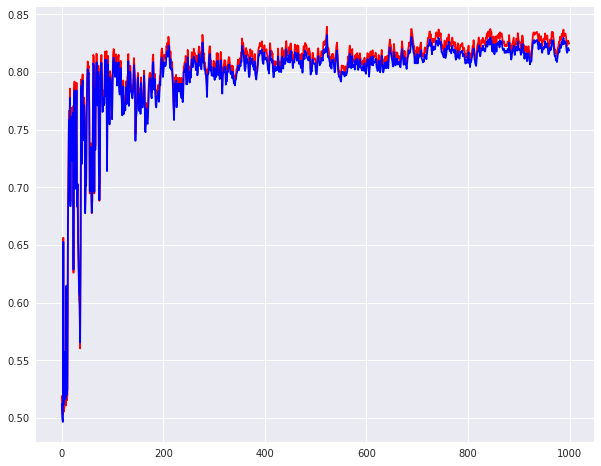

In [21]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b')

## 4. Задание

* Обучим нашу модель **на всех данных**, преобразовав их через ```TfidfVectorizer``` с ```max_features=3000```.

* Параметры модели ```learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3``` и выведем первые 5 самых важных фичей для класса 1 и 5 фичей для класса 0. Убедимся, что они коррелируют с вашей интуицией о хороших/плохих отзывах. 

**Hint:** зная индекс фичи, само слово вы можете получить, используя метод ```vectorizer.get_feature_names()```.

**Hint:** ```np.argsort```.

In [22]:
# Обучите модель
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(review_summaries)
y = train_df.Prediction.values
clf = LogisticRegression()
clf.train(X, y, verbose=True, learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3)

  (0, 3000)	1.0
  (0, 2640)	0.42722343161797305
  (0, 2639)	0.9041460830399937
  (1, 3000)	1.0
  (1, 795)	1.0
  (2, 3000)	1.0
  (2, 2361)	1.0
  (3, 3000)	1.0
  (3, 2961)	0.5244516250377685
  (3, 1408)	0.526948997054254
  (3, 1174)	0.277182352541772
  (3, 737)	0.6086420877150778
  (4, 3000)	1.0
  (4, 1866)	0.49468392179848936
  (4, 1847)	0.7034241665761785
  (4, 550)	0.5103746265153419
  (5, 3000)	1.0
  (5, 937)	0.7248829594310627
  (5, 184)	0.6888720455400003
  (6, 3000)	1.0
  (6, 2115)	0.705774553020071
  (6, 1745)	0.7084365040773372
  (7, 3000)	1.0
  (7, 64)	1.0
  (8, 3000)	1.0
  :	:
  (250, 1379)	0.626047934545904
  (251, 3000)	1.0
  (251, 2633)	0.49915331945957186
  (251, 2219)	0.8665136834883166
  (252, 3000)	1.0
  (252, 1049)	0.34943140575393966
  (252, 813)	0.7925505204925006
  (252, 812)	0.4997613081661003
  (253, 3000)	1.0
  (253, 1600)	0.7387505455047996
  (253, 1404)	0.6739789548022707
  (254, 3000)	1.0
  (254, 2671)	0.31929007200661663
  (254, 2439)	0.33902149116917873
  (2

  (255, 1174)	0.6144239701918209
  (0, 3000)	1.0
  (0, 939)	0.5702425091898269
  (0, 690)	0.532791521595433
  (0, 477)	0.6252652838827002
  (1, 3000)	1.0
  (1, 2651)	1.0
  (2, 3000)	1.0
  (2, 2927)	0.69895290160684
  (2, 2596)	0.6381732082327358
  (2, 1049)	0.3227999343700618
  (3, 3000)	1.0
  (3, 2146)	0.43901425097293884
  (3, 1045)	0.3821088388529752
  (3, 926)	0.7187363169774086
  (3, 808)	0.380364863480909
  (4, 3000)	1.0
  (4, 2401)	0.4771962736837215
  (4, 2067)	0.6186070766501596
  (4, 1988)	0.39353243750856304
  (4, 1572)	0.41286138183680937
  (4, 1049)	0.2535482224687912
  (5, 3000)	1.0
  (5, 924)	1.0
  (6, 3000)	1.0
  (6, 2886)	0.6607669770064778
  :	:
  (250, 3000)	1.0
  (250, 2952)	0.51866519928297
  (250, 1879)	0.4677470270438038
  (250, 1861)	0.3578570176916212
  (250, 1788)	0.3409426581509975
  (250, 117)	0.5175863101804675
  (251, 3000)	1.0
  (252, 3000)	1.0
  (252, 1837)	0.5191684330384193
  (252, 1174)	0.5304710432336432
  (252, 552)	0.6701228323427301
  (253, 3000)	

  (0, 3000)	1.0
  (0, 1816)	0.4888010871877012
  (0, 1072)	0.683329668601057
  (0, 1057)	0.5423412774016845
  (1, 3000)	1.0
  (1, 2671)	0.31861625907801366
  (1, 2600)	0.5930715373936138
  (1, 1174)	0.2242009388805867
  (1, 152)	0.3436894414491837
  (1, 60)	0.6151108337739785
  (2, 3000)	1.0
  (2, 2640)	0.6596224902431871
  (2, 924)	0.7515970798009906
  (3, 3000)	1.0
  (3, 2936)	0.3847929284331032
  (3, 2671)	0.27346554732689166
  (3, 2375)	0.5692072651750473
  (3, 1877)	0.29840504503983223
  (3, 1788)	0.2285037338402698
  (3, 1564)	0.4654367203499353
  (3, 231)	0.3086474007516518
  (4, 3000)	1.0
  (4, 941)	0.7130872050926381
  (4, 102)	0.7010753439774998
  (5, 3000)	1.0
  :	:
  (248, 2638)	1.0
  (249, 3000)	1.0
  (249, 1435)	0.8971816564837758
  (249, 1398)	0.4416617204026494
  (250, 3000)	1.0
  (250, 2915)	0.7242307253309989
  (250, 2681)	0.39174471282678053
  (250, 2651)	0.5674732914056824
  (251, 3000)	1.0
  (251, 924)	0.5686570831304286
  (251, 503)	0.8225746907154347
  (252, 3000

  (0, 3000)	1.0
  (0, 2188)	0.9149035559119041
  (0, 1837)	0.40367249519846343
  (1, 3000)	1.0
  (1, 2664)	0.3594281569545174
  (1, 1837)	0.3539800429458332
  (1, 1022)	0.504182124872371
  (1, 934)	0.7009350284751974
  (2, 3000)	1.0
  (2, 2832)	0.9343193683159949
  (2, 1837)	0.3564369761817652
  (3, 3000)	1.0
  (3, 2630)	0.274661819941237
  (3, 2505)	0.3860543557991878
  (3, 1502)	0.617993232883182
  (3, 843)	0.4249176385955051
  (3, 124)	0.243156190607796
  (3, 117)	0.3923357624856034
  (4, 3000)	1.0
  (4, 2823)	0.3933610566868887
  (4, 2664)	0.19740980092019889
  (4, 1837)	0.1944175169796255
  (4, 1733)	0.3660412430858552
  (4, 1445)	0.567392775150849
  (4, 1067)	0.4544593129478726
  :	:
  (249, 1249)	0.7926867376134605
  (250, 3000)	1.0
  (250, 1873)	0.6371125815263281
  (250, 1866)	0.5086918562648239
  (250, 1410)	0.5790683498782382
  (251, 3000)	1.0
  (251, 2074)	0.7254696588637479
  (251, 335)	0.6882541493286599
  (252, 3000)	1.0
  (252, 1903)	0.839173323646628
  (252, 1892)	0.54

<dmia.classifiers.logistic_regression.LogisticRegression instance at 0x7f17db4db7e8>

In [23]:
# Получите индексы фичей
pos_features = np.argsort(clf.w)[-5:]
neg_features = np.argsort(clf.w)[:5]

In [24]:
# Выведите слова
fnames = vectorizer.get_feature_names()
print [fnames[p] for p in pos_features]
print [fnames[n] for n in neg_features]

[u'excellent', u'delicious', u'love', u'best', u'great']
[u'not', u'disappointed', u'bad', u'too', u'terrible']


## 5. Сравнение с sklearn.linear_model.LogisticRegression

Обучите такую же модель, но из пакета ```sklearn.linear_model``` и убедитесь, что ваша имплементация ничем не хуже (ну или почти не хуже).

In [25]:
from sklearn import linear_model

In [26]:
clf = linear_model.SGDClassifier(n_iter=1000, random_state=42, loss="log", penalty="l2", alpha=1e-3, eta0=1.0, learning_rate="constant")
clf.fit(X_train, y_train)

/home/nikolay/miniconda3/envs/otus_python_env/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=1.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', max_iter=None, n_iter=1000,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [27]:
print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))

Train accuracy = 0.821
Test accuracy = 0.817
